In [1]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [7]:
DATASET1 = os.path.join('worksnehaaa', 'datas')

In [8]:
if not os.path.exists(DATASET1):
    !mkdir -f {DATASET1}
    # wget is a library to retrieve files through HTTP from the internet.
    !python -m wget -o data.rar https://www.dropbox.com/s/aredlgkmx0d5san/original_images.rar?dl=0 #:~:text=Sign%20up-,Direct,-download
    !move data.rar {DATASET1} 
    %cd {DATASET1}


Saved under data.rar
        1 file(s) moved.
C:\Users\sneha\worksnehaaa\datas


In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [5]:
src_dr="C:/Users/sneha/worksnehaaa/datas" ### original dir
directory = 'lr_images2'
path = os.path.join(src_dr, directory)
os.mkdir(path)

directory1 = 'hr_images2'
path1 = os.path.join(src_dr, directory1)
os.mkdir(path1)

In [8]:
train_dir = src_dr 

for img in os.listdir( train_dir + "/original_images"):
    img_array = cv2.imread(train_dir + "/original_images/" + img)
    
    #img_array = cv2.resize(img_array, (128,128))
    lr_img_array = cv2.GaussianBlur(img_array, (31, 31), 0)
    #lr_img_array = cv2.resize(img_array,(32,32))
    cv2.imwrite(train_dir+ "/hr_images2/" + img, img_array)
    cv2.imwrite(train_dir+ "/lr_images2/"+ img, lr_img_array)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from keras.models import Sequential
from tensorflow.keras import layers, Model
# from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from tensorflow.keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tensorflow.keras.applications.vgg19 import VGG19

In [13]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [14]:
def upscale_block(ip):
    
    up_model = Conv2D(128, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 1 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [15]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    #layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [16]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [17]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [18]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
#from keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import VGG19
def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [19]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [20]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

###################################################################################

#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=5000
lr_list = os.listdir("C:/Users/sneha/worksnehaaa/datas/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("C:/Users/sneha/worksnehaaa/datas/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr) 

In [21]:
hr_list = os.listdir("C:/Users/sneha/worksnehaaa/datas/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("C:/Users/sneha/worksnehaaa/datas/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (128, 128, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [23]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

In [24]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [25]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  15616       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 p_re_lu (PReLU)                (None, 128, 128, 64  64          ['conv2d[0][0]']                 
                                )                                                             

In [26]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [27]:
from tensorflow.keras.applications import imagenet_utils

In [28]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [29]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [30]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  1348867     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                            

In [31]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [70]:
epochs = 50
g_loss_avg = []
epo = []
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    g_loss_avg.append(g_loss)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    
    epo.append(e+1)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)
    

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
    #if (e+1) == 2:
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 277ms/step


  0%|▏                                                                               | 1/335 [00:50<4:41:44, 50.61s/it]

1/1 [==============================] - 0s 200ms/step


  1%|▍                                                                               | 2/335 [00:57<2:17:38, 24.80s/it]

1/1 [==============================] - 0s 118ms/step


  1%|▋                                                                               | 3/335 [01:02<1:28:35, 16.01s/it]

1/1 [==============================] - 0s 133ms/step


  1%|▉                                                                               | 4/335 [01:08<1:06:21, 12.03s/it]

1/1 [==============================] - 0s 114ms/step


  1%|█▏                                                                                | 5/335 [01:14<52:52,  9.61s/it]

1/1 [==============================] - 0s 128ms/step


  2%|█▍                                                                                | 6/335 [01:19<45:06,  8.23s/it]

1/1 [==============================] - 0s 113ms/step


  2%|█▋                                                                                | 7/335 [01:25<40:52,  7.48s/it]

1/1 [==============================] - 0s 114ms/step


  2%|█▉                                                                                | 8/335 [01:31<37:42,  6.92s/it]

1/1 [==============================] - 0s 147ms/step


  3%|██▏                                                                               | 9/335 [01:38<37:49,  6.96s/it]

1/1 [==============================] - 0s 125ms/step


  3%|██▍                                                                              | 10/335 [01:44<35:48,  6.61s/it]

1/1 [==============================] - 0s 129ms/step


  3%|██▋                                                                              | 11/335 [01:50<35:01,  6.49s/it]

1/1 [==============================] - 0s 125ms/step


  4%|██▉                                                                              | 12/335 [01:56<33:54,  6.30s/it]

1/1 [==============================] - 0s 124ms/step


  4%|███▏                                                                             | 13/335 [02:02<33:16,  6.20s/it]

1/1 [==============================] - 0s 152ms/step


  4%|███▍                                                                             | 14/335 [02:08<33:22,  6.24s/it]

1/1 [==============================] - 0s 125ms/step


  4%|███▋                                                                             | 15/335 [02:14<32:26,  6.08s/it]

1/1 [==============================] - 0s 125ms/step


  5%|███▊                                                                             | 16/335 [02:20<32:06,  6.04s/it]

1/1 [==============================] - 0s 123ms/step


  5%|████                                                                             | 17/335 [02:26<31:41,  5.98s/it]

1/1 [==============================] - 0s 126ms/step


  5%|████▎                                                                            | 18/335 [02:31<31:09,  5.90s/it]

1/1 [==============================] - 0s 124ms/step


  6%|████▌                                                                            | 19/335 [02:38<31:38,  6.01s/it]

1/1 [==============================] - 0s 122ms/step


  6%|████▊                                                                            | 20/335 [02:43<31:02,  5.91s/it]

1/1 [==============================] - 0s 112ms/step


  6%|█████                                                                            | 21/335 [02:49<31:00,  5.92s/it]

1/1 [==============================] - 0s 121ms/step


  7%|█████▎                                                                           | 22/335 [02:55<30:04,  5.77s/it]

1/1 [==============================] - 0s 184ms/step


  7%|█████▌                                                                           | 23/335 [03:00<30:08,  5.80s/it]

1/1 [==============================] - 0s 143ms/step


  7%|█████▊                                                                           | 24/335 [03:07<30:29,  5.88s/it]

1/1 [==============================] - 0s 239ms/step


  7%|██████                                                                           | 25/335 [03:13<30:32,  5.91s/it]

1/1 [==============================] - 0s 123ms/step


  8%|██████▎                                                                          | 26/335 [03:18<29:42,  5.77s/it]

1/1 [==============================] - 0s 313ms/step


  8%|██████▌                                                                          | 27/335 [03:24<30:33,  5.95s/it]

1/1 [==============================] - 0s 136ms/step


  8%|██████▊                                                                          | 28/335 [03:30<29:35,  5.78s/it]

1/1 [==============================] - 0s 313ms/step


  9%|███████                                                                          | 29/335 [03:36<29:44,  5.83s/it]

1/1 [==============================] - 0s 125ms/step


  9%|███████▎                                                                         | 30/335 [03:42<29:45,  5.85s/it]

1/1 [==============================] - 0s 231ms/step


  9%|███████▍                                                                         | 31/335 [03:48<29:58,  5.92s/it]

1/1 [==============================] - 0s 110ms/step


 10%|███████▋                                                                         | 32/335 [03:53<28:50,  5.71s/it]

1/1 [==============================] - 0s 106ms/step


 10%|███████▉                                                                         | 33/335 [03:58<28:32,  5.67s/it]

1/1 [==============================] - 0s 108ms/step


 10%|████████▏                                                                        | 34/335 [04:04<28:10,  5.62s/it]

1/1 [==============================] - 0s 109ms/step


 10%|████████▍                                                                        | 35/335 [04:10<28:20,  5.67s/it]

1/1 [==============================] - 0s 105ms/step


 11%|████████▋                                                                        | 36/335 [04:15<27:24,  5.50s/it]

1/1 [==============================] - 0s 105ms/step


 11%|████████▉                                                                        | 37/335 [04:20<27:08,  5.47s/it]

1/1 [==============================] - 0s 107ms/step


 11%|█████████▏                                                                       | 38/335 [04:26<27:08,  5.48s/it]

1/1 [==============================] - 0s 109ms/step


 12%|█████████▍                                                                       | 39/335 [04:31<26:48,  5.43s/it]

1/1 [==============================] - 0s 115ms/step


 12%|█████████▋                                                                       | 40/335 [04:37<27:26,  5.58s/it]

1/1 [==============================] - 0s 112ms/step


 12%|█████████▉                                                                       | 41/335 [04:42<26:40,  5.44s/it]

1/1 [==============================] - 0s 153ms/step


 13%|██████████▏                                                                      | 42/335 [04:48<26:48,  5.49s/it]

1/1 [==============================] - 0s 111ms/step


 13%|██████████▍                                                                      | 43/335 [04:53<26:23,  5.42s/it]

1/1 [==============================] - 0s 239ms/step


 13%|██████████▋                                                                      | 44/335 [04:59<26:54,  5.55s/it]

1/1 [==============================] - 0s 121ms/step


 13%|██████████▉                                                                      | 45/335 [05:04<26:50,  5.55s/it]

1/1 [==============================] - 0s 337ms/step


 14%|███████████                                                                      | 46/335 [05:11<28:24,  5.90s/it]

1/1 [==============================] - 0s 135ms/step


 14%|███████████▎                                                                     | 47/335 [05:17<28:17,  5.89s/it]

1/1 [==============================] - 0s 250ms/step


 14%|███████████▌                                                                     | 48/335 [05:23<28:38,  5.99s/it]

1/1 [==============================] - 0s 110ms/step


 15%|███████████▊                                                                     | 49/335 [05:28<27:30,  5.77s/it]

1/1 [==============================] - 0s 107ms/step


 15%|████████████                                                                     | 50/335 [05:34<27:16,  5.74s/it]

1/1 [==============================] - 0s 106ms/step


 15%|████████████▎                                                                    | 51/335 [05:39<26:10,  5.53s/it]

1/1 [==============================] - 0s 105ms/step


 16%|████████████▌                                                                    | 52/335 [05:45<25:54,  5.49s/it]

1/1 [==============================] - 0s 104ms/step


 16%|████████████▊                                                                    | 53/335 [05:50<25:25,  5.41s/it]

1/1 [==============================] - 0s 128ms/step


 16%|█████████████                                                                    | 54/335 [05:55<24:58,  5.33s/it]

1/1 [==============================] - 0s 106ms/step


 16%|█████████████▎                                                                   | 55/335 [06:00<25:06,  5.38s/it]

1/1 [==============================] - 0s 108ms/step


 17%|█████████████▌                                                                   | 56/335 [06:05<24:31,  5.28s/it]

1/1 [==============================] - 0s 105ms/step


 17%|█████████████▊                                                                   | 57/335 [06:11<25:10,  5.43s/it]

1/1 [==============================] - 0s 120ms/step


 17%|██████████████                                                                   | 58/335 [06:16<24:32,  5.32s/it]

1/1 [==============================] - 0s 111ms/step


 18%|██████████████▎                                                                  | 59/335 [06:21<24:11,  5.26s/it]

1/1 [==============================] - 0s 115ms/step


 18%|██████████████▌                                                                  | 60/335 [06:27<24:20,  5.31s/it]

1/1 [==============================] - 0s 106ms/step


 18%|██████████████▋                                                                  | 61/335 [06:32<23:59,  5.25s/it]

1/1 [==============================] - 0s 248ms/step


 19%|██████████████▉                                                                  | 62/335 [06:38<24:42,  5.43s/it]

1/1 [==============================] - 0s 120ms/step


 19%|███████████████▏                                                                 | 63/335 [06:43<24:27,  5.40s/it]

1/1 [==============================] - 0s 276ms/step


 19%|███████████████▍                                                                 | 64/335 [06:49<24:58,  5.53s/it]

1/1 [==============================] - 0s 105ms/step


 19%|███████████████▋                                                                 | 65/335 [06:54<24:11,  5.38s/it]

1/1 [==============================] - 0s 110ms/step


 20%|███████████████▉                                                                 | 66/335 [06:59<24:12,  5.40s/it]

1/1 [==============================] - 0s 125ms/step


 20%|████████████████▏                                                                | 67/335 [07:05<23:51,  5.34s/it]

1/1 [==============================] - 0s 112ms/step


 20%|████████████████▍                                                                | 68/335 [07:10<23:55,  5.38s/it]

1/1 [==============================] - 0s 107ms/step


 21%|████████████████▋                                                                | 69/335 [07:15<23:27,  5.29s/it]

1/1 [==============================] - 0s 112ms/step


 21%|████████████████▉                                                                | 70/335 [07:21<23:56,  5.42s/it]

1/1 [==============================] - 0s 119ms/step


 21%|█████████████████▏                                                               | 71/335 [07:26<23:48,  5.41s/it]

1/1 [==============================] - 0s 112ms/step


 21%|█████████████████▍                                                               | 72/335 [07:31<23:15,  5.30s/it]

1/1 [==============================] - 0s 150ms/step


 22%|█████████████████▋                                                               | 73/335 [07:37<23:35,  5.40s/it]

1/1 [==============================] - 0s 105ms/step


 22%|█████████████████▉                                                               | 74/335 [07:42<23:17,  5.36s/it]

1/1 [==============================] - 0s 106ms/step


 22%|██████████████████▏                                                              | 75/335 [07:48<23:20,  5.39s/it]

1/1 [==============================] - 0s 116ms/step


 23%|██████████████████▍                                                              | 76/335 [07:53<22:51,  5.30s/it]

1/1 [==============================] - 0s 100ms/step


 23%|██████████████████▌                                                              | 77/335 [07:58<23:06,  5.38s/it]

1/1 [==============================] - 0s 105ms/step


 23%|██████████████████▊                                                              | 78/335 [08:04<22:46,  5.32s/it]

1/1 [==============================] - 0s 120ms/step


 24%|███████████████████                                                              | 79/335 [08:09<23:10,  5.43s/it]

1/1 [==============================] - 0s 106ms/step


 24%|███████████████████▎                                                             | 80/335 [08:16<24:33,  5.78s/it]

1/1 [==============================] - 0s 122ms/step


 24%|███████████████████▌                                                             | 81/335 [08:21<23:31,  5.56s/it]

1/1 [==============================] - 0s 115ms/step


 24%|███████████████████▊                                                             | 82/335 [08:26<23:30,  5.58s/it]

1/1 [==============================] - 0s 107ms/step


 25%|████████████████████                                                             | 83/335 [08:32<23:07,  5.51s/it]

1/1 [==============================] - 0s 229ms/step


 25%|████████████████████▎                                                            | 84/335 [08:37<23:10,  5.54s/it]

1/1 [==============================] - 0s 107ms/step


 25%|████████████████████▌                                                            | 85/335 [08:43<22:39,  5.44s/it]

1/1 [==============================] - 0s 105ms/step


 26%|████████████████████▊                                                            | 86/335 [08:48<23:00,  5.54s/it]

1/1 [==============================] - 0s 148ms/step


 26%|█████████████████████                                                            | 87/335 [08:54<22:38,  5.48s/it]

1/1 [==============================] - 0s 153ms/step


 26%|█████████████████████▎                                                           | 88/335 [08:59<22:46,  5.53s/it]

1/1 [==============================] - 0s 121ms/step


 27%|█████████████████████▌                                                           | 89/335 [09:05<22:45,  5.55s/it]

1/1 [==============================] - 0s 98ms/step


 27%|█████████████████████▊                                                           | 90/335 [09:10<22:31,  5.52s/it]

1/1 [==============================] - 0s 103ms/step


 27%|██████████████████████                                                           | 91/335 [09:16<21:58,  5.40s/it]

1/1 [==============================] - 0s 154ms/step


 27%|██████████████████████▏                                                          | 92/335 [09:21<21:41,  5.35s/it]

1/1 [==============================] - 0s 114ms/step


 28%|██████████████████████▍                                                          | 93/335 [09:26<21:46,  5.40s/it]

1/1 [==============================] - 0s 110ms/step


 28%|██████████████████████▋                                                          | 94/335 [09:32<21:25,  5.33s/it]

1/1 [==============================] - 0s 108ms/step


 28%|██████████████████████▉                                                          | 95/335 [09:37<21:21,  5.34s/it]

1/1 [==============================] - 0s 104ms/step


 29%|███████████████████████▏                                                         | 96/335 [09:42<20:57,  5.26s/it]

1/1 [==============================] - 0s 217ms/step


 29%|███████████████████████▍                                                         | 97/335 [09:48<21:24,  5.40s/it]

1/1 [==============================] - 0s 106ms/step


 29%|███████████████████████▋                                                         | 98/335 [09:53<20:51,  5.28s/it]

1/1 [==============================] - 0s 113ms/step


 30%|███████████████████████▉                                                         | 99/335 [09:58<20:51,  5.30s/it]

1/1 [==============================] - 0s 123ms/step


 30%|███████████████████████▉                                                        | 100/335 [10:03<20:28,  5.23s/it]

1/1 [==============================] - 0s 102ms/step


 30%|████████████████████████                                                        | 101/335 [10:08<20:30,  5.26s/it]

1/1 [==============================] - 0s 108ms/step


 30%|████████████████████████▎                                                       | 102/335 [10:14<20:19,  5.23s/it]

1/1 [==============================] - 0s 108ms/step


 31%|████████████████████████▌                                                       | 103/335 [10:19<20:20,  5.26s/it]

1/1 [==============================] - 0s 110ms/step


 31%|████████████████████████▊                                                       | 104/335 [10:24<20:26,  5.31s/it]

1/1 [==============================] - 0s 178ms/step


 31%|█████████████████████████                                                       | 105/335 [10:30<20:14,  5.28s/it]

1/1 [==============================] - 0s 126ms/step


 32%|█████████████████████████▎                                                      | 106/335 [10:35<20:09,  5.28s/it]

1/1 [==============================] - 0s 108ms/step


 32%|█████████████████████████▌                                                      | 107/335 [10:40<19:47,  5.21s/it]

1/1 [==============================] - 0s 288ms/step


 32%|█████████████████████████▊                                                      | 108/335 [10:45<20:08,  5.33s/it]

1/1 [==============================] - 0s 150ms/step


 33%|██████████████████████████                                                      | 109/335 [10:51<19:45,  5.25s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████████████▎                                                     | 110/335 [10:56<20:13,  5.39s/it]

1/1 [==============================] - 0s 125ms/step


 33%|██████████████████████████▌                                                     | 111/335 [11:02<19:59,  5.35s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████████████▋                                                     | 112/335 [11:07<20:06,  5.41s/it]

1/1 [==============================] - 0s 136ms/step


 34%|██████████████████████████▉                                                     | 113/335 [11:13<20:22,  5.51s/it]

1/1 [==============================] - 0s 127ms/step


 34%|███████████████████████████▏                                                    | 114/335 [11:19<20:49,  5.65s/it]

1/1 [==============================] - 0s 109ms/step


 34%|███████████████████████████▍                                                    | 115/335 [11:24<20:38,  5.63s/it]

1/1 [==============================] - 0s 131ms/step


 35%|███████████████████████████▋                                                    | 116/335 [11:30<20:15,  5.55s/it]

1/1 [==============================] - 0s 118ms/step


 35%|███████████████████████████▉                                                    | 117/335 [11:35<20:12,  5.56s/it]

1/1 [==============================] - 0s 136ms/step


 35%|████████████████████████████▏                                                   | 118/335 [11:41<19:58,  5.52s/it]

1/1 [==============================] - 0s 124ms/step


 36%|████████████████████████████▍                                                   | 119/335 [11:47<20:16,  5.63s/it]

1/1 [==============================] - 0s 117ms/step


 36%|████████████████████████████▋                                                   | 120/335 [11:52<19:42,  5.50s/it]

1/1 [==============================] - 0s 221ms/step


 36%|████████████████████████████▉                                                   | 121/335 [11:58<19:55,  5.59s/it]

1/1 [==============================] - 0s 118ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [12:03<19:48,  5.58s/it]

1/1 [==============================] - 0s 259ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [12:12<22:47,  6.45s/it]

1/1 [==============================] - 0s 113ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [12:17<21:30,  6.11s/it]

1/1 [==============================] - 0s 409ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [12:25<22:54,  6.55s/it]

1/1 [==============================] - 0s 110ms/step


 38%|██████████████████████████████                                                  | 126/335 [12:30<21:35,  6.20s/it]

1/1 [==============================] - 0s 258ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [12:36<21:25,  6.18s/it]

1/1 [==============================] - 0s 111ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [12:41<20:16,  5.88s/it]

1/1 [==============================] - 0s 274ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [12:47<20:24,  5.95s/it]

1/1 [==============================] - 0s 110ms/step


 39%|███████████████████████████████                                                 | 130/335 [12:53<19:31,  5.71s/it]

1/1 [==============================] - 0s 119ms/step


 39%|███████████████████████████████▎                                                | 131/335 [12:58<19:09,  5.64s/it]

1/1 [==============================] - 0s 115ms/step


 39%|███████████████████████████████▌                                                | 132/335 [13:03<18:31,  5.47s/it]

1/1 [==============================] - 0s 151ms/step


 40%|███████████████████████████████▊                                                | 133/335 [13:08<18:22,  5.46s/it]

1/1 [==============================] - 0s 109ms/step


 40%|████████████████████████████████                                                | 134/335 [13:14<18:05,  5.40s/it]

1/1 [==============================] - 0s 102ms/step


 40%|████████████████████████████████▏                                               | 135/335 [13:19<17:43,  5.32s/it]

1/1 [==============================] - 0s 118ms/step


 41%|████████████████████████████████▍                                               | 136/335 [13:24<17:48,  5.37s/it]

1/1 [==============================] - 0s 104ms/step


 41%|████████████████████████████████▋                                               | 137/335 [13:29<17:25,  5.28s/it]

1/1 [==============================] - 0s 185ms/step


 41%|████████████████████████████████▉                                               | 138/335 [13:35<17:44,  5.40s/it]

1/1 [==============================] - 0s 110ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [13:41<17:51,  5.47s/it]

1/1 [==============================] - 0s 465ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [13:47<18:54,  5.82s/it]

1/1 [==============================] - 0s 113ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [13:52<18:05,  5.60s/it]

1/1 [==============================] - 0s 113ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [13:58<18:01,  5.60s/it]

1/1 [==============================] - 0s 108ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [14:04<17:47,  5.56s/it]

1/1 [==============================] - 0s 126ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [14:09<18:02,  5.67s/it]

1/1 [==============================] - 0s 113ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [14:15<17:49,  5.63s/it]

1/1 [==============================] - 0s 114ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [14:21<18:20,  5.82s/it]

1/1 [==============================] - 0s 115ms/step


 44%|███████████████████████████████████                                             | 147/335 [14:27<18:28,  5.90s/it]

1/1 [==============================] - 0s 107ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [14:34<18:37,  5.97s/it]

1/1 [==============================] - 0s 117ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [14:40<18:55,  6.10s/it]

1/1 [==============================] - 0s 119ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [14:46<18:25,  5.98s/it]

1/1 [==============================] - 0s 110ms/step


 45%|████████████████████████████████████                                            | 151/335 [14:52<18:49,  6.14s/it]

1/1 [==============================] - 0s 109ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [14:57<18:01,  5.91s/it]

1/1 [==============================] - 0s 178ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [15:03<17:56,  5.92s/it]

1/1 [==============================] - 0s 115ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [15:09<17:09,  5.69s/it]

1/1 [==============================] - 0s 109ms/step


 46%|█████████████████████████████████████                                           | 155/335 [15:14<16:50,  5.61s/it]

1/1 [==============================] - 0s 107ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [15:19<16:22,  5.49s/it]

1/1 [==============================] - 0s 109ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [15:25<16:13,  5.47s/it]

1/1 [==============================] - 0s 119ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [15:30<15:51,  5.37s/it]

1/1 [==============================] - 0s 103ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [15:35<15:42,  5.35s/it]

1/1 [==============================] - 0s 146ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [15:40<15:34,  5.34s/it]

1/1 [==============================] - 0s 140ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [15:47<16:15,  5.61s/it]

1/1 [==============================] - 0s 134ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [15:53<17:08,  5.94s/it]

1/1 [==============================] - 0s 120ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [16:00<17:15,  6.02s/it]

1/1 [==============================] - 0s 130ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [16:06<17:37,  6.18s/it]

1/1 [==============================] - 0s 129ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [16:12<17:37,  6.22s/it]

1/1 [==============================] - 0s 150ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [16:19<17:50,  6.33s/it]

1/1 [==============================] - 0s 119ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [16:25<17:27,  6.23s/it]

1/1 [==============================] - 0s 113ms/step


 50%|████████████████████████████████████████                                        | 168/335 [16:30<16:35,  5.96s/it]

1/1 [==============================] - 0s 120ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [16:36<16:10,  5.85s/it]

1/1 [==============================] - 0s 111ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [16:41<15:47,  5.74s/it]

1/1 [==============================] - 0s 74ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [16:47<15:15,  5.58s/it]

1/1 [==============================] - 0s 108ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [16:52<15:11,  5.59s/it]

1/1 [==============================] - 0s 116ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [16:58<14:57,  5.54s/it]

1/1 [==============================] - 1s 551ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [17:06<16:43,  6.23s/it]

1/1 [==============================] - 0s 136ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [17:12<17:07,  6.42s/it]

1/1 [==============================] - 0s 105ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [17:18<16:33,  6.25s/it]

1/1 [==============================] - 0s 113ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [17:23<15:36,  5.93s/it]

1/1 [==============================] - 0s 171ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [17:29<15:12,  5.81s/it]

1/1 [==============================] - 0s 113ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [17:34<14:34,  5.61s/it]

1/1 [==============================] - 0s 217ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [17:40<14:48,  5.73s/it]

1/1 [==============================] - 0s 115ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [17:46<14:34,  5.68s/it]

1/1 [==============================] - 0s 205ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [17:52<15:06,  5.93s/it]

1/1 [==============================] - 0s 116ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [17:58<14:48,  5.84s/it]

1/1 [==============================] - 0s 316ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [18:04<15:20,  6.10s/it]

1/1 [==============================] - 0s 135ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [18:10<15:08,  6.06s/it]

1/1 [==============================] - 0s 476ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [18:19<16:40,  6.71s/it]

1/1 [==============================] - 0s 173ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [18:25<16:31,  6.70s/it]

1/1 [==============================] - 0s 236ms/step


 56%|██████████████████████████████████████████▋                                 | 188/335 [33:52<11:32:41, 282.73s/it]

1/1 [==============================] - 0s 90ms/step


 56%|███████████████████████████████████████████▍                                 | 189/335 [33:58<8:05:45, 199.63s/it]

1/1 [==============================] - 0s 69ms/step


 57%|███████████████████████████████████████████▋                                 | 190/335 [34:02<5:41:00, 141.11s/it]

1/1 [==============================] - 0s 78ms/step


 57%|███████████████████████████████████████████▉                                 | 191/335 [34:07<4:00:34, 100.24s/it]

1/1 [==============================] - 0s 80ms/step


 57%|████████████████████████████████████████████▋                                 | 192/335 [34:13<2:51:03, 71.77s/it]

1/1 [==============================] - 0s 95ms/step


 58%|████████████████████████████████████████████▉                                 | 193/335 [34:18<2:02:29, 51.76s/it]

1/1 [==============================] - 0s 78ms/step


 58%|█████████████████████████████████████████████▏                                | 194/335 [34:22<1:28:23, 37.61s/it]

1/1 [==============================] - 0s 76ms/step


 58%|█████████████████████████████████████████████▍                                | 195/335 [34:28<1:05:15, 27.97s/it]

1/1 [==============================] - 0s 74ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [34:32<48:32, 20.95s/it]

1/1 [==============================] - 0s 77ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [34:37<36:46, 15.99s/it]

1/1 [==============================] - 1s 759ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [34:43<29:50, 13.07s/it]

1/1 [==============================] - 0s 66ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [34:47<23:38, 10.43s/it]

1/1 [==============================] - 0s 73ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [34:53<20:26,  9.08s/it]

1/1 [==============================] - 0s 131ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [34:58<17:34,  7.87s/it]

1/1 [==============================] - 0s 94ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [35:03<15:22,  6.94s/it]

1/1 [==============================] - 0s 89ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [35:09<14:44,  6.70s/it]

1/1 [==============================] - 0s 83ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [35:14<13:14,  6.07s/it]

1/1 [==============================] - 0s 91ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [35:18<12:13,  5.64s/it]

1/1 [==============================] - 0s 115ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [35:24<11:48,  5.50s/it]

1/1 [==============================] - 0s 101ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [35:29<11:23,  5.34s/it]

1/1 [==============================] - 0s 81ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [35:34<11:03,  5.23s/it]

1/1 [==============================] - 0s 123ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [35:39<10:56,  5.21s/it]

1/1 [==============================] - 0s 163ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [35:44<10:53,  5.23s/it]

1/1 [==============================] - 0s 104ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [35:48<10:13,  4.95s/it]

1/1 [==============================] - 0s 71ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [35:53<09:52,  4.81s/it]

1/1 [==============================] - 0s 113ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [35:57<09:33,  4.70s/it]

1/1 [==============================] - 0s 62ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [36:01<09:02,  4.48s/it]

1/1 [==============================] - 0s 97ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [36:06<09:07,  4.56s/it]

1/1 [==============================] - 0s 96ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [36:11<09:04,  4.58s/it]

1/1 [==============================] - 0s 109ms/step


 65%|███████████████████████████████████████████████████▊                            | 217/335 [36:15<09:08,  4.65s/it]

1/1 [==============================] - 0s 98ms/step


 65%|████████████████████████████████████████████████████                            | 218/335 [36:21<09:27,  4.85s/it]

1/1 [==============================] - 0s 97ms/step


 65%|████████████████████████████████████████████████████▎                           | 219/335 [36:25<09:20,  4.83s/it]

1/1 [==============================] - 0s 112ms/step


 66%|████████████████████████████████████████████████████▌                           | 220/335 [36:31<09:43,  5.07s/it]

1/1 [==============================] - 0s 105ms/step


 66%|████████████████████████████████████████████████████▊                           | 221/335 [36:36<09:22,  4.93s/it]

1/1 [==============================] - 0s 89ms/step


 66%|█████████████████████████████████████████████████████                           | 222/335 [36:41<09:13,  4.90s/it]

1/1 [==============================] - 0s 86ms/step


 67%|█████████████████████████████████████████████████████▎                          | 223/335 [36:45<09:05,  4.87s/it]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████████████████████████████████▍                          | 224/335 [36:50<08:51,  4.78s/it]

1/1 [==============================] - 0s 68ms/step


 67%|█████████████████████████████████████████████████████▋                          | 225/335 [36:55<08:39,  4.72s/it]

1/1 [==============================] - 0s 80ms/step


 67%|█████████████████████████████████████████████████████▉                          | 226/335 [36:59<08:40,  4.78s/it]

1/1 [==============================] - 0s 70ms/step


 68%|██████████████████████████████████████████████████████▏                         | 227/335 [37:04<08:26,  4.69s/it]

1/1 [==============================] - 0s 78ms/step


 68%|██████████████████████████████████████████████████████▍                         | 228/335 [37:08<08:09,  4.58s/it]

1/1 [==============================] - 0s 75ms/step


 68%|██████████████████████████████████████████████████████▋                         | 229/335 [37:12<07:50,  4.44s/it]

1/1 [==============================] - 0s 70ms/step


 69%|██████████████████████████████████████████████████████▉                         | 230/335 [37:17<07:50,  4.48s/it]

1/1 [==============================] - 0s 127ms/step


 69%|███████████████████████████████████████████████████████▏                        | 231/335 [37:22<08:06,  4.68s/it]

1/1 [==============================] - 0s 72ms/step


 69%|███████████████████████████████████████████████████████▍                        | 232/335 [37:27<07:56,  4.62s/it]

1/1 [==============================] - 0s 72ms/step


 70%|███████████████████████████████████████████████████████▋                        | 233/335 [37:31<07:40,  4.51s/it]

1/1 [==============================] - 0s 63ms/step


 70%|███████████████████████████████████████████████████████▉                        | 234/335 [37:35<07:32,  4.48s/it]

1/1 [==============================] - 0s 76ms/step


 70%|████████████████████████████████████████████████████████                        | 235/335 [37:40<07:27,  4.47s/it]

1/1 [==============================] - 0s 74ms/step


 70%|████████████████████████████████████████████████████████▎                       | 236/335 [37:45<07:46,  4.71s/it]

1/1 [==============================] - 0s 95ms/step


 71%|████████████████████████████████████████████████████████▌                       | 237/335 [37:51<08:12,  5.03s/it]

1/1 [==============================] - 0s 121ms/step


 71%|████████████████████████████████████████████████████████▊                       | 238/335 [37:56<08:04,  4.99s/it]

1/1 [==============================] - 0s 82ms/step


 71%|█████████████████████████████████████████████████████████                       | 239/335 [38:00<07:51,  4.91s/it]

1/1 [==============================] - 0s 77ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 240/335 [38:05<07:44,  4.89s/it]

1/1 [==============================] - 0s 71ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 241/335 [38:10<07:50,  5.00s/it]

1/1 [==============================] - 0s 69ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 242/335 [38:15<07:28,  4.82s/it]

1/1 [==============================] - 0s 66ms/step


 73%|██████████████████████████████████████████████████████████                      | 243/335 [38:19<07:08,  4.65s/it]

1/1 [==============================] - 0s 227ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 244/335 [38:24<07:11,  4.75s/it]

1/1 [==============================] - 0s 64ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 245/335 [38:28<06:50,  4.56s/it]

1/1 [==============================] - 0s 69ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 246/335 [38:33<06:51,  4.63s/it]

1/1 [==============================] - 0s 66ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 247/335 [38:38<06:54,  4.71s/it]

1/1 [==============================] - 0s 67ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 248/335 [38:42<06:36,  4.55s/it]

1/1 [==============================] - 0s 67ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 249/335 [38:47<06:36,  4.61s/it]

1/1 [==============================] - 0s 80ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 250/335 [38:51<06:20,  4.48s/it]

1/1 [==============================] - 0s 119ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 251/335 [38:55<06:15,  4.47s/it]

1/1 [==============================] - 0s 67ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 252/335 [39:00<06:04,  4.39s/it]

1/1 [==============================] - 0s 75ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 253/335 [39:04<05:58,  4.37s/it]

1/1 [==============================] - 0s 77ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 254/335 [39:09<06:04,  4.50s/it]

1/1 [==============================] - 0s 74ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 255/335 [39:14<06:09,  4.61s/it]

1/1 [==============================] - 0s 73ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 256/335 [39:18<06:03,  4.60s/it]

1/1 [==============================] - 0s 80ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 257/335 [39:23<05:56,  4.57s/it]

1/1 [==============================] - 0s 200ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 258/335 [39:28<06:16,  4.89s/it]

1/1 [==============================] - 0s 73ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 259/335 [39:33<06:05,  4.82s/it]

1/1 [==============================] - 0s 72ms/step


 78%|██████████████████████████████████████████████████████████████                  | 260/335 [39:38<05:55,  4.74s/it]

1/1 [==============================] - 0s 74ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 261/335 [39:42<05:45,  4.67s/it]

1/1 [==============================] - 0s 84ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 262/335 [39:47<05:50,  4.80s/it]

1/1 [==============================] - 0s 88ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 263/335 [39:52<05:45,  4.79s/it]

1/1 [==============================] - 0s 65ms/step


 79%|███████████████████████████████████████████████████████████████                 | 264/335 [39:56<05:33,  4.69s/it]

1/1 [==============================] - 0s 207ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 265/335 [40:02<05:42,  4.89s/it]

1/1 [==============================] - 0s 75ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 266/335 [40:06<05:30,  4.78s/it]

1/1 [==============================] - 0s 70ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 267/335 [40:11<05:31,  4.87s/it]

1/1 [==============================] - 0s 77ms/step


 80%|████████████████████████████████████████████████████████████████                | 268/335 [40:16<05:24,  4.84s/it]

1/1 [==============================] - 0s 100ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 269/335 [40:21<05:15,  4.78s/it]

1/1 [==============================] - 0s 209ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 270/335 [40:26<05:15,  4.85s/it]

1/1 [==============================] - 0s 68ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 271/335 [40:30<05:01,  4.70s/it]

1/1 [==============================] - 0s 83ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 272/335 [40:35<05:04,  4.83s/it]

1/1 [==============================] - 0s 80ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 273/335 [40:41<05:09,  5.00s/it]

1/1 [==============================] - 0s 67ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 274/335 [40:46<05:02,  4.96s/it]

1/1 [==============================] - 0s 263ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 275/335 [40:52<05:16,  5.28s/it]

1/1 [==============================] - 0s 79ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 276/335 [40:57<05:08,  5.23s/it]

1/1 [==============================] - 0s 80ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 277/335 [41:02<05:11,  5.38s/it]

1/1 [==============================] - 0s 86ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 278/335 [41:08<05:05,  5.36s/it]

1/1 [==============================] - 0s 84ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 279/335 [41:14<05:10,  5.55s/it]

1/1 [==============================] - 0s 83ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 280/335 [41:19<04:53,  5.33s/it]

1/1 [==============================] - 0s 70ms/step


 84%|███████████████████████████████████████████████████████████████████             | 281/335 [41:23<04:37,  5.14s/it]

1/1 [==============================] - 0s 83ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 282/335 [41:29<04:36,  5.22s/it]

1/1 [==============================] - 0s 80ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 283/335 [41:33<04:25,  5.10s/it]

1/1 [==============================] - 0s 83ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 284/335 [41:39<04:24,  5.18s/it]

1/1 [==============================] - 0s 83ms/step


 85%|████████████████████████████████████████████████████████████████████            | 285/335 [41:44<04:16,  5.12s/it]

1/1 [==============================] - 0s 85ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 286/335 [41:50<04:28,  5.47s/it]

1/1 [==============================] - 0s 79ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 287/335 [41:55<04:21,  5.44s/it]

1/1 [==============================] - 0s 84ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 288/335 [42:01<04:18,  5.50s/it]

1/1 [==============================] - 0s 88ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 289/335 [42:07<04:16,  5.58s/it]

1/1 [==============================] - 0s 111ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 290/335 [42:12<04:03,  5.42s/it]

1/1 [==============================] - 0s 226ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 291/335 [42:18<04:04,  5.56s/it]

1/1 [==============================] - 0s 108ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 292/335 [42:23<03:59,  5.57s/it]

1/1 [==============================] - 0s 87ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 293/335 [42:30<04:04,  5.82s/it]

1/1 [==============================] - 0s 101ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 294/335 [42:35<03:54,  5.71s/it]

1/1 [==============================] - 0s 86ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 295/335 [42:41<03:52,  5.82s/it]

1/1 [==============================] - 0s 101ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 296/335 [42:47<03:41,  5.69s/it]

1/1 [==============================] - 0s 90ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 297/335 [42:52<03:35,  5.68s/it]

1/1 [==============================] - 0s 88ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 298/335 [42:58<03:28,  5.64s/it]

1/1 [==============================] - 0s 85ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 299/335 [43:03<03:15,  5.43s/it]

1/1 [==============================] - 0s 244ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 300/335 [43:09<03:13,  5.52s/it]

1/1 [==============================] - 0s 84ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 301/335 [43:14<03:06,  5.48s/it]

1/1 [==============================] - 0s 94ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 302/335 [43:20<03:07,  5.67s/it]

1/1 [==============================] - 0s 88ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 303/335 [43:26<03:03,  5.72s/it]

1/1 [==============================] - 0s 99ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 304/335 [43:32<03:00,  5.84s/it]

1/1 [==============================] - 0s 155ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 305/335 [43:38<02:54,  5.82s/it]

1/1 [==============================] - 0s 94ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 306/335 [43:44<02:55,  6.06s/it]

1/1 [==============================] - 0s 93ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 307/335 [43:50<02:48,  6.02s/it]

1/1 [==============================] - 1s 822ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 308/335 [44:02<03:31,  7.82s/it]

1/1 [==============================] - 0s 330ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 309/335 [44:10<03:20,  7.70s/it]

1/1 [==============================] - 0s 101ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 310/335 [44:16<02:58,  7.13s/it]

1/1 [==============================] - 0s 143ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 311/335 [44:22<02:46,  6.96s/it]

1/1 [==============================] - 0s 100ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 312/335 [44:27<02:29,  6.48s/it]

1/1 [==============================] - 0s 89ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 313/335 [44:33<02:19,  6.34s/it]

1/1 [==============================] - 0s 90ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 314/335 [44:39<02:10,  6.22s/it]

1/1 [==============================] - 0s 89ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 315/335 [44:45<01:58,  5.93s/it]

1/1 [==============================] - 0s 107ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 316/335 [44:51<01:54,  6.04s/it]

1/1 [==============================] - 0s 85ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 317/335 [44:56<01:45,  5.84s/it]

1/1 [==============================] - 0s 254ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 318/335 [45:03<01:41,  5.96s/it]

1/1 [==============================] - 0s 88ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 319/335 [45:08<01:33,  5.82s/it]

1/1 [==============================] - 0s 83ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 320/335 [45:13<01:25,  5.67s/it]

1/1 [==============================] - 0s 90ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 321/335 [45:20<01:21,  5.83s/it]

1/1 [==============================] - 0s 87ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 322/335 [45:25<01:14,  5.74s/it]

1/1 [==============================] - 0s 95ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 323/335 [45:31<01:09,  5.77s/it]

1/1 [==============================] - 0s 93ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 324/335 [45:38<01:06,  6.05s/it]

1/1 [==============================] - 0s 96ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 325/335 [45:43<00:59,  5.96s/it]

1/1 [==============================] - 0s 91ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 326/335 [45:50<00:55,  6.20s/it]

1/1 [==============================] - 0s 85ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 327/335 [45:56<00:48,  6.02s/it]

1/1 [==============================] - 0s 270ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 328/335 [46:02<00:43,  6.17s/it]

1/1 [==============================] - 0s 96ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 329/335 [46:08<00:35,  5.98s/it]

1/1 [==============================] - 0s 92ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 330/335 [46:14<00:30,  6.08s/it]

1/1 [==============================] - 0s 87ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 331/335 [46:19<00:23,  5.86s/it]

1/1 [==============================] - 0s 87ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 332/335 [46:25<00:17,  5.85s/it]

1/1 [==============================] - 0s 96ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 333/335 [46:32<00:11,  5.97s/it]

1/1 [==============================] - 0s 86ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 334/335 [46:37<00:05,  5.72s/it]

1/1 [==============================] - 0s 286ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 335/335 [46:43<00:00,  8.37s/it]


epoch: 1 g_loss: 88.04454897695513 d_loss: [4.33653776 0.44925373]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 85ms/step


  0%|▏                                                                                 | 1/335 [00:05<28:33,  5.13s/it]

1/1 [==============================] - 0s 95ms/step


  1%|▍                                                                                 | 2/335 [00:10<29:54,  5.39s/it]

1/1 [==============================] - 0s 96ms/step


  1%|▋                                                                                 | 3/335 [00:16<31:50,  5.75s/it]

1/1 [==============================] - 0s 96ms/step


  1%|▉                                                                                 | 4/335 [00:22<32:27,  5.88s/it]

1/1 [==============================] - 0s 91ms/step


  1%|█▏                                                                                | 5/335 [00:28<31:49,  5.79s/it]

1/1 [==============================] - 0s 94ms/step


  2%|█▍                                                                                | 6/335 [00:35<33:45,  6.16s/it]

1/1 [==============================] - 0s 109ms/step


  2%|█▋                                                                                | 7/335 [00:41<33:11,  6.07s/it]

1/1 [==============================] - 0s 277ms/step


  2%|█▉                                                                                | 8/335 [00:48<35:20,  6.48s/it]

1/1 [==============================] - 0s 99ms/step


  3%|██▏                                                                               | 9/335 [00:54<33:47,  6.22s/it]

1/1 [==============================] - 0s 266ms/step


  3%|██▍                                                                              | 10/335 [01:01<34:33,  6.38s/it]

1/1 [==============================] - 0s 84ms/step


  3%|██▋                                                                              | 11/335 [01:06<33:14,  6.16s/it]

1/1 [==============================] - 0s 248ms/step


  4%|██▉                                                                              | 12/335 [01:13<34:53,  6.48s/it]

1/1 [==============================] - 0s 97ms/step


  4%|███▏                                                                             | 13/335 [01:19<33:20,  6.21s/it]

1/1 [==============================] - 0s 96ms/step


  4%|███▍                                                                             | 14/335 [01:25<32:41,  6.11s/it]

1/1 [==============================] - 0s 233ms/step


  4%|███▋                                                                             | 15/335 [01:32<34:06,  6.40s/it]

1/1 [==============================] - 0s 126ms/step


  5%|███▊                                                                             | 16/335 [01:38<33:08,  6.23s/it]

1/1 [==============================] - 0s 309ms/step


  5%|████                                                                             | 17/335 [01:45<35:09,  6.63s/it]

1/1 [==============================] - 0s 138ms/step


  5%|████▎                                                                            | 18/335 [01:52<35:39,  6.75s/it]

1/1 [==============================] - 0s 93ms/step


  6%|████▌                                                                            | 19/335 [02:00<36:33,  6.94s/it]

1/1 [==============================] - 0s 99ms/step


  6%|████▊                                                                            | 20/335 [02:06<34:28,  6.57s/it]

1/1 [==============================] - 0s 403ms/step


  6%|█████                                                                            | 21/335 [02:14<37:57,  7.25s/it]

1/1 [==============================] - 0s 202ms/step


  7%|█████▎                                                                           | 22/335 [02:23<39:56,  7.66s/it]

1/1 [==============================] - 0s 102ms/step


  7%|█████▌                                                                           | 23/335 [02:30<39:11,  7.54s/it]

1/1 [==============================] - 0s 156ms/step


  7%|█████▊                                                                           | 24/335 [02:40<42:15,  8.15s/it]

1/1 [==============================] - 0s 110ms/step


  7%|██████                                                                           | 25/335 [02:46<39:29,  7.64s/it]

1/1 [==============================] - 0s 116ms/step


  8%|██████▎                                                                          | 26/335 [02:55<41:29,  8.06s/it]

1/1 [==============================] - 0s 126ms/step


  8%|██████▌                                                                          | 27/335 [03:02<39:29,  7.69s/it]

1/1 [==============================] - 1s 514ms/step


  8%|██████▊                                                                          | 28/335 [03:12<43:06,  8.42s/it]

1/1 [==============================] - 0s 125ms/step


  9%|███████                                                                          | 29/335 [03:19<39:48,  7.80s/it]

1/1 [==============================] - 1s 615ms/step


  9%|███████▎                                                                         | 30/335 [03:28<41:26,  8.15s/it]

1/1 [==============================] - 0s 127ms/step


  9%|███████▍                                                                         | 31/335 [03:34<38:10,  7.53s/it]

1/1 [==============================] - 0s 180ms/step


 10%|███████▋                                                                         | 32/335 [03:44<42:35,  8.44s/it]

1/1 [==============================] - 0s 181ms/step


 10%|███████▉                                                                         | 33/335 [03:53<43:19,  8.61s/it]

1/1 [==============================] - 0s 107ms/step


 10%|████████▏                                                                        | 34/335 [04:01<41:52,  8.35s/it]

1/1 [==============================] - 0s 122ms/step


 10%|████████▍                                                                        | 35/335 [04:10<43:25,  8.68s/it]

1/1 [==============================] - 0s 115ms/step


 11%|████████▋                                                                        | 36/335 [04:17<39:47,  7.98s/it]

1/1 [==============================] - 0s 105ms/step


 11%|████████▉                                                                        | 37/335 [04:24<39:14,  7.90s/it]

1/1 [==============================] - 0s 157ms/step


 11%|█████████▏                                                                       | 38/335 [04:31<36:32,  7.38s/it]

1/1 [==============================] - 0s 112ms/step


 12%|█████████▍                                                                       | 39/335 [04:38<36:40,  7.43s/it]

1/1 [==============================] - 0s 101ms/step


 12%|█████████▋                                                                       | 40/335 [04:44<34:45,  7.07s/it]

1/1 [==============================] - 0s 94ms/step


 12%|█████████▉                                                                       | 41/335 [04:51<34:11,  6.98s/it]

1/1 [==============================] - 0s 96ms/step


 13%|██████████▏                                                                      | 42/335 [04:58<33:18,  6.82s/it]

1/1 [==============================] - 0s 102ms/step


 13%|██████████▍                                                                      | 43/335 [05:04<33:04,  6.80s/it]

1/1 [==============================] - 0s 100ms/step


 13%|██████████▋                                                                      | 44/335 [05:11<33:19,  6.87s/it]

1/1 [==============================] - 0s 97ms/step


 13%|██████████▉                                                                      | 45/335 [05:17<31:43,  6.57s/it]

1/1 [==============================] - 0s 265ms/step


 14%|███████████                                                                      | 46/335 [05:25<33:23,  6.93s/it]

1/1 [==============================] - 0s 116ms/step


 14%|███████████▎                                                                     | 47/335 [05:31<32:05,  6.69s/it]

1/1 [==============================] - 0s 333ms/step


 14%|███████████▌                                                                     | 48/335 [05:39<33:58,  7.10s/it]

1/1 [==============================] - 0s 129ms/step


 15%|███████████▊                                                                     | 49/335 [05:48<35:56,  7.54s/it]

1/1 [==============================] - 0s 109ms/step


 15%|████████████                                                                     | 50/335 [05:55<35:53,  7.56s/it]

1/1 [==============================] - 0s 100ms/step


 15%|████████████▎                                                                    | 51/335 [06:02<34:55,  7.38s/it]

1/1 [==============================] - 0s 113ms/step


 16%|████████████▌                                                                    | 52/335 [06:09<34:25,  7.30s/it]

1/1 [==============================] - 0s 102ms/step


 16%|████████████▊                                                                    | 53/335 [06:16<32:59,  7.02s/it]

1/1 [==============================] - 0s 237ms/step


 16%|█████████████                                                                    | 54/335 [06:23<33:11,  7.09s/it]

1/1 [==============================] - 0s 102ms/step


 16%|█████████████▎                                                                   | 55/335 [06:29<31:25,  6.73s/it]

1/1 [==============================] - 0s 238ms/step


 17%|█████████████▌                                                                   | 56/335 [06:36<32:15,  6.94s/it]

1/1 [==============================] - 0s 99ms/step


 17%|█████████████▊                                                                   | 57/335 [06:42<30:33,  6.59s/it]

1/1 [==============================] - 0s 266ms/step


 17%|██████████████                                                                   | 58/335 [06:50<31:34,  6.84s/it]

1/1 [==============================] - 0s 109ms/step


 18%|██████████████▎                                                                  | 59/335 [06:56<30:18,  6.59s/it]

1/1 [==============================] - 0s 267ms/step


 18%|██████████████▌                                                                  | 60/335 [07:03<31:53,  6.96s/it]

1/1 [==============================] - 0s 111ms/step


 18%|██████████████▋                                                                  | 61/335 [07:10<30:40,  6.72s/it]

1/1 [==============================] - 0s 173ms/step


 19%|██████████████▉                                                                  | 62/335 [07:18<32:17,  7.10s/it]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████▏                                                                 | 63/335 [07:24<30:38,  6.76s/it]

1/1 [==============================] - 0s 106ms/step


 19%|███████████████▍                                                                 | 64/335 [07:31<31:25,  6.96s/it]

1/1 [==============================] - 0s 122ms/step


 19%|███████████████▋                                                                 | 65/335 [07:37<30:22,  6.75s/it]

1/1 [==============================] - 0s 99ms/step


 20%|███████████████▉                                                                 | 66/335 [07:45<31:32,  7.03s/it]

1/1 [==============================] - 0s 123ms/step


 20%|████████████████▏                                                                | 67/335 [07:52<30:47,  6.89s/it]

1/1 [==============================] - 0s 101ms/step


 20%|████████████████▍                                                                | 68/335 [07:59<30:52,  6.94s/it]

1/1 [==============================] - 0s 107ms/step


 21%|████████████████▋                                                                | 69/335 [08:05<30:30,  6.88s/it]

1/1 [==============================] - 0s 142ms/step


 21%|████████████████▉                                                                | 70/335 [08:12<30:34,  6.92s/it]

1/1 [==============================] - 0s 96ms/step


 21%|█████████████████▏                                                               | 71/335 [08:20<30:50,  7.01s/it]

1/1 [==============================] - 0s 126ms/step


 21%|█████████████████▍                                                               | 72/335 [08:27<31:43,  7.24s/it]

1/1 [==============================] - 0s 117ms/step


 22%|█████████████████▋                                                               | 73/335 [08:34<31:22,  7.18s/it]

1/1 [==============================] - 0s 112ms/step


 22%|█████████████████▉                                                               | 74/335 [08:41<30:39,  7.05s/it]

1/1 [==============================] - 0s 124ms/step


 22%|██████████████████▏                                                              | 75/335 [08:48<30:22,  7.01s/it]

1/1 [==============================] - 0s 99ms/step


 23%|██████████████████▍                                                              | 76/335 [08:54<28:44,  6.66s/it]

1/1 [==============================] - 0s 259ms/step


 23%|██████████████████▌                                                              | 77/335 [09:02<30:22,  7.06s/it]

1/1 [==============================] - 0s 102ms/step


 23%|██████████████████▊                                                              | 78/335 [09:08<29:07,  6.80s/it]

1/1 [==============================] - 0s 354ms/step


 24%|███████████████████                                                              | 79/335 [09:16<30:36,  7.17s/it]

1/1 [==============================] - 0s 113ms/step


 24%|███████████████████▎                                                             | 80/335 [09:22<28:44,  6.76s/it]

1/1 [==============================] - 0s 219ms/step


 24%|███████████████████▌                                                             | 81/335 [09:30<29:43,  7.02s/it]

1/1 [==============================] - 0s 117ms/step


 24%|███████████████████▊                                                             | 82/335 [09:36<28:23,  6.73s/it]

1/1 [==============================] - 0s 107ms/step


 25%|████████████████████                                                             | 83/335 [09:44<30:23,  7.24s/it]

1/1 [==============================] - 0s 174ms/step


 25%|████████████████████▎                                                            | 84/335 [09:51<29:44,  7.11s/it]

1/1 [==============================] - 0s 115ms/step


 25%|████████████████████▌                                                            | 85/335 [10:00<31:49,  7.64s/it]

1/1 [==============================] - 0s 163ms/step


 26%|████████████████████▊                                                            | 86/335 [10:07<31:14,  7.53s/it]

1/1 [==============================] - 0s 232ms/step


 26%|█████████████████████                                                            | 87/335 [10:15<31:13,  7.55s/it]

1/1 [==============================] - 0s 149ms/step


 26%|█████████████████████▎                                                           | 88/335 [10:22<30:58,  7.52s/it]

1/1 [==============================] - 1s 693ms/step


 27%|█████████████████████▌                                                           | 89/335 [10:34<36:31,  8.91s/it]

1/1 [==============================] - 0s 140ms/step


 27%|█████████████████████▊                                                           | 90/335 [10:43<36:14,  8.87s/it]

1/1 [==============================] - 0s 139ms/step


 27%|██████████████████████                                                           | 91/335 [10:50<34:11,  8.41s/it]

1/1 [==============================] - 0s 139ms/step


 27%|██████████████████████▏                                                          | 92/335 [11:01<37:19,  9.22s/it]

1/1 [==============================] - 0s 253ms/step


 28%|██████████████████████▍                                                          | 93/335 [11:13<40:22, 10.01s/it]

1/1 [==============================] - 0s 185ms/step


 28%|██████████████████████▋                                                          | 94/335 [11:23<39:26,  9.82s/it]

1/1 [==============================] - 0s 142ms/step


 28%|██████████████████████▉                                                          | 95/335 [11:32<39:05,  9.77s/it]

1/1 [==============================] - 0s 130ms/step


 29%|███████████████████████▏                                                         | 96/335 [11:39<35:39,  8.95s/it]

1/1 [==============================] - 0s 161ms/step


 29%|███████████████████████▍                                                         | 97/335 [11:49<36:18,  9.15s/it]

1/1 [==============================] - 0s 197ms/step


 29%|███████████████████████▋                                                         | 98/335 [11:58<35:32,  9.00s/it]

1/1 [==============================] - 0s 336ms/step


 30%|███████████████████████▉                                                         | 99/335 [12:07<36:19,  9.23s/it]

1/1 [==============================] - 0s 138ms/step


 30%|███████████████████████▉                                                        | 100/335 [12:14<33:27,  8.54s/it]

1/1 [==============================] - 0s 124ms/step


 30%|████████████████████████                                                        | 101/335 [12:23<33:02,  8.47s/it]

1/1 [==============================] - 0s 134ms/step


 30%|████████████████████████▎                                                       | 102/335 [12:32<34:31,  8.89s/it]

1/1 [==============================] - 0s 221ms/step


 31%|████████████████████████▌                                                       | 103/335 [12:43<36:40,  9.48s/it]

1/1 [==============================] - 0s 328ms/step


 31%|████████████████████████▊                                                       | 104/335 [12:52<35:44,  9.29s/it]

1/1 [==============================] - 0s 104ms/step


 31%|█████████████████████████                                                       | 105/335 [12:58<32:00,  8.35s/it]

1/1 [==============================] - 0s 346ms/step


 32%|█████████████████████████▎                                                      | 106/335 [13:07<32:08,  8.42s/it]

1/1 [==============================] - 0s 138ms/step


 32%|█████████████████████████▌                                                      | 107/335 [13:15<31:03,  8.18s/it]

1/1 [==============================] - 0s 371ms/step


 32%|█████████████████████████▊                                                      | 108/335 [13:25<33:12,  8.78s/it]

1/1 [==============================] - 0s 116ms/step


 33%|██████████████████████████                                                      | 109/335 [13:36<36:01,  9.56s/it]

1/1 [==============================] - 0s 168ms/step


 33%|██████████████████████████▎                                                     | 110/335 [13:44<34:16,  9.14s/it]

1/1 [==============================] - 1s 769ms/step


 33%|██████████████████████████▌                                                     | 111/335 [13:54<34:41,  9.29s/it]

1/1 [==============================] - 0s 111ms/step


 33%|██████████████████████████▋                                                     | 112/335 [14:01<31:34,  8.50s/it]

1/1 [==============================] - 0s 279ms/step


 34%|██████████████████████████▉                                                     | 113/335 [14:09<31:48,  8.60s/it]

1/1 [==============================] - 0s 119ms/step


 34%|███████████████████████████▏                                                    | 114/335 [14:16<29:40,  8.06s/it]

1/1 [==============================] - 0s 399ms/step


 34%|███████████████████████████▍                                                    | 115/335 [14:26<31:49,  8.68s/it]

1/1 [==============================] - 0s 109ms/step


 35%|███████████████████████████▋                                                    | 116/335 [14:33<29:40,  8.13s/it]

1/1 [==============================] - 0s 127ms/step


 35%|███████████████████████████▉                                                    | 117/335 [14:42<30:29,  8.39s/it]

1/1 [==============================] - 0s 112ms/step


 35%|████████████████████████████▏                                                   | 118/335 [14:49<28:53,  7.99s/it]

1/1 [==============================] - 0s 152ms/step


 36%|████████████████████████████▍                                                   | 119/335 [14:57<29:00,  8.06s/it]

1/1 [==============================] - 0s 138ms/step


 36%|████████████████████████████▋                                                   | 120/335 [15:06<29:39,  8.28s/it]

1/1 [==============================] - 0s 166ms/step


 36%|████████████████████████████▉                                                   | 121/335 [15:15<29:55,  8.39s/it]

1/1 [==============================] - 0s 118ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [15:25<32:00,  9.02s/it]

1/1 [==============================] - 0s 141ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [15:33<30:26,  8.62s/it]

1/1 [==============================] - 0s 384ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [15:40<28:57,  8.23s/it]

1/1 [==============================] - 0s 119ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [15:47<27:01,  7.72s/it]

1/1 [==============================] - 0s 134ms/step


 38%|██████████████████████████████                                                  | 126/335 [15:54<25:57,  7.45s/it]

1/1 [==============================] - 0s 488ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [16:04<28:56,  8.35s/it]

1/1 [==============================] - 0s 157ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [16:13<28:51,  8.36s/it]

1/1 [==============================] - 0s 131ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [16:22<29:25,  8.57s/it]

1/1 [==============================] - 0s 287ms/step


 39%|███████████████████████████████                                                 | 130/335 [16:31<30:13,  8.84s/it]

1/1 [==============================] - 0s 210ms/step


 39%|███████████████████████████████▎                                                | 131/335 [16:40<30:34,  8.99s/it]

1/1 [==============================] - 0s 175ms/step


 39%|███████████████████████████████▌                                                | 132/335 [16:48<28:57,  8.56s/it]

1/1 [==============================] - 0s 125ms/step


 40%|███████████████████████████████▊                                                | 133/335 [16:58<30:14,  8.98s/it]

1/1 [==============================] - 0s 140ms/step


 40%|████████████████████████████████                                                | 134/335 [17:05<28:27,  8.50s/it]

1/1 [==============================] - 0s 181ms/step


 40%|████████████████████████████████▏                                               | 135/335 [17:13<27:54,  8.37s/it]

1/1 [==============================] - 0s 156ms/step


 41%|████████████████████████████████▍                                               | 136/335 [17:23<28:58,  8.74s/it]

1/1 [==============================] - 0s 157ms/step


 41%|████████████████████████████████▋                                               | 137/335 [17:31<27:57,  8.47s/it]

1/1 [==============================] - 0s 172ms/step


 41%|████████████████████████████████▉                                               | 138/335 [17:41<29:06,  8.87s/it]

1/1 [==============================] - 0s 148ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [17:48<27:35,  8.45s/it]

1/1 [==============================] - 0s 339ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [17:58<28:59,  8.92s/it]

1/1 [==============================] - 0s 124ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [18:05<27:05,  8.38s/it]

1/1 [==============================] - 0s 150ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [18:15<27:53,  8.67s/it]

1/1 [==============================] - 0s 150ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [18:21<25:58,  8.12s/it]

1/1 [==============================] - 0s 123ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [18:30<26:23,  8.29s/it]

1/1 [==============================] - 0s 122ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [18:37<24:38,  7.78s/it]

1/1 [==============================] - 0s 132ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [18:46<25:34,  8.12s/it]

1/1 [==============================] - 0s 131ms/step


 44%|███████████████████████████████████                                             | 147/335 [18:53<24:25,  7.79s/it]

1/1 [==============================] - 0s 367ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [19:02<26:13,  8.41s/it]

1/1 [==============================] - 0s 166ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [19:10<25:36,  8.26s/it]

1/1 [==============================] - 0s 127ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [19:21<27:41,  8.98s/it]

1/1 [==============================] - 0s 130ms/step


 45%|████████████████████████████████████                                            | 151/335 [19:31<28:04,  9.15s/it]

1/1 [==============================] - 0s 152ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [19:39<26:58,  8.84s/it]

1/1 [==============================] - 0s 405ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [19:49<28:11,  9.29s/it]

1/1 [==============================] - 0s 276ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [20:00<29:22,  9.74s/it]

1/1 [==============================] - 0s 154ms/step


 46%|█████████████████████████████████████                                           | 155/335 [20:08<28:00,  9.34s/it]

1/1 [==============================] - 0s 134ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [20:18<27:51,  9.34s/it]

1/1 [==============================] - 0s 147ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [20:25<25:55,  8.74s/it]

1/1 [==============================] - 0s 130ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [20:35<27:09,  9.21s/it]

1/1 [==============================] - 0s 138ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [20:43<25:48,  8.80s/it]

1/1 [==============================] - 0s 335ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [20:53<26:24,  9.05s/it]

1/1 [==============================] - 0s 118ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [21:01<25:49,  8.91s/it]

1/1 [==============================] - 0s 140ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [21:10<25:25,  8.82s/it]

1/1 [==============================] - 0s 139ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [21:19<25:28,  8.89s/it]

1/1 [==============================] - 0s 150ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [21:27<24:23,  8.56s/it]

1/1 [==============================] - 0s 214ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [21:37<25:51,  9.13s/it]

1/1 [==============================] - 0s 137ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [21:45<24:23,  8.66s/it]

1/1 [==============================] - 1s 519ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [21:56<26:09,  9.34s/it]

1/1 [==============================] - 0s 136ms/step


 50%|████████████████████████████████████████                                        | 168/335 [22:05<25:36,  9.20s/it]

1/1 [==============================] - 0s 139ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [22:14<25:40,  9.28s/it]

1/1 [==============================] - 0s 499ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [22:25<26:42,  9.71s/it]

1/1 [==============================] - 0s 123ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [22:32<24:38,  9.01s/it]

1/1 [==============================] - 0s 392ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [22:42<24:55,  9.18s/it]

1/1 [==============================] - 0s 125ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [22:50<24:04,  8.91s/it]

1/1 [==============================] - 0s 115ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [22:58<23:26,  8.73s/it]

1/1 [==============================] - 0s 164ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [23:07<23:27,  8.80s/it]

1/1 [==============================] - 0s 124ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [23:15<22:31,  8.50s/it]

1/1 [==============================] - 0s 140ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [23:24<22:55,  8.70s/it]

1/1 [==============================] - 0s 123ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [23:31<21:06,  8.07s/it]

1/1 [==============================] - 0s 119ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [23:39<21:20,  8.21s/it]

1/1 [==============================] - 0s 128ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [23:46<20:21,  7.88s/it]

1/1 [==============================] - 0s 149ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [23:53<19:14,  7.50s/it]

1/1 [==============================] - 0s 112ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [24:00<18:27,  7.24s/it]

1/1 [==============================] - 0s 197ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [24:08<19:01,  7.51s/it]

1/1 [==============================] - 0s 115ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [24:15<18:22,  7.30s/it]

1/1 [==============================] - 0s 107ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [24:23<18:49,  7.53s/it]

1/1 [==============================] - 0s 127ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [24:30<18:08,  7.31s/it]

1/1 [==============================] - 0s 138ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [24:38<18:38,  7.56s/it]

1/1 [==============================] - 0s 135ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [24:44<17:45,  7.25s/it]

1/1 [==============================] - 0s 112ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [24:51<17:04,  7.02s/it]

1/1 [==============================] - 0s 152ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [24:59<17:49,  7.38s/it]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [25:05<17:00,  7.08s/it]

1/1 [==============================] - 0s 111ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [25:13<17:38,  7.40s/it]

1/1 [==============================] - 0s 124ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [25:20<16:51,  7.13s/it]

1/1 [==============================] - 0s 146ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [25:28<17:45,  7.55s/it]

1/1 [==============================] - 0s 117ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [25:35<16:47,  7.20s/it]

1/1 [==============================] - 0s 359ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [25:43<17:34,  7.59s/it]

1/1 [==============================] - 0s 109ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [25:50<16:36,  7.22s/it]

1/1 [==============================] - 0s 339ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [25:58<17:14,  7.55s/it]

1/1 [==============================] - 0s 119ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [26:05<16:29,  7.28s/it]

1/1 [==============================] - 0s 382ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [26:13<17:08,  7.62s/it]

1/1 [==============================] - 0s 111ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [26:20<16:17,  7.30s/it]

1/1 [==============================] - 0s 331ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [26:28<17:01,  7.68s/it]

1/1 [==============================] - 0s 123ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [26:34<15:58,  7.26s/it]

1/1 [==============================] - 0s 228ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [26:43<16:50,  7.72s/it]

1/1 [==============================] - 0s 107ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [26:50<15:48,  7.29s/it]

1/1 [==============================] - 0s 314ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [26:59<16:50,  7.83s/it]

1/1 [==============================] - 0s 124ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [27:06<16:23,  7.69s/it]

1/1 [==============================] - 0s 316ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [27:15<16:56,  8.00s/it]

1/1 [==============================] - 0s 106ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [27:22<16:03,  7.65s/it]

1/1 [==============================] - 0s 71ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [27:28<15:14,  7.32s/it]

1/1 [==============================] - 0s 74ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [27:33<13:37,  6.59s/it]

1/1 [==============================] - 0s 80ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [27:38<12:35,  6.15s/it]

1/1 [==============================] - 0s 89ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [27:44<12:11,  5.99s/it]

1/1 [==============================] - 0s 82ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [27:48<11:15,  5.58s/it]

1/1 [==============================] - 0s 65ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [27:53<10:33,  5.28s/it]

1/1 [==============================] - 0s 74ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [27:58<10:11,  5.14s/it]

1/1 [==============================] - 0s 63ms/step


 65%|███████████████████████████████████████████████████▊                            | 217/335 [28:02<09:35,  4.87s/it]

1/1 [==============================] - 0s 76ms/step


 65%|████████████████████████████████████████████████████                            | 218/335 [28:07<09:21,  4.80s/it]

1/1 [==============================] - 0s 64ms/step


 65%|████████████████████████████████████████████████████▎                           | 219/335 [28:11<09:13,  4.77s/it]

1/1 [==============================] - 0s 89ms/step


 66%|████████████████████████████████████████████████████▌                           | 220/335 [28:16<09:14,  4.82s/it]

1/1 [==============================] - 0s 217ms/step


 66%|████████████████████████████████████████████████████▊                           | 221/335 [28:22<09:26,  4.97s/it]

1/1 [==============================] - 0s 85ms/step


 66%|█████████████████████████████████████████████████████                           | 222/335 [28:26<08:59,  4.78s/it]

1/1 [==============================] - 0s 73ms/step


 67%|█████████████████████████████████████████████████████▎                          | 223/335 [28:30<08:46,  4.70s/it]

1/1 [==============================] - 0s 83ms/step


 67%|█████████████████████████████████████████████████████▍                          | 224/335 [28:36<08:59,  4.86s/it]

1/1 [==============================] - 0s 72ms/step


 67%|█████████████████████████████████████████████████████▋                          | 225/335 [28:40<08:40,  4.73s/it]

1/1 [==============================] - 0s 81ms/step


 67%|█████████████████████████████████████████████████████▉                          | 226/335 [28:45<08:39,  4.77s/it]

1/1 [==============================] - 0s 76ms/step


 68%|██████████████████████████████████████████████████████▏                         | 227/335 [28:50<08:51,  4.92s/it]

1/1 [==============================] - 0s 71ms/step


 68%|██████████████████████████████████████████████████████▍                         | 228/335 [28:55<08:35,  4.82s/it]

1/1 [==============================] - 0s 82ms/step


 68%|██████████████████████████████████████████████████████▋                         | 229/335 [29:00<08:33,  4.84s/it]

1/1 [==============================] - 0s 79ms/step


 69%|██████████████████████████████████████████████████████▉                         | 230/335 [29:05<08:37,  4.93s/it]

1/1 [==============================] - 0s 91ms/step


 69%|███████████████████████████████████████████████████████▏                        | 231/335 [29:10<08:28,  4.89s/it]

1/1 [==============================] - 0s 246ms/step


 69%|███████████████████████████████████████████████████████▍                        | 232/335 [29:15<08:49,  5.14s/it]

1/1 [==============================] - 0s 97ms/step


 70%|███████████████████████████████████████████████████████▋                        | 233/335 [29:21<08:59,  5.29s/it]

1/1 [==============================] - 0s 84ms/step


 70%|███████████████████████████████████████████████████████▉                        | 234/335 [29:27<09:19,  5.54s/it]

1/1 [==============================] - 0s 102ms/step


 70%|████████████████████████████████████████████████████████                        | 235/335 [29:32<09:05,  5.45s/it]

1/1 [==============================] - 0s 85ms/step


 70%|████████████████████████████████████████████████████████▎                       | 236/335 [29:38<09:08,  5.54s/it]

1/1 [==============================] - 0s 93ms/step


 71%|████████████████████████████████████████████████████████▌                       | 237/335 [29:44<09:23,  5.75s/it]

1/1 [==============================] - 0s 98ms/step


 71%|████████████████████████████████████████████████████████▊                       | 238/335 [29:50<09:14,  5.71s/it]

1/1 [==============================] - 0s 100ms/step


 71%|█████████████████████████████████████████████████████████                       | 239/335 [29:58<10:02,  6.28s/it]

1/1 [==============================] - 0s 103ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 240/335 [30:04<09:48,  6.19s/it]

1/1 [==============================] - 0s 107ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 241/335 [30:12<10:44,  6.86s/it]

1/1 [==============================] - 0s 93ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 242/335 [30:17<09:49,  6.34s/it]

1/1 [==============================] - 0s 100ms/step


 73%|██████████████████████████████████████████████████████████                      | 243/335 [30:23<09:25,  6.14s/it]

1/1 [==============================] - 0s 91ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 244/335 [30:29<09:22,  6.18s/it]

1/1 [==============================] - 0s 89ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 245/335 [30:34<08:49,  5.88s/it]

1/1 [==============================] - 0s 90ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 246/335 [30:41<09:04,  6.11s/it]

1/1 [==============================] - 0s 98ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 247/335 [30:46<08:32,  5.83s/it]

1/1 [==============================] - 0s 92ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 248/335 [30:52<08:21,  5.76s/it]

1/1 [==============================] - 0s 87ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 249/335 [30:58<08:23,  5.86s/it]

1/1 [==============================] - 0s 89ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 250/335 [31:03<08:04,  5.70s/it]

1/1 [==============================] - 0s 98ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 251/335 [31:10<08:25,  6.01s/it]

1/1 [==============================] - 0s 95ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 252/335 [31:15<08:01,  5.80s/it]

1/1 [==============================] - 0s 95ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 253/335 [31:21<07:54,  5.79s/it]

1/1 [==============================] - 0s 91ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 254/335 [31:27<08:05,  5.99s/it]

1/1 [==============================] - 0s 87ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 255/335 [31:33<07:41,  5.77s/it]

1/1 [==============================] - 0s 106ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 256/335 [31:39<07:56,  6.03s/it]

1/1 [==============================] - 0s 89ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 257/335 [31:45<07:33,  5.82s/it]

1/1 [==============================] - 0s 91ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 258/335 [31:51<07:52,  6.13s/it]

1/1 [==============================] - 0s 104ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 259/335 [31:57<07:32,  5.95s/it]

1/1 [==============================] - 0s 102ms/step


 78%|██████████████████████████████████████████████████████████████                  | 260/335 [32:03<07:27,  5.97s/it]

1/1 [==============================] - 0s 94ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 261/335 [32:09<07:29,  6.07s/it]

1/1 [==============================] - 0s 98ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 262/335 [32:15<07:10,  5.90s/it]

1/1 [==============================] - 0s 96ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 263/335 [32:22<07:29,  6.25s/it]

1/1 [==============================] - 0s 92ms/step


 79%|███████████████████████████████████████████████████████████████                 | 264/335 [32:27<07:07,  6.02s/it]

1/1 [==============================] - 0s 91ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 265/335 [32:34<07:18,  6.26s/it]

1/1 [==============================] - 0s 92ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 266/335 [32:39<06:53,  5.99s/it]

1/1 [==============================] - 0s 89ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 267/335 [32:45<06:45,  5.96s/it]

1/1 [==============================] - 0s 96ms/step


 80%|████████████████████████████████████████████████████████████████                | 268/335 [32:52<06:55,  6.20s/it]

1/1 [==============================] - 0s 95ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 269/335 [32:58<06:34,  5.98s/it]

1/1 [==============================] - 0s 102ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 270/335 [33:05<06:55,  6.40s/it]

1/1 [==============================] - 0s 103ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 271/335 [33:11<06:34,  6.16s/it]

1/1 [==============================] - 0s 101ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 272/335 [33:17<06:24,  6.10s/it]

1/1 [==============================] - 0s 92ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 273/335 [33:23<06:25,  6.22s/it]

1/1 [==============================] - 0s 93ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 274/335 [33:29<06:07,  6.03s/it]

1/1 [==============================] - 0s 102ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 275/335 [33:36<06:20,  6.34s/it]

1/1 [==============================] - 0s 99ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 276/335 [33:41<06:01,  6.13s/it]

1/1 [==============================] - 0s 95ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 277/335 [33:48<05:56,  6.15s/it]

1/1 [==============================] - 0s 91ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 278/335 [33:54<06:01,  6.34s/it]

1/1 [==============================] - 0s 100ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 279/335 [34:00<05:43,  6.13s/it]

1/1 [==============================] - 0s 104ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 280/335 [34:07<05:58,  6.52s/it]

1/1 [==============================] - 0s 95ms/step


 84%|███████████████████████████████████████████████████████████████████             | 281/335 [34:13<05:42,  6.33s/it]

1/1 [==============================] - 0s 100ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 282/335 [34:20<05:34,  6.32s/it]

1/1 [==============================] - 0s 101ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 283/335 [34:26<05:36,  6.47s/it]

1/1 [==============================] - 0s 107ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 284/335 [34:32<05:21,  6.30s/it]

1/1 [==============================] - 0s 112ms/step


 85%|████████████████████████████████████████████████████████████████████            | 285/335 [34:40<05:38,  6.78s/it]

1/1 [==============================] - 0s 98ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 286/335 [34:46<05:18,  6.50s/it]

1/1 [==============================] - 0s 102ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 287/335 [34:52<05:10,  6.48s/it]

1/1 [==============================] - 0s 99ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 288/335 [35:00<05:16,  6.74s/it]

1/1 [==============================] - 0s 98ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 289/335 [35:06<04:57,  6.46s/it]

1/1 [==============================] - 0s 331ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 290/335 [35:13<05:05,  6.80s/it]

1/1 [==============================] - 0s 108ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 291/335 [35:19<04:49,  6.58s/it]

1/1 [==============================] - 0s 98ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 292/335 [35:27<04:59,  6.95s/it]

1/1 [==============================] - 0s 102ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 293/335 [35:33<04:36,  6.59s/it]

1/1 [==============================] - 0s 114ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 294/335 [35:39<04:26,  6.50s/it]

1/1 [==============================] - 0s 128ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 295/335 [35:47<04:36,  6.92s/it]

1/1 [==============================] - 0s 116ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 296/335 [35:53<04:23,  6.75s/it]

1/1 [==============================] - 0s 109ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 297/335 [36:03<04:45,  7.52s/it]

1/1 [==============================] - 0s 116ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 298/335 [36:09<04:27,  7.24s/it]

1/1 [==============================] - 0s 443ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 299/335 [36:19<04:42,  7.85s/it]

1/1 [==============================] - 0s 131ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 300/335 [36:25<04:24,  7.55s/it]

1/1 [==============================] - 0s 121ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 301/335 [36:32<04:08,  7.31s/it]

1/1 [==============================] - 0s 271ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 302/335 [36:42<04:21,  7.93s/it]

1/1 [==============================] - 0s 137ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 303/335 [36:48<04:01,  7.54s/it]

1/1 [==============================] - 0s 358ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 304/335 [36:57<04:08,  8.01s/it]

1/1 [==============================] - 0s 136ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 305/335 [37:04<03:51,  7.71s/it]

1/1 [==============================] - 0s 240ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 306/335 [37:14<03:58,  8.24s/it]

1/1 [==============================] - 0s 121ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 307/335 [37:20<03:37,  7.77s/it]

1/1 [==============================] - 0s 218ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 308/335 [37:30<03:43,  8.29s/it]

1/1 [==============================] - 0s 121ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 309/335 [37:36<03:21,  7.74s/it]

1/1 [==============================] - 0s 382ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 310/335 [37:45<03:21,  8.06s/it]

1/1 [==============================] - 0s 113ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 311/335 [37:52<03:04,  7.69s/it]

1/1 [==============================] - 0s 430ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 312/335 [38:01<03:06,  8.12s/it]

1/1 [==============================] - 0s 130ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 313/335 [38:08<02:50,  7.73s/it]

1/1 [==============================] - 0s 126ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 314/335 [38:17<02:51,  8.15s/it]

1/1 [==============================] - 0s 125ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 315/335 [38:24<02:33,  7.66s/it]

1/1 [==============================] - 0s 321ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 316/335 [38:32<02:30,  7.95s/it]

1/1 [==============================] - 0s 129ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 317/335 [38:39<02:17,  7.61s/it]

1/1 [==============================] - 0s 206ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 318/335 [38:48<02:15,  8.00s/it]

1/1 [==============================] - 0s 131ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 319/335 [38:54<02:00,  7.55s/it]

1/1 [==============================] - 0s 448ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 320/335 [39:04<02:00,  8.00s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 321/335 [39:10<01:45,  7.51s/it]

1/1 [==============================] - 0s 354ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 322/335 [39:19<01:42,  7.90s/it]

1/1 [==============================] - 0s 128ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 323/335 [39:25<01:29,  7.50s/it]

1/1 [==============================] - 0s 220ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 324/335 [39:35<01:29,  8.14s/it]

1/1 [==============================] - 0s 130ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 325/335 [39:41<01:16,  7.63s/it]

1/1 [==============================] - 0s 324ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 326/335 [39:50<01:11,  7.91s/it]

1/1 [==============================] - 0s 112ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 327/335 [39:56<00:59,  7.46s/it]

1/1 [==============================] - 0s 360ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 328/335 [40:05<00:54,  7.72s/it]

1/1 [==============================] - 0s 113ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 329/335 [40:11<00:43,  7.33s/it]

1/1 [==============================] - 0s 291ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 330/335 [40:19<00:37,  7.60s/it]

1/1 [==============================] - 0s 116ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 331/335 [40:26<00:29,  7.26s/it]

1/1 [==============================] - 0s 283ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 332/335 [40:34<00:22,  7.66s/it]

1/1 [==============================] - 0s 115ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 333/335 [40:41<00:14,  7.26s/it]

1/1 [==============================] - 0s 354ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 334/335 [40:49<00:07,  7.62s/it]

1/1 [==============================] - 0s 124ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 335/335 [40:55<00:00,  7.33s/it]


epoch: 2 g_loss: 40.42662442335442 d_loss: [0.71935387 0.49552239]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 331ms/step


  0%|▏                                                                                 | 1/335 [00:08<46:31,  8.36s/it]

1/1 [==============================] - 0s 133ms/step


  1%|▍                                                                                 | 2/335 [00:14<40:06,  7.23s/it]

1/1 [==============================] - 0s 273ms/step


  1%|▋                                                                                 | 3/335 [00:23<43:27,  7.85s/it]

1/1 [==============================] - 0s 118ms/step


  1%|▉                                                                                 | 4/335 [00:29<40:06,  7.27s/it]

1/1 [==============================] - 0s 289ms/step


  1%|█▏                                                                                | 5/335 [00:38<43:03,  7.83s/it]

1/1 [==============================] - 0s 119ms/step


  2%|█▍                                                                                | 6/335 [00:44<40:12,  7.33s/it]

1/1 [==============================] - 0s 169ms/step


  2%|█▋                                                                                | 7/335 [00:53<42:34,  7.79s/it]

1/1 [==============================] - 0s 127ms/step


  2%|█▉                                                                                | 8/335 [01:00<39:57,  7.33s/it]

1/1 [==============================] - 0s 369ms/step


  3%|██▏                                                                               | 9/335 [01:09<42:37,  7.84s/it]

1/1 [==============================] - 0s 123ms/step


  3%|██▍                                                                              | 10/335 [01:15<40:53,  7.55s/it]

1/1 [==============================] - 0s 310ms/step


  3%|██▋                                                                              | 11/335 [01:25<43:45,  8.10s/it]

1/1 [==============================] - 0s 177ms/step


  4%|██▉                                                                              | 12/335 [01:32<42:45,  7.94s/it]

1/1 [==============================] - 0s 116ms/step


  4%|███▏                                                                             | 13/335 [01:42<45:14,  8.43s/it]

1/1 [==============================] - 0s 114ms/step


  4%|███▍                                                                             | 14/335 [01:48<41:52,  7.83s/it]

1/1 [==============================] - 0s 398ms/step


  4%|███▋                                                                             | 15/335 [01:57<43:12,  8.10s/it]

1/1 [==============================] - 0s 113ms/step


  5%|███▊                                                                             | 16/335 [02:04<40:40,  7.65s/it]

1/1 [==============================] - 0s 181ms/step


  5%|████                                                                             | 17/335 [02:12<41:46,  7.88s/it]

1/1 [==============================] - 0s 129ms/step


  5%|████▎                                                                            | 18/335 [02:19<39:41,  7.51s/it]

1/1 [==============================] - 0s 328ms/step


  6%|████▌                                                                            | 19/335 [02:30<44:48,  8.51s/it]

1/1 [==============================] - 0s 120ms/step


  6%|████▊                                                                            | 20/335 [02:36<41:55,  7.99s/it]

1/1 [==============================] - 1s 571ms/step


  6%|█████                                                                            | 21/335 [02:46<45:00,  8.60s/it]

1/1 [==============================] - 0s 137ms/step


  7%|█████▎                                                                           | 22/335 [02:54<42:51,  8.22s/it]

1/1 [==============================] - 0s 108ms/step


  7%|█████▌                                                                           | 23/335 [03:03<44:49,  8.62s/it]

1/1 [==============================] - 0s 116ms/step


  7%|█████▊                                                                           | 24/335 [03:11<43:40,  8.42s/it]

1/1 [==============================] - 0s 121ms/step


  7%|██████                                                                           | 25/335 [03:18<41:43,  8.07s/it]

1/1 [==============================] - 0s 120ms/step


  8%|██████▎                                                                          | 26/335 [03:26<40:10,  7.80s/it]

1/1 [==============================] - 0s 215ms/step


  8%|██████▌                                                                          | 27/335 [03:33<40:01,  7.80s/it]

1/1 [==============================] - 0s 129ms/step


  8%|██████▊                                                                          | 28/335 [03:40<38:27,  7.52s/it]

1/1 [==============================] - 0s 111ms/step


  9%|███████                                                                          | 29/335 [03:48<38:51,  7.62s/it]

1/1 [==============================] - 0s 114ms/step


  9%|███████▎                                                                         | 30/335 [03:55<37:31,  7.38s/it]

1/1 [==============================] - 0s 144ms/step


  9%|███████▍                                                                         | 31/335 [04:03<38:16,  7.56s/it]

1/1 [==============================] - 0s 117ms/step


 10%|███████▋                                                                         | 32/335 [04:10<37:05,  7.34s/it]

1/1 [==============================] - 0s 116ms/step


 10%|███████▉                                                                         | 33/335 [04:18<37:50,  7.52s/it]

1/1 [==============================] - 0s 119ms/step


 10%|████████▏                                                                        | 34/335 [04:25<36:46,  7.33s/it]

1/1 [==============================] - 0s 117ms/step


 10%|████████▍                                                                        | 35/335 [04:33<37:32,  7.51s/it]

1/1 [==============================] - 0s 129ms/step


 11%|████████▋                                                                        | 36/335 [04:39<36:17,  7.28s/it]

1/1 [==============================] - 0s 108ms/step


 11%|████████▉                                                                        | 37/335 [04:47<36:55,  7.43s/it]

1/1 [==============================] - 0s 117ms/step


 11%|█████████▏                                                                       | 38/335 [04:54<35:57,  7.27s/it]

1/1 [==============================] - 0s 125ms/step


 12%|█████████▍                                                                       | 39/335 [05:02<36:51,  7.47s/it]

1/1 [==============================] - 0s 111ms/step


 12%|█████████▋                                                                       | 40/335 [05:09<35:56,  7.31s/it]

1/1 [==============================] - 0s 104ms/step


 12%|█████████▉                                                                       | 41/335 [05:17<36:35,  7.47s/it]

1/1 [==============================] - 0s 119ms/step


 13%|██████████▏                                                                      | 42/335 [05:24<36:21,  7.45s/it]

1/1 [==============================] - 0s 109ms/step


 13%|██████████▍                                                                      | 43/335 [05:32<37:00,  7.60s/it]

1/1 [==============================] - 0s 127ms/step


 13%|██████████▋                                                                      | 44/335 [05:39<36:17,  7.48s/it]

1/1 [==============================] - 0s 116ms/step


 13%|██████████▉                                                                      | 45/335 [05:47<36:31,  7.56s/it]

1/1 [==============================] - 0s 114ms/step


 14%|███████████                                                                      | 46/335 [05:54<35:34,  7.39s/it]

1/1 [==============================] - 0s 99ms/step


 14%|███████████▎                                                                     | 47/335 [06:02<36:18,  7.56s/it]

1/1 [==============================] - 0s 135ms/step


 14%|███████████▌                                                                     | 48/335 [06:09<35:49,  7.49s/it]

1/1 [==============================] - 0s 117ms/step


 15%|███████████▊                                                                     | 49/335 [06:18<37:00,  7.76s/it]

1/1 [==============================] - 0s 125ms/step


 15%|████████████                                                                     | 50/335 [06:25<36:25,  7.67s/it]

1/1 [==============================] - 0s 182ms/step


 15%|████████████▎                                                                    | 51/335 [06:33<36:44,  7.76s/it]

1/1 [==============================] - 0s 111ms/step


 16%|████████████▌                                                                    | 52/335 [06:40<35:07,  7.45s/it]

1/1 [==============================] - 0s 125ms/step


 16%|████████████▊                                                                    | 53/335 [06:48<35:29,  7.55s/it]

1/1 [==============================] - 0s 124ms/step


 16%|█████████████                                                                    | 54/335 [06:55<35:02,  7.48s/it]

1/1 [==============================] - 0s 109ms/step


 16%|█████████████▎                                                                   | 55/335 [07:03<36:07,  7.74s/it]

1/1 [==============================] - 0s 134ms/step


 17%|█████████████▌                                                                   | 56/335 [07:11<35:55,  7.73s/it]

1/1 [==============================] - 0s 119ms/step


 17%|█████████████▊                                                                   | 57/335 [07:19<36:09,  7.80s/it]

1/1 [==============================] - 0s 134ms/step


 17%|██████████████                                                                   | 58/335 [07:26<35:16,  7.64s/it]

1/1 [==============================] - 0s 142ms/step


 18%|██████████████▎                                                                  | 59/335 [07:34<35:32,  7.72s/it]

1/1 [==============================] - 0s 110ms/step


 18%|██████████████▌                                                                  | 60/335 [07:41<34:10,  7.46s/it]

1/1 [==============================] - 0s 143ms/step


 18%|██████████████▋                                                                  | 61/335 [07:49<34:48,  7.62s/it]

1/1 [==============================] - 0s 117ms/step


 19%|██████████████▉                                                                  | 62/335 [07:55<33:02,  7.26s/it]

1/1 [==============================] - 0s 314ms/step


 19%|███████████████▏                                                                 | 63/335 [08:04<34:16,  7.56s/it]

1/1 [==============================] - 0s 113ms/step


 19%|███████████████▍                                                                 | 64/335 [08:10<32:51,  7.27s/it]

1/1 [==============================] - 0s 333ms/step


 19%|███████████████▋                                                                 | 65/335 [08:18<34:03,  7.57s/it]

1/1 [==============================] - 0s 115ms/step


 20%|███████████████▉                                                                 | 66/335 [08:25<32:55,  7.34s/it]

1/1 [==============================] - 0s 266ms/step


 20%|████████████████▏                                                                | 67/335 [08:33<33:53,  7.59s/it]

1/1 [==============================] - 0s 113ms/step


 20%|████████████████▍                                                                | 68/335 [08:40<32:47,  7.37s/it]

1/1 [==============================] - 0s 142ms/step


 21%|████████████████▋                                                                | 69/335 [08:48<33:17,  7.51s/it]

1/1 [==============================] - 0s 113ms/step


 21%|████████████████▉                                                                | 70/335 [08:55<32:15,  7.30s/it]

1/1 [==============================] - 0s 142ms/step


 21%|█████████████████▏                                                               | 71/335 [09:03<33:07,  7.53s/it]

1/1 [==============================] - 0s 113ms/step


 21%|█████████████████▍                                                               | 72/335 [09:10<32:22,  7.38s/it]

1/1 [==============================] - 0s 112ms/step


 22%|█████████████████▋                                                               | 73/335 [09:18<33:29,  7.67s/it]

1/1 [==============================] - 0s 73ms/step


 22%|█████████████████▉                                                               | 74/335 [09:23<29:42,  6.83s/it]

1/1 [==============================] - 0s 80ms/step


 22%|██████████████████▏                                                              | 75/335 [09:29<28:01,  6.47s/it]

1/1 [==============================] - 0s 77ms/step


 23%|██████████████████▍                                                              | 76/335 [09:34<25:32,  5.92s/it]

1/1 [==============================] - 0s 72ms/step


 23%|██████████████████▌                                                              | 77/335 [09:39<24:29,  5.69s/it]

1/1 [==============================] - 0s 82ms/step


 23%|██████████████████▊                                                              | 78/335 [09:44<24:30,  5.72s/it]

1/1 [==============================] - 0s 86ms/step


 24%|███████████████████                                                              | 79/335 [09:50<23:49,  5.58s/it]

1/1 [==============================] - 0s 102ms/step


 24%|███████████████████▎                                                             | 80/335 [09:55<23:52,  5.62s/it]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████▌                                                             | 81/335 [10:00<22:06,  5.22s/it]

1/1 [==============================] - 0s 71ms/step


 24%|███████████████████▊                                                             | 82/335 [10:04<20:52,  4.95s/it]

1/1 [==============================] - 0s 69ms/step


 25%|████████████████████                                                             | 83/335 [10:09<21:03,  5.01s/it]

1/1 [==============================] - 0s 70ms/step


 25%|████████████████████▎                                                            | 84/335 [10:14<20:09,  4.82s/it]

1/1 [==============================] - 0s 77ms/step


 25%|████████████████████▌                                                            | 85/335 [10:18<20:07,  4.83s/it]

1/1 [==============================] - 0s 76ms/step


 26%|████████████████████▊                                                            | 86/335 [10:23<19:44,  4.76s/it]

1/1 [==============================] - 0s 65ms/step


 26%|█████████████████████                                                            | 87/335 [10:27<19:07,  4.63s/it]

1/1 [==============================] - 0s 128ms/step


 26%|█████████████████████▎                                                           | 88/335 [10:33<19:44,  4.80s/it]

1/1 [==============================] - 0s 64ms/step


 27%|█████████████████████▌                                                           | 89/335 [10:37<19:05,  4.66s/it]

1/1 [==============================] - 0s 72ms/step


 27%|█████████████████████▊                                                           | 90/335 [10:41<18:48,  4.61s/it]

1/1 [==============================] - 0s 71ms/step


 27%|██████████████████████                                                           | 91/335 [10:46<19:13,  4.73s/it]

1/1 [==============================] - 0s 76ms/step


 27%|██████████████████████▏                                                          | 92/335 [10:51<18:45,  4.63s/it]

1/1 [==============================] - 0s 67ms/step


 28%|██████████████████████▍                                                          | 93/335 [10:55<18:37,  4.62s/it]

1/1 [==============================] - 0s 67ms/step


 28%|██████████████████████▋                                                          | 94/335 [11:00<18:47,  4.68s/it]

1/1 [==============================] - 0s 87ms/step


 28%|██████████████████████▉                                                          | 95/335 [11:05<18:26,  4.61s/it]

1/1 [==============================] - 0s 88ms/step


 29%|███████████████████████▏                                                         | 96/335 [11:09<18:34,  4.66s/it]

1/1 [==============================] - 0s 78ms/step


 29%|███████████████████████▍                                                         | 97/335 [11:15<19:09,  4.83s/it]

1/1 [==============================] - 0s 72ms/step


 29%|███████████████████████▋                                                         | 98/335 [11:19<18:52,  4.78s/it]

1/1 [==============================] - 0s 87ms/step


 30%|███████████████████████▉                                                         | 99/335 [11:25<19:54,  5.06s/it]

1/1 [==============================] - 0s 78ms/step


 30%|███████████████████████▉                                                        | 100/335 [11:31<20:24,  5.21s/it]

1/1 [==============================] - 0s 125ms/step


 30%|████████████████████████                                                        | 101/335 [11:37<22:18,  5.72s/it]

1/1 [==============================] - 0s 98ms/step


 30%|████████████████████████▎                                                       | 102/335 [11:43<21:23,  5.51s/it]

1/1 [==============================] - 0s 93ms/step


 31%|████████████████████████▌                                                       | 103/335 [11:48<21:48,  5.64s/it]

1/1 [==============================] - 0s 109ms/step


 31%|████████████████████████▊                                                       | 104/335 [11:55<22:33,  5.86s/it]

1/1 [==============================] - 0s 104ms/step


 31%|█████████████████████████                                                       | 105/335 [12:00<21:59,  5.74s/it]

1/1 [==============================] - 0s 94ms/step


 32%|█████████████████████████▎                                                      | 106/335 [12:07<23:35,  6.18s/it]

1/1 [==============================] - 0s 114ms/step


 32%|█████████████████████████▌                                                      | 107/335 [12:13<22:49,  6.01s/it]

1/1 [==============================] - 0s 77ms/step


 32%|█████████████████████████▊                                                      | 108/335 [12:19<23:03,  6.09s/it]

1/1 [==============================] - 0s 90ms/step


 33%|██████████████████████████                                                      | 109/335 [12:24<21:37,  5.74s/it]

1/1 [==============================] - 0s 74ms/step


 33%|██████████████████████████▎                                                     | 110/335 [12:30<20:56,  5.59s/it]

1/1 [==============================] - 0s 91ms/step


 33%|██████████████████████████▌                                                     | 111/335 [12:35<20:35,  5.52s/it]

1/1 [==============================] - 0s 77ms/step


 33%|██████████████████████████▋                                                     | 112/335 [12:40<19:46,  5.32s/it]

1/1 [==============================] - 0s 208ms/step


 34%|██████████████████████████▉                                                     | 113/335 [12:46<20:23,  5.51s/it]

1/1 [==============================] - 0s 80ms/step


 34%|███████████████████████████▏                                                    | 114/335 [12:51<19:44,  5.36s/it]

1/1 [==============================] - 0s 94ms/step


 34%|███████████████████████████▍                                                    | 115/335 [12:56<19:37,  5.35s/it]

1/1 [==============================] - 0s 79ms/step


 35%|███████████████████████████▋                                                    | 116/335 [13:01<19:35,  5.37s/it]

1/1 [==============================] - 0s 91ms/step


 35%|███████████████████████████▉                                                    | 117/335 [13:07<19:15,  5.30s/it]

1/1 [==============================] - 0s 183ms/step


 35%|████████████████████████████▏                                                   | 118/335 [13:13<20:32,  5.68s/it]

1/1 [==============================] - 0s 99ms/step


 36%|████████████████████████████▍                                                   | 119/335 [13:18<20:04,  5.58s/it]

1/1 [==============================] - 0s 95ms/step


 36%|████████████████████████████▋                                                   | 120/335 [13:25<20:33,  5.74s/it]

1/1 [==============================] - 0s 82ms/step


 36%|████████████████████████████▉                                                   | 121/335 [13:31<21:01,  5.90s/it]

1/1 [==============================] - 0s 92ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [13:36<20:32,  5.79s/it]

1/1 [==============================] - 0s 90ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [13:44<22:32,  6.38s/it]

1/1 [==============================] - 0s 122ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [13:50<21:56,  6.24s/it]

1/1 [==============================] - 0s 399ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [13:57<23:00,  6.57s/it]

1/1 [==============================] - 0s 95ms/step


 38%|██████████████████████████████                                                  | 126/335 [14:03<21:49,  6.27s/it]

1/1 [==============================] - 0s 97ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [14:10<22:38,  6.53s/it]

1/1 [==============================] - 0s 108ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [14:16<21:36,  6.26s/it]

1/1 [==============================] - 0s 116ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [14:22<21:50,  6.36s/it]

1/1 [==============================] - 0s 93ms/step


 39%|███████████████████████████████                                                 | 130/335 [14:29<22:23,  6.55s/it]

1/1 [==============================] - 0s 96ms/step


 39%|███████████████████████████████▎                                                | 131/335 [14:35<21:21,  6.28s/it]

1/1 [==============================] - 0s 97ms/step


 39%|███████████████████████████████▌                                                | 132/335 [14:42<22:22,  6.62s/it]

1/1 [==============================] - 0s 92ms/step


 40%|███████████████████████████████▊                                                | 133/335 [14:48<21:17,  6.32s/it]

1/1 [==============================] - 0s 103ms/step


 40%|████████████████████████████████                                                | 134/335 [14:55<21:30,  6.42s/it]

1/1 [==============================] - 0s 114ms/step


 40%|████████████████████████████████▏                                               | 135/335 [15:02<22:24,  6.72s/it]

1/1 [==============================] - 0s 100ms/step


 41%|████████████████████████████████▍                                               | 136/335 [15:08<21:35,  6.51s/it]

1/1 [==============================] - 0s 100ms/step


 41%|████████████████████████████████▋                                               | 137/335 [15:16<22:40,  6.87s/it]

1/1 [==============================] - 0s 97ms/step


 41%|████████████████████████████████▉                                               | 138/335 [15:22<21:53,  6.67s/it]

1/1 [==============================] - 0s 111ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [15:30<23:04,  7.06s/it]

1/1 [==============================] - 0s 101ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [15:37<22:32,  6.93s/it]

1/1 [==============================] - 0s 100ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [15:44<22:42,  7.02s/it]

1/1 [==============================] - 0s 121ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [15:51<22:28,  6.99s/it]

1/1 [==============================] - 0s 101ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [15:58<22:54,  7.16s/it]

1/1 [==============================] - 0s 116ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [16:05<22:13,  6.98s/it]

1/1 [==============================] - 0s 130ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [16:13<23:31,  7.43s/it]

1/1 [==============================] - 0s 112ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [16:21<23:17,  7.39s/it]

1/1 [==============================] - 0s 121ms/step


 44%|███████████████████████████████████                                             | 147/335 [16:29<23:54,  7.63s/it]

1/1 [==============================] - 0s 104ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [16:38<24:53,  7.99s/it]

1/1 [==============================] - 0s 131ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [16:46<24:48,  8.00s/it]

1/1 [==============================] - 0s 123ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [16:53<23:53,  7.75s/it]

1/1 [==============================] - 0s 119ms/step


 45%|████████████████████████████████████                                            | 151/335 [17:02<24:42,  8.06s/it]

1/1 [==============================] - 0s 128ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [17:09<23:52,  7.83s/it]

1/1 [==============================] - 0s 112ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [17:16<23:08,  7.63s/it]

1/1 [==============================] - 0s 104ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [17:22<21:31,  7.14s/it]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████████████████████████                                           | 155/335 [17:30<22:15,  7.42s/it]

1/1 [==============================] - 0s 109ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [17:36<20:58,  7.03s/it]

1/1 [==============================] - 0s 127ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [17:44<21:26,  7.23s/it]

1/1 [==============================] - 0s 112ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [17:50<20:21,  6.90s/it]

1/1 [==============================] - 0s 113ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [17:58<21:20,  7.28s/it]

1/1 [==============================] - 0s 104ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [18:04<20:03,  6.88s/it]

1/1 [==============================] - 0s 112ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [18:11<19:51,  6.85s/it]

1/1 [==============================] - 0s 125ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [18:19<20:20,  7.05s/it]

1/1 [==============================] - 0s 108ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [18:25<19:47,  6.91s/it]

1/1 [==============================] - 0s 254ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [18:33<20:41,  7.26s/it]

1/1 [==============================] - 0s 111ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [18:39<19:40,  6.94s/it]

1/1 [==============================] - 0s 385ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [18:48<20:31,  7.29s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [18:54<19:41,  7.03s/it]

1/1 [==============================] - 0s 312ms/step


 50%|████████████████████████████████████████                                        | 168/335 [19:02<20:16,  7.28s/it]

1/1 [==============================] - 0s 115ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [19:09<19:51,  7.18s/it]

1/1 [==============================] - 0s 103ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [19:17<20:54,  7.60s/it]

1/1 [==============================] - 0s 115ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [19:24<20:21,  7.45s/it]

1/1 [==============================] - 0s 118ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [19:33<20:44,  7.64s/it]

1/1 [==============================] - 0s 126ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [19:40<20:10,  7.47s/it]

1/1 [==============================] - 0s 120ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [19:47<20:20,  7.58s/it]

1/1 [==============================] - 0s 120ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [19:55<19:57,  7.48s/it]

1/1 [==============================] - 0s 108ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [20:02<20:01,  7.56s/it]

1/1 [==============================] - 0s 129ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [20:10<19:41,  7.48s/it]

1/1 [==============================] - 0s 308ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [20:18<20:03,  7.66s/it]

1/1 [==============================] - 0s 121ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [20:25<19:24,  7.47s/it]

1/1 [==============================] - 0s 123ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [20:33<19:52,  7.69s/it]

1/1 [==============================] - 0s 120ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [20:40<19:33,  7.62s/it]

1/1 [==============================] - 0s 338ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [20:49<19:49,  7.77s/it]

1/1 [==============================] - 0s 117ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [20:56<19:17,  7.62s/it]

1/1 [==============================] - 0s 132ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [21:04<19:22,  7.70s/it]

1/1 [==============================] - 0s 110ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [21:11<18:56,  7.58s/it]

1/1 [==============================] - 0s 121ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [21:19<19:06,  7.70s/it]

1/1 [==============================] - 0s 134ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [21:26<18:36,  7.55s/it]

1/1 [==============================] - 0s 363ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [21:34<18:53,  7.71s/it]

1/1 [==============================] - 0s 131ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [21:42<18:27,  7.59s/it]

1/1 [==============================] - 0s 120ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [21:49<18:30,  7.66s/it]

1/1 [==============================] - 0s 106ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [21:57<18:00,  7.50s/it]

1/1 [==============================] - 0s 129ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [22:05<18:22,  7.71s/it]

1/1 [==============================] - 0s 115ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [22:12<18:06,  7.65s/it]

1/1 [==============================] - 0s 130ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [22:20<18:15,  7.77s/it]

1/1 [==============================] - 0s 121ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [22:28<17:55,  7.68s/it]

1/1 [==============================] - 0s 111ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [22:36<18:14,  7.87s/it]

1/1 [==============================] - 0s 123ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [22:44<17:48,  7.74s/it]

1/1 [==============================] - 0s 269ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [22:52<18:06,  7.93s/it]

1/1 [==============================] - 0s 119ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [22:59<17:29,  7.72s/it]

1/1 [==============================] - 0s 129ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [23:07<17:47,  7.90s/it]

1/1 [==============================] - 0s 119ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [23:15<17:21,  7.77s/it]

1/1 [==============================] - 0s 128ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [23:23<17:25,  7.86s/it]

1/1 [==============================] - 0s 147ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [23:30<16:58,  7.72s/it]

1/1 [==============================] - 0s 117ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [23:38<17:02,  7.80s/it]

1/1 [==============================] - 0s 122ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [23:46<16:48,  7.76s/it]

1/1 [==============================] - 0s 123ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [23:54<16:50,  7.84s/it]

1/1 [==============================] - 0s 141ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [24:01<16:23,  7.68s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [24:10<16:31,  7.81s/it]

1/1 [==============================] - 0s 115ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [24:17<16:20,  7.78s/it]

1/1 [==============================] - 0s 149ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [24:26<16:56,  8.13s/it]

1/1 [==============================] - 0s 129ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [24:34<16:32,  8.00s/it]

1/1 [==============================] - 0s 124ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [24:42<16:27,  8.03s/it]

1/1 [==============================] - 0s 126ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [24:49<15:47,  7.77s/it]

1/1 [==============================] - 0s 115ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [24:57<15:41,  7.78s/it]

1/1 [==============================] - 0s 110ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [25:04<15:09,  7.58s/it]

1/1 [==============================] - 0s 124ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [25:12<15:08,  7.64s/it]

1/1 [==============================] - 0s 110ms/step


 65%|███████████████████████████████████████████████████▊                            | 217/335 [25:19<14:47,  7.52s/it]

1/1 [==============================] - 0s 260ms/step


 65%|████████████████████████████████████████████████████                            | 218/335 [25:27<14:52,  7.63s/it]

1/1 [==============================] - 0s 119ms/step


 65%|████████████████████████████████████████████████████▎                           | 219/335 [25:34<14:13,  7.36s/it]

1/1 [==============================] - 0s 130ms/step


 66%|████████████████████████████████████████████████████▌                           | 220/335 [25:42<14:26,  7.53s/it]

1/1 [==============================] - 0s 117ms/step


 66%|████████████████████████████████████████████████████▊                           | 221/335 [25:48<13:45,  7.25s/it]

1/1 [==============================] - 0s 186ms/step


 66%|█████████████████████████████████████████████████████                           | 222/335 [25:56<14:11,  7.53s/it]

1/1 [==============================] - 0s 122ms/step


 67%|█████████████████████████████████████████████████████▎                          | 223/335 [26:03<13:31,  7.25s/it]

1/1 [==============================] - 0s 113ms/step


 67%|█████████████████████████████████████████████████████▍                          | 224/335 [26:12<14:10,  7.66s/it]

1/1 [==============================] - 0s 121ms/step


 67%|█████████████████████████████████████████████████████▋                          | 225/335 [26:19<13:41,  7.47s/it]

1/1 [==============================] - 0s 112ms/step


 67%|█████████████████████████████████████████████████████▉                          | 226/335 [26:26<13:43,  7.56s/it]

1/1 [==============================] - 0s 111ms/step


 68%|██████████████████████████████████████████████████████▏                         | 227/335 [26:34<13:29,  7.49s/it]

1/1 [==============================] - 0s 108ms/step


 68%|██████████████████████████████████████████████████████▍                         | 228/335 [26:42<13:41,  7.68s/it]

1/1 [==============================] - 0s 113ms/step


 68%|██████████████████████████████████████████████████████▋                         | 229/335 [26:49<13:22,  7.57s/it]

1/1 [==============================] - 0s 109ms/step


 69%|██████████████████████████████████████████████████████▉                         | 230/335 [26:57<13:23,  7.65s/it]

1/1 [==============================] - 0s 121ms/step


 69%|███████████████████████████████████████████████████████▏                        | 231/335 [27:04<12:59,  7.50s/it]

1/1 [==============================] - 0s 477ms/step


 69%|███████████████████████████████████████████████████████▍                        | 232/335 [27:13<13:24,  7.81s/it]

1/1 [==============================] - 0s 108ms/step


 70%|███████████████████████████████████████████████████████▋                        | 233/335 [27:19<12:44,  7.50s/it]

1/1 [==============================] - 0s 105ms/step


 70%|███████████████████████████████████████████████████████▉                        | 234/335 [27:28<13:11,  7.84s/it]

1/1 [==============================] - 0s 136ms/step


 70%|████████████████████████████████████████████████████████                        | 235/335 [27:35<12:47,  7.67s/it]

1/1 [==============================] - 0s 128ms/step


 70%|████████████████████████████████████████████████████████▎                       | 236/335 [27:44<13:19,  8.08s/it]

1/1 [==============================] - 0s 154ms/step


 71%|████████████████████████████████████████████████████████▌                       | 237/335 [27:52<13:02,  7.99s/it]

1/1 [==============================] - 0s 111ms/step


 71%|████████████████████████████████████████████████████████▊                       | 238/335 [28:01<13:18,  8.23s/it]

1/1 [==============================] - 0s 118ms/step


 71%|█████████████████████████████████████████████████████████                       | 239/335 [28:09<13:06,  8.19s/it]

1/1 [==============================] - 0s 103ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 240/335 [28:17<13:01,  8.23s/it]

1/1 [==============================] - 0s 118ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 241/335 [28:25<12:40,  8.09s/it]

1/1 [==============================] - 0s 111ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 242/335 [28:34<12:55,  8.34s/it]

1/1 [==============================] - 0s 129ms/step


 73%|██████████████████████████████████████████████████████████                      | 243/335 [28:41<12:12,  7.97s/it]

1/1 [==============================] - 0s 110ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 244/335 [28:49<12:10,  8.03s/it]

1/1 [==============================] - 0s 117ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 245/335 [28:57<11:42,  7.81s/it]

1/1 [==============================] - 0s 117ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 246/335 [29:05<11:37,  7.84s/it]

1/1 [==============================] - 0s 131ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 247/335 [29:12<11:17,  7.70s/it]

1/1 [==============================] - 0s 112ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 248/335 [29:20<11:12,  7.73s/it]

1/1 [==============================] - 0s 125ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 249/335 [29:27<10:50,  7.56s/it]

1/1 [==============================] - 0s 115ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 250/335 [29:35<10:54,  7.70s/it]

1/1 [==============================] - 0s 115ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 251/335 [29:42<10:35,  7.57s/it]

1/1 [==============================] - 0s 357ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 252/335 [29:51<10:56,  7.91s/it]

1/1 [==============================] - 0s 120ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 253/335 [29:58<10:33,  7.73s/it]

1/1 [==============================] - 0s 117ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 254/335 [30:06<10:30,  7.79s/it]

1/1 [==============================] - 0s 119ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 255/335 [30:14<10:31,  7.89s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 256/335 [30:23<10:45,  8.17s/it]

1/1 [==============================] - 0s 130ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 257/335 [30:31<10:26,  8.03s/it]

1/1 [==============================] - 0s 206ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 258/335 [30:39<10:32,  8.21s/it]

1/1 [==============================] - 0s 123ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 259/335 [30:47<10:11,  8.05s/it]

1/1 [==============================] - 0s 285ms/step


 78%|██████████████████████████████████████████████████████████████                  | 260/335 [30:56<10:14,  8.20s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 261/335 [31:03<09:40,  7.85s/it]

1/1 [==============================] - 0s 126ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 262/335 [31:11<09:34,  7.87s/it]

1/1 [==============================] - 0s 126ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 263/335 [31:20<10:09,  8.46s/it]

1/1 [==============================] - 0s 190ms/step


 79%|███████████████████████████████████████████████████████████████                 | 264/335 [31:30<10:16,  8.68s/it]

1/1 [==============================] - 0s 124ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 265/335 [31:42<11:34,  9.92s/it]

1/1 [==============================] - 0s 124ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 266/335 [31:50<10:27,  9.10s/it]

1/1 [==============================] - 0s 160ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 267/335 [31:58<10:12,  9.01s/it]

1/1 [==============================] - 0s 125ms/step


 80%|████████████████████████████████████████████████████████████████                | 268/335 [32:05<09:20,  8.37s/it]

1/1 [==============================] - 0s 121ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 269/335 [32:14<09:13,  8.39s/it]

1/1 [==============================] - 0s 116ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 270/335 [32:21<08:41,  8.03s/it]

1/1 [==============================] - 0s 115ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 271/335 [32:30<08:50,  8.29s/it]

1/1 [==============================] - 0s 130ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 272/335 [32:38<08:34,  8.16s/it]

1/1 [==============================] - 0s 128ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 273/335 [32:47<08:41,  8.42s/it]

1/1 [==============================] - 0s 125ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 274/335 [32:54<08:20,  8.21s/it]

1/1 [==============================] - 0s 406ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 275/335 [33:04<08:30,  8.51s/it]

1/1 [==============================] - 0s 122ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 276/335 [33:11<08:04,  8.21s/it]

1/1 [==============================] - 0s 112ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 277/335 [33:20<08:02,  8.33s/it]

1/1 [==============================] - 0s 147ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 278/335 [33:28<07:49,  8.24s/it]

1/1 [==============================] - 0s 114ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 279/335 [33:35<07:30,  8.05s/it]

1/1 [==============================] - 0s 124ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 280/335 [33:43<07:15,  7.91s/it]

1/1 [==============================] - 0s 115ms/step


 84%|███████████████████████████████████████████████████████████████████             | 281/335 [33:52<07:17,  8.10s/it]

1/1 [==============================] - 0s 78ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 282/335 [34:01<07:36,  8.61s/it]

1/1 [==============================] - 0s 267ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 283/335 [34:10<07:28,  8.62s/it]

1/1 [==============================] - 0s 122ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 284/335 [34:17<06:58,  8.20s/it]

1/1 [==============================] - 0s 117ms/step


 85%|████████████████████████████████████████████████████████████████████            | 285/335 [34:25<06:47,  8.16s/it]

1/1 [==============================] - 0s 140ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 286/335 [34:33<06:28,  7.93s/it]

1/1 [==============================] - 0s 118ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 287/335 [34:40<06:16,  7.85s/it]

1/1 [==============================] - 0s 135ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 288/335 [34:48<06:07,  7.82s/it]

1/1 [==============================] - 0s 250ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 289/335 [34:56<06:02,  7.87s/it]

1/1 [==============================] - 0s 121ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 290/335 [35:03<05:40,  7.57s/it]

1/1 [==============================] - 0s 120ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 291/335 [35:11<05:39,  7.72s/it]

1/1 [==============================] - 0s 119ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 292/335 [35:18<05:22,  7.50s/it]

1/1 [==============================] - 0s 134ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 293/335 [35:26<05:21,  7.65s/it]

1/1 [==============================] - 0s 124ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 294/335 [35:33<05:02,  7.38s/it]

1/1 [==============================] - 0s 156ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 295/335 [35:41<05:03,  7.58s/it]

1/1 [==============================] - 0s 110ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 296/335 [35:47<04:43,  7.27s/it]

1/1 [==============================] - 0s 259ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 297/335 [35:56<04:47,  7.58s/it]

1/1 [==============================] - 0s 113ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 298/335 [36:02<04:27,  7.23s/it]

1/1 [==============================] - 0s 345ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 299/335 [36:11<04:35,  7.64s/it]

1/1 [==============================] - 0s 121ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 300/335 [36:17<04:18,  7.40s/it]

1/1 [==============================] - 0s 136ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 301/335 [36:26<04:19,  7.64s/it]

1/1 [==============================] - 0s 130ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 302/335 [36:33<04:11,  7.61s/it]

1/1 [==============================] - 0s 121ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 303/335 [36:42<04:11,  7.87s/it]

1/1 [==============================] - 0s 119ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 304/335 [36:50<04:04,  7.89s/it]

1/1 [==============================] - 0s 258ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 305/335 [36:58<04:03,  8.13s/it]

1/1 [==============================] - 0s 126ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 306/335 [37:06<03:51,  8.00s/it]

1/1 [==============================] - 0s 345ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 307/335 [37:15<03:48,  8.16s/it]

1/1 [==============================] - 0s 121ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 308/335 [37:22<03:30,  7.81s/it]

1/1 [==============================] - 0s 177ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 309/335 [37:30<03:31,  8.14s/it]

1/1 [==============================] - 0s 124ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 310/335 [37:38<03:16,  7.88s/it]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 311/335 [37:46<03:13,  8.06s/it]

1/1 [==============================] - 0s 110ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 312/335 [37:54<03:00,  7.87s/it]

1/1 [==============================] - 0s 315ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 313/335 [38:02<02:56,  8.02s/it]

1/1 [==============================] - 0s 120ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 314/335 [38:09<02:43,  7.78s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 315/335 [38:18<02:38,  7.94s/it]

1/1 [==============================] - 0s 129ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 316/335 [38:25<02:27,  7.78s/it]

1/1 [==============================] - 0s 378ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 317/335 [38:33<02:22,  7.91s/it]

1/1 [==============================] - 0s 138ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 318/335 [38:40<02:09,  7.59s/it]

1/1 [==============================] - 0s 164ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 319/335 [38:49<02:06,  7.88s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 320/335 [38:56<01:55,  7.67s/it]

1/1 [==============================] - 0s 126ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 321/335 [39:04<01:51,  7.96s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 322/335 [39:12<01:41,  7.84s/it]

1/1 [==============================] - 0s 114ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 323/335 [39:20<01:34,  7.85s/it]

1/1 [==============================] - 0s 114ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 324/335 [39:27<01:24,  7.67s/it]

1/1 [==============================] - 0s 139ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 325/335 [39:35<01:19,  7.90s/it]

1/1 [==============================] - 0s 109ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 326/335 [39:43<01:09,  7.67s/it]

1/1 [==============================] - 0s 113ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 327/335 [39:51<01:01,  7.74s/it]

1/1 [==============================] - 0s 124ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 328/335 [39:58<00:53,  7.67s/it]

1/1 [==============================] - 0s 111ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 329/335 [40:06<00:46,  7.68s/it]

1/1 [==============================] - 0s 122ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 330/335 [40:13<00:38,  7.67s/it]

1/1 [==============================] - 0s 114ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 331/335 [40:21<00:30,  7.67s/it]

1/1 [==============================] - 0s 115ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 332/335 [40:28<00:22,  7.60s/it]

1/1 [==============================] - 0s 116ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 333/335 [40:37<00:15,  7.80s/it]

1/1 [==============================] - 0s 114ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 334/335 [40:44<00:07,  7.59s/it]

1/1 [==============================] - 0s 117ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 335/335 [40:52<00:00,  7.32s/it]


epoch: 3 g_loss: 30.77743954729678 d_loss: [0.7064049  0.53134328]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 116ms/step


  0%|▏                                                                                 | 1/335 [00:07<39:34,  7.11s/it]

1/1 [==============================] - 0s 111ms/step


  1%|▍                                                                                 | 2/335 [00:14<41:51,  7.54s/it]

1/1 [==============================] - 0s 126ms/step


  1%|▋                                                                                 | 3/335 [00:22<41:08,  7.43s/it]

1/1 [==============================] - 0s 125ms/step


  1%|▉                                                                                 | 4/335 [00:29<41:21,  7.50s/it]

1/1 [==============================] - 0s 115ms/step


  1%|█▏                                                                                | 5/335 [00:36<40:12,  7.31s/it]

1/1 [==============================] - 0s 118ms/step


  2%|█▍                                                                                | 6/335 [00:44<41:21,  7.54s/it]

1/1 [==============================] - 0s 110ms/step


  2%|█▋                                                                                | 7/335 [00:52<41:05,  7.52s/it]

1/1 [==============================] - 0s 133ms/step


  2%|█▉                                                                                | 8/335 [01:00<41:20,  7.58s/it]

1/1 [==============================] - 0s 114ms/step


  3%|██▏                                                                               | 9/335 [01:07<40:23,  7.43s/it]

1/1 [==============================] - 0s 113ms/step


  3%|██▍                                                                              | 10/335 [01:14<40:55,  7.56s/it]

1/1 [==============================] - 0s 120ms/step


  3%|██▋                                                                              | 11/335 [01:21<39:49,  7.37s/it]

1/1 [==============================] - 0s 124ms/step


  4%|██▉                                                                              | 12/335 [01:29<40:33,  7.53s/it]

1/1 [==============================] - 0s 113ms/step


  4%|███▏                                                                             | 13/335 [01:37<39:52,  7.43s/it]

1/1 [==============================] - 0s 117ms/step


  4%|███▍                                                                             | 14/335 [01:44<40:11,  7.51s/it]

1/1 [==============================] - 0s 132ms/step


  4%|███▋                                                                             | 15/335 [01:52<40:07,  7.52s/it]

1/1 [==============================] - 0s 129ms/step


  5%|███▊                                                                             | 16/335 [02:00<41:08,  7.74s/it]

1/1 [==============================] - 0s 124ms/step


  5%|████                                                                             | 17/335 [02:07<40:00,  7.55s/it]

1/1 [==============================] - 0s 119ms/step


  5%|████▎                                                                            | 18/335 [02:15<40:21,  7.64s/it]

1/1 [==============================] - 0s 110ms/step


  6%|████▌                                                                            | 19/335 [02:22<39:17,  7.46s/it]

1/1 [==============================] - 0s 123ms/step


  6%|████▊                                                                            | 20/335 [02:30<39:58,  7.62s/it]

1/1 [==============================] - 0s 114ms/step


  6%|█████                                                                            | 21/335 [02:37<38:42,  7.40s/it]

1/1 [==============================] - 0s 111ms/step


  7%|█████▎                                                                           | 22/335 [02:45<39:27,  7.56s/it]

1/1 [==============================] - 0s 149ms/step


  7%|█████▌                                                                           | 23/335 [02:53<39:51,  7.66s/it]

1/1 [==============================] - 0s 123ms/step


  7%|█████▊                                                                           | 24/335 [03:01<40:34,  7.83s/it]

1/1 [==============================] - 0s 141ms/step


  7%|██████                                                                           | 25/335 [03:08<39:56,  7.73s/it]

1/1 [==============================] - 0s 130ms/step


  8%|██████▎                                                                          | 26/335 [03:16<40:12,  7.81s/it]

1/1 [==============================] - 0s 130ms/step


  8%|██████▌                                                                          | 27/335 [03:23<38:56,  7.59s/it]

1/1 [==============================] - 0s 118ms/step


  8%|██████▊                                                                          | 28/335 [03:31<39:18,  7.68s/it]

1/1 [==============================] - 0s 93ms/step


  9%|███████                                                                          | 29/335 [03:37<35:54,  7.04s/it]

1/1 [==============================] - 0s 111ms/step


  9%|███████▎                                                                         | 30/335 [03:43<33:33,  6.60s/it]

1/1 [==============================] - 0s 75ms/step


  9%|███████▍                                                                         | 31/335 [03:47<30:44,  6.07s/it]

1/1 [==============================] - 0s 83ms/step


 10%|███████▋                                                                         | 32/335 [03:53<29:38,  5.87s/it]

1/1 [==============================] - 0s 86ms/step


 10%|███████▉                                                                         | 33/335 [03:59<29:49,  5.93s/it]

1/1 [==============================] - 0s 104ms/step


 10%|████████▏                                                                        | 34/335 [04:05<29:34,  5.89s/it]

1/1 [==============================] - 0s 106ms/step


 10%|████████▍                                                                        | 35/335 [04:13<33:47,  6.76s/it]

1/1 [==============================] - 0s 127ms/step


 11%|████████▋                                                                        | 36/335 [04:20<33:29,  6.72s/it]

1/1 [==============================] - 0s 205ms/step


 11%|████████▉                                                                        | 37/335 [04:30<38:01,  7.66s/it]

1/1 [==============================] - 0s 120ms/step


 11%|█████████▏                                                                       | 38/335 [04:37<36:28,  7.37s/it]

1/1 [==============================] - 0s 240ms/step


 12%|█████████▍                                                                       | 39/335 [04:45<38:18,  7.77s/it]

1/1 [==============================] - 0s 118ms/step


 12%|█████████▋                                                                       | 40/335 [04:52<36:20,  7.39s/it]

1/1 [==============================] - 0s 368ms/step


 12%|█████████▉                                                                       | 41/335 [05:00<37:44,  7.70s/it]

1/1 [==============================] - 0s 119ms/step


 13%|██████████▏                                                                      | 42/335 [05:07<35:55,  7.36s/it]

1/1 [==============================] - 0s 435ms/step


 13%|██████████▍                                                                      | 43/335 [05:16<38:04,  7.82s/it]

1/1 [==============================] - 0s 117ms/step


 13%|██████████▋                                                                      | 44/335 [05:22<36:06,  7.44s/it]

1/1 [==============================] - 0s 122ms/step


 13%|██████████▉                                                                      | 45/335 [05:31<37:45,  7.81s/it]

1/1 [==============================] - 0s 131ms/step


 14%|███████████                                                                      | 46/335 [05:39<37:44,  7.84s/it]

1/1 [==============================] - 0s 174ms/step


 14%|███████████▎                                                                     | 47/335 [05:49<40:48,  8.50s/it]

1/1 [==============================] - 0s 126ms/step


 14%|███████████▌                                                                     | 48/335 [05:56<38:13,  7.99s/it]

1/1 [==============================] - 0s 208ms/step


 15%|███████████▊                                                                     | 49/335 [06:04<39:17,  8.24s/it]

1/1 [==============================] - 0s 126ms/step


 15%|████████████                                                                     | 50/335 [06:11<36:59,  7.79s/it]

1/1 [==============================] - 0s 302ms/step


 15%|████████████▎                                                                    | 51/335 [06:20<37:59,  8.03s/it]

1/1 [==============================] - 0s 122ms/step


 16%|████████████▌                                                                    | 52/335 [06:26<35:44,  7.58s/it]

1/1 [==============================] - 0s 175ms/step


 16%|████████████▊                                                                    | 53/335 [06:35<36:48,  7.83s/it]

1/1 [==============================] - 0s 123ms/step


 16%|█████████████                                                                    | 54/335 [06:41<34:41,  7.41s/it]

1/1 [==============================] - 0s 336ms/step


 16%|█████████████▎                                                                   | 55/335 [06:49<35:34,  7.62s/it]

1/1 [==============================] - 0s 112ms/step


 17%|█████████████▌                                                                   | 56/335 [06:56<33:54,  7.29s/it]

1/1 [==============================] - 0s 372ms/step


 17%|█████████████▊                                                                   | 57/335 [07:04<34:57,  7.55s/it]

1/1 [==============================] - 0s 113ms/step


 17%|██████████████                                                                   | 58/335 [07:10<33:22,  7.23s/it]

1/1 [==============================] - 0s 215ms/step


 18%|██████████████▎                                                                  | 59/335 [07:19<35:02,  7.62s/it]

1/1 [==============================] - 0s 131ms/step


 18%|██████████████▌                                                                  | 60/335 [07:26<33:31,  7.31s/it]

1/1 [==============================] - 0s 352ms/step


 18%|██████████████▋                                                                  | 61/335 [07:34<35:16,  7.73s/it]

1/1 [==============================] - 0s 116ms/step


 19%|██████████████▉                                                                  | 62/335 [07:41<33:33,  7.38s/it]

1/1 [==============================] - 0s 358ms/step


 19%|███████████████▏                                                                 | 63/335 [07:50<35:21,  7.80s/it]

1/1 [==============================] - 0s 122ms/step


 19%|███████████████▍                                                                 | 64/335 [07:56<33:52,  7.50s/it]

1/1 [==============================] - 0s 128ms/step


 19%|███████████████▋                                                                 | 65/335 [08:05<35:25,  7.87s/it]

1/1 [==============================] - 0s 129ms/step


 20%|███████████████▉                                                                 | 66/335 [08:12<33:55,  7.57s/it]

1/1 [==============================] - 0s 167ms/step


 20%|████████████████▏                                                                | 67/335 [08:21<35:39,  7.98s/it]

1/1 [==============================] - 0s 122ms/step


 20%|████████████████▍                                                                | 68/335 [08:27<33:33,  7.54s/it]

1/1 [==============================] - 0s 395ms/step


 21%|████████████████▋                                                                | 69/335 [08:36<34:35,  7.80s/it]

1/1 [==============================] - 0s 115ms/step


 21%|████████████████▉                                                                | 70/335 [08:42<32:42,  7.41s/it]

1/1 [==============================] - 0s 372ms/step


 21%|█████████████████▏                                                               | 71/335 [08:52<35:45,  8.13s/it]

1/1 [==============================] - 0s 167ms/step


 21%|█████████████████▍                                                               | 72/335 [09:00<35:44,  8.16s/it]

1/1 [==============================] - 0s 133ms/step


 22%|█████████████████▋                                                               | 73/335 [09:10<38:06,  8.73s/it]

1/1 [==============================] - 0s 165ms/step


 22%|█████████████████▉                                                               | 74/335 [09:20<38:30,  8.85s/it]

1/1 [==============================] - 0s 164ms/step


 22%|██████████████████▏                                                              | 75/335 [09:30<40:04,  9.25s/it]

1/1 [==============================] - 0s 153ms/step


 23%|██████████████████▍                                                              | 76/335 [09:40<40:42,  9.43s/it]

1/1 [==============================] - 0s 136ms/step


 23%|██████████████████▌                                                              | 77/335 [09:47<38:01,  8.84s/it]

1/1 [==============================] - 1s 630ms/step


 23%|██████████████████▊                                                              | 78/335 [09:56<38:27,  8.98s/it]

1/1 [==============================] - 0s 122ms/step


 24%|███████████████████                                                              | 79/335 [10:03<35:24,  8.30s/it]

1/1 [==============================] - 0s 320ms/step


 24%|███████████████████▎                                                             | 80/335 [10:12<36:14,  8.53s/it]

1/1 [==============================] - 0s 124ms/step


 24%|███████████████████▌                                                             | 81/335 [10:19<33:52,  8.00s/it]

1/1 [==============================] - 0s 125ms/step


 24%|███████████████████▊                                                             | 82/335 [10:28<35:09,  8.34s/it]

1/1 [==============================] - 0s 114ms/step


 25%|████████████████████                                                             | 83/335 [10:35<32:40,  7.78s/it]

1/1 [==============================] - 0s 333ms/step


 25%|████████████████████▎                                                            | 84/335 [10:43<33:37,  8.04s/it]

1/1 [==============================] - 0s 115ms/step


 25%|████████████████████▌                                                            | 85/335 [10:50<31:33,  7.57s/it]

1/1 [==============================] - 0s 342ms/step


 26%|████████████████████▊                                                            | 86/335 [10:58<32:54,  7.93s/it]

1/1 [==============================] - 0s 121ms/step


 26%|█████████████████████                                                            | 87/335 [11:05<31:04,  7.52s/it]

1/1 [==============================] - 0s 212ms/step


 26%|█████████████████████▎                                                           | 88/335 [11:14<32:41,  7.94s/it]

1/1 [==============================] - 0s 129ms/step


 27%|█████████████████████▌                                                           | 89/335 [11:21<31:03,  7.57s/it]

1/1 [==============================] - 0s 335ms/step


 27%|█████████████████████▊                                                           | 90/335 [11:30<32:35,  7.98s/it]

1/1 [==============================] - 0s 132ms/step


 27%|██████████████████████                                                           | 91/335 [11:37<31:15,  7.68s/it]

1/1 [==============================] - 0s 139ms/step


 27%|██████████████████████▏                                                          | 92/335 [11:46<33:43,  8.33s/it]

1/1 [==============================] - 0s 132ms/step


 28%|██████████████████████▍                                                          | 93/335 [11:54<32:26,  8.04s/it]

1/1 [==============================] - 0s 424ms/step


 28%|██████████████████████▋                                                          | 94/335 [12:03<33:35,  8.36s/it]

1/1 [==============================] - 0s 131ms/step


 28%|██████████████████████▉                                                          | 95/335 [12:10<32:03,  8.02s/it]

1/1 [==============================] - 0s 376ms/step


 29%|███████████████████████▏                                                         | 96/335 [12:19<33:35,  8.43s/it]

1/1 [==============================] - 0s 132ms/step


 29%|███████████████████████▍                                                         | 97/335 [12:28<33:13,  8.37s/it]

1/1 [==============================] - 0s 360ms/step


 29%|███████████████████████▋                                                         | 98/335 [12:37<33:43,  8.54s/it]

1/1 [==============================] - 0s 116ms/step


 30%|███████████████████████▉                                                         | 99/335 [12:43<31:25,  7.99s/it]

1/1 [==============================] - 0s 299ms/step


 30%|███████████████████████▉                                                        | 100/335 [12:52<31:48,  8.12s/it]

1/1 [==============================] - 0s 117ms/step


 30%|████████████████████████                                                        | 101/335 [12:59<30:21,  7.78s/it]

1/1 [==============================] - 0s 116ms/step


 30%|████████████████████████▎                                                       | 102/335 [13:07<30:17,  7.80s/it]

1/1 [==============================] - 0s 125ms/step


 31%|████████████████████████▌                                                       | 103/335 [13:14<29:44,  7.69s/it]

1/1 [==============================] - 0s 173ms/step


 31%|████████████████████████▊                                                       | 104/335 [13:24<31:48,  8.26s/it]

1/1 [==============================] - 0s 145ms/step


 31%|█████████████████████████                                                       | 105/335 [13:31<30:17,  7.90s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████████████▎                                                      | 106/335 [13:39<30:59,  8.12s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████████████▌                                                      | 107/335 [13:48<31:39,  8.33s/it]

1/1 [==============================] - 0s 123ms/step


 32%|█████████████████████████▊                                                      | 108/335 [13:56<30:32,  8.07s/it]

1/1 [==============================] - 0s 137ms/step


 33%|██████████████████████████                                                      | 109/335 [14:02<28:49,  7.65s/it]

1/1 [==============================] - 0s 295ms/step


 33%|██████████████████████████▎                                                     | 110/335 [14:11<30:11,  8.05s/it]

1/1 [==============================] - 0s 115ms/step


 33%|██████████████████████████▌                                                     | 111/335 [14:18<28:29,  7.63s/it]

1/1 [==============================] - 0s 240ms/step


 33%|██████████████████████████▋                                                     | 112/335 [14:24<26:56,  7.25s/it]

1/1 [==============================] - 0s 114ms/step


 34%|██████████████████████████▉                                                     | 113/335 [14:31<25:45,  6.96s/it]

1/1 [==============================] - 0s 124ms/step


 34%|███████████████████████████▏                                                    | 114/335 [14:38<26:40,  7.24s/it]

1/1 [==============================] - 0s 187ms/step


 34%|███████████████████████████▍                                                    | 115/335 [14:46<26:51,  7.32s/it]

1/1 [==============================] - 0s 108ms/step


 35%|███████████████████████████▋                                                    | 116/335 [14:52<25:28,  6.98s/it]

1/1 [==============================] - 0s 360ms/step


 35%|███████████████████████████▉                                                    | 117/335 [15:01<26:57,  7.42s/it]

1/1 [==============================] - 0s 119ms/step


 35%|████████████████████████████▏                                                   | 118/335 [15:07<25:51,  7.15s/it]

1/1 [==============================] - 0s 339ms/step


 36%|████████████████████████████▍                                                   | 119/335 [15:16<27:11,  7.55s/it]

1/1 [==============================] - 0s 125ms/step


 36%|████████████████████████████▋                                                   | 120/335 [15:22<26:04,  7.28s/it]

1/1 [==============================] - 0s 308ms/step


 36%|████████████████████████████▉                                                   | 121/335 [15:31<27:05,  7.60s/it]

1/1 [==============================] - 0s 130ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [15:38<26:47,  7.55s/it]

1/1 [==============================] - 0s 109ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [15:46<26:52,  7.61s/it]

1/1 [==============================] - 0s 113ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [15:52<25:07,  7.15s/it]

1/1 [==============================] - 0s 285ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [16:00<25:55,  7.41s/it]

1/1 [==============================] - 0s 113ms/step


 38%|██████████████████████████████                                                  | 126/335 [16:06<24:25,  7.01s/it]

1/1 [==============================] - 0s 120ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [16:14<25:24,  7.33s/it]

1/1 [==============================] - 0s 107ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [16:20<24:06,  6.99s/it]

1/1 [==============================] - 0s 195ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [16:28<24:48,  7.23s/it]

1/1 [==============================] - 0s 110ms/step


 39%|███████████████████████████████                                                 | 130/335 [16:34<23:29,  6.87s/it]

1/1 [==============================] - 0s 114ms/step


 39%|███████████████████████████████▎                                                | 131/335 [16:42<24:17,  7.14s/it]

1/1 [==============================] - 0s 111ms/step


 39%|███████████████████████████████▌                                                | 132/335 [16:48<23:10,  6.85s/it]

1/1 [==============================] - 0s 111ms/step


 40%|███████████████████████████████▊                                                | 133/335 [16:55<22:48,  6.78s/it]

1/1 [==============================] - 0s 140ms/step


 40%|████████████████████████████████                                                | 134/335 [17:02<23:20,  6.97s/it]

1/1 [==============================] - 0s 110ms/step


 40%|████████████████████████████████▏                                               | 135/335 [17:08<22:26,  6.73s/it]

1/1 [==============================] - 0s 348ms/step


 41%|████████████████████████████████▍                                               | 136/335 [17:16<23:24,  7.06s/it]

1/1 [==============================] - 0s 107ms/step


 41%|████████████████████████████████▋                                               | 137/335 [17:22<22:23,  6.78s/it]

1/1 [==============================] - 0s 108ms/step


 41%|████████████████████████████████▉                                               | 138/335 [17:30<23:41,  7.22s/it]

1/1 [==============================] - 0s 105ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [17:36<22:28,  6.88s/it]

1/1 [==============================] - 0s 310ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [17:45<23:43,  7.30s/it]

1/1 [==============================] - 0s 117ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [17:51<22:35,  6.99s/it]

1/1 [==============================] - 0s 308ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [17:59<23:25,  7.28s/it]

1/1 [==============================] - 0s 111ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [18:05<22:11,  6.94s/it]

1/1 [==============================] - 0s 126ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [18:13<23:22,  7.34s/it]

1/1 [==============================] - 0s 114ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [18:20<22:05,  6.98s/it]

1/1 [==============================] - 0s 109ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [18:28<22:58,  7.29s/it]

1/1 [==============================] - 0s 103ms/step


 44%|███████████████████████████████████                                             | 147/335 [18:34<21:43,  6.93s/it]

1/1 [==============================] - 0s 127ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [18:40<21:25,  6.87s/it]

1/1 [==============================] - 0s 111ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [18:48<21:40,  6.99s/it]

1/1 [==============================] - 0s 103ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [18:54<20:42,  6.72s/it]

1/1 [==============================] - 0s 337ms/step


 45%|████████████████████████████████████                                            | 151/335 [19:02<21:41,  7.07s/it]

1/1 [==============================] - 0s 111ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [19:08<20:39,  6.77s/it]

1/1 [==============================] - 0s 121ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [19:16<21:42,  7.16s/it]

1/1 [==============================] - 0s 118ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [19:22<20:36,  6.83s/it]

1/1 [==============================] - 0s 235ms/step


 46%|█████████████████████████████████████                                           | 155/335 [19:30<21:37,  7.21s/it]

1/1 [==============================] - 0s 116ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [19:36<20:37,  6.92s/it]

1/1 [==============================] - 0s 137ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [19:44<21:25,  7.22s/it]

1/1 [==============================] - 0s 119ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [19:52<21:36,  7.33s/it]

1/1 [==============================] - 0s 128ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [19:59<21:11,  7.23s/it]

1/1 [==============================] - 0s 265ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [20:06<21:19,  7.31s/it]

1/1 [==============================] - 0s 108ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [20:12<20:14,  6.98s/it]

1/1 [==============================] - 0s 119ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [20:20<20:59,  7.28s/it]

1/1 [==============================] - 0s 107ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [20:27<20:08,  7.03s/it]

1/1 [==============================] - 0s 379ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [20:36<21:36,  7.58s/it]

1/1 [==============================] - 0s 152ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [20:43<21:15,  7.50s/it]

1/1 [==============================] - 0s 374ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [20:52<22:07,  7.86s/it]

1/1 [==============================] - 0s 113ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [20:58<20:40,  7.38s/it]

1/1 [==============================] - 0s 114ms/step


 50%|████████████████████████████████████████                                        | 168/335 [21:06<21:19,  7.66s/it]

1/1 [==============================] - 0s 124ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [21:12<19:58,  7.22s/it]

1/1 [==============================] - 0s 133ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [21:20<20:28,  7.45s/it]

1/1 [==============================] - 0s 118ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [21:27<19:18,  7.07s/it]

1/1 [==============================] - 0s 106ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [21:33<18:56,  6.97s/it]

1/1 [==============================] - 0s 126ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [21:41<19:10,  7.10s/it]

1/1 [==============================] - 0s 105ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [21:47<18:14,  6.80s/it]

1/1 [==============================] - 0s 109ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [21:55<19:13,  7.21s/it]

1/1 [==============================] - 0s 120ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [22:01<18:12,  6.87s/it]

1/1 [==============================] - 0s 98ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [22:09<18:47,  7.14s/it]

1/1 [==============================] - 0s 109ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [22:15<18:03,  6.90s/it]

1/1 [==============================] - 0s 113ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [22:23<18:48,  7.23s/it]

1/1 [==============================] - 0s 108ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [22:29<17:54,  6.93s/it]

1/1 [==============================] - 0s 102ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [22:38<18:39,  7.27s/it]

1/1 [==============================] - 0s 126ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [22:44<17:52,  7.01s/it]

1/1 [==============================] - 0s 107ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [22:51<17:30,  6.91s/it]

1/1 [==============================] - 0s 121ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [22:58<17:40,  7.02s/it]

1/1 [==============================] - 0s 104ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [23:04<16:51,  6.74s/it]

1/1 [==============================] - 0s 107ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [23:12<17:42,  7.13s/it]

1/1 [==============================] - 0s 112ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [23:18<16:49,  6.82s/it]

1/1 [==============================] - 0s 176ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [23:26<17:25,  7.11s/it]

1/1 [==============================] - 0s 120ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [23:32<16:44,  6.88s/it]

1/1 [==============================] - 0s 110ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [23:40<17:28,  7.23s/it]

1/1 [==============================] - 0s 119ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [23:46<16:36,  6.92s/it]

1/1 [==============================] - 0s 119ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [23:53<16:26,  6.90s/it]

1/1 [==============================] - 0s 112ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [24:01<16:43,  7.07s/it]

1/1 [==============================] - 0s 122ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [24:07<16:05,  6.85s/it]

1/1 [==============================] - 0s 356ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [24:15<16:58,  7.28s/it]

1/1 [==============================] - 0s 111ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [24:22<16:07,  6.96s/it]

1/1 [==============================] - 0s 115ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [24:30<16:54,  7.35s/it]

1/1 [==============================] - 0s 114ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [24:36<16:03,  7.03s/it]

1/1 [==============================] - 0s 113ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [24:44<16:38,  7.34s/it]

1/1 [==============================] - 0s 128ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [24:51<15:59,  7.11s/it]

1/1 [==============================] - 0s 419ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [24:59<16:54,  7.57s/it]

1/1 [==============================] - 0s 126ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [25:06<16:14,  7.33s/it]

1/1 [==============================] - 0s 325ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [25:15<17:08,  7.79s/it]

1/1 [==============================] - 0s 155ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [25:22<16:28,  7.55s/it]

1/1 [==============================] - 0s 135ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [25:31<17:22,  8.02s/it]

1/1 [==============================] - 0s 130ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [25:38<16:44,  7.79s/it]

1/1 [==============================] - 0s 124ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [25:47<17:21,  8.14s/it]

1/1 [==============================] - 0s 108ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [25:54<16:01,  7.57s/it]

1/1 [==============================] - 0s 300ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [26:02<16:09,  7.69s/it]

1/1 [==============================] - 0s 106ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [26:08<15:07,  7.26s/it]

1/1 [==============================] - 0s 302ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [26:16<15:17,  7.40s/it]

1/1 [==============================] - 0s 115ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [26:22<14:20,  6.99s/it]

1/1 [==============================] - 0s 111ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [26:29<14:43,  7.25s/it]

1/1 [==============================] - 0s 116ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [26:36<13:55,  6.91s/it]

1/1 [==============================] - 0s 111ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [26:43<14:18,  7.15s/it]

1/1 [==============================] - 0s 102ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [26:50<13:36,  6.86s/it]

1/1 [==============================] - 0s 111ms/step


 65%|███████████████████████████████████████████████████▊                            | 217/335 [26:57<14:08,  7.19s/it]

1/1 [==============================] - 0s 110ms/step


 65%|████████████████████████████████████████████████████                            | 218/335 [27:04<13:21,  6.85s/it]

1/1 [==============================] - 0s 114ms/step


 65%|████████████████████████████████████████████████████▎                           | 219/335 [27:10<13:07,  6.79s/it]

1/1 [==============================] - 0s 101ms/step


 66%|████████████████████████████████████████████████████▌                           | 220/335 [27:17<13:18,  6.94s/it]

1/1 [==============================] - 0s 127ms/step


 66%|████████████████████████████████████████████████████▊                           | 221/335 [27:24<12:58,  6.83s/it]

1/1 [==============================] - 0s 294ms/step


 66%|█████████████████████████████████████████████████████                           | 222/335 [27:32<13:23,  7.11s/it]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████████████████████████████████▎                          | 223/335 [27:38<12:38,  6.77s/it]

1/1 [==============================] - 0s 113ms/step


 67%|█████████████████████████████████████████████████████▍                          | 224/335 [27:46<13:20,  7.21s/it]

1/1 [==============================] - 0s 111ms/step


 67%|█████████████████████████████████████████████████████▋                          | 225/335 [27:52<12:33,  6.85s/it]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████████████████████████████████▉                          | 226/335 [28:00<12:57,  7.13s/it]

1/1 [==============================] - 0s 109ms/step


 68%|██████████████████████████████████████████████████████▏                         | 227/335 [28:06<12:13,  6.79s/it]

1/1 [==============================] - 0s 110ms/step


 68%|██████████████████████████████████████████████████████▍                         | 228/335 [28:12<12:02,  6.75s/it]

1/1 [==============================] - 0s 266ms/step


 68%|██████████████████████████████████████████████████████▋                         | 229/335 [28:20<12:18,  6.97s/it]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████████████████████████████████▉                         | 230/335 [28:26<11:45,  6.72s/it]

1/1 [==============================] - 0s 108ms/step


 69%|███████████████████████████████████████████████████████▏                        | 231/335 [28:34<12:17,  7.10s/it]

1/1 [==============================] - 0s 109ms/step


 69%|███████████████████████████████████████████████████████▍                        | 232/335 [28:40<11:38,  6.78s/it]

1/1 [==============================] - 0s 263ms/step


 70%|███████████████████████████████████████████████████████▋                        | 233/335 [28:48<12:03,  7.09s/it]

1/1 [==============================] - 0s 107ms/step


 70%|███████████████████████████████████████████████████████▉                        | 234/335 [28:54<11:26,  6.80s/it]

1/1 [==============================] - 0s 106ms/step


 70%|████████████████████████████████████████████████████████                        | 235/335 [29:01<11:20,  6.80s/it]

1/1 [==============================] - 0s 301ms/step


 70%|████████████████████████████████████████████████████████▎                       | 236/335 [29:08<11:33,  7.01s/it]

1/1 [==============================] - 0s 108ms/step


 71%|████████████████████████████████████████████████████████▌                       | 237/335 [29:14<11:01,  6.75s/it]

1/1 [==============================] - 0s 110ms/step


 71%|████████████████████████████████████████████████████████▊                       | 238/335 [29:23<11:32,  7.14s/it]

1/1 [==============================] - 0s 108ms/step


 71%|█████████████████████████████████████████████████████████                       | 239/335 [29:29<10:51,  6.79s/it]

1/1 [==============================] - 0s 323ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 240/335 [29:36<11:19,  7.15s/it]

1/1 [==============================] - 0s 152ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 241/335 [29:43<10:41,  6.82s/it]

1/1 [==============================] - 0s 112ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 242/335 [29:50<11:02,  7.12s/it]

1/1 [==============================] - 0s 103ms/step


 73%|██████████████████████████████████████████████████████████                      | 243/335 [29:56<10:23,  6.78s/it]

1/1 [==============================] - 0s 115ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 244/335 [30:03<10:17,  6.79s/it]

1/1 [==============================] - 0s 126ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 245/335 [30:11<10:26,  6.96s/it]

1/1 [==============================] - 0s 108ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 246/335 [30:17<09:56,  6.71s/it]

1/1 [==============================] - 0s 371ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 247/335 [30:25<10:29,  7.15s/it]

1/1 [==============================] - 0s 112ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 248/335 [30:31<09:54,  6.83s/it]

1/1 [==============================] - 0s 317ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 249/335 [30:39<10:14,  7.14s/it]

1/1 [==============================] - 0s 145ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 250/335 [30:45<09:39,  6.82s/it]

1/1 [==============================] - 0s 258ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 251/335 [30:53<09:57,  7.12s/it]

1/1 [==============================] - 0s 105ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 252/335 [30:59<09:22,  6.78s/it]

1/1 [==============================] - 0s 285ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 253/335 [31:06<09:41,  7.09s/it]

1/1 [==============================] - 0s 107ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 254/335 [31:13<09:13,  6.83s/it]

1/1 [==============================] - 0s 288ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 255/335 [31:21<09:30,  7.13s/it]

1/1 [==============================] - 0s 104ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 256/335 [31:26<08:54,  6.77s/it]

1/1 [==============================] - 0s 153ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 257/335 [31:33<08:47,  6.76s/it]

1/1 [==============================] - 0s 194ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 258/335 [31:41<08:54,  6.95s/it]

1/1 [==============================] - 0s 105ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 259/335 [31:47<08:27,  6.68s/it]

1/1 [==============================] - 0s 101ms/step


 78%|██████████████████████████████████████████████████████████████                  | 260/335 [31:55<08:49,  7.05s/it]

1/1 [==============================] - 0s 108ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 261/335 [32:01<08:20,  6.77s/it]

1/1 [==============================] - 0s 283ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 262/335 [32:08<08:34,  7.05s/it]

1/1 [==============================] - 0s 111ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 263/335 [32:14<08:06,  6.76s/it]

1/1 [==============================] - 0s 110ms/step


 79%|███████████████████████████████████████████████████████████████                 | 264/335 [32:22<08:26,  7.14s/it]

1/1 [==============================] - 0s 111ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 265/335 [32:29<07:56,  6.81s/it]

1/1 [==============================] - 0s 104ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 266/335 [32:35<07:45,  6.75s/it]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 267/335 [32:42<07:51,  6.93s/it]

1/1 [==============================] - 0s 100ms/step


 80%|████████████████████████████████████████████████████████████████                | 268/335 [32:49<07:26,  6.66s/it]

1/1 [==============================] - 0s 109ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 269/335 [32:57<07:47,  7.09s/it]

1/1 [==============================] - 0s 105ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 270/335 [33:03<07:20,  6.78s/it]

1/1 [==============================] - 0s 107ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 271/335 [33:10<07:30,  7.03s/it]

1/1 [==============================] - 0s 109ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 272/335 [33:16<07:05,  6.75s/it]

1/1 [==============================] - 0s 108ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 273/335 [33:24<07:21,  7.12s/it]

1/1 [==============================] - 0s 113ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 274/335 [33:30<06:54,  6.80s/it]

1/1 [==============================] - 0s 108ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 275/335 [33:37<06:44,  6.74s/it]

1/1 [==============================] - 0s 115ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 276/335 [33:44<06:50,  6.95s/it]

1/1 [==============================] - 0s 108ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 277/335 [33:50<06:27,  6.68s/it]

1/1 [==============================] - 0s 106ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 278/335 [33:59<06:46,  7.12s/it]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 279/335 [34:05<06:19,  6.77s/it]

1/1 [==============================] - 0s 102ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 280/335 [34:12<06:27,  7.04s/it]

1/1 [==============================] - 0s 109ms/step


 84%|███████████████████████████████████████████████████████████████████             | 281/335 [34:18<06:04,  6.76s/it]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 282/335 [34:25<05:54,  6.70s/it]

1/1 [==============================] - 0s 311ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 283/335 [34:32<05:58,  6.89s/it]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 284/335 [34:38<05:38,  6.64s/it]

1/1 [==============================] - 0s 117ms/step


 85%|████████████████████████████████████████████████████████████████████            | 285/335 [34:46<05:53,  7.07s/it]

1/1 [==============================] - 0s 111ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 286/335 [34:52<05:30,  6.74s/it]

1/1 [==============================] - 0s 101ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 287/335 [34:59<05:23,  6.74s/it]

1/1 [==============================] - 0s 353ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 288/335 [35:07<05:28,  6.98s/it]

1/1 [==============================] - 0s 104ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 289/335 [35:13<05:07,  6.68s/it]

1/1 [==============================] - 0s 108ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 290/335 [35:21<05:25,  7.23s/it]

1/1 [==============================] - 0s 129ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 291/335 [35:28<05:12,  7.10s/it]

1/1 [==============================] - 0s 237ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 292/335 [35:38<05:44,  8.00s/it]

1/1 [==============================] - 0s 138ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 293/335 [35:45<05:27,  7.80s/it]

1/1 [==============================] - 0s 131ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 294/335 [35:55<05:42,  8.36s/it]

1/1 [==============================] - 0s 125ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 295/335 [36:02<05:12,  7.81s/it]

1/1 [==============================] - 0s 160ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 296/335 [36:12<05:31,  8.49s/it]

1/1 [==============================] - 0s 104ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 297/335 [36:18<04:56,  7.79s/it]

1/1 [==============================] - 0s 306ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 298/335 [36:26<04:50,  7.86s/it]

1/1 [==============================] - 0s 129ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 299/335 [36:32<04:27,  7.43s/it]

1/1 [==============================] - 0s 304ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 300/335 [36:40<04:25,  7.57s/it]

1/1 [==============================] - 0s 122ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 301/335 [36:46<04:03,  7.15s/it]

1/1 [==============================] - 0s 409ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 302/335 [36:54<04:01,  7.32s/it]

1/1 [==============================] - 0s 114ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 303/335 [37:00<03:42,  6.95s/it]

1/1 [==============================] - 0s 386ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 304/335 [37:08<03:44,  7.23s/it]

1/1 [==============================] - 0s 112ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 305/335 [37:14<03:26,  6.89s/it]

1/1 [==============================] - 0s 118ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 306/335 [37:22<03:28,  7.18s/it]

1/1 [==============================] - 0s 109ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 307/335 [37:28<03:12,  6.89s/it]

1/1 [==============================] - 0s 122ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 308/335 [37:37<03:20,  7.41s/it]

1/1 [==============================] - 0s 162ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 309/335 [37:43<03:06,  7.17s/it]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 310/335 [37:51<03:05,  7.43s/it]

1/1 [==============================] - 0s 114ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 311/335 [37:58<02:50,  7.09s/it]

1/1 [==============================] - 0s 110ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 312/335 [38:06<02:48,  7.33s/it]

1/1 [==============================] - 0s 113ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 313/335 [38:12<02:35,  7.05s/it]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 314/335 [38:20<02:33,  7.29s/it]

1/1 [==============================] - 0s 119ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 315/335 [38:26<02:20,  7.04s/it]

1/1 [==============================] - 0s 119ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 316/335 [38:34<02:18,  7.30s/it]

1/1 [==============================] - 0s 114ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 317/335 [38:41<02:06,  7.02s/it]

1/1 [==============================] - 0s 128ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 318/335 [38:49<02:06,  7.47s/it]

1/1 [==============================] - 0s 116ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 319/335 [38:56<01:55,  7.20s/it]

1/1 [==============================] - 0s 410ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 320/335 [39:04<01:54,  7.65s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 321/335 [39:11<01:41,  7.27s/it]

1/1 [==============================] - 0s 314ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 322/335 [39:19<01:37,  7.48s/it]

1/1 [==============================] - 0s 104ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 323/335 [39:25<01:24,  7.05s/it]

1/1 [==============================] - 0s 274ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 324/335 [39:33<01:21,  7.38s/it]

1/1 [==============================] - 0s 107ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 325/335 [39:39<01:09,  7.00s/it]

1/1 [==============================] - 0s 105ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 326/335 [39:47<01:04,  7.18s/it]

1/1 [==============================] - 0s 106ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 327/335 [39:53<00:55,  6.91s/it]

1/1 [==============================] - 0s 104ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 328/335 [40:00<00:48,  6.86s/it]

1/1 [==============================] - 0s 342ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 329/335 [40:07<00:42,  7.10s/it]

1/1 [==============================] - 0s 112ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 330/335 [40:13<00:33,  6.78s/it]

1/1 [==============================] - 0s 107ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 331/335 [40:21<00:28,  7.14s/it]

1/1 [==============================] - 0s 141ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 332/335 [40:27<00:20,  6.78s/it]

1/1 [==============================] - 0s 269ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 333/335 [40:35<00:14,  7.09s/it]

1/1 [==============================] - 0s 117ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 334/335 [40:41<00:06,  6.80s/it]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 335/335 [40:49<00:00,  7.31s/it]


epoch: 4 g_loss: 25.459055234425104 d_loss: [0.99879772 0.52835821]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 111ms/step


  0%|▏                                                                                 | 1/335 [00:06<34:32,  6.20s/it]

1/1 [==============================] - 0s 103ms/step


  1%|▍                                                                                 | 2/335 [00:13<36:24,  6.56s/it]

1/1 [==============================] - 0s 180ms/step


  1%|▋                                                                                 | 3/335 [00:20<38:39,  6.99s/it]

1/1 [==============================] - 0s 138ms/step


  1%|▉                                                                                 | 4/335 [00:26<36:31,  6.62s/it]

1/1 [==============================] - 0s 114ms/step


  1%|█▏                                                                                | 5/335 [00:34<39:30,  7.18s/it]

1/1 [==============================] - 0s 111ms/step


  2%|█▍                                                                                | 6/335 [00:40<37:17,  6.80s/it]

1/1 [==============================] - 0s 362ms/step


  2%|█▋                                                                                | 7/335 [00:48<39:13,  7.18s/it]

1/1 [==============================] - 0s 110ms/step


  2%|█▉                                                                                | 8/335 [00:54<37:02,  6.80s/it]

1/1 [==============================] - 0s 123ms/step


  3%|██▏                                                                               | 9/335 [01:02<38:34,  7.10s/it]

1/1 [==============================] - 0s 111ms/step


  3%|██▍                                                                              | 10/335 [01:08<36:53,  6.81s/it]

1/1 [==============================] - 0s 127ms/step


  3%|██▋                                                                              | 11/335 [01:16<38:35,  7.15s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▉                                                                              | 12/335 [01:23<37:24,  6.95s/it]

1/1 [==============================] - 0s 104ms/step


  4%|███▏                                                                             | 13/335 [01:29<36:52,  6.87s/it]

1/1 [==============================] - 0s 100ms/step


  4%|███▍                                                                             | 14/335 [01:37<37:32,  7.02s/it]

1/1 [==============================] - 0s 109ms/step


  4%|███▋                                                                             | 15/335 [01:43<36:00,  6.75s/it]

1/1 [==============================] - 0s 114ms/step


  5%|███▊                                                                             | 16/335 [01:51<37:50,  7.12s/it]

1/1 [==============================] - 0s 111ms/step


  5%|████                                                                             | 17/335 [01:57<36:11,  6.83s/it]

1/1 [==============================] - 0s 112ms/step


  5%|████▎                                                                            | 18/335 [02:05<37:43,  7.14s/it]

1/1 [==============================] - 0s 110ms/step


  6%|████▌                                                                            | 19/335 [02:11<35:57,  6.83s/it]

1/1 [==============================] - 0s 114ms/step


  6%|████▊                                                                            | 20/335 [02:19<37:29,  7.14s/it]

1/1 [==============================] - 0s 109ms/step


  6%|█████                                                                            | 21/335 [02:25<35:38,  6.81s/it]

1/1 [==============================] - 0s 124ms/step


  7%|█████▎                                                                           | 22/335 [02:32<36:56,  7.08s/it]

1/1 [==============================] - 0s 142ms/step


  7%|█████▌                                                                           | 23/335 [02:39<35:14,  6.78s/it]

1/1 [==============================] - 0s 117ms/step


  7%|█████▊                                                                           | 24/335 [02:46<35:26,  6.84s/it]

1/1 [==============================] - 0s 116ms/step


  7%|██████                                                                           | 25/335 [02:53<36:04,  6.98s/it]

1/1 [==============================] - 0s 117ms/step


  8%|██████▎                                                                          | 26/335 [02:59<35:20,  6.86s/it]

1/1 [==============================] - 0s 103ms/step


  8%|██████▌                                                                          | 27/335 [03:07<36:05,  7.03s/it]

1/1 [==============================] - 0s 109ms/step


  8%|██████▊                                                                          | 28/335 [03:13<34:50,  6.81s/it]

1/1 [==============================] - 0s 220ms/step


  9%|███████                                                                          | 29/335 [03:21<36:48,  7.22s/it]

1/1 [==============================] - 0s 122ms/step


  9%|███████▎                                                                         | 30/335 [03:28<36:02,  7.09s/it]

1/1 [==============================] - 0s 117ms/step


  9%|███████▍                                                                         | 31/335 [03:36<37:10,  7.34s/it]

1/1 [==============================] - 0s 111ms/step


 10%|███████▋                                                                         | 32/335 [03:43<35:50,  7.10s/it]

1/1 [==============================] - 0s 273ms/step


 10%|███████▉                                                                         | 33/335 [03:51<37:30,  7.45s/it]

1/1 [==============================] - 0s 115ms/step


 10%|████████▏                                                                        | 34/335 [03:57<35:56,  7.16s/it]

1/1 [==============================] - 0s 316ms/step


 10%|████████▍                                                                        | 35/335 [04:06<37:26,  7.49s/it]

1/1 [==============================] - 0s 115ms/step


 11%|████████▋                                                                        | 36/335 [04:12<35:49,  7.19s/it]

1/1 [==============================] - 0s 117ms/step


 11%|████████▉                                                                        | 37/335 [04:21<38:02,  7.66s/it]

1/1 [==============================] - 0s 121ms/step


 11%|█████████▏                                                                       | 38/335 [04:27<36:23,  7.35s/it]

1/1 [==============================] - 0s 128ms/step


 12%|█████████▍                                                                       | 39/335 [04:36<37:29,  7.60s/it]

1/1 [==============================] - 0s 112ms/step


 12%|█████████▋                                                                       | 40/335 [04:42<36:00,  7.32s/it]

1/1 [==============================] - 0s 120ms/step


 12%|█████████▉                                                                       | 41/335 [04:50<36:54,  7.53s/it]

1/1 [==============================] - 0s 124ms/step


 13%|██████████▏                                                                      | 42/335 [04:57<35:33,  7.28s/it]

1/1 [==============================] - 0s 119ms/step


 13%|██████████▍                                                                      | 43/335 [05:05<36:34,  7.51s/it]

1/1 [==============================] - 0s 115ms/step


 13%|██████████▋                                                                      | 44/335 [05:12<35:04,  7.23s/it]

1/1 [==============================] - 0s 114ms/step


 13%|██████████▉                                                                      | 45/335 [05:19<35:38,  7.37s/it]

1/1 [==============================] - 0s 109ms/step


 14%|███████████                                                                      | 46/335 [05:25<33:43,  7.00s/it]

1/1 [==============================] - 0s 334ms/step


 14%|███████████▎                                                                     | 47/335 [05:33<35:00,  7.29s/it]

1/1 [==============================] - 0s 113ms/step


 14%|███████████▌                                                                     | 48/335 [05:40<33:14,  6.95s/it]

1/1 [==============================] - 0s 110ms/step


 15%|███████████▊                                                                     | 49/335 [05:48<34:30,  7.24s/it]

1/1 [==============================] - 0s 125ms/step


 15%|████████████                                                                     | 50/335 [05:54<32:56,  6.94s/it]

1/1 [==============================] - 0s 124ms/step


 15%|████████████▎                                                                    | 51/335 [06:01<33:52,  7.16s/it]

1/1 [==============================] - 0s 118ms/step


 16%|████████████▌                                                                    | 52/335 [06:08<32:17,  6.85s/it]

1/1 [==============================] - 0s 117ms/step


 16%|████████████▊                                                                    | 53/335 [06:15<33:18,  7.09s/it]

1/1 [==============================] - 0s 112ms/step


 16%|█████████████                                                                    | 54/335 [06:21<31:51,  6.80s/it]

1/1 [==============================] - 0s 109ms/step


 16%|█████████████▎                                                                   | 55/335 [06:29<33:03,  7.08s/it]

1/1 [==============================] - 0s 116ms/step


 17%|█████████████▌                                                                   | 56/335 [06:36<32:04,  6.90s/it]

1/1 [==============================] - 0s 112ms/step


 17%|█████████████▊                                                                   | 57/335 [06:42<31:46,  6.86s/it]

1/1 [==============================] - 0s 121ms/step


 17%|██████████████                                                                   | 58/335 [06:50<32:11,  6.97s/it]

1/1 [==============================] - 0s 118ms/step


 18%|██████████████▎                                                                  | 59/335 [06:56<30:57,  6.73s/it]

1/1 [==============================] - 0s 283ms/step


 18%|██████████████▌                                                                  | 60/335 [07:03<32:16,  7.04s/it]

1/1 [==============================] - 0s 113ms/step


 18%|██████████████▋                                                                  | 61/335 [07:10<30:47,  6.74s/it]

1/1 [==============================] - 0s 113ms/step


 19%|██████████████▉                                                                  | 62/335 [07:18<32:41,  7.18s/it]

1/1 [==============================] - 0s 119ms/step


 19%|███████████████▏                                                                 | 63/335 [07:24<31:19,  6.91s/it]

1/1 [==============================] - 0s 370ms/step


 19%|███████████████▍                                                                 | 64/335 [07:33<34:13,  7.58s/it]

1/1 [==============================] - 0s 116ms/step


 19%|███████████████▋                                                                 | 65/335 [07:39<32:06,  7.13s/it]

1/1 [==============================] - 0s 366ms/step


 20%|███████████████▉                                                                 | 66/335 [07:48<34:41,  7.74s/it]

1/1 [==============================] - 0s 161ms/step


 20%|████████████████▏                                                                | 67/335 [07:55<33:38,  7.53s/it]

1/1 [==============================] - 0s 111ms/step


 20%|████████████████▍                                                                | 68/335 [08:03<34:00,  7.64s/it]

1/1 [==============================] - 0s 110ms/step


 21%|████████████████▋                                                                | 69/335 [08:11<33:44,  7.61s/it]

1/1 [==============================] - 0s 123ms/step


 21%|████████████████▉                                                                | 70/335 [08:18<33:20,  7.55s/it]

1/1 [==============================] - 0s 137ms/step


 21%|█████████████████▏                                                               | 71/335 [08:27<35:06,  7.98s/it]

1/1 [==============================] - 0s 110ms/step


 21%|█████████████████▍                                                               | 72/335 [08:34<33:01,  7.54s/it]

1/1 [==============================] - 0s 106ms/step


 22%|█████████████████▋                                                               | 73/335 [08:42<33:11,  7.60s/it]

1/1 [==============================] - 0s 126ms/step


 22%|█████████████████▉                                                               | 74/335 [08:48<31:31,  7.25s/it]

1/1 [==============================] - 0s 214ms/step


 22%|██████████████████▏                                                              | 75/335 [08:56<32:20,  7.46s/it]

1/1 [==============================] - 0s 122ms/step


 23%|██████████████████▍                                                              | 76/335 [09:02<30:25,  7.05s/it]

1/1 [==============================] - 0s 290ms/step


 23%|██████████████████▌                                                              | 77/335 [09:10<32:05,  7.46s/it]

1/1 [==============================] - 0s 114ms/step


 23%|██████████████████▊                                                              | 78/335 [09:17<30:20,  7.08s/it]

1/1 [==============================] - 0s 112ms/step


 24%|███████████████████                                                              | 79/335 [09:25<31:24,  7.36s/it]

1/1 [==============================] - 0s 149ms/step


 24%|███████████████████▎                                                             | 80/335 [09:31<29:46,  7.01s/it]

1/1 [==============================] - 0s 108ms/step


 24%|███████████████████▌                                                             | 81/335 [09:39<30:38,  7.24s/it]

1/1 [==============================] - 0s 127ms/step


 24%|███████████████████▊                                                             | 82/335 [09:45<29:13,  6.93s/it]

1/1 [==============================] - 0s 128ms/step


 25%|████████████████████                                                             | 83/335 [09:52<29:30,  7.03s/it]

1/1 [==============================] - 0s 315ms/step


 25%|████████████████████▎                                                            | 84/335 [10:00<30:31,  7.30s/it]

1/1 [==============================] - 0s 113ms/step


 25%|████████████████████▌                                                            | 85/335 [10:07<29:47,  7.15s/it]

1/1 [==============================] - 0s 127ms/step


 26%|████████████████████▊                                                            | 86/335 [10:16<32:52,  7.92s/it]

1/1 [==============================] - 0s 139ms/step


 26%|█████████████████████                                                            | 87/335 [10:23<31:14,  7.56s/it]

1/1 [==============================] - 0s 346ms/step


 26%|█████████████████████▎                                                           | 88/335 [10:31<31:53,  7.75s/it]

1/1 [==============================] - 0s 116ms/step


 27%|█████████████████████▌                                                           | 89/335 [10:37<29:38,  7.23s/it]

1/1 [==============================] - 0s 330ms/step


 27%|█████████████████████▊                                                           | 90/335 [10:46<30:35,  7.49s/it]

1/1 [==============================] - 0s 122ms/step


 27%|██████████████████████                                                           | 91/335 [10:52<28:59,  7.13s/it]

1/1 [==============================] - 0s 383ms/step


 27%|██████████████████████▏                                                          | 92/335 [11:00<30:02,  7.42s/it]

1/1 [==============================] - 0s 114ms/step


 28%|██████████████████████▍                                                          | 93/335 [11:06<28:28,  7.06s/it]

1/1 [==============================] - 0s 376ms/step


 28%|██████████████████████▋                                                          | 94/335 [11:14<29:32,  7.35s/it]

1/1 [==============================] - 0s 112ms/step


 28%|██████████████████████▉                                                          | 95/335 [11:20<28:04,  7.02s/it]

1/1 [==============================] - 0s 302ms/step


 29%|███████████████████████▏                                                         | 96/335 [11:28<28:58,  7.27s/it]

1/1 [==============================] - 0s 116ms/step


 29%|███████████████████████▍                                                         | 97/335 [11:34<27:33,  6.95s/it]

1/1 [==============================] - 0s 314ms/step


 29%|███████████████████████▋                                                         | 98/335 [11:42<28:30,  7.22s/it]

1/1 [==============================] - 0s 117ms/step


 30%|███████████████████████▉                                                         | 99/335 [11:48<27:05,  6.89s/it]

1/1 [==============================] - 0s 315ms/step


 30%|███████████████████████▉                                                        | 100/335 [11:56<28:09,  7.19s/it]

1/1 [==============================] - 0s 114ms/step


 30%|████████████████████████                                                        | 101/335 [12:03<26:54,  6.90s/it]

1/1 [==============================] - 0s 388ms/step


 30%|████████████████████████▎                                                       | 102/335 [12:10<27:59,  7.21s/it]

1/1 [==============================] - 0s 121ms/step


 31%|████████████████████████▌                                                       | 103/335 [12:17<26:31,  6.86s/it]

1/1 [==============================] - 0s 320ms/step


 31%|████████████████████████▊                                                       | 104/335 [12:25<28:10,  7.32s/it]

1/1 [==============================] - 0s 117ms/step


 31%|█████████████████████████                                                       | 105/335 [12:31<26:47,  6.99s/it]

1/1 [==============================] - 0s 310ms/step


 32%|█████████████████████████▎                                                      | 106/335 [12:39<27:44,  7.27s/it]

1/1 [==============================] - 0s 118ms/step


 32%|█████████████████████████▌                                                      | 107/335 [12:45<26:17,  6.92s/it]

1/1 [==============================] - 0s 320ms/step


 32%|█████████████████████████▊                                                      | 108/335 [12:53<27:21,  7.23s/it]

1/1 [==============================] - 0s 113ms/step


 33%|██████████████████████████                                                      | 109/335 [12:59<25:55,  6.88s/it]

1/1 [==============================] - 0s 328ms/step


 33%|██████████████████████████▎                                                     | 110/335 [13:07<27:16,  7.27s/it]

1/1 [==============================] - 0s 116ms/step


 33%|██████████████████████████▌                                                     | 111/335 [13:14<25:58,  6.96s/it]

1/1 [==============================] - 0s 331ms/step


 33%|██████████████████████████▋                                                     | 112/335 [13:22<27:19,  7.35s/it]

1/1 [==============================] - 0s 123ms/step


 34%|██████████████████████████▉                                                     | 113/335 [13:28<25:53,  7.00s/it]

1/1 [==============================] - 0s 143ms/step


 34%|███████████████████████████▏                                                    | 114/335 [13:35<25:40,  6.97s/it]

1/1 [==============================] - 0s 130ms/step


 34%|███████████████████████████▍                                                    | 115/335 [13:43<26:18,  7.18s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████████████▋                                                    | 116/335 [13:50<26:38,  7.30s/it]

1/1 [==============================] - 0s 117ms/step


 35%|███████████████████████████▉                                                    | 117/335 [13:57<25:34,  7.04s/it]

1/1 [==============================] - 0s 177ms/step


 35%|████████████████████████████▏                                                   | 118/335 [14:05<26:58,  7.46s/it]

1/1 [==============================] - 0s 117ms/step


 36%|████████████████████████████▍                                                   | 119/335 [14:11<25:26,  7.07s/it]

1/1 [==============================] - 0s 331ms/step


 36%|████████████████████████████▋                                                   | 120/335 [14:19<26:27,  7.38s/it]

1/1 [==============================] - 0s 116ms/step


 36%|████████████████████████████▉                                                   | 121/335 [14:25<24:55,  6.99s/it]

1/1 [==============================] - 0s 126ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [14:34<26:13,  7.39s/it]

1/1 [==============================] - 0s 119ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [14:40<24:50,  7.03s/it]

1/1 [==============================] - 0s 397ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [14:48<25:52,  7.36s/it]

1/1 [==============================] - 0s 114ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [14:54<24:31,  7.01s/it]

1/1 [==============================] - 0s 373ms/step


 38%|██████████████████████████████                                                  | 126/335 [15:02<25:17,  7.26s/it]

1/1 [==============================] - 0s 113ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [15:08<24:04,  6.95s/it]

1/1 [==============================] - 0s 305ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [15:16<24:51,  7.21s/it]

1/1 [==============================] - 0s 114ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [15:22<23:42,  6.91s/it]

1/1 [==============================] - 0s 176ms/step


 39%|███████████████████████████████                                                 | 130/335 [15:30<24:52,  7.28s/it]

1/1 [==============================] - 0s 115ms/step


 39%|███████████████████████████████▎                                                | 131/335 [15:37<23:38,  6.95s/it]

1/1 [==============================] - 0s 291ms/step


 39%|███████████████████████████████▌                                                | 132/335 [15:46<25:30,  7.54s/it]

1/1 [==============================] - 0s 135ms/step


 40%|███████████████████████████████▊                                                | 133/335 [15:52<24:12,  7.19s/it]

1/1 [==============================] - 0s 158ms/step


 40%|████████████████████████████████                                                | 134/335 [16:00<25:08,  7.51s/it]

1/1 [==============================] - 0s 120ms/step


 40%|████████████████████████████████▏                                               | 135/335 [16:07<23:56,  7.18s/it]

1/1 [==============================] - 0s 329ms/step


 41%|████████████████████████████████▍                                               | 136/335 [16:15<24:45,  7.46s/it]

1/1 [==============================] - 0s 122ms/step


 41%|████████████████████████████████▋                                               | 137/335 [16:21<23:28,  7.11s/it]

1/1 [==============================] - 0s 335ms/step


 41%|████████████████████████████████▉                                               | 138/335 [16:29<24:19,  7.41s/it]

1/1 [==============================] - 0s 120ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [16:35<23:02,  7.06s/it]

1/1 [==============================] - 0s 342ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [16:43<23:42,  7.29s/it]

1/1 [==============================] - 0s 113ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [16:49<22:29,  6.96s/it]

1/1 [==============================] - 0s 393ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [16:57<23:15,  7.23s/it]

1/1 [==============================] - 0s 113ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [17:03<22:07,  6.91s/it]

1/1 [==============================] - 0s 347ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [17:11<22:53,  7.19s/it]

1/1 [==============================] - 0s 162ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [17:17<21:49,  6.89s/it]

1/1 [==============================] - 0s 331ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [17:25<22:38,  7.19s/it]

1/1 [==============================] - 0s 114ms/step


 44%|███████████████████████████████████                                             | 147/335 [17:31<21:32,  6.87s/it]

1/1 [==============================] - 0s 370ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [17:39<22:22,  7.18s/it]

1/1 [==============================] - 0s 111ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [17:46<21:22,  6.90s/it]

1/1 [==============================] - 0s 330ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [17:53<22:06,  7.17s/it]

1/1 [==============================] - 0s 106ms/step


 45%|████████████████████████████████████                                            | 151/335 [18:00<21:02,  6.86s/it]

1/1 [==============================] - 0s 319ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [18:07<21:51,  7.17s/it]

1/1 [==============================] - 0s 111ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [18:14<20:51,  6.88s/it]

1/1 [==============================] - 0s 269ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [18:21<21:38,  7.17s/it]

1/1 [==============================] - 0s 116ms/step


 46%|█████████████████████████████████████                                           | 155/335 [18:28<20:42,  6.90s/it]

1/1 [==============================] - 0s 326ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [18:36<21:54,  7.35s/it]

1/1 [==============================] - 0s 114ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [18:42<20:47,  7.01s/it]

1/1 [==============================] - 0s 344ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [18:50<21:31,  7.29s/it]

1/1 [==============================] - 0s 111ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [18:57<20:26,  6.97s/it]

1/1 [==============================] - 0s 320ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [19:04<21:05,  7.23s/it]

1/1 [==============================] - 0s 121ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [19:11<20:02,  6.91s/it]

1/1 [==============================] - 0s 334ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [19:19<20:51,  7.24s/it]

1/1 [==============================] - 0s 116ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [19:25<19:57,  6.96s/it]

1/1 [==============================] - 0s 284ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [19:33<20:26,  7.17s/it]

1/1 [==============================] - 0s 118ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [19:39<19:31,  6.89s/it]

1/1 [==============================] - 0s 341ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [19:47<20:13,  7.18s/it]

1/1 [==============================] - 0s 115ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [19:53<19:17,  6.89s/it]

1/1 [==============================] - 0s 189ms/step


 50%|████████████████████████████████████████                                        | 168/335 [20:01<19:54,  7.15s/it]

1/1 [==============================] - 0s 121ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [20:07<19:02,  6.88s/it]

1/1 [==============================] - 0s 116ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [20:15<19:40,  7.15s/it]

1/1 [==============================] - 0s 114ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [20:21<18:51,  6.90s/it]

1/1 [==============================] - 0s 155ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [20:29<19:57,  7.34s/it]

1/1 [==============================] - 0s 117ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [20:35<18:50,  6.98s/it]

1/1 [==============================] - 0s 166ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [20:44<20:15,  7.55s/it]

1/1 [==============================] - 0s 132ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [20:51<19:03,  7.15s/it]

1/1 [==============================] - 0s 451ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [20:59<19:59,  7.55s/it]

1/1 [==============================] - 0s 121ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [21:05<18:52,  7.17s/it]

1/1 [==============================] - 0s 340ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [21:14<19:49,  7.57s/it]

1/1 [==============================] - 0s 117ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [21:20<18:38,  7.17s/it]

1/1 [==============================] - 0s 351ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [21:28<19:27,  7.54s/it]

1/1 [==============================] - 0s 109ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [21:35<18:18,  7.13s/it]

1/1 [==============================] - 1s 520ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [21:43<19:12,  7.53s/it]

1/1 [==============================] - 0s 115ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [21:49<18:01,  7.11s/it]

1/1 [==============================] - 0s 383ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [21:57<18:31,  7.36s/it]

1/1 [==============================] - 0s 123ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [22:03<17:28,  6.99s/it]

1/1 [==============================] - 0s 404ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [22:11<18:08,  7.30s/it]

1/1 [==============================] - 0s 119ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [22:18<17:15,  6.99s/it]

1/1 [==============================] - 0s 363ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [22:25<17:48,  7.27s/it]

1/1 [==============================] - 0s 118ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [22:32<16:58,  6.98s/it]

1/1 [==============================] - 0s 319ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [22:40<17:33,  7.26s/it]

1/1 [==============================] - 0s 121ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [22:46<16:43,  6.97s/it]

1/1 [==============================] - 0s 388ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [22:54<17:24,  7.30s/it]

1/1 [==============================] - 0s 119ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [23:00<16:31,  6.98s/it]

1/1 [==============================] - 0s 311ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [23:08<17:07,  7.28s/it]

1/1 [==============================] - 0s 121ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [23:15<16:14,  6.96s/it]

1/1 [==============================] - 0s 411ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [23:23<16:51,  7.27s/it]

1/1 [==============================] - 0s 122ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [23:29<15:55,  6.93s/it]

1/1 [==============================] - 0s 360ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [23:37<16:29,  7.22s/it]

1/1 [==============================] - 0s 123ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [23:43<15:42,  6.93s/it]

1/1 [==============================] - 0s 327ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [23:51<16:15,  7.23s/it]

1/1 [==============================] - 0s 123ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [23:57<15:28,  6.93s/it]

1/1 [==============================] - 0s 384ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [24:05<15:58,  7.21s/it]

1/1 [==============================] - 0s 118ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [24:11<15:14,  6.93s/it]

1/1 [==============================] - 0s 305ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [24:19<15:41,  7.19s/it]

1/1 [==============================] - 0s 114ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [24:25<14:55,  6.89s/it]

1/1 [==============================] - 0s 345ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [24:34<15:52,  7.39s/it]

1/1 [==============================] - 0s 145ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [24:41<15:31,  7.28s/it]

1/1 [==============================] - 0s 130ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [24:51<17:09,  8.11s/it]

1/1 [==============================] - 0s 178ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [24:58<16:42,  7.96s/it]

1/1 [==============================] - 0s 375ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [25:08<17:22,  8.34s/it]

1/1 [==============================] - 0s 129ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [25:15<16:39,  8.06s/it]

1/1 [==============================] - 0s 131ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [25:24<16:51,  8.22s/it]

1/1 [==============================] - 0s 115ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [25:31<16:15,  7.99s/it]

1/1 [==============================] - 0s 136ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [25:38<15:49,  7.84s/it]

1/1 [==============================] - 0s 127ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [25:46<15:19,  7.66s/it]

1/1 [==============================] - 0s 118ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [25:53<15:13,  7.67s/it]

1/1 [==============================] - 0s 127ms/step


 65%|███████████████████████████████████████████████████▊                            | 217/335 [26:01<14:51,  7.56s/it]

1/1 [==============================] - 0s 129ms/step


 65%|████████████████████████████████████████████████████                            | 218/335 [26:09<14:54,  7.64s/it]

1/1 [==============================] - 0s 131ms/step


 65%|████████████████████████████████████████████████████▎                           | 219/335 [26:15<14:21,  7.43s/it]

1/1 [==============================] - 0s 294ms/step


 66%|████████████████████████████████████████████████████▌                           | 220/335 [26:23<14:19,  7.48s/it]

1/1 [==============================] - 0s 113ms/step


 66%|████████████████████████████████████████████████████▊                           | 221/335 [26:30<13:38,  7.18s/it]

1/1 [==============================] - 0s 125ms/step


 66%|█████████████████████████████████████████████████████                           | 222/335 [26:38<14:01,  7.44s/it]

1/1 [==============================] - 0s 124ms/step


 67%|█████████████████████████████████████████████████████▎                          | 223/335 [26:44<13:22,  7.16s/it]

1/1 [==============================] - 0s 154ms/step


 67%|█████████████████████████████████████████████████████▍                          | 224/335 [26:52<13:37,  7.37s/it]

1/1 [==============================] - 0s 125ms/step


 67%|█████████████████████████████████████████████████████▋                          | 225/335 [26:58<12:59,  7.09s/it]

1/1 [==============================] - 0s 122ms/step


 67%|█████████████████████████████████████████████████████▉                          | 226/335 [27:06<13:15,  7.29s/it]

1/1 [==============================] - 0s 112ms/step


 68%|██████████████████████████████████████████████████████▏                         | 227/335 [27:13<12:50,  7.13s/it]

1/1 [==============================] - 0s 127ms/step


 68%|██████████████████████████████████████████████████████▍                         | 228/335 [27:21<13:04,  7.33s/it]

1/1 [==============================] - 0s 119ms/step


 68%|██████████████████████████████████████████████████████▋                         | 229/335 [27:27<12:35,  7.13s/it]

1/1 [==============================] - 0s 113ms/step


 69%|██████████████████████████████████████████████████████▉                         | 230/335 [27:35<12:47,  7.31s/it]

1/1 [==============================] - 0s 117ms/step


 69%|███████████████████████████████████████████████████████▏                        | 231/335 [27:42<12:23,  7.15s/it]

1/1 [==============================] - 0s 123ms/step


 69%|███████████████████████████████████████████████████████▍                        | 232/335 [27:50<12:35,  7.34s/it]

1/1 [==============================] - 0s 121ms/step


 70%|███████████████████████████████████████████████████████▋                        | 233/335 [27:56<12:04,  7.11s/it]

1/1 [==============================] - 0s 117ms/step


 70%|███████████████████████████████████████████████████████▉                        | 234/335 [28:04<12:17,  7.31s/it]

1/1 [==============================] - 0s 117ms/step


 70%|████████████████████████████████████████████████████████                        | 235/335 [28:11<11:58,  7.18s/it]

1/1 [==============================] - 0s 112ms/step


 70%|████████████████████████████████████████████████████████▎                       | 236/335 [28:19<12:06,  7.34s/it]

1/1 [==============================] - 0s 130ms/step


 71%|████████████████████████████████████████████████████████▌                       | 237/335 [28:26<11:48,  7.23s/it]

1/1 [==============================] - 0s 119ms/step


 71%|████████████████████████████████████████████████████████▊                       | 238/335 [28:33<11:50,  7.32s/it]

1/1 [==============================] - 0s 119ms/step


 71%|█████████████████████████████████████████████████████████                       | 239/335 [28:40<11:27,  7.16s/it]

1/1 [==============================] - 0s 121ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 240/335 [28:48<11:34,  7.31s/it]

1/1 [==============================] - 0s 131ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 241/335 [28:54<11:10,  7.13s/it]

1/1 [==============================] - 0s 131ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 242/335 [29:02<11:17,  7.29s/it]

1/1 [==============================] - 0s 120ms/step


 73%|██████████████████████████████████████████████████████████                      | 243/335 [29:09<10:58,  7.16s/it]

1/1 [==============================] - 0s 120ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 244/335 [29:17<11:07,  7.34s/it]

1/1 [==============================] - 0s 126ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 245/335 [29:24<10:55,  7.28s/it]

1/1 [==============================] - 0s 120ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 246/335 [29:31<10:56,  7.38s/it]

1/1 [==============================] - 0s 119ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 247/335 [29:38<10:37,  7.25s/it]

1/1 [==============================] - 0s 130ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 248/335 [29:46<10:40,  7.36s/it]

1/1 [==============================] - 0s 119ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 249/335 [29:52<10:10,  7.10s/it]

1/1 [==============================] - 0s 237ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 250/335 [30:00<10:23,  7.33s/it]

1/1 [==============================] - 0s 121ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 251/335 [30:06<09:48,  7.00s/it]

1/1 [==============================] - 0s 307ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 252/335 [30:15<10:09,  7.35s/it]

1/1 [==============================] - 0s 123ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 253/335 [30:21<09:37,  7.05s/it]

1/1 [==============================] - 0s 148ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 254/335 [30:29<09:53,  7.33s/it]

1/1 [==============================] - 0s 116ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 255/335 [30:35<09:20,  7.00s/it]

1/1 [==============================] - 0s 260ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 256/335 [30:43<09:37,  7.31s/it]

1/1 [==============================] - 0s 135ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 257/335 [30:50<09:10,  7.06s/it]

1/1 [==============================] - 0s 219ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 258/335 [30:58<09:23,  7.32s/it]

1/1 [==============================] - 0s 130ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 259/335 [31:04<08:55,  7.04s/it]

1/1 [==============================] - 0s 117ms/step


 78%|██████████████████████████████████████████████████████████████                  | 260/335 [31:12<09:07,  7.29s/it]

1/1 [==============================] - 0s 126ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 261/335 [31:19<08:47,  7.13s/it]

1/1 [==============================] - 0s 126ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 262/335 [31:26<08:53,  7.30s/it]

1/1 [==============================] - 0s 126ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 263/335 [31:33<08:38,  7.20s/it]

1/1 [==============================] - 0s 118ms/step


 79%|███████████████████████████████████████████████████████████████                 | 264/335 [31:41<08:41,  7.34s/it]

1/1 [==============================] - 0s 112ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 265/335 [31:48<08:26,  7.24s/it]

1/1 [==============================] - 0s 118ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 266/335 [31:56<08:25,  7.33s/it]

1/1 [==============================] - 0s 125ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 267/335 [32:02<08:11,  7.22s/it]

1/1 [==============================] - 0s 121ms/step


 80%|████████████████████████████████████████████████████████████████                | 268/335 [32:10<08:13,  7.36s/it]

1/1 [==============================] - 0s 127ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 269/335 [32:17<07:59,  7.27s/it]

1/1 [==============================] - 0s 287ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 270/335 [32:25<08:01,  7.41s/it]

1/1 [==============================] - 0s 116ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 271/335 [32:32<07:47,  7.31s/it]

1/1 [==============================] - 0s 127ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 272/335 [32:40<07:52,  7.51s/it]

1/1 [==============================] - 0s 123ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 273/335 [32:47<07:37,  7.38s/it]

1/1 [==============================] - 0s 120ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 274/335 [32:55<07:41,  7.56s/it]

1/1 [==============================] - 0s 121ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 275/335 [33:02<07:26,  7.44s/it]

1/1 [==============================] - 0s 126ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 276/335 [33:10<07:29,  7.62s/it]

1/1 [==============================] - 0s 117ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 277/335 [33:18<07:16,  7.52s/it]

1/1 [==============================] - 0s 120ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 278/335 [33:26<07:16,  7.66s/it]

1/1 [==============================] - 0s 122ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 279/335 [33:33<06:57,  7.46s/it]

1/1 [==============================] - 0s 126ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 280/335 [33:41<07:04,  7.72s/it]

1/1 [==============================] - 0s 129ms/step


 84%|███████████████████████████████████████████████████████████████████             | 281/335 [33:48<06:51,  7.62s/it]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 282/335 [33:56<06:50,  7.74s/it]

1/1 [==============================] - 0s 119ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 283/335 [34:03<06:33,  7.57s/it]

1/1 [==============================] - 0s 121ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 284/335 [34:12<06:34,  7.74s/it]

1/1 [==============================] - 0s 114ms/step


 85%|████████████████████████████████████████████████████████████████████            | 285/335 [34:19<06:20,  7.62s/it]

1/1 [==============================] - 0s 125ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 286/335 [34:27<06:21,  7.78s/it]

1/1 [==============================] - 0s 130ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 287/335 [34:34<06:02,  7.55s/it]

1/1 [==============================] - 0s 122ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 288/335 [34:42<06:02,  7.72s/it]

1/1 [==============================] - 0s 143ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 289/335 [34:50<06:01,  7.86s/it]

1/1 [==============================] - 0s 141ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 290/335 [34:59<05:58,  7.96s/it]

1/1 [==============================] - 0s 132ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 291/335 [35:05<05:35,  7.61s/it]

1/1 [==============================] - 0s 122ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 292/335 [35:14<05:35,  7.80s/it]

1/1 [==============================] - 0s 129ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 293/335 [35:21<05:23,  7.69s/it]

1/1 [==============================] - 0s 115ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 294/335 [35:29<05:18,  7.77s/it]

1/1 [==============================] - 0s 129ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 295/335 [35:36<05:06,  7.66s/it]

1/1 [==============================] - 0s 125ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 296/335 [35:45<05:04,  7.80s/it]

1/1 [==============================] - 0s 121ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 297/335 [35:52<04:49,  7.63s/it]

1/1 [==============================] - 0s 132ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 298/335 [36:00<04:52,  7.90s/it]

1/1 [==============================] - 0s 137ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 299/335 [36:07<04:32,  7.57s/it]

1/1 [==============================] - 0s 119ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 300/335 [36:16<04:34,  7.83s/it]

1/1 [==============================] - 0s 128ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 301/335 [36:23<04:17,  7.57s/it]

1/1 [==============================] - 0s 122ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 302/335 [36:31<04:17,  7.81s/it]

1/1 [==============================] - 0s 130ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 303/335 [36:38<04:03,  7.61s/it]

1/1 [==============================] - 0s 125ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 304/335 [36:46<04:01,  7.79s/it]

1/1 [==============================] - 0s 129ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 305/335 [36:53<03:47,  7.58s/it]

1/1 [==============================] - 0s 132ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 306/335 [37:02<03:45,  7.78s/it]

1/1 [==============================] - 0s 132ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 307/335 [37:09<03:34,  7.68s/it]

1/1 [==============================] - 0s 137ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 308/335 [37:17<03:32,  7.88s/it]

1/1 [==============================] - 0s 135ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 309/335 [37:25<03:21,  7.74s/it]

1/1 [==============================] - 0s 123ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 310/335 [37:33<03:18,  7.94s/it]

1/1 [==============================] - 0s 130ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 311/335 [37:40<03:04,  7.69s/it]

1/1 [==============================] - 0s 135ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 312/335 [37:49<03:01,  7.88s/it]

1/1 [==============================] - 0s 127ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 313/335 [37:56<02:49,  7.69s/it]

1/1 [==============================] - 0s 151ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 314/335 [38:04<02:46,  7.94s/it]

1/1 [==============================] - 0s 128ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 315/335 [38:12<02:34,  7.75s/it]

1/1 [==============================] - 0s 123ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 316/335 [38:20<02:30,  7.90s/it]

1/1 [==============================] - 0s 128ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 317/335 [38:27<02:18,  7.69s/it]

1/1 [==============================] - 0s 123ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 318/335 [38:35<02:13,  7.88s/it]

1/1 [==============================] - 0s 128ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 319/335 [38:43<02:03,  7.73s/it]

1/1 [==============================] - 0s 127ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 320/335 [38:51<01:58,  7.89s/it]

1/1 [==============================] - 0s 138ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 321/335 [38:59<01:48,  7.76s/it]

1/1 [==============================] - 0s 127ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 322/335 [39:06<01:41,  7.81s/it]

1/1 [==============================] - 0s 132ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 323/335 [39:13<01:30,  7.53s/it]

1/1 [==============================] - 0s 134ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 324/335 [39:21<01:24,  7.66s/it]

1/1 [==============================] - 0s 133ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 325/335 [39:29<01:15,  7.58s/it]

1/1 [==============================] - 0s 187ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 326/335 [39:36<01:08,  7.62s/it]

1/1 [==============================] - 0s 120ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 327/335 [39:44<01:00,  7.52s/it]

1/1 [==============================] - 0s 139ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 328/335 [39:52<00:53,  7.65s/it]

1/1 [==============================] - 0s 129ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 329/335 [39:58<00:43,  7.32s/it]

1/1 [==============================] - 0s 127ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 330/335 [40:05<00:35,  7.07s/it]

1/1 [==============================] - 0s 212ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 331/335 [40:14<00:30,  7.66s/it]

1/1 [==============================] - 0s 142ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 332/335 [40:21<00:22,  7.46s/it]

1/1 [==============================] - 0s 165ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 333/335 [40:30<00:15,  7.99s/it]

1/1 [==============================] - 0s 123ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 334/335 [40:36<00:07,  7.54s/it]

1/1 [==============================] - 0s 310ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 335/335 [40:45<00:00,  7.30s/it]


epoch: 5 g_loss: 23.83761848193496 d_loss: [0.94091784 0.59552239]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 119ms/step


  0%|▏                                                                                 | 1/335 [00:06<36:09,  6.49s/it]

1/1 [==============================] - 0s 342ms/step


  1%|▍                                                                                 | 2/335 [00:14<42:09,  7.60s/it]

1/1 [==============================] - 0s 127ms/step


  1%|▋                                                                                 | 3/335 [00:21<39:46,  7.19s/it]

1/1 [==============================] - 0s 208ms/step


  1%|▉                                                                                 | 4/335 [00:29<42:10,  7.65s/it]

1/1 [==============================] - 0s 128ms/step


  1%|█▏                                                                                | 5/335 [00:36<39:41,  7.22s/it]

1/1 [==============================] - 0s 308ms/step


  2%|█▍                                                                                | 6/335 [00:44<41:16,  7.53s/it]

1/1 [==============================] - 0s 129ms/step


  2%|█▋                                                                                | 7/335 [00:50<39:09,  7.16s/it]

1/1 [==============================] - 0s 128ms/step


  2%|█▉                                                                                | 8/335 [00:59<41:14,  7.57s/it]

1/1 [==============================] - 0s 129ms/step


  3%|██▏                                                                               | 9/335 [01:05<39:12,  7.21s/it]

1/1 [==============================] - 0s 336ms/step


  3%|██▍                                                                              | 10/335 [01:15<42:29,  7.84s/it]

1/1 [==============================] - 0s 163ms/step


  3%|██▋                                                                              | 11/335 [01:22<41:43,  7.73s/it]

1/1 [==============================] - 0s 130ms/step


  4%|██▉                                                                              | 12/335 [01:30<42:42,  7.93s/it]

1/1 [==============================] - 0s 122ms/step


  4%|███▏                                                                             | 13/335 [01:37<40:45,  7.59s/it]

1/1 [==============================] - 0s 420ms/step


  4%|███▍                                                                             | 14/335 [01:46<42:08,  7.88s/it]

1/1 [==============================] - 0s 145ms/step


  4%|███▋                                                                             | 15/335 [01:52<40:06,  7.52s/it]

1/1 [==============================] - 0s 136ms/step


  5%|███▊                                                                             | 16/335 [02:01<41:41,  7.84s/it]

1/1 [==============================] - 0s 135ms/step


  5%|████                                                                             | 17/335 [02:08<39:46,  7.50s/it]

1/1 [==============================] - 0s 224ms/step


  5%|████▎                                                                            | 18/335 [02:16<41:26,  7.84s/it]

1/1 [==============================] - 0s 142ms/step


  6%|████▌                                                                            | 19/335 [02:23<39:35,  7.52s/it]

1/1 [==============================] - 0s 227ms/step


  6%|████▊                                                                            | 20/335 [02:32<41:30,  7.91s/it]

1/1 [==============================] - 0s 138ms/step


  6%|█████                                                                            | 21/335 [02:39<39:21,  7.52s/it]

1/1 [==============================] - 0s 133ms/step


  7%|█████▎                                                                           | 22/335 [02:47<40:46,  7.81s/it]

1/1 [==============================] - 0s 134ms/step


  7%|█████▌                                                                           | 23/335 [02:54<39:00,  7.50s/it]

1/1 [==============================] - 0s 229ms/step


  7%|█████▊                                                                           | 24/335 [03:02<40:36,  7.83s/it]

1/1 [==============================] - 0s 138ms/step


  7%|██████                                                                           | 25/335 [03:09<38:26,  7.44s/it]

1/1 [==============================] - 0s 353ms/step


  8%|██████▎                                                                          | 26/335 [03:17<39:39,  7.70s/it]

1/1 [==============================] - 0s 136ms/step


  8%|██████▌                                                                          | 27/335 [03:24<37:53,  7.38s/it]

1/1 [==============================] - 0s 134ms/step


  8%|██████▊                                                                          | 28/335 [03:32<39:19,  7.69s/it]

1/1 [==============================] - 0s 136ms/step


  9%|███████                                                                          | 29/335 [03:39<37:23,  7.33s/it]

1/1 [==============================] - 0s 277ms/step


  9%|███████▎                                                                         | 30/335 [03:48<39:54,  7.85s/it]

1/1 [==============================] - 0s 136ms/step


  9%|███████▍                                                                         | 31/335 [03:54<37:45,  7.45s/it]

1/1 [==============================] - 0s 297ms/step


 10%|███████▋                                                                         | 32/335 [04:03<39:13,  7.77s/it]

1/1 [==============================] - 0s 145ms/step


 10%|███████▉                                                                         | 33/335 [04:10<37:19,  7.42s/it]

1/1 [==============================] - 0s 324ms/step


 10%|████████▏                                                                        | 34/335 [04:18<38:31,  7.68s/it]

1/1 [==============================] - 0s 144ms/step


 10%|████████▍                                                                        | 35/335 [04:25<36:57,  7.39s/it]

1/1 [==============================] - 0s 141ms/step


 11%|████████▋                                                                        | 36/335 [04:33<38:24,  7.71s/it]

1/1 [==============================] - 0s 139ms/step


 11%|████████▉                                                                        | 37/335 [04:40<36:46,  7.40s/it]

1/1 [==============================] - 0s 243ms/step


 11%|█████████▏                                                                       | 38/335 [04:48<38:12,  7.72s/it]

1/1 [==============================] - 0s 137ms/step


 12%|█████████▍                                                                       | 39/335 [04:55<36:30,  7.40s/it]

1/1 [==============================] - 0s 174ms/step


 12%|█████████▋                                                                       | 40/335 [05:03<38:03,  7.74s/it]

1/1 [==============================] - 0s 162ms/step


 12%|█████████▉                                                                       | 41/335 [05:10<36:22,  7.42s/it]

1/1 [==============================] - 0s 238ms/step


 13%|██████████▏                                                                      | 42/335 [05:19<37:55,  7.77s/it]

1/1 [==============================] - 0s 149ms/step


 13%|██████████▍                                                                      | 43/335 [05:25<36:18,  7.46s/it]

1/1 [==============================] - 0s 331ms/step


 13%|██████████▋                                                                      | 44/335 [05:34<37:52,  7.81s/it]

1/1 [==============================] - 0s 135ms/step


 13%|██████████▉                                                                      | 45/335 [05:41<36:01,  7.45s/it]

1/1 [==============================] - 0s 277ms/step


 14%|███████████                                                                      | 46/335 [05:50<38:16,  7.94s/it]

1/1 [==============================] - 0s 135ms/step


 14%|███████████▎                                                                     | 47/335 [05:56<36:33,  7.62s/it]

1/1 [==============================] - 0s 300ms/step


 14%|███████████▌                                                                     | 48/335 [06:05<38:09,  7.98s/it]

1/1 [==============================] - 0s 130ms/step


 15%|███████████▊                                                                     | 49/335 [06:12<36:16,  7.61s/it]

1/1 [==============================] - 0s 409ms/step


 15%|████████████                                                                     | 50/335 [06:21<37:40,  7.93s/it]

1/1 [==============================] - 0s 134ms/step


 15%|████████████▎                                                                    | 51/335 [06:28<36:30,  7.71s/it]

1/1 [==============================] - 0s 138ms/step


 16%|████████████▌                                                                    | 52/335 [06:36<36:48,  7.80s/it]

1/1 [==============================] - 0s 140ms/step


 16%|████████████▊                                                                    | 53/335 [06:43<36:04,  7.68s/it]

1/1 [==============================] - 0s 159ms/step


 16%|█████████████                                                                    | 54/335 [06:52<36:39,  7.83s/it]

1/1 [==============================] - 0s 145ms/step


 16%|█████████████▎                                                                   | 55/335 [06:59<36:00,  7.71s/it]

1/1 [==============================] - 0s 147ms/step


 17%|█████████████▌                                                                   | 56/335 [07:07<36:16,  7.80s/it]

1/1 [==============================] - 0s 137ms/step


 17%|█████████████▊                                                                   | 57/335 [07:14<35:35,  7.68s/it]

1/1 [==============================] - 0s 152ms/step


 17%|██████████████                                                                   | 58/335 [07:22<35:48,  7.76s/it]

1/1 [==============================] - 0s 140ms/step


 18%|██████████████▎                                                                  | 59/335 [07:30<35:12,  7.66s/it]

1/1 [==============================] - 0s 145ms/step


 18%|██████████████▌                                                                  | 60/335 [07:38<35:39,  7.78s/it]

1/1 [==============================] - 0s 133ms/step


 18%|██████████████▋                                                                  | 61/335 [07:45<35:00,  7.67s/it]

1/1 [==============================] - 0s 135ms/step


 19%|██████████████▉                                                                  | 62/335 [07:53<35:05,  7.71s/it]

1/1 [==============================] - 0s 151ms/step


 19%|███████████████▏                                                                 | 63/335 [08:01<35:19,  7.79s/it]

1/1 [==============================] - 0s 171ms/step


 19%|███████████████▍                                                                 | 64/335 [08:09<35:07,  7.78s/it]

1/1 [==============================] - 0s 160ms/step


 19%|███████████████▋                                                                 | 65/335 [08:16<34:27,  7.66s/it]

1/1 [==============================] - 0s 146ms/step


 20%|███████████████▉                                                                 | 66/335 [08:24<35:02,  7.82s/it]

1/1 [==============================] - 0s 138ms/step


 20%|████████████████▏                                                                | 67/335 [08:32<34:19,  7.68s/it]

1/1 [==============================] - 0s 147ms/step


 20%|████████████████▍                                                                | 68/335 [08:40<34:41,  7.80s/it]

1/1 [==============================] - 0s 140ms/step


 21%|████████████████▋                                                                | 69/335 [08:47<34:03,  7.68s/it]

1/1 [==============================] - 0s 141ms/step


 21%|████████████████▉                                                                | 70/335 [08:55<34:31,  7.82s/it]

1/1 [==============================] - 0s 146ms/step


 21%|█████████████████▏                                                               | 71/335 [09:04<35:05,  7.97s/it]

1/1 [==============================] - 0s 160ms/step


 21%|█████████████████▍                                                               | 72/335 [09:13<36:34,  8.34s/it]

1/1 [==============================] - 0s 140ms/step


 22%|█████████████████▋                                                               | 73/335 [09:23<38:53,  8.91s/it]

1/1 [==============================] - 0s 201ms/step


 22%|█████████████████▉                                                               | 74/335 [09:30<36:09,  8.31s/it]

1/1 [==============================] - 0s 159ms/step


 22%|██████████████████▏                                                              | 75/335 [09:40<37:47,  8.72s/it]

1/1 [==============================] - 0s 159ms/step


 23%|██████████████████▍                                                              | 76/335 [09:47<35:21,  8.19s/it]

1/1 [==============================] - 0s 343ms/step


 23%|██████████████████▌                                                              | 77/335 [09:57<37:56,  8.82s/it]

1/1 [==============================] - 0s 134ms/step


 23%|██████████████████▊                                                              | 78/335 [10:04<35:31,  8.30s/it]

1/1 [==============================] - 0s 130ms/step


 24%|███████████████████                                                              | 79/335 [10:13<36:44,  8.61s/it]

1/1 [==============================] - 0s 133ms/step


 24%|███████████████████▎                                                             | 80/335 [10:20<34:33,  8.13s/it]

1/1 [==============================] - 0s 139ms/step


 24%|███████████████████▌                                                             | 81/335 [10:29<35:14,  8.32s/it]

1/1 [==============================] - 0s 139ms/step


 24%|███████████████████▊                                                             | 82/335 [10:36<33:12,  7.88s/it]

1/1 [==============================] - 0s 219ms/step


 25%|████████████████████                                                             | 83/335 [10:45<34:14,  8.15s/it]

1/1 [==============================] - 0s 152ms/step


 25%|████████████████████▎                                                            | 84/335 [10:51<32:13,  7.70s/it]

1/1 [==============================] - 0s 207ms/step


 25%|████████████████████▌                                                            | 85/335 [11:00<33:18,  8.00s/it]

1/1 [==============================] - 0s 133ms/step


 26%|████████████████████▊                                                            | 86/335 [11:07<31:34,  7.61s/it]

1/1 [==============================] - 0s 262ms/step


 26%|█████████████████████                                                            | 87/335 [11:16<32:55,  7.96s/it]

1/1 [==============================] - 0s 169ms/step


 26%|█████████████████████▎                                                           | 88/335 [11:23<31:42,  7.70s/it]

1/1 [==============================] - 0s 142ms/step


 27%|█████████████████████▌                                                           | 89/335 [11:31<32:50,  8.01s/it]

1/1 [==============================] - 0s 139ms/step


 27%|█████████████████████▊                                                           | 90/335 [11:38<31:15,  7.66s/it]

1/1 [==============================] - 0s 147ms/step


 27%|██████████████████████                                                           | 91/335 [11:47<32:26,  7.98s/it]

1/1 [==============================] - 0s 144ms/step


 27%|██████████████████████▏                                                          | 92/335 [11:54<31:00,  7.66s/it]

1/1 [==============================] - 0s 152ms/step


 28%|██████████████████████▍                                                          | 93/335 [12:03<32:08,  7.97s/it]

1/1 [==============================] - 0s 134ms/step


 28%|██████████████████████▋                                                          | 94/335 [12:09<30:43,  7.65s/it]

1/1 [==============================] - 0s 334ms/step


 28%|██████████████████████▉                                                          | 95/335 [12:18<31:54,  7.98s/it]

1/1 [==============================] - 0s 149ms/step


 29%|███████████████████████▏                                                         | 96/335 [12:26<31:04,  7.80s/it]

1/1 [==============================] - 0s 167ms/step


 29%|███████████████████████▍                                                         | 97/335 [12:34<31:30,  7.94s/it]

1/1 [==============================] - 0s 138ms/step


 29%|███████████████████████▋                                                         | 98/335 [12:42<31:00,  7.85s/it]

1/1 [==============================] - 0s 134ms/step


 30%|███████████████████████▉                                                         | 99/335 [12:50<31:26,  7.99s/it]

1/1 [==============================] - 0s 150ms/step


 30%|███████████████████████▉                                                        | 100/335 [12:57<30:44,  7.85s/it]

1/1 [==============================] - 0s 140ms/step


 30%|████████████████████████                                                        | 101/335 [13:05<30:56,  7.93s/it]

1/1 [==============================] - 0s 144ms/step


 30%|████████████████████████▎                                                       | 102/335 [13:13<30:13,  7.78s/it]

1/1 [==============================] - 0s 162ms/step


 31%|████████████████████████▌                                                       | 103/335 [13:21<30:40,  7.93s/it]

1/1 [==============================] - 0s 152ms/step


 31%|████████████████████████▊                                                       | 104/335 [13:29<30:10,  7.84s/it]

1/1 [==============================] - 0s 162ms/step


 31%|█████████████████████████                                                       | 105/335 [13:38<31:25,  8.20s/it]

1/1 [==============================] - 0s 152ms/step


 32%|█████████████████████████▎                                                      | 106/335 [13:46<30:58,  8.12s/it]

1/1 [==============================] - 0s 148ms/step


 32%|█████████████████████████▌                                                      | 107/335 [13:54<30:30,  8.03s/it]

1/1 [==============================] - 0s 135ms/step


 32%|█████████████████████████▊                                                      | 108/335 [14:01<29:37,  7.83s/it]

1/1 [==============================] - 0s 157ms/step


 33%|██████████████████████████                                                      | 109/335 [14:10<31:07,  8.26s/it]

1/1 [==============================] - 0s 154ms/step


 33%|██████████████████████████▎                                                     | 110/335 [14:18<30:13,  8.06s/it]

1/1 [==============================] - 0s 155ms/step


 33%|██████████████████████████▌                                                     | 111/335 [14:27<30:55,  8.28s/it]

1/1 [==============================] - 0s 148ms/step


 33%|██████████████████████████▋                                                     | 112/335 [14:35<30:28,  8.20s/it]

1/1 [==============================] - 1s 719ms/step


 34%|██████████████████████████▉                                                     | 113/335 [14:44<32:03,  8.66s/it]

1/1 [==============================] - 0s 147ms/step


 34%|███████████████████████████▏                                                    | 114/335 [14:52<30:50,  8.38s/it]

1/1 [==============================] - 0s 227ms/step


 34%|███████████████████████████▍                                                    | 115/335 [15:00<30:37,  8.35s/it]

1/1 [==============================] - 0s 145ms/step


 35%|███████████████████████████▋                                                    | 116/335 [15:09<30:28,  8.35s/it]

1/1 [==============================] - 0s 142ms/step


 35%|███████████████████████████▉                                                    | 117/335 [15:17<30:04,  8.28s/it]

1/1 [==============================] - 0s 142ms/step


 35%|████████████████████████████▏                                                   | 118/335 [15:26<30:24,  8.41s/it]

1/1 [==============================] - 0s 150ms/step


 36%|████████████████████████████▍                                                   | 119/335 [15:33<29:22,  8.16s/it]

1/1 [==============================] - 0s 141ms/step


 36%|████████████████████████████▋                                                   | 120/335 [15:41<28:38,  7.99s/it]

1/1 [==============================] - 0s 142ms/step


 36%|████████████████████████████▉                                                   | 121/335 [15:49<28:53,  8.10s/it]

1/1 [==============================] - 0s 146ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [15:57<28:05,  7.91s/it]

1/1 [==============================] - 0s 148ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [16:05<28:40,  8.12s/it]

1/1 [==============================] - 0s 147ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [16:12<27:24,  7.79s/it]

1/1 [==============================] - 0s 213ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [16:21<27:58,  7.99s/it]

1/1 [==============================] - 0s 153ms/step


 38%|██████████████████████████████                                                  | 126/335 [16:28<26:40,  7.66s/it]

1/1 [==============================] - 0s 142ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [16:36<27:36,  7.96s/it]

1/1 [==============================] - 0s 137ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [16:43<26:19,  7.63s/it]

1/1 [==============================] - 0s 177ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [16:52<27:39,  8.05s/it]

1/1 [==============================] - 0s 147ms/step


 39%|███████████████████████████████                                                 | 130/335 [16:59<26:17,  7.70s/it]

1/1 [==============================] - 0s 147ms/step


 39%|███████████████████████████████▎                                                | 131/335 [17:08<27:47,  8.17s/it]

1/1 [==============================] - 0s 140ms/step


 39%|███████████████████████████████▌                                                | 132/335 [17:15<26:35,  7.86s/it]

1/1 [==============================] - 0s 144ms/step


 40%|███████████████████████████████▊                                                | 133/335 [17:25<27:46,  8.25s/it]

1/1 [==============================] - 0s 149ms/step


 40%|████████████████████████████████                                                | 134/335 [17:31<26:21,  7.87s/it]

1/1 [==============================] - 0s 157ms/step


 40%|████████████████████████████████▏                                               | 135/335 [17:40<27:21,  8.21s/it]

1/1 [==============================] - 0s 165ms/step


 41%|████████████████████████████████▍                                               | 136/335 [17:48<26:04,  7.86s/it]

1/1 [==============================] - 0s 152ms/step


 41%|████████████████████████████████▋                                               | 137/335 [17:57<27:06,  8.21s/it]

1/1 [==============================] - 0s 152ms/step


 41%|████████████████████████████████▉                                               | 138/335 [18:04<26:00,  7.92s/it]

1/1 [==============================] - 0s 378ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [18:13<26:47,  8.20s/it]

1/1 [==============================] - 0s 157ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [18:20<26:03,  8.02s/it]

1/1 [==============================] - 0s 152ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [18:29<26:13,  8.11s/it]

1/1 [==============================] - 0s 150ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [18:36<25:40,  7.98s/it]

1/1 [==============================] - 0s 150ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [18:45<25:56,  8.11s/it]

1/1 [==============================] - 0s 155ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [18:53<25:50,  8.12s/it]

1/1 [==============================] - 0s 148ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [19:01<25:36,  8.09s/it]

1/1 [==============================] - 0s 157ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [19:08<24:59,  7.93s/it]

1/1 [==============================] - 0s 147ms/step


 44%|███████████████████████████████████                                             | 147/335 [19:17<25:11,  8.04s/it]

1/1 [==============================] - 0s 158ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [19:25<25:07,  8.06s/it]

1/1 [==============================] - 0s 154ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [19:33<24:51,  8.02s/it]

1/1 [==============================] - 0s 157ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [19:40<24:19,  7.89s/it]

1/1 [==============================] - 0s 151ms/step


 45%|████████████████████████████████████                                            | 151/335 [19:49<24:34,  8.02s/it]

1/1 [==============================] - 0s 148ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [19:56<23:58,  7.86s/it]

1/1 [==============================] - 0s 152ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [20:04<24:14,  7.99s/it]

1/1 [==============================] - 0s 148ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [20:12<23:51,  7.91s/it]

1/1 [==============================] - 0s 176ms/step


 46%|█████████████████████████████████████                                           | 155/335 [20:21<24:11,  8.06s/it]

1/1 [==============================] - 0s 158ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [20:29<24:20,  8.16s/it]

1/1 [==============================] - 0s 157ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [20:37<23:59,  8.09s/it]

1/1 [==============================] - 0s 150ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [20:45<23:57,  8.12s/it]

1/1 [==============================] - 0s 156ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [20:53<23:45,  8.10s/it]

1/1 [==============================] - 0s 154ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [21:01<23:22,  8.01s/it]

1/1 [==============================] - 0s 171ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [21:10<23:45,  8.19s/it]

1/1 [==============================] - 0s 152ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [21:17<23:17,  8.08s/it]

1/1 [==============================] - 0s 180ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [21:26<23:30,  8.20s/it]

1/1 [==============================] - 0s 162ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [21:34<23:05,  8.10s/it]

1/1 [==============================] - 0s 155ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [21:42<23:11,  8.19s/it]

1/1 [==============================] - 0s 155ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [21:50<22:46,  8.09s/it]

1/1 [==============================] - 0s 161ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [21:58<22:51,  8.16s/it]

1/1 [==============================] - 0s 157ms/step


 50%|████████████████████████████████████████                                        | 168/335 [22:06<22:31,  8.10s/it]

1/1 [==============================] - 0s 212ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [22:16<23:30,  8.50s/it]

1/1 [==============================] - 0s 148ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [22:23<22:48,  8.29s/it]

1/1 [==============================] - 0s 165ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [22:32<22:51,  8.36s/it]

1/1 [==============================] - 0s 157ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [22:40<22:14,  8.19s/it]

1/1 [==============================] - 0s 161ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [22:48<22:23,  8.29s/it]

1/1 [==============================] - 0s 154ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [22:56<21:55,  8.17s/it]

1/1 [==============================] - 0s 250ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [23:05<21:59,  8.24s/it]

1/1 [==============================] - 0s 148ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [23:13<21:33,  8.14s/it]

1/1 [==============================] - 0s 158ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [23:21<21:48,  8.28s/it]

1/1 [==============================] - 0s 160ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [23:29<21:20,  8.16s/it]

1/1 [==============================] - 0s 166ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [23:37<21:25,  8.24s/it]

1/1 [==============================] - 0s 174ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [23:46<21:35,  8.36s/it]

1/1 [==============================] - 0s 165ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [23:54<20:58,  8.17s/it]

1/1 [==============================] - 0s 158ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [24:02<20:38,  8.10s/it]

1/1 [==============================] - 0s 170ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [24:10<20:47,  8.20s/it]

1/1 [==============================] - 0s 151ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [24:19<20:59,  8.34s/it]

1/1 [==============================] - 0s 213ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [24:29<21:55,  8.77s/it]

1/1 [==============================] - 0s 220ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [24:39<22:45,  9.16s/it]

1/1 [==============================] - 0s 225ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [24:50<24:22,  9.88s/it]

1/1 [==============================] - 0s 220ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [25:01<25:08, 10.26s/it]

1/1 [==============================] - 0s 214ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [25:11<24:48, 10.20s/it]

1/1 [==============================] - 0s 222ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [25:22<24:43, 10.23s/it]

1/1 [==============================] - 0s 467ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [25:33<25:21, 10.56s/it]

1/1 [==============================] - 0s 219ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [25:43<24:33, 10.30s/it]

1/1 [==============================] - 0s 216ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [25:53<24:08, 10.20s/it]

1/1 [==============================] - 0s 229ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [26:03<24:08, 10.28s/it]

1/1 [==============================] - 0s 211ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [26:12<22:43,  9.74s/it]

1/1 [==============================] - 0s 398ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [26:22<22:59,  9.93s/it]

1/1 [==============================] - 0s 217ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [26:31<22:09,  9.64s/it]

1/1 [==============================] - 0s 198ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [26:41<22:00,  9.64s/it]

1/1 [==============================] - 0s 210ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [26:50<21:24,  9.45s/it]

1/1 [==============================] - 0s 220ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [26:59<21:22,  9.50s/it]

1/1 [==============================] - 0s 229ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [27:11<22:31, 10.09s/it]

1/1 [==============================] - 0s 211ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [27:19<21:12,  9.57s/it]

1/1 [==============================] - 0s 214ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [27:30<21:41,  9.86s/it]

1/1 [==============================] - 0s 211ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [27:40<21:37,  9.90s/it]

1/1 [==============================] - 0s 214ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [27:49<21:11,  9.78s/it]

1/1 [==============================] - 0s 218ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [27:59<21:16,  9.90s/it]

1/1 [==============================] - 0s 215ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [28:09<20:40,  9.69s/it]

1/1 [==============================] - 0s 214ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [28:18<20:39,  9.76s/it]

1/1 [==============================] - 0s 218ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [28:28<20:05,  9.57s/it]

1/1 [==============================] - 0s 206ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [28:37<19:51,  9.53s/it]

1/1 [==============================] - 0s 230ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [28:47<20:14,  9.79s/it]

1/1 [==============================] - 0s 210ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [28:56<19:18,  9.42s/it]

1/1 [==============================] - 0s 218ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [29:07<19:57,  9.81s/it]

1/1 [==============================] - 0s 230ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [29:16<19:24,  9.63s/it]

1/1 [==============================] - 0s 214ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [29:26<19:40,  9.84s/it]

1/1 [==============================] - 0s 454ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [29:37<19:59, 10.08s/it]

1/1 [==============================] - 0s 214ms/step


 65%|███████████████████████████████████████████████████▊                            | 217/335 [29:48<20:13, 10.28s/it]

1/1 [==============================] - 0s 220ms/step


 65%|████████████████████████████████████████████████████                            | 218/335 [29:57<19:17,  9.89s/it]

1/1 [==============================] - 0s 307ms/step


 65%|████████████████████████████████████████████████████▎                           | 219/335 [30:07<19:25, 10.05s/it]

1/1 [==============================] - 0s 210ms/step


 66%|████████████████████████████████████████████████████▌                           | 220/335 [30:16<18:51,  9.84s/it]

1/1 [==============================] - 0s 217ms/step


 66%|████████████████████████████████████████████████████▊                           | 221/335 [30:26<18:26,  9.71s/it]

1/1 [==============================] - 0s 218ms/step


 66%|█████████████████████████████████████████████████████                           | 222/335 [30:35<18:05,  9.61s/it]

1/1 [==============================] - 0s 217ms/step


 67%|█████████████████████████████████████████████████████▎                          | 223/335 [30:45<18:08,  9.72s/it]

1/1 [==============================] - 0s 235ms/step


 67%|█████████████████████████████████████████████████████▍                          | 224/335 [30:55<18:21,  9.92s/it]

1/1 [==============================] - 0s 215ms/step


 67%|█████████████████████████████████████████████████████▋                          | 225/335 [31:04<17:38,  9.62s/it]

1/1 [==============================] - 0s 217ms/step


 67%|█████████████████████████████████████████████████████▉                          | 226/335 [31:14<17:38,  9.71s/it]

1/1 [==============================] - 0s 218ms/step


 68%|██████████████████████████████████████████████████████▏                         | 227/335 [31:24<17:18,  9.62s/it]

1/1 [==============================] - 0s 215ms/step


 68%|██████████████████████████████████████████████████████▍                         | 228/335 [31:34<17:20,  9.72s/it]

1/1 [==============================] - 0s 211ms/step


 68%|██████████████████████████████████████████████████████▋                         | 229/335 [31:43<16:56,  9.59s/it]

1/1 [==============================] - 0s 226ms/step


 69%|██████████████████████████████████████████████████████▉                         | 230/335 [31:53<16:51,  9.63s/it]

1/1 [==============================] - 0s 229ms/step


 69%|███████████████████████████████████████████████████████▏                        | 231/335 [32:03<17:09,  9.90s/it]

1/1 [==============================] - 0s 212ms/step


 69%|███████████████████████████████████████████████████████▍                        | 232/335 [32:12<16:31,  9.63s/it]

1/1 [==============================] - 0s 197ms/step


 70%|███████████████████████████████████████████████████████▋                        | 233/335 [32:22<16:26,  9.67s/it]

1/1 [==============================] - 0s 212ms/step


 70%|███████████████████████████████████████████████████████▉                        | 234/335 [32:31<16:03,  9.54s/it]

1/1 [==============================] - 0s 238ms/step


 70%|████████████████████████████████████████████████████████                        | 235/335 [32:41<16:05,  9.65s/it]

1/1 [==============================] - 0s 211ms/step


 70%|████████████████████████████████████████████████████████▎                       | 236/335 [32:50<15:42,  9.52s/it]

1/1 [==============================] - 0s 214ms/step


 71%|████████████████████████████████████████████████████████▌                       | 237/335 [33:00<15:44,  9.64s/it]

1/1 [==============================] - 0s 228ms/step


 71%|████████████████████████████████████████████████████████▊                       | 238/335 [33:10<15:27,  9.56s/it]

1/1 [==============================] - 0s 208ms/step


 71%|█████████████████████████████████████████████████████████                       | 239/335 [33:19<15:24,  9.63s/it]

1/1 [==============================] - 0s 260ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 240/335 [33:30<15:28,  9.78s/it]

1/1 [==============================] - 0s 216ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 241/335 [33:39<15:07,  9.65s/it]

1/1 [==============================] - 0s 224ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 242/335 [33:49<15:19,  9.88s/it]

1/1 [==============================] - 0s 218ms/step


 73%|██████████████████████████████████████████████████████████                      | 243/335 [34:00<15:25, 10.06s/it]

1/1 [==============================] - 0s 233ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 244/335 [34:10<15:10, 10.01s/it]

1/1 [==============================] - 0s 214ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 245/335 [34:19<14:41,  9.80s/it]

1/1 [==============================] - 0s 407ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 246/335 [34:29<14:45,  9.95s/it]

1/1 [==============================] - 0s 214ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 247/335 [34:38<14:13,  9.70s/it]

1/1 [==============================] - 0s 218ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 248/335 [34:48<14:12,  9.79s/it]

1/1 [==============================] - 0s 212ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 249/335 [34:58<13:45,  9.60s/it]

1/1 [==============================] - 0s 211ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 250/335 [35:08<13:46,  9.73s/it]

1/1 [==============================] - 0s 213ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 251/335 [35:17<13:23,  9.56s/it]

1/1 [==============================] - 0s 214ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 252/335 [35:27<13:30,  9.77s/it]

1/1 [==============================] - 0s 216ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 253/335 [35:36<13:10,  9.64s/it]

1/1 [==============================] - 0s 223ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 254/335 [35:46<12:59,  9.63s/it]

1/1 [==============================] - 0s 217ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 255/335 [35:56<13:07,  9.84s/it]

1/1 [==============================] - 0s 232ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 256/335 [36:05<12:39,  9.61s/it]

1/1 [==============================] - 0s 297ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 257/335 [36:16<12:59, 10.00s/it]

1/1 [==============================] - 0s 208ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 258/335 [36:26<12:33,  9.79s/it]

1/1 [==============================] - 0s 220ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 259/335 [36:35<12:26,  9.82s/it]

1/1 [==============================] - 0s 217ms/step


 78%|██████████████████████████████████████████████████████████████                  | 260/335 [36:46<12:31, 10.02s/it]

1/1 [==============================] - 0s 216ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 261/335 [36:55<11:50,  9.60s/it]

1/1 [==============================] - 0s 210ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 262/335 [37:05<11:57,  9.83s/it]

1/1 [==============================] - 0s 231ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 263/335 [37:14<11:37,  9.69s/it]

1/1 [==============================] - 0s 217ms/step


 79%|███████████████████████████████████████████████████████████████                 | 264/335 [37:24<11:31,  9.74s/it]

1/1 [==============================] - 0s 230ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 265/335 [37:34<11:13,  9.62s/it]

1/1 [==============================] - 0s 234ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 266/335 [37:43<11:10,  9.72s/it]

1/1 [==============================] - 0s 306ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 267/335 [37:54<11:15,  9.94s/it]

1/1 [==============================] - 0s 214ms/step


 80%|████████████████████████████████████████████████████████████████                | 268/335 [38:03<10:53,  9.76s/it]

1/1 [==============================] - 0s 322ms/step


 80%|██████████████████████████████████████████████████████████▌              | 269/335 [5:36:31<98:37:05, 5379.18s/it]

1/1 [==============================] - 0s 252ms/step


 81%|██████████████████████████████████████████████████████████▊              | 270/335 [5:36:41<68:02:34, 3768.53s/it]

1/1 [==============================] - 0s 150ms/step


 81%|███████████████████████████████████████████████████████████              | 271/335 [5:36:48<46:55:47, 2639.80s/it]

1/1 [==============================] - 0s 117ms/step


 81%|███████████████████████████████████████████████████████████▎             | 272/335 [5:36:53<32:21:58, 1849.51s/it]

1/1 [==============================] - 0s 119ms/step


 81%|███████████████████████████████████████████████████████████▍             | 273/335 [5:36:59<22:19:34, 1296.36s/it]

1/1 [==============================] - 0s 122ms/step


 82%|████████████████████████████████████████████████████████████▌             | 274/335 [5:37:04<15:24:09, 909.01s/it]

1/1 [==============================] - 0s 118ms/step


 82%|████████████████████████████████████████████████████████████▋             | 275/335 [5:37:09<10:37:54, 637.92s/it]

1/1 [==============================] - 0s 124ms/step


 82%|█████████████████████████████████████████████████████████████▊             | 276/335 [5:37:15<7:20:39, 448.13s/it]

1/1 [==============================] - 0s 447ms/step


 83%|██████████████████████████████████████████████████████████████             | 277/335 [5:37:22<5:05:27, 315.98s/it]

1/1 [==============================] - 0s 149ms/step


 83%|██████████████████████████████████████████████████████████████▏            | 278/335 [5:37:28<3:31:50, 222.99s/it]

1/1 [==============================] - 0s 130ms/step


 83%|██████████████████████████████████████████████████████████████▍            | 279/335 [5:37:35<2:27:28, 158.02s/it]

1/1 [==============================] - 0s 162ms/step


 84%|██████████████████████████████████████████████████████████████▋            | 280/335 [5:37:41<1:43:10, 112.55s/it]

1/1 [==============================] - 0s 127ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 281/335 [5:37:48<1:12:43, 80.80s/it]

1/1 [==============================] - 0s 121ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 282/335 [5:37:53<51:23, 58.19s/it]

1/1 [==============================] - 0s 134ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 283/335 [5:38:00<36:56, 42.62s/it]

1/1 [==============================] - 0s 132ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 284/335 [5:38:05<26:48, 31.54s/it]

1/1 [==============================] - 0s 135ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 285/335 [5:38:11<19:52, 23.85s/it]

1/1 [==============================] - 0s 127ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 286/335 [5:38:17<15:06, 18.49s/it]

1/1 [==============================] - 0s 122ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 287/335 [5:38:22<11:37, 14.54s/it]

1/1 [==============================] - 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████           | 288/335 [5:38:28<09:20, 11.93s/it]

1/1 [==============================] - 0s 121ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 289/335 [5:38:34<07:49, 10.20s/it]

1/1 [==============================] - 0s 129ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 290/335 [5:38:40<06:40,  8.90s/it]

1/1 [==============================] - 0s 117ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 291/335 [5:38:46<05:55,  8.07s/it]

1/1 [==============================] - 0s 127ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 292/335 [5:38:52<05:12,  7.26s/it]

1/1 [==============================] - 0s 209ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 293/335 [5:38:58<04:54,  7.02s/it]

1/1 [==============================] - 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 294/335 [5:39:04<04:30,  6.60s/it]

1/1 [==============================] - 0s 285ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 295/335 [5:39:11<04:27,  6.69s/it]

1/1 [==============================] - 0s 167ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 296/335 [5:39:17<04:11,  6.44s/it]

1/1 [==============================] - 0s 138ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 297/335 [5:39:23<04:06,  6.48s/it]

1/1 [==============================] - 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 298/335 [5:39:29<03:47,  6.15s/it]

1/1 [==============================] - 0s 123ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 299/335 [5:39:37<04:01,  6.72s/it]

1/1 [==============================] - 0s 134ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 300/335 [5:39:42<03:46,  6.46s/it]

1/1 [==============================] - 0s 126ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 301/335 [5:39:49<03:36,  6.37s/it]

1/1 [==============================] - 0s 120ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 302/335 [5:39:55<03:28,  6.31s/it]

1/1 [==============================] - 0s 163ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 303/335 [5:40:01<03:25,  6.42s/it]

1/1 [==============================] - 0s 130ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 304/335 [5:40:09<03:27,  6.70s/it]

1/1 [==============================] - 0s 143ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 305/335 [5:40:17<03:32,  7.10s/it]

1/1 [==============================] - 0s 154ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 306/335 [5:40:23<03:17,  6.82s/it]

1/1 [==============================] - 0s 135ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 307/335 [5:40:30<03:10,  6.82s/it]

1/1 [==============================] - 0s 134ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 308/335 [5:40:37<03:03,  6.81s/it]

1/1 [==============================] - 0s 127ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 309/335 [5:40:42<02:48,  6.46s/it]

1/1 [==============================] - 0s 119ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 310/335 [5:40:48<02:39,  6.37s/it]

1/1 [==============================] - 0s 126ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 311/335 [5:40:55<02:35,  6.49s/it]

1/1 [==============================] - 0s 132ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 312/335 [5:41:01<02:26,  6.36s/it]

1/1 [==============================] - 0s 127ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 313/335 [5:41:08<02:19,  6.33s/it]

1/1 [==============================] - 0s 143ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 314/335 [5:41:14<02:12,  6.31s/it]

1/1 [==============================] - 0s 152ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 315/335 [5:41:21<02:11,  6.60s/it]

1/1 [==============================] - 0s 137ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 316/335 [5:41:28<02:09,  6.82s/it]

1/1 [==============================] - 0s 144ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 317/335 [5:41:35<02:00,  6.71s/it]

1/1 [==============================] - 0s 138ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 318/335 [5:41:42<01:54,  6.75s/it]

1/1 [==============================] - 0s 184ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 319/335 [5:41:49<01:50,  6.88s/it]

1/1 [==============================] - 0s 148ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 320/335 [5:41:55<01:41,  6.75s/it]

1/1 [==============================] - 0s 147ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 321/335 [5:42:02<01:33,  6.68s/it]

1/1 [==============================] - 0s 150ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 322/335 [5:42:08<01:26,  6.65s/it]

1/1 [==============================] - 0s 147ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 323/335 [5:42:16<01:22,  6.90s/it]

1/1 [==============================] - 0s 155ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 324/335 [5:42:24<01:20,  7.32s/it]

1/1 [==============================] - 0s 183ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 325/335 [5:42:31<01:12,  7.24s/it]

1/1 [==============================] - 0s 175ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 326/335 [5:42:39<01:07,  7.53s/it]

1/1 [==============================] - 0s 149ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 327/335 [5:42:46<00:58,  7.31s/it]

1/1 [==============================] - 0s 134ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 328/335 [5:42:53<00:49,  7.00s/it]

1/1 [==============================] - 0s 142ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 329/335 [5:42:59<00:41,  6.97s/it]

1/1 [==============================] - 0s 410ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 330/335 [5:43:07<00:35,  7.10s/it]

1/1 [==============================] - 0s 149ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 331/335 [5:43:13<00:27,  6.80s/it]

1/1 [==============================] - 0s 151ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 332/335 [5:43:20<00:20,  6.99s/it]

1/1 [==============================] - 0s 159ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 333/335 [5:43:27<00:13,  6.80s/it]

1/1 [==============================] - 0s 126ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 334/335 [5:43:32<00:06,  6.48s/it]

1/1 [==============================] - 0s 157ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 335/335 [5:43:39<00:00, 61.55s/it]


epoch: 6 g_loss: 20.392801505416188 d_loss: [0.85712118 0.72686567]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 124ms/step


  0%|▏                                                                                 | 1/335 [00:05<31:09,  5.60s/it]

1/1 [==============================] - 0s 126ms/step


  1%|▍                                                                                 | 2/335 [00:12<34:07,  6.15s/it]

1/1 [==============================] - 0s 126ms/step


  1%|▋                                                                                 | 3/335 [00:17<33:04,  5.98s/it]

1/1 [==============================] - 0s 134ms/step


  1%|▉                                                                                 | 4/335 [00:23<32:59,  5.98s/it]

1/1 [==============================] - 0s 130ms/step


  1%|█▏                                                                                | 5/335 [00:30<33:16,  6.05s/it]

1/1 [==============================] - 0s 125ms/step


  2%|█▍                                                                                | 6/335 [00:35<32:24,  5.91s/it]

1/1 [==============================] - 0s 165ms/step


  2%|█▋                                                                                | 7/335 [00:42<33:42,  6.17s/it]

1/1 [==============================] - 0s 179ms/step


  2%|█▉                                                                                | 8/335 [00:48<33:43,  6.19s/it]

1/1 [==============================] - 0s 130ms/step


  3%|██▏                                                                               | 9/335 [00:55<34:00,  6.26s/it]

1/1 [==============================] - 0s 124ms/step


  3%|██▍                                                                              | 10/335 [01:01<33:24,  6.17s/it]

1/1 [==============================] - 0s 134ms/step


  3%|██▋                                                                              | 11/335 [01:07<33:42,  6.24s/it]

1/1 [==============================] - 0s 126ms/step


  4%|██▉                                                                              | 12/335 [01:14<35:08,  6.53s/it]

1/1 [==============================] - 0s 134ms/step


  4%|███▏                                                                             | 13/335 [01:21<34:50,  6.49s/it]

1/1 [==============================] - 0s 128ms/step


  4%|███▍                                                                             | 14/335 [01:27<34:41,  6.49s/it]

1/1 [==============================] - 0s 129ms/step


  4%|███▋                                                                             | 15/335 [01:34<35:19,  6.62s/it]

1/1 [==============================] - 0s 133ms/step


  5%|███▊                                                                             | 16/335 [01:40<34:28,  6.48s/it]

1/1 [==============================] - 0s 126ms/step


  5%|████                                                                             | 17/335 [01:47<34:18,  6.47s/it]

1/1 [==============================] - 0s 133ms/step


  5%|████▎                                                                            | 18/335 [01:52<33:11,  6.28s/it]

1/1 [==============================] - 0s 138ms/step


  6%|████▌                                                                            | 19/335 [01:59<34:05,  6.47s/it]

1/1 [==============================] - 0s 130ms/step


  6%|████▊                                                                            | 20/335 [02:05<33:18,  6.35s/it]

1/1 [==============================] - 0s 129ms/step


  6%|█████                                                                            | 21/335 [02:13<34:28,  6.59s/it]

1/1 [==============================] - 0s 138ms/step


  7%|█████▎                                                                           | 22/335 [02:19<34:01,  6.52s/it]

1/1 [==============================] - 0s 141ms/step


  7%|█████▌                                                                           | 23/335 [02:25<33:51,  6.51s/it]

1/1 [==============================] - 0s 130ms/step


  7%|█████▊                                                                           | 24/335 [02:32<33:41,  6.50s/it]

1/1 [==============================] - 0s 135ms/step


  7%|██████                                                                           | 25/335 [02:38<33:19,  6.45s/it]

1/1 [==============================] - 0s 136ms/step


  8%|██████▎                                                                          | 26/335 [02:44<32:47,  6.37s/it]

1/1 [==============================] - 0s 132ms/step


  8%|██████▌                                                                          | 27/335 [02:51<32:48,  6.39s/it]

1/1 [==============================] - 0s 130ms/step


  8%|██████▊                                                                          | 28/335 [02:57<31:55,  6.24s/it]

1/1 [==============================] - 0s 156ms/step


  9%|███████                                                                          | 29/335 [03:03<31:40,  6.21s/it]

1/1 [==============================] - 0s 136ms/step


  9%|███████▎                                                                         | 30/335 [03:09<31:41,  6.24s/it]

1/1 [==============================] - 0s 131ms/step


  9%|███████▍                                                                         | 31/335 [03:18<35:22,  6.98s/it]

1/1 [==============================] - 0s 128ms/step


 10%|███████▋                                                                         | 32/335 [03:24<34:01,  6.74s/it]

1/1 [==============================] - 0s 134ms/step


 10%|███████▉                                                                         | 33/335 [03:30<33:23,  6.63s/it]

1/1 [==============================] - 0s 129ms/step


 10%|████████▏                                                                        | 34/335 [03:37<32:40,  6.51s/it]

1/1 [==============================] - 0s 137ms/step


 10%|████████▍                                                                        | 35/335 [03:43<32:28,  6.50s/it]

1/1 [==============================] - 0s 135ms/step


 11%|████████▋                                                                        | 36/335 [03:49<32:01,  6.43s/it]

1/1 [==============================] - 0s 131ms/step


 11%|████████▉                                                                        | 37/335 [03:56<31:49,  6.41s/it]

1/1 [==============================] - 0s 137ms/step


 11%|█████████▏                                                                       | 38/335 [04:02<32:14,  6.51s/it]

1/1 [==============================] - 0s 131ms/step


 12%|█████████▍                                                                       | 39/335 [04:09<32:28,  6.58s/it]

1/1 [==============================] - 0s 132ms/step


 12%|█████████▋                                                                       | 40/335 [04:15<31:54,  6.49s/it]

1/1 [==============================] - 0s 137ms/step


 12%|█████████▉                                                                       | 41/335 [04:22<32:11,  6.57s/it]

1/1 [==============================] - 0s 146ms/step


 13%|██████████▏                                                                      | 42/335 [04:29<32:02,  6.56s/it]

1/1 [==============================] - 0s 131ms/step


 13%|██████████▍                                                                      | 43/335 [04:37<33:43,  6.93s/it]

1/1 [==============================] - 0s 138ms/step


 13%|██████████▋                                                                      | 44/335 [04:43<32:51,  6.77s/it]

1/1 [==============================] - 0s 139ms/step


 13%|██████████▉                                                                      | 45/335 [04:50<32:48,  6.79s/it]

1/1 [==============================] - 0s 140ms/step


 14%|███████████                                                                      | 46/335 [04:56<32:19,  6.71s/it]

1/1 [==============================] - 0s 129ms/step


 14%|███████████▎                                                                     | 47/335 [05:03<32:10,  6.70s/it]

1/1 [==============================] - 0s 137ms/step


 14%|███████████▌                                                                     | 48/335 [05:10<31:56,  6.68s/it]

1/1 [==============================] - 0s 146ms/step


 15%|███████████▊                                                                     | 49/335 [05:16<31:55,  6.70s/it]

1/1 [==============================] - 0s 154ms/step


 15%|████████████                                                                     | 50/335 [05:23<32:12,  6.78s/it]

1/1 [==============================] - 0s 137ms/step


 15%|████████████▎                                                                    | 51/335 [05:30<32:02,  6.77s/it]

1/1 [==============================] - 0s 135ms/step


 16%|████████████▌                                                                    | 52/335 [05:37<31:29,  6.68s/it]

1/1 [==============================] - 0s 137ms/step


 16%|████████████▊                                                                    | 53/335 [05:43<31:39,  6.73s/it]

1/1 [==============================] - 0s 137ms/step


 16%|█████████████                                                                    | 54/335 [05:50<31:10,  6.66s/it]

1/1 [==============================] - 0s 146ms/step


 16%|█████████████▎                                                                   | 55/335 [05:56<30:56,  6.63s/it]

1/1 [==============================] - 0s 139ms/step


 17%|█████████████▌                                                                   | 56/335 [06:03<30:33,  6.57s/it]

1/1 [==============================] - 0s 138ms/step


 17%|█████████████▊                                                                   | 57/335 [06:10<30:46,  6.64s/it]

1/1 [==============================] - 0s 137ms/step


 17%|██████████████                                                                   | 58/335 [06:16<30:19,  6.57s/it]

1/1 [==============================] - 0s 135ms/step


 18%|██████████████▎                                                                  | 59/335 [06:23<30:17,  6.59s/it]

1/1 [==============================] - 0s 134ms/step


 18%|██████████████▌                                                                  | 60/335 [06:30<30:40,  6.69s/it]

1/1 [==============================] - 0s 142ms/step


 18%|██████████████▋                                                                  | 61/335 [06:36<30:02,  6.58s/it]

1/1 [==============================] - 0s 137ms/step


 19%|██████████████▉                                                                  | 62/335 [06:43<31:02,  6.82s/it]

1/1 [==============================] - 0s 138ms/step


 19%|███████████████▏                                                                 | 63/335 [06:50<30:04,  6.63s/it]

1/1 [==============================] - 0s 137ms/step


 19%|███████████████▍                                                                 | 64/335 [06:56<29:50,  6.61s/it]

1/1 [==============================] - 0s 142ms/step


 19%|███████████████▋                                                                 | 65/335 [07:03<29:41,  6.60s/it]

1/1 [==============================] - 0s 133ms/step


 20%|███████████████▉                                                                 | 66/335 [07:09<29:47,  6.64s/it]

1/1 [==============================] - 0s 142ms/step


 20%|████████████████▏                                                                | 67/335 [07:17<30:49,  6.90s/it]

1/1 [==============================] - 0s 169ms/step


 20%|████████████████▍                                                                | 68/335 [07:25<32:14,  7.24s/it]

1/1 [==============================] - 0s 150ms/step


 21%|████████████████▋                                                                | 69/335 [07:31<30:55,  6.97s/it]

1/1 [==============================] - 0s 152ms/step


 21%|████████████████▉                                                                | 70/335 [07:38<30:20,  6.87s/it]

1/1 [==============================] - 0s 139ms/step


 21%|█████████████████▏                                                               | 71/335 [07:45<30:21,  6.90s/it]

1/1 [==============================] - 0s 145ms/step


 21%|█████████████████▍                                                               | 72/335 [07:52<30:09,  6.88s/it]

1/1 [==============================] - 0s 142ms/step


 22%|█████████████████▋                                                               | 73/335 [07:59<30:34,  7.00s/it]

1/1 [==============================] - 0s 142ms/step


 22%|█████████████████▉                                                               | 74/335 [08:06<30:15,  6.95s/it]

1/1 [==============================] - 0s 142ms/step


 22%|██████████████████▏                                                              | 75/335 [08:13<30:09,  6.96s/it]

1/1 [==============================] - 0s 144ms/step


 23%|██████████████████▍                                                              | 76/335 [08:20<29:44,  6.89s/it]

1/1 [==============================] - 0s 143ms/step


 23%|██████████████████▌                                                              | 77/335 [08:27<29:41,  6.91s/it]

1/1 [==============================] - 0s 146ms/step


 23%|██████████████████▊                                                              | 78/335 [08:33<29:21,  6.85s/it]

1/1 [==============================] - 0s 142ms/step


 24%|███████████████████                                                              | 79/335 [08:40<29:25,  6.90s/it]

1/1 [==============================] - 0s 142ms/step


 24%|███████████████████▎                                                             | 80/335 [08:47<29:09,  6.86s/it]

1/1 [==============================] - 0s 152ms/step


 24%|███████████████████▌                                                             | 81/335 [08:54<29:36,  7.00s/it]

1/1 [==============================] - 0s 149ms/step


 24%|███████████████████▊                                                             | 82/335 [09:01<29:26,  6.98s/it]

1/1 [==============================] - 0s 141ms/step


 25%|████████████████████                                                             | 83/335 [09:08<29:10,  6.95s/it]

1/1 [==============================] - 0s 143ms/step


 25%|████████████████████▎                                                            | 84/335 [09:15<28:52,  6.90s/it]

1/1 [==============================] - 0s 146ms/step


 25%|████████████████████▌                                                            | 85/335 [09:22<28:51,  6.93s/it]

1/1 [==============================] - 0s 143ms/step


 26%|████████████████████▊                                                            | 86/335 [09:30<29:43,  7.16s/it]

1/1 [==============================] - 0s 130ms/step


 26%|█████████████████████                                                            | 87/335 [09:36<27:58,  6.77s/it]

1/1 [==============================] - 0s 130ms/step


 26%|█████████████████████▎                                                           | 88/335 [09:42<27:25,  6.66s/it]

1/1 [==============================] - 0s 144ms/step


 27%|█████████████████████▌                                                           | 89/335 [09:49<27:51,  6.80s/it]

1/1 [==============================] - 0s 148ms/step


 27%|█████████████████████▊                                                           | 90/335 [09:58<30:44,  7.53s/it]

1/1 [==============================] - 0s 233ms/step


 27%|██████████████████████                                                           | 91/335 [10:08<32:51,  8.08s/it]

1/1 [==============================] - 0s 223ms/step


 27%|██████████████████████▏                                                          | 92/335 [10:19<36:24,  8.99s/it]

1/1 [==============================] - 0s 219ms/step


 28%|██████████████████████▍                                                          | 93/335 [10:30<38:28,  9.54s/it]

1/1 [==============================] - 0s 232ms/step


 28%|██████████████████████▋                                                          | 94/335 [10:38<37:31,  9.34s/it]

1/1 [==============================] - 0s 421ms/step


 28%|██████████████████████▉                                                          | 95/335 [10:49<39:05,  9.77s/it]

1/1 [==============================] - 0s 215ms/step


 29%|███████████████████████▏                                                         | 96/335 [10:59<38:22,  9.64s/it]

1/1 [==============================] - 0s 270ms/step


 29%|███████████████████████▍                                                         | 97/335 [11:09<39:17,  9.90s/it]

1/1 [==============================] - 0s 213ms/step


 29%|███████████████████████▋                                                         | 98/335 [11:20<39:46, 10.07s/it]

1/1 [==============================] - 0s 210ms/step


 30%|███████████████████████▉                                                         | 99/335 [11:29<38:49,  9.87s/it]

1/1 [==============================] - 0s 220ms/step


 30%|███████████████████████▉                                                        | 100/335 [11:39<38:54,  9.94s/it]

1/1 [==============================] - 0s 208ms/step


 30%|████████████████████████                                                        | 101/335 [11:50<39:30, 10.13s/it]

1/1 [==============================] - 0s 206ms/step


 30%|████████████████████████▎                                                       | 102/335 [12:01<41:14, 10.62s/it]

1/1 [==============================] - 0s 211ms/step


 31%|████████████████████████▌                                                       | 103/335 [12:10<39:13, 10.14s/it]

1/1 [==============================] - 0s 207ms/step


 31%|████████████████████████▊                                                       | 104/335 [12:21<40:01, 10.39s/it]

1/1 [==============================] - 0s 139ms/step


 31%|█████████████████████████                                                       | 105/335 [12:28<35:18,  9.21s/it]

1/1 [==============================] - 0s 146ms/step


 32%|█████████████████████████▎                                                      | 106/335 [12:36<33:28,  8.77s/it]

1/1 [==============================] - 0s 180ms/step


 32%|█████████████████████████▌                                                      | 107/335 [12:43<31:18,  8.24s/it]

1/1 [==============================] - 0s 408ms/step


 32%|█████████████████████████▊                                                      | 108/335 [12:51<31:37,  8.36s/it]

1/1 [==============================] - 0s 203ms/step


 33%|██████████████████████████                                                      | 109/335 [13:00<32:01,  8.50s/it]

1/1 [==============================] - 0s 218ms/step


 33%|██████████████████████████▎                                                     | 110/335 [13:10<33:28,  8.93s/it]

1/1 [==============================] - 1s 570ms/step


 33%|██████████████████████████▌                                                     | 111/335 [13:21<35:52,  9.61s/it]

1/1 [==============================] - 0s 218ms/step


 33%|██████████████████████████▋                                                     | 112/335 [13:31<35:56,  9.67s/it]

1/1 [==============================] - 0s 242ms/step


 34%|██████████████████████████▉                                                     | 113/335 [13:41<36:40,  9.91s/it]

1/1 [==============================] - 0s 244ms/step


 34%|███████████████████████████▏                                                    | 114/335 [13:52<37:14, 10.11s/it]

1/1 [==============================] - 0s 216ms/step


 34%|███████████████████████████▍                                                    | 115/335 [14:03<38:02, 10.37s/it]

1/1 [==============================] - 0s 283ms/step


 35%|███████████████████████████▋                                                    | 116/335 [14:13<37:44, 10.34s/it]

1/1 [==============================] - 1s 515ms/step


 35%|███████████████████████████▉                                                    | 117/335 [14:24<37:36, 10.35s/it]

1/1 [==============================] - 0s 218ms/step


 35%|████████████████████████████▏                                                   | 118/335 [14:33<36:27, 10.08s/it]

1/1 [==============================] - 0s 220ms/step


 36%|████████████████████████████▍                                                   | 119/335 [14:43<35:57,  9.99s/it]

1/1 [==============================] - 0s 426ms/step


 36%|████████████████████████████▋                                                   | 120/335 [14:53<36:12, 10.11s/it]

1/1 [==============================] - 0s 229ms/step


 36%|████████████████████████████▉                                                   | 121/335 [15:03<35:25,  9.93s/it]

1/1 [==============================] - 0s 225ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [15:13<35:16,  9.93s/it]

1/1 [==============================] - 0s 228ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [15:22<34:35,  9.79s/it]

1/1 [==============================] - 0s 249ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [15:31<33:44,  9.59s/it]

1/1 [==============================] - 0s 456ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [15:43<35:15, 10.07s/it]

1/1 [==============================] - 0s 220ms/step


 38%|██████████████████████████████                                                  | 126/335 [15:52<34:38,  9.94s/it]

1/1 [==============================] - 0s 223ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [16:02<34:27,  9.94s/it]

1/1 [==============================] - 0s 220ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [16:12<34:45, 10.08s/it]

1/1 [==============================] - 0s 490ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [16:23<35:22, 10.30s/it]

1/1 [==============================] - 0s 224ms/step


 39%|███████████████████████████████                                                 | 130/335 [16:32<34:01,  9.96s/it]

1/1 [==============================] - 0s 441ms/step


 39%|███████████████████████████████▎                                                | 131/335 [16:43<33:56,  9.98s/it]

1/1 [==============================] - 0s 219ms/step


 39%|███████████████████████████████▌                                                | 132/335 [16:52<33:03,  9.77s/it]

1/1 [==============================] - 0s 214ms/step


 40%|███████████████████████████████▊                                                | 133/335 [17:02<32:59,  9.80s/it]

1/1 [==============================] - 0s 227ms/step


 40%|████████████████████████████████                                                | 134/335 [17:11<32:48,  9.79s/it]

1/1 [==============================] - 0s 214ms/step


 40%|████████████████████████████████▏                                               | 135/335 [17:21<32:47,  9.84s/it]

1/1 [==============================] - 1s 578ms/step


 41%|████████████████████████████████▍                                               | 136/335 [17:33<34:10, 10.31s/it]

1/1 [==============================] - 0s 215ms/step


 41%|████████████████████████████████▋                                               | 137/335 [17:42<33:13, 10.07s/it]

1/1 [==============================] - 0s 217ms/step


 41%|████████████████████████████████▉                                               | 138/335 [17:52<32:53, 10.02s/it]

1/1 [==============================] - 0s 236ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [18:02<32:12,  9.86s/it]

1/1 [==============================] - 0s 220ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [18:11<31:55,  9.82s/it]

1/1 [==============================] - 0s 353ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [18:22<32:21, 10.01s/it]

1/1 [==============================] - 0s 218ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [18:31<31:44,  9.87s/it]

1/1 [==============================] - 0s 212ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [18:41<31:23,  9.81s/it]

1/1 [==============================] - 0s 216ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [18:51<31:47,  9.99s/it]

1/1 [==============================] - 0s 231ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [19:00<30:26,  9.61s/it]

1/1 [==============================] - 0s 217ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [19:11<31:09,  9.89s/it]

1/1 [==============================] - 0s 219ms/step


 44%|███████████████████████████████████                                             | 147/335 [19:20<30:31,  9.74s/it]

1/1 [==============================] - 0s 221ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [19:30<30:29,  9.78s/it]

1/1 [==============================] - 0s 215ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [19:39<29:56,  9.66s/it]

1/1 [==============================] - 0s 279ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [19:49<30:02,  9.74s/it]

1/1 [==============================] - 0s 381ms/step


 45%|████████████████████████████████████                                            | 151/335 [20:00<30:24,  9.92s/it]

1/1 [==============================] - 0s 213ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [20:09<29:50,  9.78s/it]

1/1 [==============================] - 0s 211ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [20:19<29:52,  9.85s/it]

1/1 [==============================] - 0s 219ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [20:28<29:14,  9.69s/it]

1/1 [==============================] - 0s 226ms/step


 46%|█████████████████████████████████████                                           | 155/335 [20:39<29:25,  9.81s/it]

1/1 [==============================] - 0s 228ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [20:49<29:28,  9.88s/it]

1/1 [==============================] - 0s 224ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [20:58<28:52,  9.73s/it]

1/1 [==============================] - 0s 216ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [21:08<28:57,  9.82s/it]

1/1 [==============================] - 0s 210ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [21:17<28:27,  9.70s/it]

1/1 [==============================] - 0s 232ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [21:27<28:27,  9.76s/it]

1/1 [==============================] - 0s 212ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [21:38<28:46,  9.92s/it]

1/1 [==============================] - 0s 213ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [21:47<28:11,  9.78s/it]

1/1 [==============================] - 0s 225ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [21:57<28:23,  9.90s/it]

1/1 [==============================] - 0s 282ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [22:07<28:25,  9.97s/it]

1/1 [==============================] - 0s 224ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [22:17<27:45,  9.80s/it]

1/1 [==============================] - 0s 220ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [22:27<27:41,  9.83s/it]

1/1 [==============================] - 0s 231ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [22:37<27:46,  9.92s/it]

1/1 [==============================] - 0s 221ms/step


 50%|████████████████████████████████████████                                        | 168/335 [22:46<27:06,  9.74s/it]

1/1 [==============================] - 0s 271ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [22:57<28:02, 10.13s/it]

1/1 [==============================] - 0s 220ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [23:06<26:39,  9.70s/it]

1/1 [==============================] - 0s 316ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [23:17<27:28, 10.05s/it]

1/1 [==============================] - 0s 229ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [23:28<27:58, 10.30s/it]

1/1 [==============================] - 0s 214ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [23:37<26:43,  9.90s/it]

1/1 [==============================] - 0s 450ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [23:47<26:54, 10.03s/it]

1/1 [==============================] - 0s 209ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [23:57<27:05, 10.16s/it]

1/1 [==============================] - 0s 207ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [24:07<26:28,  9.99s/it]

1/1 [==============================] - 0s 220ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [24:17<26:09,  9.93s/it]

1/1 [==============================] - 0s 438ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [24:27<26:37, 10.17s/it]

1/1 [==============================] - 0s 219ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [24:37<25:42,  9.89s/it]

1/1 [==============================] - 0s 220ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [24:47<25:32,  9.89s/it]

1/1 [==============================] - 0s 241ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [24:56<24:57,  9.73s/it]

1/1 [==============================] - 0s 223ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [25:06<24:56,  9.78s/it]

1/1 [==============================] - 0s 221ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [25:16<25:09,  9.93s/it]

1/1 [==============================] - 0s 217ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [25:26<24:42,  9.82s/it]

1/1 [==============================] - 0s 221ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [25:36<24:35,  9.83s/it]

1/1 [==============================] - 0s 216ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [25:45<24:18,  9.79s/it]

1/1 [==============================] - 0s 251ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [25:56<24:33,  9.96s/it]

1/1 [==============================] - 1s 511ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [26:06<25:00, 10.20s/it]

1/1 [==============================] - 0s 219ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [26:17<25:03, 10.30s/it]

1/1 [==============================] - 0s 221ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [26:26<23:45,  9.83s/it]

1/1 [==============================] - 0s 217ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [26:36<24:06, 10.05s/it]

1/1 [==============================] - 0s 229ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [26:46<23:36,  9.91s/it]

1/1 [==============================] - 0s 230ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [26:56<23:32,  9.95s/it]

1/1 [==============================] - 0s 213ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [27:06<23:46, 10.12s/it]

1/1 [==============================] - 0s 222ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [27:15<22:55,  9.82s/it]

1/1 [==============================] - 0s 331ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [27:26<23:19, 10.07s/it]

1/1 [==============================] - 0s 225ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [27:36<22:49,  9.92s/it]

1/1 [==============================] - 0s 231ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [27:46<22:41,  9.94s/it]

1/1 [==============================] - 0s 310ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [27:56<23:02, 10.16s/it]

1/1 [==============================] - 0s 221ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [28:07<23:00, 10.22s/it]

1/1 [==============================] - 0s 215ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [28:16<21:57,  9.83s/it]

1/1 [==============================] - 0s 228ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [28:27<22:44, 10.26s/it]

1/1 [==============================] - 0s 220ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [28:37<22:15, 10.12s/it]

1/1 [==============================] - 0s 223ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [28:46<21:51, 10.01s/it]

1/1 [==============================] - 0s 262ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [28:57<21:51, 10.09s/it]

1/1 [==============================] - 0s 467ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [29:09<23:01, 10.71s/it]

1/1 [==============================] - 0s 218ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [29:18<21:37, 10.13s/it]

1/1 [==============================] - 0s 219ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [29:28<21:51, 10.33s/it]

1/1 [==============================] - 0s 222ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [29:38<21:08, 10.07s/it]

1/1 [==============================] - 0s 216ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [29:48<20:48,  9.99s/it]

1/1 [==============================] - 0s 276ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [29:58<20:55, 10.12s/it]

1/1 [==============================] - 0s 221ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [30:08<20:26,  9.97s/it]

1/1 [==============================] - 0s 221ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [30:17<20:07,  9.90s/it]

1/1 [==============================] - 0s 235ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [30:28<20:19, 10.08s/it]

1/1 [==============================] - 0s 233ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [30:38<20:23, 10.20s/it]

1/1 [==============================] - 0s 214ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [30:48<19:32,  9.85s/it]

1/1 [==============================] - 0s 269ms/step


 65%|███████████████████████████████████████████████████▊                            | 217/335 [30:58<19:47, 10.06s/it]

1/1 [==============================] - 0s 218ms/step


 65%|████████████████████████████████████████████████████                            | 218/335 [31:08<19:16,  9.89s/it]

1/1 [==============================] - 0s 222ms/step


 65%|████████████████████████████████████████████████████▎                           | 219/335 [31:17<19:04,  9.87s/it]

1/1 [==============================] - 0s 220ms/step


 66%|████████████████████████████████████████████████████▌                           | 220/335 [31:27<18:36,  9.71s/it]

1/1 [==============================] - 0s 229ms/step


 66%|████████████████████████████████████████████████████▊                           | 221/335 [31:37<18:34,  9.78s/it]

1/1 [==============================] - 0s 243ms/step


 66%|█████████████████████████████████████████████████████                           | 222/335 [31:46<18:12,  9.67s/it]

1/1 [==============================] - 0s 221ms/step


 67%|█████████████████████████████████████████████████████▎                          | 223/335 [31:56<18:17,  9.80s/it]

1/1 [==============================] - 0s 216ms/step


 67%|█████████████████████████████████████████████████████▍                          | 224/335 [32:07<18:26,  9.97s/it]

1/1 [==============================] - 0s 221ms/step


 67%|█████████████████████████████████████████████████████▋                          | 225/335 [32:16<17:53,  9.76s/it]

1/1 [==============================] - 0s 232ms/step


 67%|█████████████████████████████████████████████████████▉                          | 226/335 [32:27<18:32, 10.20s/it]

1/1 [==============================] - 0s 232ms/step


 68%|██████████████████████████████████████████████████████▏                         | 227/335 [32:36<17:52,  9.93s/it]

1/1 [==============================] - 0s 235ms/step


 68%|██████████████████████████████████████████████████████▍                         | 228/335 [32:44<16:40,  9.35s/it]

1/1 [==============================] - 0s 173ms/step


 68%|██████████████████████████████████████████████████████▋                         | 229/335 [32:51<15:09,  8.58s/it]

1/1 [==============================] - 0s 186ms/step


 69%|██████████████████████████████████████████████████████▉                         | 230/335 [32:59<14:49,  8.47s/it]

1/1 [==============================] - 0s 184ms/step


 69%|███████████████████████████████████████████████████████▏                        | 231/335 [33:08<14:33,  8.40s/it]

1/1 [==============================] - 0s 200ms/step


 69%|███████████████████████████████████████████████████████▍                        | 232/335 [33:17<14:54,  8.68s/it]

1/1 [==============================] - 0s 217ms/step


 70%|███████████████████████████████████████████████████████▋                        | 233/335 [33:28<15:54,  9.35s/it]

1/1 [==============================] - 0s 225ms/step


 70%|███████████████████████████████████████████████████████▉                        | 234/335 [33:37<15:45,  9.36s/it]

1/1 [==============================] - 0s 219ms/step


 70%|████████████████████████████████████████████████████████                        | 235/335 [33:47<15:58,  9.59s/it]

1/1 [==============================] - 0s 321ms/step


 70%|████████████████████████████████████████████████████████▎                       | 236/335 [33:58<16:13,  9.83s/it]

1/1 [==============================] - 0s 225ms/step


 71%|████████████████████████████████████████████████████████▌                       | 237/335 [34:08<16:22, 10.02s/it]

1/1 [==============================] - 0s 223ms/step


 71%|████████████████████████████████████████████████████████▊                       | 238/335 [34:17<15:49,  9.79s/it]

1/1 [==============================] - 1s 503ms/step


 71%|█████████████████████████████████████████████████████████                       | 239/335 [34:28<16:01, 10.02s/it]

1/1 [==============================] - 0s 230ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 240/335 [34:38<15:37,  9.87s/it]

1/1 [==============================] - 0s 237ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 241/335 [34:48<15:47, 10.08s/it]

1/1 [==============================] - 1s 970ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 242/335 [35:01<17:08, 11.06s/it]

1/1 [==============================] - 0s 242ms/step


 73%|██████████████████████████████████████████████████████████                      | 243/335 [35:11<16:20, 10.66s/it]

1/1 [==============================] - 0s 233ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 244/335 [35:22<16:15, 10.72s/it]

1/1 [==============================] - 0s 234ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 245/335 [35:31<15:26, 10.30s/it]

1/1 [==============================] - 0s 224ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 246/335 [35:41<14:50, 10.00s/it]

1/1 [==============================] - 0s 220ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 247/335 [35:52<15:03, 10.27s/it]

1/1 [==============================] - 0s 241ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 248/335 [36:01<14:25,  9.94s/it]

1/1 [==============================] - 0s 192ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 249/335 [36:10<13:48,  9.63s/it]

1/1 [==============================] - 0s 208ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 250/335 [36:19<13:31,  9.55s/it]

1/1 [==============================] - 0s 219ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 251/335 [36:28<13:08,  9.39s/it]

1/1 [==============================] - 0s 441ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 252/335 [36:39<13:35,  9.83s/it]

1/1 [==============================] - 0s 218ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 253/335 [36:49<13:23,  9.80s/it]

1/1 [==============================] - 0s 239ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 254/335 [36:59<13:24,  9.94s/it]

1/1 [==============================] - 0s 328ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 255/335 [37:10<13:45, 10.31s/it]

1/1 [==============================] - 0s 218ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 256/335 [37:19<13:01,  9.89s/it]

1/1 [==============================] - 0s 200ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 257/335 [37:28<12:35,  9.69s/it]

1/1 [==============================] - 0s 205ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 258/335 [37:37<11:59,  9.35s/it]

1/1 [==============================] - 0s 202ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 259/335 [37:46<11:55,  9.42s/it]

1/1 [==============================] - 0s 213ms/step


 78%|██████████████████████████████████████████████████████████████                  | 260/335 [37:57<12:25,  9.94s/it]

1/1 [==============================] - 0s 226ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 261/335 [38:07<12:05,  9.80s/it]

1/1 [==============================] - 0s 234ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 262/335 [38:17<12:01,  9.89s/it]

1/1 [==============================] - 0s 395ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 263/335 [38:27<11:49,  9.85s/it]

1/1 [==============================] - 0s 201ms/step


 79%|███████████████████████████████████████████████████████████████                 | 264/335 [38:35<11:09,  9.43s/it]

1/1 [==============================] - 0s 206ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 265/335 [38:44<10:52,  9.32s/it]

1/1 [==============================] - 0s 215ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 266/335 [38:53<10:25,  9.07s/it]

1/1 [==============================] - 0s 205ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 267/335 [39:02<10:15,  9.06s/it]

1/1 [==============================] - 0s 208ms/step


 80%|████████████████████████████████████████████████████████████████                | 268/335 [39:11<10:06,  9.06s/it]

1/1 [==============================] - 0s 215ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 269/335 [39:20<10:08,  9.23s/it]

1/1 [==============================] - 0s 215ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 270/335 [39:31<10:21,  9.57s/it]

1/1 [==============================] - 0s 237ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 271/335 [39:40<10:03,  9.42s/it]

1/1 [==============================] - 0s 286ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 272/335 [39:51<10:16,  9.79s/it]

1/1 [==============================] - 0s 234ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 273/335 [40:00<10:07,  9.80s/it]

1/1 [==============================] - 0s 202ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 274/335 [40:08<09:23,  9.24s/it]

1/1 [==============================] - 0s 320ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 275/335 [40:19<09:32,  9.54s/it]

1/1 [==============================] - 0s 215ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 276/335 [40:28<09:17,  9.44s/it]

1/1 [==============================] - 0s 220ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 277/335 [40:38<09:13,  9.54s/it]

1/1 [==============================] - 0s 209ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 278/335 [40:48<09:11,  9.68s/it]

1/1 [==============================] - 0s 230ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 279/335 [40:57<08:56,  9.58s/it]

1/1 [==============================] - 0s 226ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 280/335 [41:06<08:45,  9.56s/it]

1/1 [==============================] - 0s 196ms/step


 84%|███████████████████████████████████████████████████████████████████             | 281/335 [41:16<08:29,  9.44s/it]

1/1 [==============================] - 0s 203ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 282/335 [41:25<08:12,  9.29s/it]

1/1 [==============================] - 0s 198ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 283/335 [41:33<07:51,  9.07s/it]

1/1 [==============================] - 0s 224ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 284/335 [41:42<07:33,  8.88s/it]

1/1 [==============================] - 0s 202ms/step


 85%|████████████████████████████████████████████████████████████████████            | 285/335 [41:50<07:22,  8.85s/it]

1/1 [==============================] - 0s 199ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 286/335 [41:59<07:07,  8.73s/it]

1/1 [==============================] - 0s 197ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 287/335 [42:08<07:05,  8.87s/it]

1/1 [==============================] - 0s 216ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 288/335 [42:17<06:54,  8.82s/it]

1/1 [==============================] - 0s 209ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 289/335 [42:26<06:53,  8.98s/it]

1/1 [==============================] - 0s 221ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 290/335 [42:35<06:39,  8.88s/it]

1/1 [==============================] - 0s 196ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 291/335 [42:44<06:37,  9.03s/it]

1/1 [==============================] - 0s 212ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 292/335 [42:53<06:33,  9.16s/it]

1/1 [==============================] - 0s 231ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 293/335 [43:04<06:45,  9.65s/it]

1/1 [==============================] - 0s 274ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 294/335 [43:15<06:46,  9.92s/it]

1/1 [==============================] - 0s 191ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 295/335 [43:24<06:21,  9.55s/it]

1/1 [==============================] - 0s 201ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 296/335 [43:32<06:05,  9.37s/it]

1/1 [==============================] - 0s 224ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 297/335 [43:41<05:47,  9.15s/it]

1/1 [==============================] - 0s 210ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 298/335 [43:50<05:36,  9.09s/it]

1/1 [==============================] - 0s 222ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 299/335 [43:58<05:19,  8.88s/it]

1/1 [==============================] - 0s 186ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 300/335 [44:09<05:30,  9.45s/it]

1/1 [==============================] - 0s 474ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 301/335 [44:18<05:19,  9.39s/it]

1/1 [==============================] - 0s 194ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 302/335 [44:27<04:59,  9.09s/it]

1/1 [==============================] - 0s 191ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 303/335 [44:36<04:49,  9.04s/it]

1/1 [==============================] - 0s 221ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 304/335 [44:44<04:33,  8.83s/it]

1/1 [==============================] - 0s 184ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 305/335 [44:53<04:25,  8.84s/it]

1/1 [==============================] - 0s 208ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 306/335 [45:01<04:12,  8.72s/it]

1/1 [==============================] - 0s 199ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 307/335 [45:10<04:04,  8.72s/it]

1/1 [==============================] - 0s 200ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 308/335 [45:19<03:52,  8.62s/it]

1/1 [==============================] - 0s 201ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 309/335 [45:28<03:47,  8.75s/it]

1/1 [==============================] - 0s 201ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 310/335 [45:37<03:43,  8.94s/it]

1/1 [==============================] - 0s 209ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 311/335 [45:45<03:28,  8.70s/it]

1/1 [==============================] - 0s 214ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 312/335 [45:54<03:22,  8.80s/it]

1/1 [==============================] - 0s 198ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 313/335 [46:03<03:10,  8.68s/it]

1/1 [==============================] - 0s 195ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 314/335 [46:11<03:02,  8.68s/it]

1/1 [==============================] - 0s 191ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 315/335 [46:20<02:51,  8.59s/it]

1/1 [==============================] - 0s 194ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 316/335 [46:29<02:45,  8.69s/it]

1/1 [==============================] - 0s 206ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 317/335 [46:38<02:39,  8.86s/it]

1/1 [==============================] - 0s 197ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 318/335 [46:46<02:25,  8.58s/it]

1/1 [==============================] - 0s 222ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 319/335 [46:55<02:19,  8.73s/it]

1/1 [==============================] - 0s 199ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 320/335 [47:03<02:09,  8.66s/it]

1/1 [==============================] - 0s 194ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 321/335 [47:12<02:01,  8.71s/it]

1/1 [==============================] - 0s 198ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 322/335 [47:22<01:56,  8.96s/it]

1/1 [==============================] - 0s 201ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 323/335 [47:30<01:44,  8.70s/it]

1/1 [==============================] - 0s 178ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 324/335 [47:38<01:33,  8.51s/it]

1/1 [==============================] - 0s 173ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 325/335 [47:45<01:22,  8.23s/it]

1/1 [==============================] - 0s 201ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 326/335 [47:54<01:13,  8.21s/it]

1/1 [==============================] - 0s 193ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 327/335 [48:03<01:07,  8.48s/it]

1/1 [==============================] - 0s 224ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 328/335 [48:11<00:59,  8.45s/it]

1/1 [==============================] - 0s 494ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 329/335 [48:21<00:52,  8.83s/it]

1/1 [==============================] - 0s 211ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 330/335 [48:30<00:45,  9.05s/it]

1/1 [==============================] - 0s 205ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 331/335 [48:38<00:34,  8.72s/it]

1/1 [==============================] - 0s 200ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 332/335 [48:47<00:26,  8.81s/it]

1/1 [==============================] - 0s 223ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 333/335 [48:56<00:17,  8.70s/it]

1/1 [==============================] - 0s 193ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 334/335 [49:04<00:08,  8.70s/it]

1/1 [==============================] - 0s 191ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 335/335 [49:13<00:00,  8.82s/it]


epoch: 7 g_loss: 19.826426841963585 d_loss: [0.82955502 0.82238806]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 198ms/step


  0%|▏                                                                                 | 1/335 [00:08<49:19,  8.86s/it]

1/1 [==============================] - 0s 218ms/step


  1%|▍                                                                                 | 2/335 [00:17<49:51,  8.98s/it]

1/1 [==============================] - 0s 210ms/step


  1%|▋                                                                                 | 3/335 [00:25<47:14,  8.54s/it]

1/1 [==============================] - 0s 206ms/step


  1%|▉                                                                                 | 4/335 [00:35<50:06,  9.08s/it]

1/1 [==============================] - 0s 266ms/step


  1%|█▏                                                                                | 5/335 [00:44<49:22,  8.98s/it]

1/1 [==============================] - 0s 197ms/step


  2%|█▍                                                                                | 6/335 [00:53<49:43,  9.07s/it]

1/1 [==============================] - 0s 318ms/step


  2%|█▋                                                                                | 7/335 [01:03<50:28,  9.23s/it]

1/1 [==============================] - 0s 202ms/step


  2%|█▉                                                                                | 8/335 [01:12<49:10,  9.02s/it]

1/1 [==============================] - 0s 210ms/step


  3%|██▏                                                                               | 9/335 [01:21<49:15,  9.07s/it]

1/1 [==============================] - 0s 202ms/step


  3%|██▍                                                                              | 10/335 [01:30<49:48,  9.20s/it]

1/1 [==============================] - 0s 216ms/step


  3%|██▋                                                                              | 11/335 [01:40<49:51,  9.23s/it]

1/1 [==============================] - 0s 213ms/step


  4%|██▉                                                                              | 12/335 [01:48<48:44,  9.06s/it]

1/1 [==============================] - 0s 421ms/step


  4%|███▏                                                                             | 13/335 [01:57<48:53,  9.11s/it]

1/1 [==============================] - 0s 205ms/step


  4%|███▍                                                                             | 14/335 [02:06<47:50,  8.94s/it]

1/1 [==============================] - 0s 208ms/step


  4%|███▋                                                                             | 15/335 [02:15<47:32,  8.92s/it]

1/1 [==============================] - 0s 206ms/step


  5%|███▊                                                                             | 16/335 [02:23<46:47,  8.80s/it]

1/1 [==============================] - 0s 210ms/step


  5%|████                                                                             | 17/335 [02:33<47:40,  8.99s/it]

1/1 [==============================] - 0s 218ms/step


  5%|████▎                                                                            | 18/335 [02:41<46:45,  8.85s/it]

1/1 [==============================] - 0s 220ms/step


  6%|████▌                                                                            | 19/335 [02:51<47:21,  8.99s/it]

1/1 [==============================] - 0s 223ms/step


  6%|████▊                                                                            | 20/335 [03:01<49:09,  9.36s/it]

1/1 [==============================] - 0s 205ms/step


  6%|█████                                                                            | 21/335 [03:10<48:29,  9.27s/it]

1/1 [==============================] - 0s 228ms/step


  7%|█████▎                                                                           | 22/335 [03:19<48:14,  9.25s/it]

1/1 [==============================] - 0s 213ms/step


  7%|█████▌                                                                           | 23/335 [03:29<49:02,  9.43s/it]

1/1 [==============================] - 0s 218ms/step


  7%|█████▊                                                                           | 24/335 [03:39<49:57,  9.64s/it]

1/1 [==============================] - 0s 215ms/step


  7%|██████                                                                           | 25/335 [03:48<48:58,  9.48s/it]

1/1 [==============================] - 0s 389ms/step


  8%|██████▎                                                                          | 26/335 [03:58<49:30,  9.61s/it]

1/1 [==============================] - 0s 211ms/step


  8%|██████▌                                                                          | 27/335 [04:07<48:59,  9.54s/it]

1/1 [==============================] - 0s 221ms/step


  8%|██████▊                                                                          | 28/335 [04:17<49:18,  9.64s/it]

1/1 [==============================] - 0s 488ms/step


  9%|███████                                                                          | 29/335 [04:29<51:52, 10.17s/it]

1/1 [==============================] - 0s 245ms/step


  9%|███████▎                                                                         | 30/335 [04:39<51:38, 10.16s/it]

1/1 [==============================] - 0s 235ms/step


  9%|███████▍                                                                         | 31/335 [04:49<51:43, 10.21s/it]

1/1 [==============================] - 0s 463ms/step


 10%|███████▋                                                                         | 32/335 [05:01<53:46, 10.65s/it]

1/1 [==============================] - 0s 265ms/step


 10%|███████▉                                                                         | 33/335 [05:12<53:54, 10.71s/it]

1/1 [==============================] - 0s 272ms/step


 10%|████████▏                                                                        | 34/335 [05:22<52:44, 10.51s/it]

1/1 [==============================] - 0s 256ms/step


 10%|████████▍                                                                        | 35/335 [05:33<53:21, 10.67s/it]

1/1 [==============================] - 0s 243ms/step


 11%|████████▋                                                                        | 36/335 [05:44<53:58, 10.83s/it]

1/1 [==============================] - 0s 252ms/step


 11%|████████▉                                                                        | 37/335 [05:54<52:34, 10.58s/it]

1/1 [==============================] - 0s 245ms/step


 11%|█████████▏                                                                       | 38/335 [06:05<53:16, 10.76s/it]

1/1 [==============================] - 0s 287ms/step


 12%|█████████▍                                                                       | 39/335 [06:17<54:59, 11.15s/it]

1/1 [==============================] - 0s 263ms/step


 12%|█████████▋                                                                       | 40/335 [06:28<53:50, 10.95s/it]

1/1 [==============================] - 0s 247ms/step


 12%|█████████▉                                                                       | 41/335 [06:39<53:55, 11.01s/it]

1/1 [==============================] - 0s 348ms/step


 13%|██████████▏                                                                      | 42/335 [06:51<55:10, 11.30s/it]

1/1 [==============================] - 0s 248ms/step


 13%|██████████▍                                                                      | 43/335 [07:01<53:53, 11.07s/it]

1/1 [==============================] - 0s 246ms/step


 13%|██████████▋                                                                      | 44/335 [07:13<54:23, 11.21s/it]

1/1 [==============================] - 1s 517ms/step


 13%|██████████▉                                                                      | 45/335 [07:25<55:06, 11.40s/it]

1/1 [==============================] - 0s 251ms/step


 14%|███████████                                                                      | 46/335 [07:36<54:03, 11.22s/it]

1/1 [==============================] - 0s 243ms/step


 14%|███████████▎                                                                     | 47/335 [07:47<54:15, 11.31s/it]

1/1 [==============================] - 1s 665ms/step


 14%|███████████▌                                                                     | 48/335 [07:59<55:27, 11.59s/it]

1/1 [==============================] - 0s 243ms/step


 15%|███████████▊                                                                     | 49/335 [08:10<53:57, 11.32s/it]

1/1 [==============================] - 0s 267ms/step


 15%|████████████                                                                     | 50/335 [08:22<54:02, 11.38s/it]

1/1 [==============================] - 0s 443ms/step


 15%|████████████▎                                                                    | 51/335 [08:34<55:16, 11.68s/it]

1/1 [==============================] - 0s 254ms/step


 16%|████████████▌                                                                    | 52/335 [08:45<53:36, 11.36s/it]

1/1 [==============================] - 0s 262ms/step


 16%|████████████▊                                                                    | 53/335 [08:57<54:44, 11.65s/it]

1/1 [==============================] - 0s 281ms/step


 16%|█████████████                                                                    | 54/335 [09:09<55:07, 11.77s/it]

1/1 [==============================] - 0s 246ms/step


 16%|█████████████▎                                                                   | 55/335 [09:20<53:55, 11.55s/it]

1/1 [==============================] - 0s 252ms/step


 17%|█████████████▌                                                                   | 56/335 [09:33<55:30, 11.94s/it]

1/1 [==============================] - 1s 553ms/step


 17%|█████████████▊                                                                   | 57/335 [09:47<58:19, 12.59s/it]

1/1 [==============================] - 0s 477ms/step


 17%|██████████████                                                                   | 58/335 [09:59<57:48, 12.52s/it]

1/1 [==============================] - 0s 226ms/step


 18%|██████████████▎                                                                  | 59/335 [10:09<53:44, 11.68s/it]

1/1 [==============================] - 0s 214ms/step


 18%|██████████████▌                                                                  | 60/335 [10:18<49:10, 10.73s/it]

1/1 [==============================] - 0s 238ms/step


 18%|██████████████▋                                                                  | 61/335 [10:27<46:55, 10.28s/it]

1/1 [==============================] - 0s 199ms/step


 19%|██████████████▉                                                                  | 62/335 [10:36<45:24,  9.98s/it]

1/1 [==============================] - 0s 219ms/step


 19%|███████████████▏                                                                 | 63/335 [10:45<44:00,  9.71s/it]

1/1 [==============================] - 0s 225ms/step


 19%|███████████████▍                                                                 | 64/335 [10:54<43:20,  9.60s/it]

1/1 [==============================] - 0s 310ms/step


 19%|███████████████▋                                                                 | 65/335 [11:03<42:05,  9.35s/it]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▉                                                                 | 66/335 [11:12<40:40,  9.07s/it]

1/1 [==============================] - 0s 188ms/step


 20%|████████████████▏                                                                | 67/335 [11:20<39:31,  8.85s/it]

1/1 [==============================] - 0s 202ms/step


 20%|████████████████▍                                                                | 68/335 [11:28<38:03,  8.55s/it]

1/1 [==============================] - 0s 181ms/step


 21%|████████████████▋                                                                | 69/335 [11:36<37:29,  8.46s/it]

1/1 [==============================] - 0s 191ms/step


 21%|████████████████▉                                                                | 70/335 [11:45<37:43,  8.54s/it]

1/1 [==============================] - 0s 177ms/step


 21%|█████████████████▏                                                               | 71/335 [11:53<37:23,  8.50s/it]

1/1 [==============================] - 0s 213ms/step


 21%|█████████████████▍                                                               | 72/335 [12:02<37:10,  8.48s/it]

1/1 [==============================] - 0s 224ms/step


 22%|█████████████████▋                                                               | 73/335 [12:10<37:03,  8.49s/it]

1/1 [==============================] - 0s 179ms/step


 22%|█████████████████▉                                                               | 74/335 [12:18<36:17,  8.34s/it]

1/1 [==============================] - 0s 212ms/step


 22%|██████████████████▏                                                              | 75/335 [12:27<36:17,  8.38s/it]

1/1 [==============================] - 0s 178ms/step


 23%|██████████████████▍                                                              | 76/335 [12:35<36:07,  8.37s/it]

1/1 [==============================] - 0s 179ms/step


 23%|██████████████████▌                                                              | 77/335 [12:43<35:50,  8.34s/it]

1/1 [==============================] - 0s 182ms/step


 23%|██████████████████▊                                                              | 78/335 [12:51<35:15,  8.23s/it]

1/1 [==============================] - 0s 188ms/step


 24%|███████████████████                                                              | 79/335 [12:59<35:10,  8.25s/it]

1/1 [==============================] - 0s 209ms/step


 24%|███████████████████▎                                                             | 80/335 [13:09<36:08,  8.50s/it]

1/1 [==============================] - 0s 253ms/step


 24%|███████████████████▌                                                             | 81/335 [13:17<36:05,  8.53s/it]

1/1 [==============================] - 0s 247ms/step


 24%|███████████████████▊                                                             | 82/335 [13:26<35:54,  8.52s/it]

1/1 [==============================] - 0s 217ms/step


 25%|████████████████████                                                             | 83/335 [13:34<35:59,  8.57s/it]

1/1 [==============================] - 0s 189ms/step


 25%|████████████████████▎                                                            | 84/335 [13:42<35:13,  8.42s/it]

1/1 [==============================] - 0s 200ms/step


 25%|████████████████████▌                                                            | 85/335 [13:51<35:47,  8.59s/it]

1/1 [==============================] - 0s 364ms/step


 26%|████████████████████▊                                                            | 86/335 [14:00<35:30,  8.56s/it]

1/1 [==============================] - 0s 223ms/step


 26%|█████████████████████                                                            | 87/335 [14:08<34:35,  8.37s/it]

1/1 [==============================] - 0s 282ms/step


 26%|█████████████████████▎                                                           | 88/335 [14:16<34:06,  8.29s/it]

1/1 [==============================] - 0s 160ms/step


 27%|█████████████████████▌                                                           | 89/335 [14:24<34:03,  8.31s/it]

1/1 [==============================] - 0s 195ms/step


 27%|█████████████████████▊                                                           | 90/335 [14:32<33:42,  8.25s/it]

1/1 [==============================] - 0s 223ms/step


 27%|██████████████████████                                                           | 91/335 [14:42<34:54,  8.58s/it]

1/1 [==============================] - 0s 261ms/step


 27%|██████████████████████▏                                                          | 92/335 [14:52<36:24,  8.99s/it]

1/1 [==============================] - 0s 307ms/step


 28%|██████████████████████▍                                                          | 93/335 [15:01<36:17,  9.00s/it]

1/1 [==============================] - 0s 186ms/step


 28%|██████████████████████▋                                                          | 94/335 [15:10<37:05,  9.24s/it]

1/1 [==============================] - 0s 216ms/step


 28%|██████████████████████▉                                                          | 95/335 [15:19<35:59,  9.00s/it]

1/1 [==============================] - 0s 220ms/step


 29%|███████████████████████▏                                                         | 96/335 [15:28<35:36,  8.94s/it]

1/1 [==============================] - 0s 181ms/step


 29%|███████████████████████▍                                                         | 97/335 [15:36<34:30,  8.70s/it]

1/1 [==============================] - 0s 343ms/step


 29%|███████████████████████▋                                                         | 98/335 [15:45<34:16,  8.68s/it]

1/1 [==============================] - 0s 312ms/step


 30%|███████████████████████▉                                                         | 99/335 [15:53<33:29,  8.51s/it]

1/1 [==============================] - 0s 220ms/step


 30%|███████████████████████▉                                                        | 100/335 [16:01<33:11,  8.47s/it]

1/1 [==============================] - 0s 281ms/step


 30%|████████████████████████                                                        | 101/335 [16:09<32:42,  8.39s/it]

1/1 [==============================] - 0s 202ms/step


 30%|████████████████████████▎                                                       | 102/335 [16:18<32:43,  8.43s/it]

1/1 [==============================] - 0s 225ms/step


 31%|████████████████████████▌                                                       | 103/335 [16:27<33:13,  8.59s/it]

1/1 [==============================] - 0s 325ms/step


 31%|████████████████████████▊                                                       | 104/335 [16:36<34:08,  8.87s/it]

1/1 [==============================] - 0s 309ms/step


 31%|█████████████████████████                                                       | 105/335 [16:45<33:46,  8.81s/it]

1/1 [==============================] - 0s 355ms/step


 32%|█████████████████████████▎                                                      | 106/335 [16:54<33:36,  8.80s/it]

1/1 [==============================] - 0s 166ms/step


 32%|█████████████████████████▌                                                      | 107/335 [17:03<33:58,  8.94s/it]

1/1 [==============================] - 0s 278ms/step


 32%|█████████████████████████▊                                                      | 108/335 [17:11<32:41,  8.64s/it]

1/1 [==============================] - 0s 245ms/step


 33%|██████████████████████████                                                      | 109/335 [17:19<32:10,  8.54s/it]

1/1 [==============================] - 0s 185ms/step


 33%|██████████████████████████▎                                                     | 110/335 [17:27<31:35,  8.42s/it]

1/1 [==============================] - 0s 196ms/step


 33%|██████████████████████████▌                                                     | 111/335 [17:36<31:12,  8.36s/it]

1/1 [==============================] - 0s 299ms/step


 33%|██████████████████████████▋                                                     | 112/335 [17:44<31:18,  8.42s/it]

1/1 [==============================] - 0s 263ms/step


 34%|██████████████████████████▉                                                     | 113/335 [17:54<32:25,  8.76s/it]

1/1 [==============================] - 0s 431ms/step


 34%|███████████████████████████▏                                                    | 114/335 [18:03<33:05,  8.98s/it]

1/1 [==============================] - 0s 204ms/step


 34%|███████████████████████████▍                                                    | 115/335 [18:13<34:14,  9.34s/it]

1/1 [==============================] - 0s 251ms/step


 35%|███████████████████████████▋                                                    | 116/335 [18:22<33:30,  9.18s/it]

1/1 [==============================] - 0s 352ms/step


 35%|███████████████████████████▉                                                    | 117/335 [18:31<32:45,  9.02s/it]

1/1 [==============================] - 0s 196ms/step


 35%|████████████████████████████▏                                                   | 118/335 [18:39<32:08,  8.89s/it]

1/1 [==============================] - 0s 226ms/step


 36%|████████████████████████████▍                                                   | 119/335 [18:49<32:44,  9.10s/it]

1/1 [==============================] - 0s 432ms/step


 36%|████████████████████████████▋                                                   | 120/335 [18:59<33:35,  9.38s/it]

1/1 [==============================] - 0s 321ms/step


 36%|████████████████████████████▉                                                   | 121/335 [19:11<36:18, 10.18s/it]

1/1 [==============================] - 0s 379ms/step


 36%|██████████████████████████▏                                             | 122/335 [7:58:18<489:22:50, 8271.22s/it]

1/1 [==============================] - 0s 152ms/step


 37%|██████████████████████████▍                                             | 123/335 [7:58:24<341:03:48, 5791.65s/it]

1/1 [==============================] - 0s 158ms/step


 37%|██████████████████████████▋                                             | 124/335 [7:58:30<237:43:36, 4056.00s/it]

1/1 [==============================] - 0s 153ms/step


 37%|██████████████████████████▊                                             | 125/335 [7:58:36<165:43:40, 2841.05s/it]

1/1 [==============================] - 0s 149ms/step


 38%|███████████████████████████                                             | 126/335 [7:58:43<115:33:56, 1990.61s/it]

1/1 [==============================] - 0s 147ms/step


 38%|███████████████████████████▋                                             | 127/335 [7:58:49<80:37:08, 1395.33s/it]

1/1 [==============================] - 0s 151ms/step


 38%|████████████████████████████▎                                             | 128/335 [7:58:56<56:16:51, 978.80s/it]

1/1 [==============================] - 0s 184ms/step


 39%|████████████████████████████▍                                             | 129/335 [7:59:04<39:20:59, 687.67s/it]

1/1 [==============================] - 0s 182ms/step


 39%|████████████████████████████▋                                             | 130/335 [7:59:11<27:31:23, 483.33s/it]

1/1 [==============================] - 0s 201ms/step


 39%|████████████████████████████▉                                             | 131/335 [7:59:19<19:18:47, 340.82s/it]

1/1 [==============================] - 0s 153ms/step


 39%|█████████████████████████████▏                                            | 132/335 [7:59:26<13:33:56, 240.58s/it]

1/1 [==============================] - 0s 207ms/step


 40%|█████████████████████████████▊                                             | 133/335 [7:59:33<9:33:57, 170.48s/it]

1/1 [==============================] - 0s 171ms/step


 40%|██████████████████████████████                                             | 134/335 [7:59:40<6:47:20, 121.59s/it]

1/1 [==============================] - 0s 155ms/step


 40%|██████████████████████████████▋                                             | 135/335 [7:59:47<4:50:22, 87.11s/it]

1/1 [==============================] - 0s 152ms/step


 41%|██████████████████████████████▊                                             | 136/335 [7:59:54<3:29:34, 63.19s/it]

1/1 [==============================] - 0s 159ms/step


 41%|███████████████████████████████                                             | 137/335 [8:00:01<2:32:26, 46.20s/it]

1/1 [==============================] - 0s 155ms/step


 41%|███████████████████████████████▎                                            | 138/335 [8:00:10<1:55:22, 35.14s/it]

1/1 [==============================] - 0s 219ms/step


 41%|███████████████████████████████▌                                            | 139/335 [8:00:18<1:28:10, 26.99s/it]

1/1 [==============================] - 0s 200ms/step


 42%|███████████████████████████████▊                                            | 140/335 [8:00:26<1:09:34, 21.41s/it]

1/1 [==============================] - 0s 186ms/step


 42%|████████████████████████████████▊                                             | 141/335 [8:00:35<57:05, 17.66s/it]

1/1 [==============================] - 0s 197ms/step


 42%|█████████████████████████████████                                             | 142/335 [8:00:43<46:43, 14.53s/it]

1/1 [==============================] - 0s 176ms/step


 43%|█████████████████████████████████▎                                            | 143/335 [8:00:51<40:42, 12.72s/it]

1/1 [==============================] - 0s 164ms/step


 43%|█████████████████████████████████▌                                            | 144/335 [8:01:00<36:59, 11.62s/it]

1/1 [==============================] - 0s 160ms/step


 43%|█████████████████████████████████▊                                            | 145/335 [8:01:07<32:37, 10.30s/it]

1/1 [==============================] - 0s 164ms/step


 44%|█████████████████████████████████▉                                            | 146/335 [8:01:17<31:30, 10.00s/it]

1/1 [==============================] - 0s 167ms/step


 44%|██████████████████████████████████▏                                           | 147/335 [8:01:24<28:39,  9.14s/it]

1/1 [==============================] - 0s 172ms/step


 44%|██████████████████████████████████▍                                           | 148/335 [8:01:32<27:59,  8.98s/it]

1/1 [==============================] - 0s 168ms/step


 44%|██████████████████████████████████▋                                           | 149/335 [8:01:39<25:55,  8.36s/it]

1/1 [==============================] - 0s 166ms/step


 45%|██████████████████████████████████▉                                           | 150/335 [8:01:46<24:35,  7.97s/it]

1/1 [==============================] - 0s 165ms/step


 45%|███████████████████████████████████▏                                          | 151/335 [8:01:54<23:44,  7.74s/it]

1/1 [==============================] - 0s 165ms/step


 45%|███████████████████████████████████▍                                          | 152/335 [8:02:00<22:39,  7.43s/it]

1/1 [==============================] - 0s 158ms/step


 46%|███████████████████████████████████▌                                          | 153/335 [8:02:08<22:52,  7.54s/it]

1/1 [==============================] - 0s 169ms/step


 46%|███████████████████████████████████▊                                          | 154/335 [8:02:15<22:07,  7.33s/it]

1/1 [==============================] - 0s 158ms/step


 46%|████████████████████████████████████                                          | 155/335 [8:02:22<21:57,  7.32s/it]

1/1 [==============================] - 0s 165ms/step


 47%|████████████████████████████████████▎                                         | 156/335 [8:02:29<21:11,  7.10s/it]

1/1 [==============================] - 0s 173ms/step


 47%|████████████████████████████████████▌                                         | 157/335 [8:02:35<20:38,  6.96s/it]

1/1 [==============================] - 0s 153ms/step


 47%|████████████████████████████████████▊                                         | 158/335 [8:02:42<20:31,  6.96s/it]

1/1 [==============================] - 0s 158ms/step


 47%|█████████████████████████████████████                                         | 159/335 [8:02:49<20:12,  6.89s/it]

1/1 [==============================] - 0s 164ms/step


 48%|█████████████████████████████████████▎                                        | 160/335 [8:02:56<19:54,  6.82s/it]

1/1 [==============================] - 0s 159ms/step


 48%|█████████████████████████████████████▍                                        | 161/335 [8:03:03<19:52,  6.85s/it]

1/1 [==============================] - 0s 170ms/step


 48%|█████████████████████████████████████▋                                        | 162/335 [8:03:09<19:35,  6.80s/it]

1/1 [==============================] - 0s 162ms/step


 49%|█████████████████████████████████████▉                                        | 163/335 [8:03:16<19:34,  6.83s/it]

1/1 [==============================] - 0s 212ms/step


 49%|██████████████████████████████████████▏                                       | 164/335 [8:03:24<20:39,  7.25s/it]

1/1 [==============================] - 0s 249ms/step


 49%|██████████████████████████████████████▍                                       | 165/335 [8:03:34<22:19,  7.88s/it]

1/1 [==============================] - 0s 209ms/step


 50%|██████████████████████████████████████▋                                       | 166/335 [8:03:42<22:09,  7.87s/it]

1/1 [==============================] - 0s 207ms/step


 50%|██████████████████████████████████████▉                                       | 167/335 [8:03:50<22:39,  8.09s/it]

1/1 [==============================] - 0s 175ms/step


 50%|███████████████████████████████████████                                       | 168/335 [8:03:57<21:43,  7.81s/it]

1/1 [==============================] - 0s 154ms/step


 50%|███████████████████████████████████████▎                                      | 169/335 [8:04:05<21:07,  7.64s/it]

1/1 [==============================] - 0s 159ms/step


 51%|███████████████████████████████████████▌                                      | 170/335 [8:04:12<21:03,  7.66s/it]

1/1 [==============================] - 0s 179ms/step


 51%|███████████████████████████████████████▊                                      | 171/335 [8:04:20<20:42,  7.58s/it]

1/1 [==============================] - 0s 167ms/step


 51%|████████████████████████████████████████                                      | 172/335 [8:04:27<20:07,  7.41s/it]

1/1 [==============================] - 0s 165ms/step


 52%|████████████████████████████████████████▎                                     | 173/335 [8:04:34<19:27,  7.21s/it]

1/1 [==============================] - 0s 166ms/step


 52%|████████████████████████████████████████▌                                     | 174/335 [8:04:41<19:49,  7.39s/it]

1/1 [==============================] - 0s 163ms/step


 52%|████████████████████████████████████████▋                                     | 175/335 [8:04:48<19:20,  7.26s/it]

1/1 [==============================] - 0s 158ms/step


 53%|████████████████████████████████████████▉                                     | 176/335 [8:04:55<19:12,  7.25s/it]

1/1 [==============================] - 0s 164ms/step


 53%|█████████████████████████████████████████▏                                    | 177/335 [8:05:02<18:44,  7.12s/it]

1/1 [==============================] - 0s 155ms/step


 53%|█████████████████████████████████████████▍                                    | 178/335 [8:05:09<18:24,  7.03s/it]

1/1 [==============================] - 0s 163ms/step


 53%|█████████████████████████████████████████▋                                    | 179/335 [8:05:16<18:14,  7.02s/it]

1/1 [==============================] - 0s 162ms/step


 54%|█████████████████████████████████████████▉                                    | 180/335 [8:05:23<18:02,  6.99s/it]

1/1 [==============================] - 0s 174ms/step


 54%|██████████████████████████████████████████▏                                   | 181/335 [8:05:30<17:54,  6.97s/it]

1/1 [==============================] - 0s 168ms/step


 54%|██████████████████████████████████████████▍                                   | 182/335 [8:05:37<17:52,  7.01s/it]

1/1 [==============================] - 0s 159ms/step


 55%|██████████████████████████████████████████▌                                   | 183/335 [8:05:44<17:41,  6.98s/it]

1/1 [==============================] - 0s 163ms/step


 55%|██████████████████████████████████████████▊                                   | 184/335 [8:05:52<18:08,  7.21s/it]

1/1 [==============================] - 0s 159ms/step


 55%|███████████████████████████████████████████                                   | 185/335 [8:05:59<18:03,  7.22s/it]

1/1 [==============================] - 0s 170ms/step


 56%|███████████████████████████████████████████▎                                  | 186/335 [8:06:06<17:59,  7.25s/it]

1/1 [==============================] - 0s 176ms/step


 56%|███████████████████████████████████████████▌                                  | 187/335 [8:06:14<17:56,  7.27s/it]

1/1 [==============================] - 0s 179ms/step


 56%|███████████████████████████████████████████▊                                  | 188/335 [8:06:21<17:50,  7.28s/it]

1/1 [==============================] - 0s 198ms/step


 56%|████████████████████████████████████████████                                  | 189/335 [8:06:29<17:59,  7.40s/it]

1/1 [==============================] - 0s 183ms/step


 57%|████████████████████████████████████████████▏                                 | 190/335 [8:06:36<18:08,  7.51s/it]

1/1 [==============================] - 0s 195ms/step


 57%|████████████████████████████████████████████▍                                 | 191/335 [8:06:45<18:29,  7.71s/it]

1/1 [==============================] - 0s 180ms/step


 57%|████████████████████████████████████████████▋                                 | 192/335 [8:06:54<19:32,  8.20s/it]

1/1 [==============================] - 0s 189ms/step


 58%|████████████████████████████████████████████▉                                 | 193/335 [8:07:02<19:11,  8.11s/it]

1/1 [==============================] - 0s 202ms/step


 58%|█████████████████████████████████████████████▏                                | 194/335 [8:07:11<19:39,  8.37s/it]

1/1 [==============================] - 0s 213ms/step


 58%|█████████████████████████████████████████████▍                                | 195/335 [8:07:19<19:41,  8.44s/it]

1/1 [==============================] - 0s 210ms/step


 59%|█████████████████████████████████████████████▋                                | 196/335 [8:07:28<19:55,  8.60s/it]

1/1 [==============================] - 0s 235ms/step


 59%|█████████████████████████████████████████████▊                                | 197/335 [8:07:37<19:58,  8.69s/it]

1/1 [==============================] - 0s 191ms/step


 59%|██████████████████████████████████████████████                                | 198/335 [8:07:45<19:28,  8.53s/it]

1/1 [==============================] - 0s 360ms/step


 59%|██████████████████████████████████████████████▎                               | 199/335 [8:07:56<20:29,  9.04s/it]

1/1 [==============================] - 0s 193ms/step


 60%|██████████████████████████████████████████████▌                               | 200/335 [8:08:05<20:18,  9.02s/it]

1/1 [==============================] - 0s 193ms/step


 60%|██████████████████████████████████████████████▊                               | 201/335 [8:08:13<19:41,  8.82s/it]

1/1 [==============================] - 0s 195ms/step


 60%|███████████████████████████████████████████████                               | 202/335 [8:08:22<19:29,  8.79s/it]

1/1 [==============================] - 0s 211ms/step


 61%|███████████████████████████████████████████████▎                              | 203/335 [8:08:30<19:11,  8.72s/it]

1/1 [==============================] - 0s 212ms/step


 61%|███████████████████████████████████████████████▍                              | 204/335 [8:08:39<18:48,  8.61s/it]

1/1 [==============================] - 0s 195ms/step


 61%|███████████████████████████████████████████████▋                              | 205/335 [8:08:47<18:44,  8.65s/it]

1/1 [==============================] - 0s 216ms/step


 61%|███████████████████████████████████████████████▉                              | 206/335 [8:08:57<18:57,  8.82s/it]

1/1 [==============================] - 0s 218ms/step


 62%|████████████████████████████████████████████████▏                             | 207/335 [8:09:06<18:55,  8.87s/it]

1/1 [==============================] - 0s 200ms/step


 62%|████████████████████████████████████████████████▍                             | 208/335 [8:09:15<19:10,  9.06s/it]

1/1 [==============================] - 0s 230ms/step


 62%|████████████████████████████████████████████████▋                             | 209/335 [8:09:24<19:05,  9.09s/it]

1/1 [==============================] - 0s 257ms/step


 63%|████████████████████████████████████████████████▉                             | 210/335 [8:09:34<19:13,  9.23s/it]

1/1 [==============================] - 0s 243ms/step


 63%|█████████████████████████████████████████████████▏                            | 211/335 [8:09:44<19:32,  9.46s/it]

1/1 [==============================] - 0s 243ms/step


 63%|█████████████████████████████████████████████████▎                            | 212/335 [8:09:53<19:34,  9.55s/it]

1/1 [==============================] - 0s 226ms/step


 64%|█████████████████████████████████████████████████▌                            | 213/335 [8:10:04<19:58,  9.83s/it]

1/1 [==============================] - 0s 252ms/step


 64%|█████████████████████████████████████████████████▊                            | 214/335 [8:10:14<19:58,  9.90s/it]

1/1 [==============================] - 0s 232ms/step


 64%|██████████████████████████████████████████████████                            | 215/335 [8:10:25<20:09, 10.08s/it]

1/1 [==============================] - 0s 272ms/step


 64%|██████████████████████████████████████████████████▎                           | 216/335 [8:10:35<20:04, 10.12s/it]

1/1 [==============================] - 0s 261ms/step


 65%|██████████████████████████████████████████████████▌                           | 217/335 [8:10:45<19:58, 10.15s/it]

1/1 [==============================] - 0s 265ms/step


 65%|██████████████████████████████████████████████████▊                           | 218/335 [8:10:55<19:54, 10.21s/it]

1/1 [==============================] - 0s 269ms/step


 65%|██████████████████████████████████████████████████▉                           | 219/335 [8:11:06<19:54, 10.30s/it]

1/1 [==============================] - 0s 260ms/step


 66%|███████████████████████████████████████████████████▏                          | 220/335 [8:11:16<19:51, 10.36s/it]

1/1 [==============================] - 0s 284ms/step


 66%|███████████████████████████████████████████████████▍                          | 221/335 [8:11:28<20:16, 10.67s/it]

1/1 [==============================] - 0s 260ms/step


 66%|███████████████████████████████████████████████████▋                          | 222/335 [8:11:38<19:58, 10.60s/it]

1/1 [==============================] - 0s 272ms/step


 67%|███████████████████████████████████████████████████▉                          | 223/335 [8:11:49<19:40, 10.54s/it]

1/1 [==============================] - 0s 257ms/step


 67%|████████████████████████████████████████████████████▏                         | 224/335 [8:11:59<19:27, 10.52s/it]

1/1 [==============================] - 0s 247ms/step


 67%|████████████████████████████████████████████████████▍                         | 225/335 [8:12:10<19:40, 10.73s/it]

1/1 [==============================] - 1s 646ms/step


 67%|████████████████████████████████████████████████████▌                         | 226/335 [8:12:23<20:39, 11.37s/it]

1/1 [==============================] - 0s 408ms/step


 68%|████████████████████████████████████████████████████▊                         | 227/335 [8:12:34<20:23, 11.33s/it]

1/1 [==============================] - 0s 288ms/step


 68%|█████████████████████████████████████████████████████                         | 228/335 [8:12:45<19:54, 11.16s/it]

1/1 [==============================] - 0s 266ms/step


 68%|█████████████████████████████████████████████████████▎                        | 229/335 [8:12:56<19:38, 11.11s/it]

1/1 [==============================] - 0s 292ms/step


 69%|█████████████████████████████████████████████████████▌                        | 230/335 [8:13:08<20:03, 11.46s/it]

1/1 [==============================] - 0s 289ms/step


 69%|█████████████████████████████████████████████████████▊                        | 231/335 [8:13:20<19:46, 11.41s/it]

1/1 [==============================] - 0s 302ms/step


 69%|██████████████████████████████████████████████████████                        | 232/335 [8:13:31<19:35, 11.42s/it]

1/1 [==============================] - 0s 285ms/step


 70%|██████████████████████████████████████████████████████▎                       | 233/335 [8:13:46<21:22, 12.57s/it]

1/1 [==============================] - 0s 409ms/step


 70%|██████████████████████████████████████████████████████▍                       | 234/335 [8:14:03<23:13, 13.80s/it]

1/1 [==============================] - 0s 307ms/step


 70%|██████████████████████████████████████████████████████▋                       | 235/335 [8:14:16<22:41, 13.62s/it]

1/1 [==============================] - 0s 395ms/step


 70%|██████████████████████████████████████████████████████▉                       | 236/335 [8:14:34<24:18, 14.73s/it]

1/1 [==============================] - 0s 434ms/step


 71%|███████████████████████████████████████████████████████▏                      | 237/335 [8:14:53<26:28, 16.21s/it]

1/1 [==============================] - 0s 398ms/step


 71%|███████████████████████████████████████████████████████▍                      | 238/335 [8:15:12<27:18, 16.89s/it]

1/1 [==============================] - 0s 345ms/step


 71%|███████████████████████████████████████████████████████▋                      | 239/335 [8:15:26<25:43, 16.08s/it]

1/1 [==============================] - 1s 777ms/step


 72%|███████████████████████████████████████████████████████▉                      | 240/335 [8:15:42<25:29, 16.10s/it]

1/1 [==============================] - 1s 764ms/step


 72%|████████████████████████████████████████████████████████                      | 241/335 [8:15:57<24:42, 15.78s/it]

1/1 [==============================] - 1s 723ms/step


 72%|████████████████████████████████████████████████████████▎                     | 242/335 [8:16:11<23:24, 15.11s/it]

1/1 [==============================] - 1s 784ms/step


 73%|████████████████████████████████████████████████████████▌                     | 243/335 [8:16:29<24:33, 16.01s/it]

1/1 [==============================] - 0s 304ms/step


 73%|████████████████████████████████████████████████████████▊                     | 244/335 [8:16:42<23:03, 15.21s/it]

1/1 [==============================] - 0s 298ms/step


 73%|█████████████████████████████████████████████████████████                     | 245/335 [8:16:55<21:53, 14.59s/it]

1/1 [==============================] - 0s 310ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 246/335 [8:17:07<20:35, 13.88s/it]

1/1 [==============================] - 0s 405ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 247/335 [8:17:19<19:17, 13.15s/it]

1/1 [==============================] - 0s 270ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 248/335 [8:17:30<18:12, 12.55s/it]

1/1 [==============================] - 0s 314ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 249/335 [8:17:41<17:25, 12.16s/it]

1/1 [==============================] - 0s 379ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 250/335 [8:17:53<17:03, 12.04s/it]

1/1 [==============================] - 0s 390ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 251/335 [8:18:04<16:29, 11.78s/it]

1/1 [==============================] - 0s 269ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 252/335 [8:18:16<16:13, 11.73s/it]

1/1 [==============================] - 0s 280ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 253/335 [8:18:27<15:54, 11.65s/it]

1/1 [==============================] - 0s 260ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 254/335 [8:18:38<15:30, 11.49s/it]

1/1 [==============================] - 0s 283ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 255/335 [8:18:51<15:50, 11.88s/it]

1/1 [==============================] - 0s 258ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 256/335 [8:19:02<15:20, 11.66s/it]

1/1 [==============================] - 0s 298ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 257/335 [8:19:14<15:15, 11.73s/it]

1/1 [==============================] - 0s 290ms/step


 77%|████████████████████████████████████████████████████████████                  | 258/335 [8:19:25<14:45, 11.50s/it]

1/1 [==============================] - 0s 288ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 259/335 [8:19:37<14:35, 11.52s/it]

1/1 [==============================] - 0s 303ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 260/335 [8:19:49<14:37, 11.69s/it]

1/1 [==============================] - 0s 292ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 261/335 [8:20:00<14:08, 11.46s/it]

1/1 [==============================] - 0s 298ms/step


 78%|█████████████████████████████████████████████████████████████                 | 262/335 [8:20:11<13:54, 11.43s/it]

1/1 [==============================] - 0s 500ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 263/335 [8:20:23<13:52, 11.56s/it]

1/1 [==============================] - 0s 327ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 264/335 [8:20:35<13:54, 11.75s/it]

1/1 [==============================] - 0s 303ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 265/335 [8:20:47<13:35, 11.65s/it]

1/1 [==============================] - 0s 263ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 266/335 [8:20:58<13:14, 11.52s/it]

1/1 [==============================] - 0s 300ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 267/335 [8:21:10<13:21, 11.79s/it]

1/1 [==============================] - 0s 308ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 268/335 [8:21:23<13:32, 12.13s/it]

1/1 [==============================] - 0s 281ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 269/335 [8:21:34<12:57, 11.77s/it]

1/1 [==============================] - 0s 288ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 270/335 [8:21:46<12:40, 11.69s/it]

1/1 [==============================] - 0s 292ms/step


 81%|███████████████████████████████████████████████████████████████               | 271/335 [8:21:58<12:32, 11.76s/it]

1/1 [==============================] - 0s 319ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 272/335 [8:22:09<12:12, 11.62s/it]

1/1 [==============================] - 0s 288ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 273/335 [8:22:21<12:02, 11.66s/it]

1/1 [==============================] - 0s 298ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 274/335 [8:22:33<11:58, 11.77s/it]

1/1 [==============================] - 0s 283ms/step


 82%|████████████████████████████████████████████████████████████████              | 275/335 [8:22:44<11:35, 11.59s/it]

1/1 [==============================] - 0s 312ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 276/335 [8:22:56<11:37, 11.82s/it]

1/1 [==============================] - 0s 306ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 277/335 [8:23:09<11:35, 11.99s/it]

1/1 [==============================] - 0s 294ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 278/335 [8:23:20<11:08, 11.73s/it]

1/1 [==============================] - 0s 276ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 279/335 [8:23:32<11:05, 11.88s/it]

1/1 [==============================] - 0s 295ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 280/335 [8:23:44<10:53, 11.88s/it]

1/1 [==============================] - 0s 294ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 281/335 [8:23:56<10:50, 12.04s/it]

1/1 [==============================] - 0s 279ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 282/335 [8:24:07<10:26, 11.81s/it]

1/1 [==============================] - 0s 295ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 283/335 [8:24:19<10:13, 11.80s/it]

1/1 [==============================] - 0s 299ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 284/335 [8:24:32<10:12, 12.01s/it]

1/1 [==============================] - 0s 291ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 285/335 [8:24:43<09:51, 11.84s/it]

1/1 [==============================] - 0s 287ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 286/335 [8:24:55<09:39, 11.83s/it]

1/1 [==============================] - 0s 288ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 287/335 [8:25:07<09:34, 11.98s/it]

1/1 [==============================] - 0s 297ms/step


 86%|███████████████████████████████████████████████████████████████████           | 288/335 [8:25:20<09:25, 12.04s/it]

1/1 [==============================] - 0s 289ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 289/335 [8:25:30<08:58, 11.71s/it]

1/1 [==============================] - 0s 299ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 290/335 [8:25:42<08:51, 11.81s/it]

1/1 [==============================] - 0s 308ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 291/335 [8:25:55<08:55, 12.17s/it]

1/1 [==============================] - 0s 295ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 292/335 [8:26:06<08:28, 11.82s/it]

1/1 [==============================] - 0s 301ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 293/335 [8:26:18<08:15, 11.79s/it]

1/1 [==============================] - 1s 561ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 294/335 [8:26:33<08:40, 12.69s/it]

1/1 [==============================] - 0s 393ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 295/335 [8:26:45<08:24, 12.61s/it]

1/1 [==============================] - 0s 328ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 296/335 [8:26:58<08:09, 12.55s/it]

1/1 [==============================] - 0s 283ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 297/335 [8:27:09<07:43, 12.19s/it]

1/1 [==============================] - 0s 295ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 298/335 [8:27:21<07:24, 12.02s/it]

1/1 [==============================] - 0s 301ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 299/335 [8:27:34<07:21, 12.26s/it]

1/1 [==============================] - 0s 272ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 300/335 [8:27:45<06:58, 11.95s/it]

1/1 [==============================] - 0s 298ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 301/335 [8:27:57<06:50, 12.07s/it]

1/1 [==============================] - 0s 292ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 302/335 [8:28:09<06:40, 12.13s/it]

1/1 [==============================] - 0s 320ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 303/335 [8:28:21<06:22, 11.95s/it]

1/1 [==============================] - 0s 306ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 304/335 [8:28:32<06:05, 11.79s/it]

1/1 [==============================] - 0s 297ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 305/335 [8:28:45<05:58, 11.96s/it]

1/1 [==============================] - 0s 312ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 306/335 [8:28:58<05:56, 12.30s/it]

1/1 [==============================] - 0s 281ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 307/335 [8:29:09<05:34, 11.95s/it]

1/1 [==============================] - 0s 286ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 308/335 [8:29:21<05:22, 11.93s/it]

1/1 [==============================] - 0s 323ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 309/335 [8:29:32<05:01, 11.61s/it]

1/1 [==============================] - 0s 275ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 310/335 [8:29:43<04:48, 11.54s/it]

1/1 [==============================] - 0s 288ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 311/335 [8:29:54<04:34, 11.46s/it]

1/1 [==============================] - 0s 289ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 312/335 [8:30:05<04:18, 11.22s/it]

1/1 [==============================] - 0s 393ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 313/335 [8:30:16<04:06, 11.22s/it]

1/1 [==============================] - 0s 306ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 314/335 [8:30:28<03:56, 11.24s/it]

1/1 [==============================] - 0s 268ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 315/335 [8:30:39<03:46, 11.33s/it]

1/1 [==============================] - 0s 271ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 316/335 [8:30:50<03:33, 11.22s/it]

1/1 [==============================] - 0s 305ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 317/335 [8:31:02<03:25, 11.41s/it]

1/1 [==============================] - 0s 300ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 318/335 [8:31:14<03:19, 11.73s/it]

1/1 [==============================] - 0s 348ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 319/335 [8:31:28<03:16, 12.29s/it]

1/1 [==============================] - 0s 295ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 320/335 [8:31:40<03:04, 12.33s/it]

1/1 [==============================] - 0s 313ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 321/335 [8:31:52<02:48, 12.06s/it]

1/1 [==============================] - 0s 282ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 322/335 [8:32:03<02:34, 11.87s/it]

1/1 [==============================] - 0s 391ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 323/335 [8:32:15<02:22, 11.85s/it]

1/1 [==============================] - 0s 274ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 324/335 [8:32:26<02:07, 11.56s/it]

1/1 [==============================] - 0s 283ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 325/335 [8:32:37<01:53, 11.35s/it]

1/1 [==============================] - 0s 269ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 326/335 [8:32:48<01:41, 11.32s/it]

1/1 [==============================] - 0s 279ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 327/335 [8:32:59<01:29, 11.14s/it]

1/1 [==============================] - 0s 263ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 328/335 [8:33:10<01:17, 11.14s/it]

1/1 [==============================] - 0s 327ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 329/335 [8:33:22<01:08, 11.43s/it]

1/1 [==============================] - 0s 274ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 330/335 [8:33:33<00:56, 11.29s/it]

1/1 [==============================] - 0s 382ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 331/335 [8:33:44<00:44, 11.07s/it]

1/1 [==============================] - 0s 328ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 332/335 [8:33:59<00:37, 12.34s/it]

1/1 [==============================] - 0s 350ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 333/335 [8:34:10<00:23, 11.89s/it]

1/1 [==============================] - 0s 287ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 334/335 [8:34:21<00:11, 11.65s/it]

1/1 [==============================] - 0s 378ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 335/335 [8:34:32<00:00, 92.16s/it]


epoch: 8 g_loss: 19.973468370579962 d_loss: [0.43598396 0.9119403 ]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 301ms/step


  0%|▏                                                                               | 1/335 [00:11<1:02:38, 11.25s/it]

1/1 [==============================] - 0s 352ms/step


  1%|▍                                                                               | 2/335 [00:23<1:04:48, 11.68s/it]

1/1 [==============================] - 0s 274ms/step


  1%|▋                                                                               | 3/335 [00:34<1:03:27, 11.47s/it]

1/1 [==============================] - 0s 350ms/step


  1%|▉                                                                               | 4/335 [00:45<1:02:48, 11.38s/it]

1/1 [==============================] - 0s 308ms/step


  1%|█▏                                                                              | 5/335 [00:56<1:01:48, 11.24s/it]

1/1 [==============================] - 0s 359ms/step


  2%|█▍                                                                              | 6/335 [01:08<1:02:12, 11.35s/it]

1/1 [==============================] - 0s 282ms/step


  2%|█▋                                                                              | 7/335 [01:18<1:00:15, 11.02s/it]

1/1 [==============================] - 0s 353ms/step


  2%|█▉                                                                              | 8/335 [01:29<1:00:23, 11.08s/it]

1/1 [==============================] - 0s 356ms/step


  3%|██▏                                                                             | 9/335 [01:41<1:00:55, 11.21s/it]

1/1 [==============================] - 0s 277ms/step


  3%|██▎                                                                            | 10/335 [01:52<1:00:19, 11.14s/it]

1/1 [==============================] - 0s 378ms/step


  3%|██▋                                                                              | 11/335 [02:03<59:48, 11.07s/it]

1/1 [==============================] - 0s 334ms/step


  4%|██▉                                                                              | 12/335 [02:14<59:47, 11.11s/it]

1/1 [==============================] - 0s 285ms/step


  4%|███▏                                                                             | 13/335 [02:25<59:23, 11.07s/it]

1/1 [==============================] - 0s 315ms/step


  4%|███▍                                                                             | 14/335 [02:36<59:25, 11.11s/it]

1/1 [==============================] - 0s 297ms/step


  4%|███▋                                                                             | 15/335 [02:47<58:42, 11.01s/it]

1/1 [==============================] - 0s 350ms/step


  5%|███▊                                                                             | 16/335 [02:58<58:39, 11.03s/it]

1/1 [==============================] - 0s 348ms/step


  5%|████                                                                             | 17/335 [03:09<58:57, 11.12s/it]

1/1 [==============================] - 0s 293ms/step


  5%|████▎                                                                            | 18/335 [03:20<58:12, 11.02s/it]

1/1 [==============================] - 0s 324ms/step


  6%|████▌                                                                            | 19/335 [03:31<57:57, 11.00s/it]

1/1 [==============================] - 0s 280ms/step


  6%|████▊                                                                            | 20/335 [03:42<57:53, 11.03s/it]

1/1 [==============================] - 0s 324ms/step


  6%|█████                                                                            | 21/335 [03:53<58:09, 11.11s/it]

1/1 [==============================] - 0s 305ms/step


  7%|█████▎                                                                           | 22/335 [04:05<58:55, 11.30s/it]

1/1 [==============================] - 0s 270ms/step


  7%|█████▌                                                                           | 23/335 [04:16<57:58, 11.15s/it]

1/1 [==============================] - 0s 453ms/step


  7%|█████▊                                                                           | 24/335 [04:27<57:50, 11.16s/it]

1/1 [==============================] - 0s 393ms/step


  7%|██████                                                                           | 25/335 [04:39<58:57, 11.41s/it]

1/1 [==============================] - 0s 331ms/step


  8%|██████▎                                                                          | 26/335 [04:50<57:49, 11.23s/it]

1/1 [==============================] - 0s 281ms/step


  8%|██████▌                                                                          | 27/335 [05:01<57:33, 11.21s/it]

1/1 [==============================] - 0s 388ms/step


  8%|██████▊                                                                          | 28/335 [05:13<57:50, 11.30s/it]

1/1 [==============================] - 0s 264ms/step


  9%|███████                                                                          | 29/335 [05:24<57:28, 11.27s/it]

1/1 [==============================] - 0s 364ms/step


  9%|███████▎                                                                         | 30/335 [05:35<56:48, 11.18s/it]

1/1 [==============================] - 0s 290ms/step


  9%|███████▍                                                                         | 31/335 [05:46<56:31, 11.16s/it]

1/1 [==============================] - 0s 284ms/step


 10%|███████▋                                                                         | 32/335 [05:57<56:33, 11.20s/it]

1/1 [==============================] - 0s 425ms/step


 10%|███████▉                                                                         | 33/335 [06:08<56:33, 11.24s/it]

1/1 [==============================] - 0s 313ms/step


 10%|████████▏                                                                        | 34/335 [06:21<57:33, 11.47s/it]

1/1 [==============================] - 0s 274ms/step


 10%|████████▍                                                                        | 35/335 [06:32<56:43, 11.35s/it]

1/1 [==============================] - 0s 282ms/step


 11%|████████▋                                                                        | 36/335 [06:43<56:16, 11.29s/it]

1/1 [==============================] - 0s 330ms/step


 11%|████████▉                                                                        | 37/335 [06:54<56:18, 11.34s/it]

1/1 [==============================] - 0s 305ms/step


 11%|█████████▏                                                                       | 38/335 [07:06<56:16, 11.37s/it]

1/1 [==============================] - 0s 263ms/step


 12%|█████████▍                                                                       | 39/335 [07:17<55:42, 11.29s/it]

1/1 [==============================] - 0s 295ms/step


 12%|█████████▋                                                                       | 40/335 [07:27<54:36, 11.11s/it]

1/1 [==============================] - 0s 274ms/step


 12%|█████████▉                                                                       | 41/335 [07:38<54:20, 11.09s/it]

1/1 [==============================] - 0s 273ms/step


 13%|██████████▏                                                                      | 42/335 [07:50<54:47, 11.22s/it]

1/1 [==============================] - 0s 271ms/step


 13%|██████████▍                                                                      | 43/335 [08:01<53:52, 11.07s/it]

1/1 [==============================] - 0s 333ms/step


 13%|██████████▋                                                                      | 44/335 [08:12<53:50, 11.10s/it]

1/1 [==============================] - 0s 280ms/step


 13%|██████████▉                                                                      | 45/335 [08:23<54:10, 11.21s/it]

1/1 [==============================] - 0s 295ms/step


 14%|███████████                                                                      | 46/335 [08:34<53:31, 11.11s/it]

1/1 [==============================] - 0s 268ms/step


 14%|███████████▎                                                                     | 47/335 [08:45<52:39, 10.97s/it]

1/1 [==============================] - 1s 583ms/step


 14%|███████████▌                                                                     | 48/335 [08:57<53:36, 11.21s/it]

1/1 [==============================] - 0s 436ms/step


 15%|███████████▊                                                                     | 49/335 [09:08<54:12, 11.37s/it]

1/1 [==============================] - 0s 326ms/step


 15%|████████████                                                                     | 50/335 [09:20<53:53, 11.35s/it]

1/1 [==============================] - 0s 361ms/step


 15%|████████████▎                                                                    | 51/335 [09:31<53:31, 11.31s/it]

1/1 [==============================] - 0s 375ms/step


 16%|████████████▌                                                                    | 52/335 [09:43<53:56, 11.44s/it]

1/1 [==============================] - 0s 293ms/step


 16%|████████████▊                                                                    | 53/335 [09:55<55:32, 11.82s/it]

1/1 [==============================] - 0s 435ms/step


 16%|█████████████                                                                    | 54/335 [10:07<55:17, 11.80s/it]

1/1 [==============================] - 0s 288ms/step


 16%|█████████████▎                                                                   | 55/335 [10:19<54:31, 11.68s/it]

1/1 [==============================] - 0s 278ms/step


 17%|█████████████▌                                                                   | 56/335 [10:30<53:26, 11.49s/it]

1/1 [==============================] - 0s 300ms/step


 17%|█████████████▊                                                                   | 57/335 [10:41<53:35, 11.57s/it]

1/1 [==============================] - 0s 362ms/step


 17%|██████████████                                                                   | 58/335 [10:53<53:42, 11.63s/it]

1/1 [==============================] - 0s 323ms/step


 18%|██████████████▎                                                                  | 59/335 [11:05<53:25, 11.61s/it]

1/1 [==============================] - 0s 289ms/step


 18%|██████████████▌                                                                  | 60/335 [11:16<52:56, 11.55s/it]

1/1 [==============================] - 0s 283ms/step


 18%|██████████████▋                                                                  | 61/335 [11:28<52:39, 11.53s/it]

1/1 [==============================] - 0s 284ms/step


 19%|██████████████▉                                                                  | 62/335 [11:39<52:32, 11.55s/it]

1/1 [==============================] - 0s 278ms/step


 19%|███████████████▏                                                                 | 63/335 [11:50<51:42, 11.41s/it]

1/1 [==============================] - 0s 289ms/step


 19%|███████████████▍                                                                 | 64/335 [12:01<51:05, 11.31s/it]

1/1 [==============================] - 0s 322ms/step


 19%|███████████████▋                                                                 | 65/335 [12:13<51:25, 11.43s/it]

1/1 [==============================] - 0s 281ms/step


 20%|███████████████▉                                                                 | 66/335 [12:24<51:06, 11.40s/it]

1/1 [==============================] - 0s 276ms/step


 20%|████████████████▏                                                                | 67/335 [12:36<50:41, 11.35s/it]

1/1 [==============================] - 0s 344ms/step


 20%|████████████████▍                                                                | 68/335 [12:48<51:19, 11.53s/it]

1/1 [==============================] - 0s 282ms/step


 21%|████████████████▋                                                                | 69/335 [12:59<51:14, 11.56s/it]

1/1 [==============================] - 0s 379ms/step


 21%|████████████████▉                                                                | 70/335 [13:10<50:31, 11.44s/it]

1/1 [==============================] - 0s 271ms/step


 21%|█████████████████▏                                                               | 71/335 [13:22<50:07, 11.39s/it]

1/1 [==============================] - 0s 284ms/step


 21%|█████████████████▍                                                               | 72/335 [13:33<49:30, 11.30s/it]

1/1 [==============================] - 0s 297ms/step


 22%|█████████████████▋                                                               | 73/335 [13:44<48:52, 11.19s/it]

1/1 [==============================] - 0s 291ms/step


 22%|█████████████████▉                                                               | 74/335 [13:55<49:12, 11.31s/it]

1/1 [==============================] - 0s 396ms/step


 22%|██████████████████▏                                                              | 75/335 [14:07<49:03, 11.32s/it]

1/1 [==============================] - 0s 318ms/step


 23%|██████████████████▍                                                              | 76/335 [14:19<50:50, 11.78s/it]

1/1 [==============================] - 0s 280ms/step


 23%|██████████████████▌                                                              | 77/335 [14:30<49:46, 11.58s/it]

1/1 [==============================] - 0s 275ms/step


 23%|██████████████████▊                                                              | 78/335 [14:42<48:55, 11.42s/it]

1/1 [==============================] - 0s 313ms/step


 24%|███████████████████                                                              | 79/335 [14:53<49:02, 11.49s/it]

1/1 [==============================] - 0s 300ms/step


 24%|███████████████████▎                                                             | 80/335 [15:04<48:10, 11.33s/it]

1/1 [==============================] - 0s 401ms/step


 24%|███████████████████▌                                                             | 81/335 [15:15<47:43, 11.27s/it]

1/1 [==============================] - 1s 516ms/step


 24%|███████████████████▊                                                             | 82/335 [15:27<48:17, 11.45s/it]

1/1 [==============================] - 0s 315ms/step


 25%|████████████████████                                                             | 83/335 [15:39<48:13, 11.48s/it]

1/1 [==============================] - 0s 343ms/step


 25%|████████████████████▎                                                            | 84/335 [15:49<47:06, 11.26s/it]

1/1 [==============================] - 0s 274ms/step


 25%|████████████████████▌                                                            | 85/335 [16:01<46:38, 11.19s/it]

1/1 [==============================] - 0s 334ms/step


 26%|████████████████████▊                                                            | 86/335 [16:12<46:15, 11.15s/it]

1/1 [==============================] - 0s 367ms/step


 26%|█████████████████████                                                            | 87/335 [16:23<46:25, 11.23s/it]

1/1 [==============================] - 0s 386ms/step


 26%|█████████████████████▎                                                           | 88/335 [16:35<46:56, 11.40s/it]

1/1 [==============================] - 0s 265ms/step


 27%|█████████████████████▌                                                           | 89/335 [16:46<46:19, 11.30s/it]

1/1 [==============================] - 0s 304ms/step


 27%|█████████████████████▊                                                           | 90/335 [16:57<45:52, 11.23s/it]

1/1 [==============================] - 0s 289ms/step


 27%|██████████████████████                                                           | 91/335 [17:09<46:26, 11.42s/it]

1/1 [==============================] - 0s 362ms/step


 27%|██████████████████████▏                                                          | 92/335 [17:21<46:51, 11.57s/it]

1/1 [==============================] - 0s 253ms/step


 28%|██████████████████████▍                                                          | 93/335 [17:32<46:15, 11.47s/it]

1/1 [==============================] - 0s 307ms/step


 28%|██████████████████████▋                                                          | 94/335 [17:44<46:14, 11.51s/it]

1/1 [==============================] - 0s 308ms/step


 28%|██████████████████████▉                                                          | 95/335 [17:55<46:08, 11.54s/it]

1/1 [==============================] - 0s 265ms/step


 29%|███████████████████████▏                                                         | 96/335 [18:06<45:13, 11.35s/it]

1/1 [==============================] - 0s 345ms/step


 29%|███████████████████████▍                                                         | 97/335 [18:17<44:40, 11.26s/it]

1/1 [==============================] - 0s 345ms/step


 29%|███████████████████████▋                                                         | 98/335 [18:29<45:07, 11.42s/it]

1/1 [==============================] - 0s 361ms/step


 30%|███████████████████████▉                                                         | 99/335 [18:41<45:29, 11.56s/it]

1/1 [==============================] - 0s 267ms/step


 30%|███████████████████████▉                                                        | 100/335 [18:52<44:20, 11.32s/it]

1/1 [==============================] - 0s 283ms/step


 30%|████████████████████████                                                        | 101/335 [19:02<43:23, 11.12s/it]

1/1 [==============================] - 0s 307ms/step


 30%|████████████████████████▎                                                       | 102/335 [19:14<43:32, 11.21s/it]

1/1 [==============================] - 0s 273ms/step


 31%|████████████████████████▌                                                       | 103/335 [19:25<43:44, 11.31s/it]

1/1 [==============================] - 0s 290ms/step


 31%|████████████████████████▊                                                       | 104/335 [19:36<43:17, 11.24s/it]

1/1 [==============================] - 0s 380ms/step


 31%|█████████████████████████                                                       | 105/335 [19:48<43:54, 11.46s/it]

1/1 [==============================] - 0s 279ms/step


 32%|█████████████████████████▎                                                      | 106/335 [20:00<44:02, 11.54s/it]

1/1 [==============================] - 0s 296ms/step


 32%|█████████████████████████▌                                                      | 107/335 [20:12<43:53, 11.55s/it]

1/1 [==============================] - 0s 392ms/step


 32%|█████████████████████████▊                                                      | 108/335 [20:24<44:40, 11.81s/it]

1/1 [==============================] - 0s 292ms/step


 33%|██████████████████████████                                                      | 109/335 [20:35<43:36, 11.58s/it]

1/1 [==============================] - 0s 293ms/step


 33%|██████████████████████████▎                                                     | 110/335 [20:46<43:08, 11.51s/it]

1/1 [==============================] - 1s 558ms/step


 33%|██████████████████████████▌                                                     | 111/335 [20:59<44:28, 11.91s/it]

1/1 [==============================] - 0s 299ms/step


 33%|██████████████████████████▋                                                     | 112/335 [21:10<43:34, 11.72s/it]

1/1 [==============================] - 0s 334ms/step


 34%|██████████████████████████▉                                                     | 113/335 [21:22<42:50, 11.58s/it]

1/1 [==============================] - 0s 361ms/step


 34%|███████████████████████████▏                                                    | 114/335 [21:33<42:53, 11.64s/it]

1/1 [==============================] - 0s 290ms/step


 34%|███████████████████████████▍                                                    | 115/335 [21:45<42:52, 11.69s/it]

1/1 [==============================] - 0s 269ms/step


 35%|███████████████████████████▋                                                    | 116/335 [21:57<42:40, 11.69s/it]

1/1 [==============================] - 0s 291ms/step


 35%|███████████████████████████▉                                                    | 117/335 [22:08<42:04, 11.58s/it]

1/1 [==============================] - 0s 316ms/step


 35%|████████████████████████████▏                                                   | 118/335 [22:20<42:16, 11.69s/it]

1/1 [==============================] - 0s 337ms/step


 36%|████████████████████████████▍                                                   | 119/335 [22:32<42:36, 11.83s/it]

1/1 [==============================] - 0s 397ms/step


 36%|████████████████████████████▋                                                   | 120/335 [22:44<41:43, 11.64s/it]

1/1 [==============================] - 0s 297ms/step


 36%|████████████████████████████▉                                                   | 121/335 [22:55<40:43, 11.42s/it]

1/1 [==============================] - 0s 419ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [23:06<40:37, 11.45s/it]

1/1 [==============================] - 0s 283ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [23:18<41:06, 11.64s/it]

1/1 [==============================] - 0s 283ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [23:30<40:42, 11.58s/it]

1/1 [==============================] - 0s 343ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [23:42<41:17, 11.80s/it]

1/1 [==============================] - 0s 303ms/step


 38%|██████████████████████████████                                                  | 126/335 [23:53<40:36, 11.66s/it]

1/1 [==============================] - 0s 307ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [24:05<40:30, 11.68s/it]

1/1 [==============================] - 0s 395ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [24:17<40:15, 11.67s/it]

1/1 [==============================] - 0s 329ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [24:28<39:44, 11.58s/it]

1/1 [==============================] - 0s 291ms/step


 39%|███████████████████████████████                                                 | 130/335 [24:39<38:55, 11.39s/it]

1/1 [==============================] - 0s 290ms/step


 39%|███████████████████████████████▎                                                | 131/335 [24:51<39:09, 11.52s/it]

1/1 [==============================] - 0s 374ms/step


 39%|███████████████████████████████▌                                                | 132/335 [25:02<39:05, 11.56s/it]

1/1 [==============================] - 0s 313ms/step


 40%|███████████████████████████████▊                                                | 133/335 [25:14<38:38, 11.48s/it]

1/1 [==============================] - 0s 356ms/step


 40%|████████████████████████████████                                                | 134/335 [25:25<38:18, 11.43s/it]

1/1 [==============================] - 0s 308ms/step


 40%|████████████████████████████████▏                                               | 135/335 [25:37<38:40, 11.60s/it]

1/1 [==============================] - 0s 353ms/step


 41%|████████████████████████████████▍                                               | 136/335 [25:50<39:50, 12.01s/it]

1/1 [==============================] - 0s 410ms/step


 41%|████████████████████████████████▋                                               | 137/335 [26:07<44:47, 13.57s/it]

1/1 [==============================] - 0s 327ms/step


 41%|████████████████████████████████▉                                               | 138/335 [26:20<43:35, 13.28s/it]

1/1 [==============================] - 1s 559ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [26:32<42:36, 13.04s/it]

1/1 [==============================] - 0s 452ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [26:44<41:08, 12.66s/it]

1/1 [==============================] - 0s 256ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [26:55<39:38, 12.26s/it]

1/1 [==============================] - 0s 398ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [27:06<38:10, 11.87s/it]

1/1 [==============================] - 0s 300ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [27:18<37:49, 11.82s/it]

1/1 [==============================] - 0s 457ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [27:30<37:34, 11.81s/it]

1/1 [==============================] - 1s 517ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [27:41<37:12, 11.75s/it]

1/1 [==============================] - 0s 420ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [27:53<36:25, 11.57s/it]

1/1 [==============================] - 0s 292ms/step


 44%|███████████████████████████████████                                             | 147/335 [28:04<35:57, 11.47s/it]

1/1 [==============================] - 0s 358ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [28:15<35:20, 11.34s/it]

1/1 [==============================] - 1s 506ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [28:27<35:52, 11.57s/it]

1/1 [==============================] - 0s 490ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [28:39<36:18, 11.77s/it]

1/1 [==============================] - 0s 319ms/step


 45%|████████████████████████████████████                                            | 151/335 [28:53<37:43, 12.30s/it]

1/1 [==============================] - 0s 408ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [29:05<37:08, 12.18s/it]

1/1 [==============================] - 0s 469ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [29:19<38:35, 12.72s/it]

1/1 [==============================] - 1s 617ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [29:31<38:31, 12.77s/it]

1/1 [==============================] - 1s 511ms/step


 46%|█████████████████████████████████████                                           | 155/335 [29:44<37:55, 12.64s/it]

1/1 [==============================] - 0s 232ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [29:53<34:58, 11.72s/it]

1/1 [==============================] - 0s 244ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [30:02<31:39, 10.67s/it]

1/1 [==============================] - 0s 245ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [30:11<30:25, 10.31s/it]

1/1 [==============================] - 0s 326ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [30:22<31:05, 10.60s/it]

1/1 [==============================] - 0s 325ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [30:34<31:56, 10.95s/it]

1/1 [==============================] - 0s 401ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [30:46<32:36, 11.25s/it]

1/1 [==============================] - 0s 331ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [30:58<32:57, 11.43s/it]

1/1 [==============================] - 0s 289ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [31:09<32:48, 11.45s/it]

1/1 [==============================] - 0s 279ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [31:21<32:50, 11.52s/it]

1/1 [==============================] - 0s 317ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [31:33<32:33, 11.49s/it]

1/1 [==============================] - 0s 304ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [31:44<32:24, 11.51s/it]

1/1 [==============================] - 0s 316ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [31:55<32:03, 11.45s/it]

1/1 [==============================] - 0s 286ms/step


 50%|████████████████████████████████████████                                        | 168/335 [32:08<32:37, 11.72s/it]

1/1 [==============================] - 0s 276ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [32:20<33:04, 11.95s/it]

1/1 [==============================] - 0s 319ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [32:32<32:33, 11.84s/it]

1/1 [==============================] - 0s 285ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [32:44<32:15, 11.80s/it]

1/1 [==============================] - 0s 323ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [32:55<32:11, 11.85s/it]

1/1 [==============================] - 0s 313ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [33:07<31:40, 11.73s/it]

1/1 [==============================] - 0s 264ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [33:19<31:26, 11.72s/it]

1/1 [==============================] - 0s 334ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [33:30<31:18, 11.74s/it]

1/1 [==============================] - 0s 274ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [33:42<31:11, 11.77s/it]

1/1 [==============================] - 0s 303ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [33:54<30:59, 11.77s/it]

1/1 [==============================] - 0s 275ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [34:05<30:29, 11.66s/it]

1/1 [==============================] - 0s 285ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [34:17<30:11, 11.61s/it]

1/1 [==============================] - 0s 324ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [34:29<30:07, 11.66s/it]

1/1 [==============================] - 0s 338ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [34:40<29:50, 11.62s/it]

1/1 [==============================] - 0s 299ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [34:52<29:44, 11.66s/it]

1/1 [==============================] - 0s 330ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [35:03<29:11, 11.52s/it]

1/1 [==============================] - 0s 322ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [35:15<28:58, 11.51s/it]

1/1 [==============================] - 0s 354ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [35:26<28:51, 11.55s/it]

1/1 [==============================] - 0s 361ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [35:38<28:37, 11.53s/it]

1/1 [==============================] - 0s 269ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [35:49<28:15, 11.46s/it]

1/1 [==============================] - 0s 299ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [36:00<27:57, 11.41s/it]

1/1 [==============================] - 0s 290ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [36:12<27:51, 11.45s/it]

1/1 [==============================] - 0s 298ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [36:23<27:41, 11.46s/it]

1/1 [==============================] - 0s 275ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [36:36<28:03, 11.69s/it]

1/1 [==============================] - 0s 271ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [36:48<28:20, 11.89s/it]

1/1 [==============================] - 0s 315ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [37:00<28:21, 11.98s/it]

1/1 [==============================] - 0s 323ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [37:12<28:13, 12.01s/it]

1/1 [==============================] - 0s 281ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [37:24<27:44, 11.89s/it]

1/1 [==============================] - 0s 255ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [37:35<27:09, 11.73s/it]

1/1 [==============================] - 0s 284ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [37:47<26:41, 11.60s/it]

1/1 [==============================] - 0s 310ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [37:58<26:32, 11.62s/it]

1/1 [==============================] - 0s 313ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [38:09<25:56, 11.44s/it]

1/1 [==============================] - 0s 263ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [38:20<25:26, 11.31s/it]

1/1 [==============================] - 0s 342ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [38:33<26:02, 11.66s/it]

1/1 [==============================] - 0s 264ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [38:45<26:02, 11.75s/it]

1/1 [==============================] - 0s 271ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [38:56<25:43, 11.69s/it]

1/1 [==============================] - 0s 266ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [39:08<25:16, 11.58s/it]

1/1 [==============================] - 0s 280ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [39:19<25:06, 11.59s/it]

1/1 [==============================] - 0s 451ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [39:31<25:04, 11.66s/it]

1/1 [==============================] - 0s 280ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [39:42<24:37, 11.54s/it]

1/1 [==============================] - 0s 298ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [39:55<25:08, 11.88s/it]

1/1 [==============================] - 0s 337ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [40:06<24:45, 11.79s/it]

1/1 [==============================] - 0s 335ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [40:18<24:22, 11.70s/it]

1/1 [==============================] - 0s 403ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [40:31<24:43, 11.96s/it]

1/1 [==============================] - 0s 277ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [40:42<24:16, 11.84s/it]

1/1 [==============================] - 0s 462ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [40:54<24:11, 11.90s/it]

1/1 [==============================] - 0s 480ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [41:06<24:08, 11.97s/it]

1/1 [==============================] - 0s 281ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [41:18<23:38, 11.82s/it]

1/1 [==============================] - 0s 306ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [41:30<23:30, 11.85s/it]

1/1 [==============================] - 0s 271ms/step


 65%|███████████████████████████████████████████████████▊                            | 217/335 [41:41<23:14, 11.81s/it]

1/1 [==============================] - 0s 290ms/step


 65%|████████████████████████████████████████████████████                            | 218/335 [41:53<23:00, 11.80s/it]

1/1 [==============================] - 0s 280ms/step


 65%|████████████████████████████████████████████████████▎                           | 219/335 [42:05<22:57, 11.87s/it]

1/1 [==============================] - 0s 278ms/step


 66%|████████████████████████████████████████████████████▌                           | 220/335 [42:17<22:36, 11.80s/it]

1/1 [==============================] - 0s 282ms/step


 66%|████████████████████████████████████████████████████▊                           | 221/335 [42:29<22:20, 11.76s/it]

1/1 [==============================] - 0s 299ms/step


 66%|█████████████████████████████████████████████████████                           | 222/335 [42:40<22:05, 11.73s/it]

1/1 [==============================] - 0s 303ms/step


 67%|█████████████████████████████████████████████████████▎                          | 223/335 [42:52<21:58, 11.77s/it]

1/1 [==============================] - 0s 360ms/step


 67%|█████████████████████████████████████████████████████▍                          | 224/335 [43:04<21:42, 11.74s/it]

1/1 [==============================] - 0s 296ms/step


 67%|█████████████████████████████████████████████████████▋                          | 225/335 [43:16<21:42, 11.84s/it]

1/1 [==============================] - 1s 765ms/step


 67%|█████████████████████████████████████████████████████▉                          | 226/335 [43:28<21:46, 11.98s/it]

1/1 [==============================] - 0s 414ms/step


 68%|██████████████████████████████████████████████████████▏                         | 227/335 [43:41<21:53, 12.16s/it]

1/1 [==============================] - 0s 346ms/step


 68%|██████████████████████████████████████████████████████▍                         | 228/335 [43:52<21:27, 12.03s/it]

1/1 [==============================] - 0s 298ms/step


 68%|██████████████████████████████████████████████████████▋                         | 229/335 [44:04<21:03, 11.92s/it]

1/1 [==============================] - 0s 305ms/step


 69%|██████████████████████████████████████████████████████▉                         | 230/335 [44:17<21:14, 12.14s/it]

1/1 [==============================] - 0s 344ms/step


 69%|███████████████████████████████████████████████████████▏                        | 231/335 [44:30<21:25, 12.36s/it]

1/1 [==============================] - 0s 287ms/step


 69%|███████████████████████████████████████████████████████▍                        | 232/335 [44:42<21:02, 12.26s/it]

1/1 [==============================] - 0s 281ms/step


 70%|███████████████████████████████████████████████████████▋                        | 233/335 [44:53<20:22, 11.99s/it]

1/1 [==============================] - 0s 287ms/step


 70%|███████████████████████████████████████████████████████▉                        | 234/335 [45:04<19:45, 11.74s/it]

1/1 [==============================] - 0s 281ms/step


 70%|████████████████████████████████████████████████████████                        | 235/335 [45:16<19:45, 11.85s/it]

1/1 [==============================] - 0s 303ms/step


 70%|████████████████████████████████████████████████████████▎                       | 236/335 [45:28<19:27, 11.79s/it]

1/1 [==============================] - 0s 283ms/step


 71%|████████████████████████████████████████████████████████▌                       | 237/335 [45:40<19:14, 11.78s/it]

1/1 [==============================] - 0s 329ms/step


 71%|████████████████████████████████████████████████████████▊                       | 238/335 [45:51<19:02, 11.78s/it]

1/1 [==============================] - 0s 269ms/step


 71%|█████████████████████████████████████████████████████████                       | 239/335 [46:03<18:36, 11.63s/it]

1/1 [==============================] - 0s 261ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 240/335 [46:14<18:27, 11.66s/it]

1/1 [==============================] - 0s 362ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 241/335 [46:26<18:25, 11.76s/it]

1/1 [==============================] - 1s 574ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 242/335 [46:39<18:24, 11.87s/it]

1/1 [==============================] - 0s 323ms/step


 73%|██████████████████████████████████████████████████████████                      | 243/335 [46:50<18:08, 11.83s/it]

1/1 [==============================] - 0s 325ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 244/335 [47:02<17:41, 11.67s/it]

1/1 [==============================] - 0s 338ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 245/335 [47:13<17:22, 11.59s/it]

1/1 [==============================] - 0s 268ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 246/335 [47:25<17:10, 11.58s/it]

1/1 [==============================] - 0s 314ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 247/335 [47:36<16:56, 11.55s/it]

1/1 [==============================] - 0s 289ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 248/335 [47:47<16:34, 11.43s/it]

1/1 [==============================] - 0s 298ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 249/335 [47:59<16:41, 11.65s/it]

1/1 [==============================] - 0s 306ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 250/335 [48:11<16:28, 11.63s/it]

1/1 [==============================] - 0s 344ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 251/335 [48:23<16:32, 11.82s/it]

1/1 [==============================] - 0s 282ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 252/335 [48:34<16:06, 11.64s/it]

1/1 [==============================] - 0s 319ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 253/335 [48:46<16:01, 11.73s/it]

1/1 [==============================] - 0s 469ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 254/335 [48:59<16:09, 11.97s/it]

1/1 [==============================] - 0s 341ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 255/335 [49:11<15:53, 11.92s/it]

1/1 [==============================] - 0s 276ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 256/335 [49:23<15:43, 11.95s/it]

1/1 [==============================] - 0s 352ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 257/335 [49:34<15:18, 11.78s/it]

1/1 [==============================] - 0s 289ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 258/335 [49:46<15:10, 11.83s/it]

1/1 [==============================] - 0s 292ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 259/335 [49:58<14:59, 11.84s/it]

1/1 [==============================] - 0s 317ms/step


 78%|██████████████████████████████████████████████████████████████                  | 260/335 [50:10<14:46, 11.83s/it]

1/1 [==============================] - 0s 287ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 261/335 [50:21<14:32, 11.79s/it]

1/1 [==============================] - 0s 298ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 262/335 [50:33<14:16, 11.73s/it]

1/1 [==============================] - 0s 282ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 263/335 [50:45<14:03, 11.72s/it]

1/1 [==============================] - 0s 282ms/step


 79%|███████████████████████████████████████████████████████████████                 | 264/335 [50:57<13:56, 11.77s/it]

1/1 [==============================] - 0s 274ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 265/335 [51:08<13:31, 11.59s/it]

1/1 [==============================] - 0s 266ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 266/335 [51:19<13:09, 11.44s/it]

1/1 [==============================] - 0s 302ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 267/335 [51:30<12:55, 11.41s/it]

1/1 [==============================] - 0s 284ms/step


 80%|████████████████████████████████████████████████████████████████                | 268/335 [51:42<12:46, 11.44s/it]

1/1 [==============================] - 0s 319ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 269/335 [51:54<12:45, 11.60s/it]

1/1 [==============================] - 0s 286ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 270/335 [52:05<12:32, 11.58s/it]

1/1 [==============================] - 0s 284ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 271/335 [52:17<12:20, 11.57s/it]

1/1 [==============================] - 0s 278ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 272/335 [52:28<12:06, 11.53s/it]

1/1 [==============================] - 0s 260ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 273/335 [52:40<11:55, 11.54s/it]

1/1 [==============================] - 0s 279ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 274/335 [52:51<11:35, 11.39s/it]

1/1 [==============================] - 0s 306ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 275/335 [53:02<11:13, 11.22s/it]

1/1 [==============================] - 0s 279ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 276/335 [53:13<11:07, 11.32s/it]

1/1 [==============================] - 0s 292ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 277/335 [53:25<11:01, 11.41s/it]

1/1 [==============================] - 0s 295ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 278/335 [53:36<10:43, 11.28s/it]

1/1 [==============================] - 0s 293ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 279/335 [53:47<10:28, 11.22s/it]

1/1 [==============================] - 0s 361ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 280/335 [53:59<10:33, 11.52s/it]

1/1 [==============================] - 0s 302ms/step


 84%|███████████████████████████████████████████████████████████████████             | 281/335 [54:11<10:23, 11.55s/it]

1/1 [==============================] - 0s 312ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 282/335 [54:22<10:14, 11.60s/it]

1/1 [==============================] - 0s 283ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 283/335 [54:34<10:09, 11.73s/it]

1/1 [==============================] - 0s 294ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 284/335 [54:46<10:01, 11.79s/it]

1/1 [==============================] - 0s 311ms/step


 85%|████████████████████████████████████████████████████████████████████            | 285/335 [54:58<09:44, 11.68s/it]

1/1 [==============================] - 0s 336ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 286/335 [55:10<09:37, 11.79s/it]

1/1 [==============================] - 0s 330ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 287/335 [55:23<09:42, 12.14s/it]

1/1 [==============================] - 0s 341ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 288/335 [55:35<09:30, 12.14s/it]

1/1 [==============================] - 0s 275ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 289/335 [55:47<09:13, 12.04s/it]

1/1 [==============================] - 0s 323ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 290/335 [55:58<08:56, 11.92s/it]

1/1 [==============================] - 0s 298ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 291/335 [56:11<08:47, 12.00s/it]

1/1 [==============================] - 0s 313ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 292/335 [56:22<08:34, 11.97s/it]

1/1 [==============================] - 0s 355ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 293/335 [56:34<08:22, 11.97s/it]

1/1 [==============================] - 1s 562ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 294/335 [56:49<08:38, 12.64s/it]

1/1 [==============================] - 0s 487ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 295/335 [57:06<09:24, 14.12s/it]

1/1 [==============================] - 0s 381ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 296/335 [57:19<08:51, 13.62s/it]

1/1 [==============================] - 1s 562ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 297/335 [57:32<08:31, 13.46s/it]

1/1 [==============================] - 1s 1s/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 298/335 [57:51<09:21, 15.18s/it]

1/1 [==============================] - 0s 348ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 299/335 [58:05<08:52, 14.79s/it]

1/1 [==============================] - 0s 350ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 300/335 [58:19<08:26, 14.47s/it]

1/1 [==============================] - 0s 329ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 301/335 [58:33<08:12, 14.49s/it]

1/1 [==============================] - 0s 369ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 302/335 [58:47<07:50, 14.27s/it]

1/1 [==============================] - 0s 306ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 303/335 [58:58<07:07, 13.36s/it]

1/1 [==============================] - 0s 280ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 304/335 [59:09<06:33, 12.68s/it]

1/1 [==============================] - 0s 359ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 305/335 [59:24<06:40, 13.35s/it]

1/1 [==============================] - 0s 296ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 306/335 [59:36<06:16, 12.98s/it]

1/1 [==============================] - 0s 304ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 307/335 [59:47<05:46, 12.39s/it]

1/1 [==============================] - 0s 315ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 308/335 [59:59<05:25, 12.07s/it]

1/1 [==============================] - 0s 300ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 309/335 [1:00:10<05:11, 11.97s/it]

1/1 [==============================] - 0s 300ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 310/335 [1:00:22<04:59, 11.98s/it]

1/1 [==============================] - 0s 311ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 311/335 [1:00:34<04:47, 11.97s/it]

1/1 [==============================] - 0s 290ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 312/335 [1:00:46<04:32, 11.84s/it]

1/1 [==============================] - 0s 294ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 313/335 [1:00:58<04:20, 11.83s/it]

1/1 [==============================] - 0s 311ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 314/335 [1:01:09<04:07, 11.76s/it]

1/1 [==============================] - 0s 318ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 315/335 [1:01:21<03:56, 11.81s/it]

1/1 [==============================] - 0s 279ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 316/335 [1:01:33<03:43, 11.78s/it]

1/1 [==============================] - 0s 304ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 317/335 [1:01:45<03:32, 11.80s/it]

1/1 [==============================] - 0s 321ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 318/335 [1:01:57<03:23, 11.95s/it]

1/1 [==============================] - 0s 337ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 319/335 [1:02:09<03:11, 11.96s/it]

1/1 [==============================] - 0s 338ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 320/335 [1:02:21<02:59, 11.97s/it]

1/1 [==============================] - 0s 285ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 321/335 [1:02:33<02:49, 12.10s/it]

1/1 [==============================] - 0s 306ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 322/335 [1:02:45<02:36, 12.01s/it]

1/1 [==============================] - 0s 310ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 323/335 [1:02:56<02:21, 11.81s/it]

1/1 [==============================] - 0s 277ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 324/335 [1:03:08<02:09, 11.74s/it]

1/1 [==============================] - 0s 300ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 325/335 [1:03:20<01:58, 11.80s/it]

1/1 [==============================] - 0s 329ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 326/335 [1:03:32<01:46, 11.87s/it]

1/1 [==============================] - 0s 314ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 327/335 [1:03:44<01:35, 11.91s/it]

1/1 [==============================] - 0s 311ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 328/335 [1:03:56<01:22, 11.79s/it]

1/1 [==============================] - 0s 332ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 329/335 [1:04:07<01:10, 11.79s/it]

1/1 [==============================] - 0s 372ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 330/335 [1:04:19<00:59, 11.85s/it]

1/1 [==============================] - 0s 342ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 331/335 [1:04:31<00:47, 11.88s/it]

1/1 [==============================] - 0s 298ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 332/335 [1:04:43<00:35, 11.87s/it]

1/1 [==============================] - 0s 290ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 333/335 [1:04:55<00:23, 11.88s/it]

1/1 [==============================] - 0s 305ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 334/335 [1:05:07<00:11, 11.80s/it]

1/1 [==============================] - 0s 368ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 335/335 [1:05:19<00:00, 11.70s/it]


epoch: 9 g_loss: 25.404418166715708 d_loss: [0.42979777 0.9119403 ]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 348ms/step


  0%|▏                                                                               | 1/335 [00:12<1:06:52, 12.01s/it]

1/1 [==============================] - 0s 308ms/step


  1%|▍                                                                               | 2/335 [00:23<1:05:05, 11.73s/it]

1/1 [==============================] - 0s 322ms/step


  1%|▋                                                                               | 3/335 [00:35<1:04:18, 11.62s/it]

1/1 [==============================] - 0s 278ms/step


  1%|▉                                                                               | 4/335 [00:47<1:05:43, 11.91s/it]

1/1 [==============================] - 0s 347ms/step


  1%|█▏                                                                              | 5/335 [00:58<1:04:10, 11.67s/it]

1/1 [==============================] - 0s 292ms/step


  2%|█▍                                                                              | 6/335 [01:09<1:03:14, 11.53s/it]

1/1 [==============================] - 0s 300ms/step


  2%|█▋                                                                              | 7/335 [01:21<1:03:22, 11.59s/it]

1/1 [==============================] - 0s 306ms/step


  2%|█▉                                                                              | 8/335 [01:33<1:03:13, 11.60s/it]

1/1 [==============================] - 0s 378ms/step


  3%|██▏                                                                             | 9/335 [01:45<1:04:08, 11.80s/it]

1/1 [==============================] - 0s 300ms/step


  3%|██▎                                                                            | 10/335 [01:57<1:03:38, 11.75s/it]

1/1 [==============================] - 0s 291ms/step


  3%|██▌                                                                            | 11/335 [02:09<1:03:53, 11.83s/it]

1/1 [==============================] - 0s 278ms/step


  4%|██▊                                                                            | 12/335 [02:20<1:03:23, 11.77s/it]

1/1 [==============================] - 0s 300ms/step


  4%|███                                                                            | 13/335 [02:32<1:03:08, 11.76s/it]

1/1 [==============================] - 0s 329ms/step


  4%|███▎                                                                           | 14/335 [02:44<1:02:59, 11.77s/it]

1/1 [==============================] - 0s 289ms/step


  4%|███▌                                                                           | 15/335 [02:55<1:02:09, 11.66s/it]

1/1 [==============================] - 0s 337ms/step


  5%|███▊                                                                           | 16/335 [03:06<1:01:18, 11.53s/it]

1/1 [==============================] - 0s 341ms/step


  5%|████                                                                           | 17/335 [03:18<1:01:27, 11.60s/it]

1/1 [==============================] - 0s 316ms/step


  5%|████▏                                                                          | 18/335 [03:30<1:01:18, 11.60s/it]

1/1 [==============================] - 0s 357ms/step


  6%|████▍                                                                          | 19/335 [03:42<1:01:48, 11.74s/it]

1/1 [==============================] - 0s 344ms/step


  6%|████▋                                                                          | 20/335 [03:54<1:02:20, 11.87s/it]

1/1 [==============================] - 0s 310ms/step


  6%|████▉                                                                          | 21/335 [04:05<1:01:16, 11.71s/it]

1/1 [==============================] - 0s 352ms/step


  7%|█████▏                                                                         | 22/335 [04:17<1:00:36, 11.62s/it]

1/1 [==============================] - 0s 316ms/step


  7%|█████▍                                                                         | 23/335 [04:29<1:01:00, 11.73s/it]

1/1 [==============================] - 0s 311ms/step


  7%|█████▋                                                                         | 24/335 [04:40<1:00:37, 11.69s/it]

1/1 [==============================] - 0s 277ms/step


  7%|██████                                                                           | 25/335 [04:52<59:48, 11.58s/it]

1/1 [==============================] - 0s 276ms/step


  8%|██████▎                                                                          | 26/335 [05:03<58:53, 11.44s/it]

1/1 [==============================] - 0s 296ms/step


  8%|██████▌                                                                          | 27/335 [05:15<59:09, 11.52s/it]

1/1 [==============================] - 0s 283ms/step


  8%|██████▊                                                                          | 28/335 [05:26<58:59, 11.53s/it]

1/1 [==============================] - 0s 290ms/step


  9%|███████                                                                          | 29/335 [05:37<58:27, 11.46s/it]

1/1 [==============================] - 0s 308ms/step


  9%|███████▎                                                                         | 30/335 [05:48<57:36, 11.33s/it]

1/1 [==============================] - 0s 327ms/step


  9%|███████▍                                                                         | 31/335 [06:00<58:05, 11.46s/it]

1/1 [==============================] - 0s 270ms/step


 10%|███████▋                                                                         | 32/335 [06:12<58:14, 11.53s/it]

1/1 [==============================] - 0s 320ms/step


 10%|███████▉                                                                         | 33/335 [06:23<57:29, 11.42s/it]

1/1 [==============================] - 0s 302ms/step


 10%|████████▏                                                                        | 34/335 [06:35<57:27, 11.45s/it]

1/1 [==============================] - 0s 288ms/step


 10%|████████▍                                                                        | 35/335 [06:46<57:43, 11.55s/it]

1/1 [==============================] - 0s 305ms/step


 11%|████████▋                                                                        | 36/335 [06:58<57:59, 11.64s/it]

1/1 [==============================] - 0s 297ms/step


 11%|████████▉                                                                        | 37/335 [07:10<58:16, 11.73s/it]

1/1 [==============================] - 0s 290ms/step


 11%|█████████▏                                                                       | 38/335 [07:22<58:13, 11.76s/it]

1/1 [==============================] - 0s 304ms/step


 12%|█████████▍                                                                       | 39/335 [07:34<58:45, 11.91s/it]

1/1 [==============================] - 0s 386ms/step


 12%|█████████▋                                                                       | 40/335 [07:46<57:44, 11.74s/it]

1/1 [==============================] - 0s 387ms/step


 12%|█████████▉                                                                       | 41/335 [07:58<57:58, 11.83s/it]

1/1 [==============================] - 0s 300ms/step


 13%|██████████▏                                                                      | 42/335 [08:10<58:33, 11.99s/it]

1/1 [==============================] - 0s 309ms/step


 13%|██████████▍                                                                      | 43/335 [08:22<58:01, 11.92s/it]

1/1 [==============================] - 0s 370ms/step


 13%|██████████▋                                                                      | 44/335 [08:34<57:59, 11.96s/it]

1/1 [==============================] - 0s 359ms/step


 13%|██████████▉                                                                      | 45/335 [08:46<57:59, 12.00s/it]

1/1 [==============================] - 0s 295ms/step


 14%|███████████                                                                      | 46/335 [08:58<58:23, 12.12s/it]

1/1 [==============================] - 0s 314ms/step


 14%|███████████▎                                                                     | 47/335 [09:11<58:37, 12.21s/it]

1/1 [==============================] - 0s 312ms/step


 14%|███████████▌                                                                     | 48/335 [09:23<58:27, 12.22s/it]

1/1 [==============================] - 0s 309ms/step


 15%|███████████▊                                                                     | 49/335 [09:35<57:54, 12.15s/it]

1/1 [==============================] - 0s 343ms/step


 15%|████████████                                                                     | 50/335 [09:47<57:47, 12.17s/it]

1/1 [==============================] - 0s 355ms/step


 15%|████████████▎                                                                    | 51/335 [09:59<57:37, 12.17s/it]

1/1 [==============================] - 0s 347ms/step


 16%|████████████▌                                                                    | 52/335 [10:12<57:29, 12.19s/it]

1/1 [==============================] - 0s 331ms/step


 16%|████████████▊                                                                    | 53/335 [10:23<56:58, 12.12s/it]

1/1 [==============================] - 0s 302ms/step


 16%|█████████████                                                                    | 54/335 [10:36<56:56, 12.16s/it]

1/1 [==============================] - 0s 349ms/step


 16%|█████████████▎                                                                   | 55/335 [10:48<56:44, 12.16s/it]

1/1 [==============================] - 0s 306ms/step


 17%|█████████████▌                                                                   | 56/335 [11:00<56:25, 12.14s/it]

1/1 [==============================] - 0s 367ms/step


 17%|█████████████▊                                                                   | 57/335 [11:12<56:13, 12.13s/it]

1/1 [==============================] - 0s 301ms/step


 17%|██████████████                                                                   | 58/335 [11:24<55:29, 12.02s/it]

1/1 [==============================] - 0s 288ms/step


 18%|██████████████▎                                                                  | 59/335 [11:36<55:06, 11.98s/it]

1/1 [==============================] - 0s 287ms/step


 18%|██████████████▌                                                                  | 60/335 [11:47<54:10, 11.82s/it]

1/1 [==============================] - 0s 307ms/step


 18%|██████████████▋                                                                  | 61/335 [11:59<53:49, 11.79s/it]

1/1 [==============================] - 0s 310ms/step


 19%|██████████████▉                                                                  | 62/335 [12:11<53:58, 11.86s/it]

1/1 [==============================] - 0s 365ms/step


 19%|███████████████▏                                                                 | 63/335 [12:23<54:02, 11.92s/it]

1/1 [==============================] - 0s 369ms/step


 19%|███████████████▍                                                                 | 64/335 [12:35<54:07, 11.98s/it]

1/1 [==============================] - 0s 326ms/step


 19%|███████████████▋                                                                 | 65/335 [12:47<54:21, 12.08s/it]

1/1 [==============================] - 0s 364ms/step


 20%|███████████████▉                                                                 | 66/335 [13:00<54:15, 12.10s/it]

1/1 [==============================] - 0s 330ms/step


 20%|████████████████▏                                                                | 67/335 [13:12<54:03, 12.10s/it]

1/1 [==============================] - 0s 343ms/step


 20%|████████████████▍                                                                | 68/335 [13:25<55:10, 12.40s/it]

1/1 [==============================] - 0s 302ms/step


 21%|████████████████▋                                                                | 69/335 [13:38<55:51, 12.60s/it]

1/1 [==============================] - 0s 317ms/step


 21%|████████████████▉                                                                | 70/335 [13:51<55:45, 12.63s/it]

1/1 [==============================] - 0s 316ms/step


 21%|█████████████████▏                                                               | 71/335 [14:03<55:32, 12.62s/it]

1/1 [==============================] - 0s 335ms/step


 21%|█████████████████▍                                                               | 72/335 [14:16<55:42, 12.71s/it]

1/1 [==============================] - 0s 287ms/step


 22%|█████████████████▋                                                               | 73/335 [14:28<54:42, 12.53s/it]

1/1 [==============================] - 0s 320ms/step


 22%|█████████████████▉                                                               | 74/335 [14:41<54:59, 12.64s/it]

1/1 [==============================] - 0s 324ms/step


 22%|██████████████████▏                                                              | 75/335 [14:53<53:40, 12.39s/it]

1/1 [==============================] - 0s 339ms/step


 23%|██████████████████▍                                                              | 76/335 [15:05<52:44, 12.22s/it]

1/1 [==============================] - 0s 355ms/step


 23%|██████████████████▌                                                              | 77/335 [15:17<52:14, 12.15s/it]

1/1 [==============================] - 0s 320ms/step


 23%|██████████████████▊                                                              | 78/335 [15:29<52:07, 12.17s/it]

1/1 [==============================] - 0s 354ms/step


 24%|███████████████████                                                              | 79/335 [15:41<51:32, 12.08s/it]

1/1 [==============================] - 0s 289ms/step


 24%|███████████████████▎                                                             | 80/335 [15:52<50:37, 11.91s/it]

1/1 [==============================] - 0s 328ms/step


 24%|███████████████████▌                                                             | 81/335 [16:04<49:59, 11.81s/it]

1/1 [==============================] - 0s 422ms/step


 24%|██████████████████▊                                                          | 82/335 [47:10<39:56:01, 568.23s/it]

1/1 [==============================] - 0s 312ms/step


 25%|███████████████████                                                          | 83/335 [47:19<28:01:00, 400.24s/it]

1/1 [==============================] - 0s 209ms/step


 25%|███████████████████▎                                                         | 84/335 [47:26<19:41:31, 282.43s/it]

1/1 [==============================] - 0s 211ms/step


 25%|███████████████████▌                                                         | 85/335 [47:36<13:56:01, 200.64s/it]

1/1 [==============================] - 0s 242ms/step


 26%|████████████████████                                                          | 86/335 [47:46<9:55:18, 143.45s/it]

1/1 [==============================] - 0s 228ms/step


 26%|████████████████████▎                                                         | 87/335 [47:55<7:06:21, 103.15s/it]

1/1 [==============================] - 0s 229ms/step


 26%|████████████████████▊                                                          | 88/335 [48:04<5:07:50, 74.78s/it]

1/1 [==============================] - 0s 215ms/step


 27%|████████████████████▉                                                          | 89/335 [48:12<3:44:43, 54.81s/it]

1/1 [==============================] - 0s 193ms/step


 27%|█████████████████████▏                                                         | 90/335 [48:20<2:46:02, 40.66s/it]

1/1 [==============================] - 0s 194ms/step


 27%|█████████████████████▍                                                         | 91/335 [48:28<2:05:25, 30.84s/it]

1/1 [==============================] - 0s 174ms/step


 27%|█████████████████████▋                                                         | 92/335 [48:35<1:36:56, 23.94s/it]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▉                                                         | 93/335 [48:43<1:17:00, 19.09s/it]

1/1 [==============================] - 0s 203ms/step


 28%|██████████████████████▏                                                        | 94/335 [48:53<1:06:08, 16.47s/it]

1/1 [==============================] - 0s 196ms/step


 28%|██████████████████████▉                                                          | 95/335 [49:02<56:22, 14.09s/it]

1/1 [==============================] - 0s 216ms/step


 29%|███████████████████████▏                                                         | 96/335 [49:11<50:02, 12.56s/it]

1/1 [==============================] - 0s 490ms/step


 29%|███████████████████████▍                                                         | 97/335 [49:21<46:33, 11.74s/it]

1/1 [==============================] - 0s 229ms/step


 29%|███████████████████████▋                                                         | 98/335 [49:30<43:26, 11.00s/it]

1/1 [==============================] - 0s 260ms/step


 30%|███████████████████████▉                                                         | 99/335 [49:40<41:24, 10.53s/it]

1/1 [==============================] - 0s 227ms/step


 30%|███████████████████████▉                                                        | 100/335 [49:49<40:07, 10.25s/it]

1/1 [==============================] - 0s 238ms/step


 30%|████████████████████████                                                        | 101/335 [49:59<39:14, 10.06s/it]

1/1 [==============================] - 0s 244ms/step


 30%|████████████████████████▎                                                       | 102/335 [50:09<38:58, 10.04s/it]

1/1 [==============================] - 0s 239ms/step


 31%|████████████████████████▌                                                       | 103/335 [50:19<39:07, 10.12s/it]

1/1 [==============================] - 0s 287ms/step


 31%|████████████████████████▊                                                       | 104/335 [50:30<39:43, 10.32s/it]

1/1 [==============================] - 0s 327ms/step


 31%|█████████████████████████                                                       | 105/335 [50:41<40:23, 10.54s/it]

1/1 [==============================] - 0s 278ms/step


 32%|█████████████████████████▎                                                      | 106/335 [50:51<39:58, 10.48s/it]

1/1 [==============================] - 0s 243ms/step


 32%|█████████████████████████▌                                                      | 107/335 [51:02<39:59, 10.52s/it]

1/1 [==============================] - 0s 348ms/step


 32%|█████████████████████████▊                                                      | 108/335 [51:12<39:48, 10.52s/it]

1/1 [==============================] - 0s 355ms/step


 33%|██████████████████████████                                                      | 109/335 [51:23<39:40, 10.53s/it]

1/1 [==============================] - 0s 343ms/step


 33%|██████████████████████████▎                                                     | 110/335 [51:34<40:34, 10.82s/it]

1/1 [==============================] - 0s 265ms/step


 33%|██████████████████████████▌                                                     | 111/335 [51:46<41:39, 11.16s/it]

1/1 [==============================] - 0s 260ms/step


 33%|██████████████████████████▋                                                     | 112/335 [51:58<41:30, 11.17s/it]

1/1 [==============================] - 0s 251ms/step


 34%|██████████████████████████▉                                                     | 113/335 [52:08<40:45, 11.01s/it]

1/1 [==============================] - 0s 367ms/step


 34%|███████████████████████████▏                                                    | 114/335 [52:19<39:52, 10.83s/it]

1/1 [==============================] - 0s 284ms/step


 34%|███████████████████████████▍                                                    | 115/335 [52:32<42:48, 11.68s/it]

1/1 [==============================] - 0s 274ms/step


 35%|███████████████████████████▋                                                    | 116/335 [52:42<40:55, 11.21s/it]

1/1 [==============================] - 0s 272ms/step


 35%|███████████████████████████▉                                                    | 117/335 [52:53<40:22, 11.11s/it]

1/1 [==============================] - 0s 293ms/step


 35%|████████████████████████████▏                                                   | 118/335 [53:04<39:38, 10.96s/it]

1/1 [==============================] - 0s 294ms/step


 36%|████████████████████████████▍                                                   | 119/335 [53:15<40:05, 11.13s/it]

1/1 [==============================] - 0s 279ms/step


 36%|████████████████████████████▋                                                   | 120/335 [53:26<39:32, 11.03s/it]

1/1 [==============================] - 0s 328ms/step


 36%|████████████████████████████▉                                                   | 121/335 [53:38<40:30, 11.36s/it]

1/1 [==============================] - 0s 299ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [53:49<39:26, 11.11s/it]

1/1 [==============================] - 0s 237ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [53:59<38:10, 10.81s/it]

1/1 [==============================] - 0s 210ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [54:08<35:49, 10.19s/it]

1/1 [==============================] - 0s 281ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [54:18<36:04, 10.31s/it]

1/1 [==============================] - 0s 293ms/step


 38%|██████████████████████████████                                                  | 126/335 [54:29<36:27, 10.47s/it]

1/1 [==============================] - 0s 273ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [54:40<37:02, 10.68s/it]

1/1 [==============================] - 0s 272ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [54:52<37:33, 10.89s/it]

1/1 [==============================] - 0s 311ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [55:02<37:10, 10.83s/it]

1/1 [==============================] - 0s 284ms/step


 39%|███████████████████████████████                                                 | 130/335 [55:13<37:07, 10.87s/it]

1/1 [==============================] - 0s 277ms/step


 39%|███████████████████████████████▎                                                | 131/335 [55:24<36:20, 10.69s/it]

1/1 [==============================] - 0s 245ms/step


 39%|███████████████████████████████▌                                                | 132/335 [55:34<36:11, 10.70s/it]

1/1 [==============================] - 0s 291ms/step


 40%|███████████████████████████████▊                                                | 133/335 [55:46<37:11, 11.05s/it]

1/1 [==============================] - 0s 292ms/step


 40%|████████████████████████████████                                                | 134/335 [55:58<37:29, 11.19s/it]

1/1 [==============================] - 0s 301ms/step


 40%|████████████████████████████████▏                                               | 135/335 [56:09<37:38, 11.29s/it]

1/1 [==============================] - 0s 318ms/step


 41%|████████████████████████████████▍                                               | 136/335 [56:21<37:36, 11.34s/it]

1/1 [==============================] - 0s 311ms/step


 41%|████████████████████████████████▋                                               | 137/335 [56:30<35:51, 10.87s/it]

1/1 [==============================] - 0s 235ms/step


 41%|████████████████████████████████▉                                               | 138/335 [56:40<34:16, 10.44s/it]

1/1 [==============================] - 0s 224ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [56:49<33:13, 10.17s/it]

1/1 [==============================] - 0s 241ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [56:59<32:14,  9.92s/it]

1/1 [==============================] - 0s 219ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [57:08<31:14,  9.66s/it]

1/1 [==============================] - 0s 430ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [57:17<30:57,  9.63s/it]

1/1 [==============================] - 0s 234ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [57:26<30:16,  9.46s/it]

1/1 [==============================] - 0s 230ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [57:36<29:51,  9.38s/it]

1/1 [==============================] - 0s 275ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [57:45<29:51,  9.43s/it]

1/1 [==============================] - 0s 258ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [57:54<29:35,  9.39s/it]

1/1 [==============================] - 0s 249ms/step


 44%|███████████████████████████████████                                             | 147/335 [58:04<29:43,  9.49s/it]

1/1 [==============================] - 0s 396ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [58:14<29:57,  9.61s/it]

1/1 [==============================] - 0s 250ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [58:24<30:01,  9.68s/it]

1/1 [==============================] - 0s 252ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [58:34<30:03,  9.75s/it]

1/1 [==============================] - 0s 256ms/step


 45%|████████████████████████████████████                                            | 151/335 [58:44<30:39,  9.99s/it]

1/1 [==============================] - 0s 360ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [58:55<30:57, 10.15s/it]

1/1 [==============================] - 0s 271ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [59:06<31:26, 10.37s/it]

1/1 [==============================] - 0s 306ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [59:16<31:20, 10.39s/it]

1/1 [==============================] - 0s 266ms/step


 46%|█████████████████████████████████████                                           | 155/335 [59:26<30:54, 10.30s/it]

1/1 [==============================] - 0s 272ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [59:37<30:41, 10.29s/it]

1/1 [==============================] - 0s 253ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [59:47<30:13, 10.19s/it]

1/1 [==============================] - 0s 262ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [59:57<30:13, 10.25s/it]

1/1 [==============================] - 0s 456ms/step


 47%|█████████████████████████████████████                                         | 159/335 [1:00:08<30:49, 10.51s/it]

1/1 [==============================] - 0s 281ms/step


 48%|█████████████████████████████████████▎                                        | 160/335 [1:00:19<30:46, 10.55s/it]

1/1 [==============================] - 0s 272ms/step


 48%|█████████████████████████████████████▍                                        | 161/335 [1:00:29<30:41, 10.58s/it]

1/1 [==============================] - 0s 266ms/step


 48%|█████████████████████████████████████▋                                        | 162/335 [1:00:40<30:25, 10.55s/it]

1/1 [==============================] - 0s 278ms/step


 49%|█████████████████████████████████████▉                                        | 163/335 [1:00:51<30:24, 10.61s/it]

1/1 [==============================] - 0s 279ms/step


 49%|██████████████████████████████████████▏                                       | 164/335 [1:01:02<30:42, 10.77s/it]

1/1 [==============================] - 0s 287ms/step


 49%|██████████████████████████████████████▍                                       | 165/335 [1:01:12<30:18, 10.70s/it]

1/1 [==============================] - 0s 277ms/step


 50%|██████████████████████████████████████▋                                       | 166/335 [1:01:23<29:59, 10.65s/it]

1/1 [==============================] - 0s 287ms/step


 50%|██████████████████████████████████████▉                                       | 167/335 [1:01:34<30:30, 10.89s/it]

1/1 [==============================] - 0s 319ms/step


 50%|███████████████████████████████████████                                       | 168/335 [1:01:45<30:22, 10.91s/it]

1/1 [==============================] - 0s 280ms/step


 50%|███████████████████████████████████████▎                                      | 169/335 [1:01:56<30:18, 10.96s/it]

1/1 [==============================] - 0s 323ms/step


 51%|███████████████████████████████████████▌                                      | 170/335 [1:02:08<30:40, 11.16s/it]

1/1 [==============================] - 0s 292ms/step


 51%|███████████████████████████████████████▊                                      | 171/335 [1:02:20<31:02, 11.36s/it]

1/1 [==============================] - 0s 288ms/step


 51%|████████████████████████████████████████                                      | 172/335 [1:02:31<30:23, 11.18s/it]

1/1 [==============================] - 0s 302ms/step


 52%|████████████████████████████████████████▎                                     | 173/335 [1:02:41<29:52, 11.07s/it]

1/1 [==============================] - 0s 280ms/step


 52%|████████████████████████████████████████▌                                     | 174/335 [1:02:53<29:59, 11.18s/it]

1/1 [==============================] - 0s 309ms/step


 52%|████████████████████████████████████████▋                                     | 175/335 [1:03:04<29:45, 11.16s/it]

1/1 [==============================] - 0s 277ms/step


 53%|████████████████████████████████████████▉                                     | 176/335 [1:03:15<29:55, 11.29s/it]

1/1 [==============================] - 0s 280ms/step


 53%|█████████████████████████████████████████▏                                    | 177/335 [1:03:27<29:42, 11.28s/it]

1/1 [==============================] - 0s 285ms/step


 53%|█████████████████████████████████████████▍                                    | 178/335 [1:03:38<29:44, 11.37s/it]

1/1 [==============================] - 0s 302ms/step


 53%|█████████████████████████████████████████▋                                    | 179/335 [1:03:50<29:49, 11.47s/it]

1/1 [==============================] - 0s 279ms/step


 54%|█████████████████████████████████████████▉                                    | 180/335 [1:04:02<29:40, 11.49s/it]

1/1 [==============================] - 0s 280ms/step


 54%|██████████████████████████████████████████▏                                   | 181/335 [1:04:13<29:05, 11.33s/it]

1/1 [==============================] - 0s 272ms/step


 54%|██████████████████████████████████████████▍                                   | 182/335 [1:04:24<28:56, 11.35s/it]

1/1 [==============================] - 0s 273ms/step


 55%|██████████████████████████████████████████▌                                   | 183/335 [1:04:36<29:07, 11.50s/it]

1/1 [==============================] - 0s 442ms/step


 55%|██████████████████████████████████████████▊                                   | 184/335 [1:04:47<28:58, 11.51s/it]

1/1 [==============================] - 0s 281ms/step


 55%|███████████████████████████████████████████                                   | 185/335 [1:04:58<28:16, 11.31s/it]

1/1 [==============================] - 0s 277ms/step


 56%|███████████████████████████████████████████▎                                  | 186/335 [1:05:09<27:38, 11.13s/it]

1/1 [==============================] - 0s 272ms/step


 56%|███████████████████████████████████████████▌                                  | 187/335 [1:05:20<27:34, 11.18s/it]

1/1 [==============================] - 0s 291ms/step


 56%|███████████████████████████████████████████▊                                  | 188/335 [1:05:31<27:08, 11.08s/it]

1/1 [==============================] - 0s 275ms/step


 56%|████████████████████████████████████████████                                  | 189/335 [1:05:42<26:39, 10.96s/it]

1/1 [==============================] - 0s 276ms/step


 57%|████████████████████████████████████████████▏                                 | 190/335 [1:05:53<26:41, 11.05s/it]

1/1 [==============================] - 0s 285ms/step


 57%|████████████████████████████████████████████▍                                 | 191/335 [1:06:04<26:44, 11.14s/it]

1/1 [==============================] - 0s 278ms/step


 57%|████████████████████████████████████████████▋                                 | 192/335 [1:06:15<26:20, 11.05s/it]

1/1 [==============================] - 0s 307ms/step


 58%|████████████████████████████████████████████▉                                 | 193/335 [1:06:26<26:03, 11.01s/it]

1/1 [==============================] - 0s 291ms/step


 58%|█████████████████████████████████████████████▏                                | 194/335 [1:06:38<26:23, 11.23s/it]

1/1 [==============================] - 0s 310ms/step


 58%|█████████████████████████████████████████████▍                                | 195/335 [1:06:49<26:19, 11.28s/it]

1/1 [==============================] - 0s 286ms/step


 59%|█████████████████████████████████████████████▋                                | 196/335 [1:07:00<26:08, 11.29s/it]

1/1 [==============================] - 0s 265ms/step


 59%|█████████████████████████████████████████████▊                                | 197/335 [1:07:11<25:36, 11.13s/it]

1/1 [==============================] - 0s 345ms/step


 59%|██████████████████████████████████████████████                                | 198/335 [1:07:25<26:53, 11.78s/it]

1/1 [==============================] - 0s 342ms/step


 59%|██████████████████████████████████████████████▎                               | 199/335 [1:07:36<26:33, 11.72s/it]

1/1 [==============================] - 1s 717ms/step


 60%|██████████████████████████████████████████████▌                               | 200/335 [1:07:50<27:59, 12.44s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████████████████████████████████████████████▊                               | 201/335 [1:08:08<31:24, 14.06s/it]

1/1 [==============================] - 1s 596ms/step


 60%|███████████████████████████████████████████████                               | 202/335 [1:08:22<31:22, 14.15s/it]

1/1 [==============================] - 1s 606ms/step


 61%|███████████████████████████████████████████████▎                              | 203/335 [1:08:44<35:58, 16.35s/it]

1/1 [==============================] - 0s 450ms/step


 61%|███████████████████████████████████████████████▍                              | 204/335 [1:08:57<33:46, 15.47s/it]

1/1 [==============================] - 0s 341ms/step


 61%|███████████████████████████████████████████████▋                              | 205/335 [1:09:12<33:19, 15.38s/it]

1/1 [==============================] - 0s 337ms/step


 61%|███████████████████████████████████████████████▉                              | 206/335 [1:09:27<32:32, 15.14s/it]

1/1 [==============================] - 0s 429ms/step


 62%|████████████████████████████████████████████████▏                             | 207/335 [1:09:44<33:42, 15.80s/it]

1/1 [==============================] - 0s 378ms/step


 62%|████████████████████████████████████████████████▍                             | 208/335 [1:09:57<31:30, 14.89s/it]

1/1 [==============================] - 0s 304ms/step


 62%|████████████████████████████████████████████████▋                             | 209/335 [1:10:10<30:13, 14.39s/it]

1/1 [==============================] - 1s 842ms/step


 63%|████████████████████████████████████████████████▉                             | 210/335 [1:10:27<31:33, 15.15s/it]

1/1 [==============================] - 1s 654ms/step


 63%|█████████████████████████████████████████████████▏                            | 211/335 [1:10:41<30:07, 14.58s/it]

1/1 [==============================] - 1s 600ms/step


 63%|█████████████████████████████████████████████████▎                            | 212/335 [1:10:53<28:40, 13.99s/it]

1/1 [==============================] - 0s 312ms/step


 64%|█████████████████████████████████████████████████▌                            | 213/335 [1:11:06<27:50, 13.69s/it]

1/1 [==============================] - 0s 304ms/step


 64%|█████████████████████████████████████████████████▊                            | 214/335 [1:11:18<26:38, 13.21s/it]

1/1 [==============================] - 0s 330ms/step


 64%|██████████████████████████████████████████████████                            | 215/335 [1:11:29<24:50, 12.42s/it]

1/1 [==============================] - 0s 409ms/step


 64%|██████████████████████████████████████████████████▎                           | 216/335 [1:11:40<23:45, 11.98s/it]

1/1 [==============================] - 0s 271ms/step


 65%|██████████████████████████████████████████████████▌                           | 217/335 [1:11:51<23:01, 11.71s/it]

1/1 [==============================] - 0s 291ms/step


 65%|██████████████████████████████████████████████████▊                           | 218/335 [1:12:03<23:19, 11.96s/it]

1/1 [==============================] - 0s 297ms/step


 65%|██████████████████████████████████████████████████▉                           | 219/335 [1:12:15<22:51, 11.82s/it]

1/1 [==============================] - 0s 257ms/step


 66%|███████████████████████████████████████████████████▏                          | 220/335 [1:12:25<21:36, 11.28s/it]

1/1 [==============================] - 0s 251ms/step


 66%|███████████████████████████████████████████████████▍                          | 221/335 [1:12:35<20:38, 10.86s/it]

1/1 [==============================] - 0s 278ms/step


 66%|███████████████████████████████████████████████████▋                          | 222/335 [1:12:46<20:37, 10.95s/it]

1/1 [==============================] - 0s 419ms/step


 67%|███████████████████████████████████████████████████▉                          | 223/335 [1:12:56<20:02, 10.74s/it]

1/1 [==============================] - 0s 233ms/step


 67%|████████████████████████████████████████████████████▏                         | 224/335 [1:13:06<19:27, 10.51s/it]

1/1 [==============================] - 0s 250ms/step


 67%|████████████████████████████████████████████████████▍                         | 225/335 [1:13:16<19:04, 10.41s/it]

1/1 [==============================] - 0s 245ms/step


 67%|████████████████████████████████████████████████████▌                         | 226/335 [1:13:27<18:51, 10.38s/it]

1/1 [==============================] - 0s 417ms/step


 68%|████████████████████████████████████████████████████▊                         | 227/335 [1:13:37<18:45, 10.42s/it]

1/1 [==============================] - 0s 248ms/step


 68%|█████████████████████████████████████████████████████                         | 228/335 [1:13:47<18:14, 10.23s/it]

1/1 [==============================] - 1s 530ms/step


 68%|█████████████████████████████████████████████████████▎                        | 229/335 [1:13:58<18:42, 10.59s/it]

1/1 [==============================] - 0s 321ms/step


 69%|█████████████████████████████████████████████████████▌                        | 230/335 [1:14:08<18:05, 10.34s/it]

1/1 [==============================] - 0s 241ms/step


 69%|█████████████████████████████████████████████████████▊                        | 231/335 [1:14:18<17:40, 10.20s/it]

1/1 [==============================] - 0s 231ms/step


 69%|██████████████████████████████████████████████████████                        | 232/335 [1:14:28<17:18, 10.08s/it]

1/1 [==============================] - 0s 257ms/step


 70%|██████████████████████████████████████████████████████▎                       | 233/335 [1:14:36<16:15,  9.57s/it]

1/1 [==============================] - 0s 325ms/step


 70%|██████████████████████████████████████████████████████▍                       | 234/335 [1:14:44<15:22,  9.13s/it]

1/1 [==============================] - 0s 184ms/step


 70%|██████████████████████████████████████████████████████▋                       | 235/335 [1:14:52<14:42,  8.83s/it]

1/1 [==============================] - 0s 169ms/step


 70%|██████████████████████████████████████████████████████▉                       | 236/335 [1:15:00<13:45,  8.33s/it]

1/1 [==============================] - 0s 194ms/step


 71%|███████████████████████████████████████████████████████▏                      | 237/335 [1:15:07<13:03,  7.99s/it]

1/1 [==============================] - 0s 178ms/step


 71%|███████████████████████████████████████████████████████▍                      | 238/335 [1:15:14<12:40,  7.84s/it]

1/1 [==============================] - 0s 170ms/step


 71%|███████████████████████████████████████████████████████▋                      | 239/335 [1:15:22<12:15,  7.66s/it]

1/1 [==============================] - 0s 293ms/step


 72%|███████████████████████████████████████████████████████▉                      | 240/335 [1:15:29<12:05,  7.64s/it]

1/1 [==============================] - 0s 166ms/step


 72%|████████████████████████████████████████████████████████                      | 241/335 [1:15:37<11:54,  7.60s/it]

1/1 [==============================] - 0s 178ms/step


 72%|████████████████████████████████████████████████████████▎                     | 242/335 [1:15:44<11:36,  7.49s/it]

1/1 [==============================] - 0s 172ms/step


 73%|████████████████████████████████████████████████████████▌                     | 243/335 [1:15:52<11:32,  7.53s/it]

1/1 [==============================] - 0s 174ms/step


 73%|████████████████████████████████████████████████████████▊                     | 244/335 [1:15:59<11:20,  7.48s/it]

1/1 [==============================] - 0s 297ms/step


 73%|█████████████████████████████████████████████████████████                     | 245/335 [1:16:07<11:19,  7.55s/it]

1/1 [==============================] - 0s 174ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 246/335 [1:16:14<11:20,  7.64s/it]

1/1 [==============================] - 0s 169ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 247/335 [1:16:22<11:05,  7.56s/it]

1/1 [==============================] - 0s 273ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 248/335 [1:16:30<11:13,  7.74s/it]

1/1 [==============================] - 0s 172ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 249/335 [1:16:38<11:03,  7.71s/it]

1/1 [==============================] - 0s 182ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 250/335 [1:16:45<10:51,  7.66s/it]

1/1 [==============================] - 0s 174ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 251/335 [1:16:53<10:46,  7.70s/it]

1/1 [==============================] - 0s 172ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 252/335 [1:17:01<10:35,  7.66s/it]

1/1 [==============================] - 0s 189ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 253/335 [1:17:09<10:38,  7.78s/it]

1/1 [==============================] - 0s 178ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 254/335 [1:17:16<10:30,  7.78s/it]

1/1 [==============================] - 0s 175ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 255/335 [1:17:24<10:15,  7.70s/it]

1/1 [==============================] - 0s 181ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 256/335 [1:17:32<10:13,  7.77s/it]

1/1 [==============================] - 0s 202ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 257/335 [1:17:40<10:08,  7.81s/it]

1/1 [==============================] - 0s 175ms/step


 77%|████████████████████████████████████████████████████████████                  | 258/335 [1:17:47<09:55,  7.73s/it]

1/1 [==============================] - 0s 181ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 259/335 [1:17:55<09:51,  7.78s/it]

1/1 [==============================] - 0s 227ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 260/335 [1:18:03<09:46,  7.82s/it]

1/1 [==============================] - 0s 184ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 261/335 [1:18:11<09:33,  7.76s/it]

1/1 [==============================] - 0s 198ms/step


 78%|█████████████████████████████████████████████████████████████                 | 262/335 [1:18:19<09:34,  7.87s/it]

1/1 [==============================] - 0s 177ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 263/335 [1:18:27<09:28,  7.90s/it]

1/1 [==============================] - 0s 183ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 264/335 [1:18:35<09:21,  7.90s/it]

1/1 [==============================] - 0s 186ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 265/335 [1:18:43<09:12,  7.90s/it]

1/1 [==============================] - 0s 174ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 266/335 [1:18:51<09:11,  8.00s/it]

1/1 [==============================] - 0s 170ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 267/335 [1:18:59<09:07,  8.05s/it]

1/1 [==============================] - 0s 195ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 268/335 [1:19:07<08:52,  7.95s/it]

1/1 [==============================] - 0s 321ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 269/335 [1:19:15<08:50,  8.04s/it]

1/1 [==============================] - 0s 194ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 270/335 [1:19:23<08:43,  8.05s/it]

1/1 [==============================] - 0s 180ms/step


 81%|███████████████████████████████████████████████████████████████               | 271/335 [1:19:31<08:31,  7.99s/it]

1/1 [==============================] - 0s 327ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 272/335 [1:19:39<08:28,  8.08s/it]

1/1 [==============================] - 0s 173ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 273/335 [1:19:47<08:22,  8.10s/it]

1/1 [==============================] - 0s 193ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 274/335 [1:19:55<08:09,  8.02s/it]

1/1 [==============================] - 0s 220ms/step


 82%|████████████████████████████████████████████████████████████████              | 275/335 [1:20:03<08:04,  8.07s/it]

1/1 [==============================] - 0s 186ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 276/335 [1:20:12<07:59,  8.13s/it]

1/1 [==============================] - 0s 214ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 277/335 [1:20:20<07:49,  8.10s/it]

1/1 [==============================] - 0s 177ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 278/335 [1:20:28<07:46,  8.18s/it]

1/1 [==============================] - 0s 214ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 279/335 [1:20:36<07:39,  8.21s/it]

1/1 [==============================] - 0s 192ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 280/335 [1:20:44<07:29,  8.17s/it]

1/1 [==============================] - 0s 206ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 281/335 [1:20:53<07:23,  8.21s/it]

1/1 [==============================] - 0s 294ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 282/335 [1:21:01<07:18,  8.27s/it]

1/1 [==============================] - 0s 203ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 283/335 [1:21:09<07:10,  8.28s/it]

1/1 [==============================] - 0s 204ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 284/335 [1:21:17<06:57,  8.19s/it]

1/1 [==============================] - 0s 203ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 285/335 [1:21:26<06:52,  8.24s/it]

1/1 [==============================] - 0s 194ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 286/335 [1:21:34<06:44,  8.26s/it]

1/1 [==============================] - 0s 193ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 287/335 [1:21:42<06:34,  8.22s/it]

1/1 [==============================] - 0s 205ms/step


 86%|███████████████████████████████████████████████████████████████████           | 288/335 [1:21:51<06:28,  8.28s/it]

1/1 [==============================] - 0s 184ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 289/335 [1:21:59<06:21,  8.30s/it]

1/1 [==============================] - 0s 198ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 290/335 [1:22:07<06:14,  8.33s/it]

1/1 [==============================] - 0s 217ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 291/335 [1:22:15<06:04,  8.29s/it]

1/1 [==============================] - 0s 318ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 292/335 [1:22:24<05:58,  8.34s/it]

1/1 [==============================] - 0s 194ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 293/335 [1:22:33<05:53,  8.41s/it]

1/1 [==============================] - 0s 194ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 294/335 [1:22:41<05:41,  8.33s/it]

1/1 [==============================] - 0s 207ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 295/335 [1:22:49<05:36,  8.41s/it]

1/1 [==============================] - 0s 200ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 296/335 [1:22:58<05:31,  8.50s/it]

1/1 [==============================] - 0s 209ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 297/335 [1:23:07<05:29,  8.67s/it]

1/1 [==============================] - 0s 259ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 298/335 [1:23:16<05:25,  8.80s/it]

1/1 [==============================] - 0s 236ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 299/335 [1:23:26<05:26,  9.06s/it]

1/1 [==============================] - 0s 208ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 300/335 [1:23:36<05:30,  9.45s/it]

1/1 [==============================] - 0s 219ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 301/335 [1:23:47<05:32,  9.77s/it]

1/1 [==============================] - 0s 219ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 302/335 [1:23:57<05:24,  9.84s/it]

1/1 [==============================] - 0s 211ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 303/335 [1:24:05<05:03,  9.49s/it]

1/1 [==============================] - 0s 230ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 304/335 [1:24:14<04:50,  9.37s/it]

1/1 [==============================] - 0s 221ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 305/335 [1:24:23<04:36,  9.22s/it]

1/1 [==============================] - 0s 211ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 306/335 [1:24:32<04:24,  9.13s/it]

1/1 [==============================] - 0s 202ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 307/335 [1:24:41<04:09,  8.93s/it]

1/1 [==============================] - 0s 381ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 308/335 [1:24:50<04:01,  8.94s/it]

1/1 [==============================] - 0s 213ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 309/335 [1:24:59<03:52,  8.93s/it]

1/1 [==============================] - 0s 205ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 310/335 [1:25:07<03:40,  8.84s/it]

1/1 [==============================] - 0s 227ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 311/335 [1:25:16<03:31,  8.82s/it]

1/1 [==============================] - 0s 337ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 312/335 [1:25:25<03:23,  8.85s/it]

1/1 [==============================] - 0s 219ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 313/335 [1:25:34<03:14,  8.86s/it]

1/1 [==============================] - 0s 200ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 314/335 [1:25:42<03:04,  8.79s/it]

1/1 [==============================] - 0s 206ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 315/335 [1:25:51<02:56,  8.82s/it]

1/1 [==============================] - 0s 363ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 316/335 [1:26:01<02:49,  8.94s/it]

1/1 [==============================] - 0s 221ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 317/335 [1:26:10<02:41,  8.99s/it]

1/1 [==============================] - 0s 208ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 318/335 [1:26:18<02:31,  8.90s/it]

1/1 [==============================] - 0s 202ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 319/335 [1:26:27<02:22,  8.90s/it]

1/1 [==============================] - 0s 464ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 320/335 [1:26:36<02:14,  8.98s/it]

1/1 [==============================] - 0s 223ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 321/335 [1:26:46<02:07,  9.09s/it]

1/1 [==============================] - 0s 224ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 322/335 [1:26:55<01:58,  9.09s/it]

1/1 [==============================] - 0s 219ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 323/335 [1:27:04<01:48,  9.06s/it]

1/1 [==============================] - 0s 488ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 324/335 [1:27:13<01:40,  9.18s/it]

1/1 [==============================] - 0s 212ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 325/335 [1:27:23<01:32,  9.22s/it]

1/1 [==============================] - 0s 219ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 326/335 [1:27:32<01:22,  9.22s/it]

1/1 [==============================] - 0s 222ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 327/335 [1:27:41<01:13,  9.15s/it]

1/1 [==============================] - 0s 229ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 328/335 [1:27:50<01:04,  9.18s/it]

1/1 [==============================] - 0s 211ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 329/335 [1:27:59<00:55,  9.25s/it]

1/1 [==============================] - 0s 218ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 330/335 [1:28:09<00:46,  9.24s/it]

1/1 [==============================] - 0s 203ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 331/335 [1:28:18<00:36,  9.24s/it]

1/1 [==============================] - 0s 247ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 332/335 [1:28:27<00:27,  9.32s/it]

1/1 [==============================] - 0s 387ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 333/335 [1:28:37<00:18,  9.42s/it]

1/1 [==============================] - 0s 230ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 334/335 [1:28:47<00:09,  9.47s/it]

1/1 [==============================] - 0s 235ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 335/335 [1:28:57<00:00, 15.93s/it]

epoch: 10 g_loss: 19.159753333988473 d_loss: [0.24222623 0.96119403]



  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 248ms/step


  0%|▏                                                                                 | 1/335 [00:09<54:58,  9.88s/it]

1/1 [==============================] - 0s 241ms/step


  1%|▍                                                                                 | 2/335 [00:19<54:58,  9.90s/it]

1/1 [==============================] - 0s 280ms/step


  1%|▋                                                                                 | 3/335 [00:30<56:50, 10.27s/it]

1/1 [==============================] - 0s 220ms/step


  1%|▉                                                                                 | 4/335 [00:40<55:48, 10.12s/it]

1/1 [==============================] - 0s 290ms/step


  1%|█▏                                                                                | 5/335 [00:51<58:29, 10.63s/it]

1/1 [==============================] - 0s 245ms/step


  2%|█▍                                                                                | 6/335 [01:02<57:37, 10.51s/it]

1/1 [==============================] - 0s 242ms/step


  2%|█▋                                                                                | 7/335 [01:12<56:33, 10.35s/it]

1/1 [==============================] - 0s 240ms/step


  2%|█▉                                                                                | 8/335 [01:22<55:54, 10.26s/it]

1/1 [==============================] - 0s 268ms/step


  3%|██▏                                                                               | 9/335 [01:32<55:11, 10.16s/it]

1/1 [==============================] - 0s 410ms/step


  3%|██▍                                                                              | 10/335 [01:42<55:45, 10.29s/it]

1/1 [==============================] - 0s 252ms/step


  3%|██▋                                                                              | 11/335 [01:53<55:45, 10.32s/it]

1/1 [==============================] - 0s 279ms/step


  4%|██▉                                                                              | 12/335 [02:04<56:48, 10.55s/it]

1/1 [==============================] - 0s 255ms/step


  4%|███▏                                                                             | 13/335 [02:14<56:22, 10.51s/it]

1/1 [==============================] - 0s 272ms/step


  4%|███▍                                                                             | 14/335 [02:24<54:53, 10.26s/it]

1/1 [==============================] - 0s 263ms/step


  4%|███▋                                                                             | 15/335 [02:35<55:23, 10.38s/it]

1/1 [==============================] - 1s 526ms/step


  5%|███▊                                                                             | 16/335 [02:45<55:52, 10.51s/it]

1/1 [==============================] - 0s 274ms/step


  5%|████                                                                             | 17/335 [02:56<55:46, 10.52s/it]

1/1 [==============================] - 0s 280ms/step


  5%|████▎                                                                            | 18/335 [03:07<56:16, 10.65s/it]

1/1 [==============================] - 0s 334ms/step


  6%|████▌                                                                            | 19/335 [03:19<58:10, 11.05s/it]

1/1 [==============================] - 0s 263ms/step


  6%|████▊                                                                            | 20/335 [03:30<57:45, 11.00s/it]

1/1 [==============================] - 0s 293ms/step


  6%|█████                                                                            | 21/335 [03:41<57:23, 10.97s/it]

1/1 [==============================] - 0s 262ms/step


  7%|█████▎                                                                           | 22/335 [03:51<57:03, 10.94s/it]

1/1 [==============================] - 0s 273ms/step


  7%|█████▌                                                                           | 23/335 [04:03<57:05, 10.98s/it]

1/1 [==============================] - 0s 326ms/step


  7%|█████▊                                                                           | 24/335 [04:13<56:44, 10.95s/it]

1/1 [==============================] - 0s 410ms/step


  7%|██████                                                                           | 25/335 [04:25<57:18, 11.09s/it]

1/1 [==============================] - 0s 290ms/step


  8%|██████▎                                                                          | 26/335 [04:36<57:25, 11.15s/it]

1/1 [==============================] - 0s 256ms/step


  8%|██████▌                                                                          | 27/335 [04:48<57:35, 11.22s/it]

1/1 [==============================] - 0s 309ms/step


  8%|██████▊                                                                          | 28/335 [04:59<58:10, 11.37s/it]

1/1 [==============================] - 0s 279ms/step


  9%|███████                                                                          | 29/335 [05:11<58:00, 11.37s/it]

1/1 [==============================] - 0s 286ms/step


  9%|███████▎                                                                         | 30/335 [05:22<57:30, 11.31s/it]

1/1 [==============================] - 0s 288ms/step


  9%|███████▍                                                                         | 31/335 [05:33<57:09, 11.28s/it]

1/1 [==============================] - 0s 387ms/step


 10%|███████▌                                                                       | 32/335 [05:47<1:00:34, 11.99s/it]

1/1 [==============================] - 0s 318ms/step


 10%|███████▊                                                                       | 33/335 [05:59<1:00:22, 11.99s/it]

1/1 [==============================] - 0s 290ms/step


 10%|████████                                                                       | 34/335 [06:11<1:00:26, 12.05s/it]

1/1 [==============================] - 0s 286ms/step


 10%|████████▎                                                                      | 35/335 [06:24<1:01:30, 12.30s/it]

1/1 [==============================] - 0s 278ms/step


 11%|████████▍                                                                      | 36/335 [06:36<1:00:32, 12.15s/it]

1/1 [==============================] - 1s 549ms/step


 11%|████████▉                                                                        | 37/335 [06:47<59:28, 11.98s/it]

1/1 [==============================] - 0s 484ms/step


 11%|█████████▏                                                                       | 38/335 [06:59<58:40, 11.85s/it]

1/1 [==============================] - 0s 257ms/step


 12%|█████████▍                                                                       | 39/335 [07:10<57:48, 11.72s/it]

1/1 [==============================] - 0s 278ms/step


 12%|█████████▋                                                                       | 40/335 [07:22<57:54, 11.78s/it]

1/1 [==============================] - 0s 249ms/step


 12%|█████████▉                                                                       | 41/335 [07:33<57:03, 11.64s/it]

1/1 [==============================] - 0s 274ms/step


 13%|██████████▏                                                                      | 42/335 [07:45<56:33, 11.58s/it]

1/1 [==============================] - 0s 263ms/step


 13%|██████████▍                                                                      | 43/335 [07:56<56:07, 11.53s/it]

1/1 [==============================] - 0s 307ms/step


 13%|██████████▋                                                                      | 44/335 [08:07<54:59, 11.34s/it]

1/1 [==============================] - 0s 281ms/step


 13%|██████████▉                                                                      | 45/335 [08:19<55:25, 11.47s/it]

1/1 [==============================] - 0s 307ms/step


 14%|███████████                                                                      | 46/335 [08:30<55:07, 11.44s/it]

1/1 [==============================] - 0s 322ms/step


 14%|███████████▎                                                                     | 47/335 [08:43<57:14, 11.92s/it]

1/1 [==============================] - 1s 970ms/step


 14%|███████████▌                                                                     | 48/335 [08:56<58:35, 12.25s/it]

1/1 [==============================] - 0s 320ms/step


 15%|███████████▊                                                                     | 49/335 [09:08<57:20, 12.03s/it]

1/1 [==============================] - 0s 270ms/step


 15%|████████████                                                                     | 50/335 [09:19<56:07, 11.82s/it]

1/1 [==============================] - 0s 271ms/step


 15%|████████████▎                                                                    | 51/335 [09:30<55:12, 11.66s/it]

1/1 [==============================] - 0s 267ms/step


 16%|████████████▌                                                                    | 52/335 [09:43<56:27, 11.97s/it]

1/1 [==============================] - 0s 291ms/step


 16%|████████████▊                                                                    | 53/335 [09:55<55:49, 11.88s/it]

1/1 [==============================] - 0s 263ms/step


 16%|█████████████                                                                    | 54/335 [10:06<54:31, 11.64s/it]

1/1 [==============================] - 0s 289ms/step


 16%|█████████████▎                                                                   | 55/335 [10:17<53:24, 11.44s/it]

1/1 [==============================] - 0s 262ms/step


 17%|█████████████▌                                                                   | 56/335 [10:28<52:19, 11.25s/it]

1/1 [==============================] - 0s 286ms/step


 17%|█████████████▊                                                                   | 57/335 [10:39<52:15, 11.28s/it]

1/1 [==============================] - 0s 446ms/step


 17%|██████████████                                                                   | 58/335 [10:50<51:49, 11.22s/it]

1/1 [==============================] - 1s 679ms/step


 18%|██████████████▎                                                                  | 59/335 [11:02<52:31, 11.42s/it]

1/1 [==============================] - 0s 283ms/step


 18%|██████████████▌                                                                  | 60/335 [11:13<51:52, 11.32s/it]

1/1 [==============================] - 0s 359ms/step


 18%|██████████████▋                                                                  | 61/335 [11:25<51:58, 11.38s/it]

1/1 [==============================] - 0s 285ms/step


 19%|██████████████▉                                                                  | 62/335 [11:36<51:36, 11.34s/it]

1/1 [==============================] - 0s 258ms/step


 19%|███████████████▏                                                                 | 63/335 [11:46<49:22, 10.89s/it]

1/1 [==============================] - 0s 208ms/step


 19%|███████████████▍                                                                 | 64/335 [11:54<46:21, 10.26s/it]

1/1 [==============================] - 0s 228ms/step


 19%|███████████████▋                                                                 | 65/335 [12:04<45:17, 10.06s/it]

1/1 [==============================] - 0s 250ms/step


 20%|███████████████▉                                                                 | 66/335 [12:13<44:00,  9.81s/it]

1/1 [==============================] - 0s 199ms/step


 20%|████████████████▏                                                                | 67/335 [12:21<41:23,  9.27s/it]

1/1 [==============================] - 0s 196ms/step


 20%|████████████████▍                                                                | 68/335 [12:29<39:44,  8.93s/it]

1/1 [==============================] - 0s 203ms/step


 21%|████████████████▋                                                                | 69/335 [12:38<38:46,  8.75s/it]

1/1 [==============================] - 0s 205ms/step


 21%|████████████████▉                                                                | 70/335 [12:45<37:19,  8.45s/it]

1/1 [==============================] - 0s 283ms/step


 21%|█████████████████▏                                                               | 71/335 [12:54<36:52,  8.38s/it]

1/1 [==============================] - 0s 189ms/step


 21%|█████████████████▍                                                               | 72/335 [13:02<36:32,  8.34s/it]

1/1 [==============================] - 0s 199ms/step


 22%|█████████████████▋                                                               | 73/335 [13:10<35:54,  8.22s/it]

1/1 [==============================] - 0s 206ms/step


 22%|█████████████████▉                                                               | 74/335 [13:18<36:02,  8.28s/it]

1/1 [==============================] - 0s 197ms/step


 22%|██████████████████▏                                                              | 75/335 [13:26<35:36,  8.22s/it]

1/1 [==============================] - 0s 196ms/step


 23%|██████████████████▍                                                              | 76/335 [13:35<35:30,  8.23s/it]

1/1 [==============================] - 0s 223ms/step


 23%|██████████████████▌                                                              | 77/335 [13:43<36:11,  8.42s/it]

1/1 [==============================] - 0s 294ms/step


 23%|██████████████████▊                                                              | 78/335 [13:53<37:16,  8.70s/it]

1/1 [==============================] - 0s 242ms/step


 24%|███████████████████                                                              | 79/335 [14:02<37:50,  8.87s/it]

1/1 [==============================] - 0s 204ms/step


 24%|███████████████████▎                                                             | 80/335 [14:10<36:54,  8.68s/it]

1/1 [==============================] - 0s 203ms/step


 24%|███████████████████▌                                                             | 81/335 [14:19<37:15,  8.80s/it]

1/1 [==============================] - 0s 247ms/step


 24%|███████████████████▊                                                             | 82/335 [14:28<36:38,  8.69s/it]

1/1 [==============================] - 0s 204ms/step


 25%|████████████████████                                                             | 83/335 [14:36<36:01,  8.58s/it]

1/1 [==============================] - 0s 205ms/step


 25%|████████████████████▎                                                            | 84/335 [14:44<35:25,  8.47s/it]

1/1 [==============================] - 0s 203ms/step


 25%|████████████████████▌                                                            | 85/335 [14:53<34:53,  8.37s/it]

1/1 [==============================] - 0s 208ms/step


 26%|████████████████████▊                                                            | 86/335 [15:01<34:31,  8.32s/it]

1/1 [==============================] - 0s 201ms/step


 26%|█████████████████████                                                            | 87/335 [15:09<34:21,  8.31s/it]

1/1 [==============================] - 0s 431ms/step


 26%|█████████████████████▎                                                           | 88/335 [15:19<35:46,  8.69s/it]

1/1 [==============================] - 0s 207ms/step


 27%|█████████████████████▌                                                           | 89/335 [15:27<35:19,  8.62s/it]

1/1 [==============================] - 0s 201ms/step


 27%|█████████████████████▊                                                           | 90/335 [15:35<34:54,  8.55s/it]

1/1 [==============================] - 0s 210ms/step


 27%|██████████████████████                                                           | 91/335 [15:44<34:34,  8.50s/it]

1/1 [==============================] - 0s 204ms/step


 27%|██████████████████████▏                                                          | 92/335 [15:52<34:22,  8.49s/it]

1/1 [==============================] - 0s 217ms/step


 28%|██████████████████████▍                                                          | 93/335 [16:01<34:05,  8.45s/it]

1/1 [==============================] - 0s 205ms/step


 28%|██████████████████████▋                                                          | 94/335 [16:09<33:59,  8.46s/it]

1/1 [==============================] - 0s 307ms/step


 28%|██████████████████████▉                                                          | 95/335 [16:18<34:01,  8.51s/it]

1/1 [==============================] - 0s 216ms/step


 29%|███████████████████████▏                                                         | 96/335 [16:26<33:52,  8.50s/it]

1/1 [==============================] - 0s 228ms/step


 29%|███████████████████████▍                                                         | 97/335 [16:35<33:59,  8.57s/it]

1/1 [==============================] - 0s 230ms/step


 29%|███████████████████████▋                                                         | 98/335 [16:45<36:09,  9.16s/it]

1/1 [==============================] - 0s 305ms/step


 30%|███████████████████████▉                                                         | 99/335 [16:55<36:30,  9.28s/it]

1/1 [==============================] - 0s 212ms/step


 30%|███████████████████████▉                                                        | 100/335 [17:04<36:07,  9.23s/it]

1/1 [==============================] - 0s 215ms/step


 30%|████████████████████████                                                        | 101/335 [17:13<35:17,  9.05s/it]

1/1 [==============================] - 0s 233ms/step


 30%|████████████████████████▎                                                       | 102/335 [17:22<35:02,  9.02s/it]

1/1 [==============================] - 0s 268ms/step


 31%|████████████████████████▌                                                       | 103/335 [17:31<34:36,  8.95s/it]

1/1 [==============================] - 0s 221ms/step


 31%|████████████████████████▊                                                       | 104/335 [17:39<34:22,  8.93s/it]

1/1 [==============================] - 0s 240ms/step


 31%|█████████████████████████                                                       | 105/335 [17:48<34:19,  8.95s/it]

1/1 [==============================] - 0s 274ms/step


 32%|█████████████████████████▎                                                      | 106/335 [17:57<34:06,  8.94s/it]

1/1 [==============================] - 0s 230ms/step


 32%|█████████████████████████▌                                                      | 107/335 [18:06<33:55,  8.93s/it]

1/1 [==============================] - 0s 251ms/step


 32%|█████████████████████████▊                                                      | 108/335 [18:15<34:08,  9.03s/it]

1/1 [==============================] - 0s 231ms/step


 33%|██████████████████████████                                                      | 109/335 [18:24<33:48,  8.98s/it]

1/1 [==============================] - 0s 301ms/step


 33%|██████████████████████████▎                                                     | 110/335 [18:36<36:15,  9.67s/it]

1/1 [==============================] - 0s 256ms/step


 33%|██████████████████████████▌                                                     | 111/335 [18:45<35:31,  9.52s/it]

1/1 [==============================] - 0s 251ms/step


 33%|██████████████████████████▋                                                     | 112/335 [18:54<35:00,  9.42s/it]

1/1 [==============================] - 0s 236ms/step


 34%|██████████████████████████▉                                                     | 113/335 [19:04<35:27,  9.59s/it]

1/1 [==============================] - 0s 244ms/step


 34%|███████████████████████████▏                                                    | 114/335 [19:13<35:14,  9.57s/it]

1/1 [==============================] - 0s 230ms/step


 34%|███████████████████████████▍                                                    | 115/335 [19:23<35:15,  9.62s/it]

1/1 [==============================] - 0s 227ms/step


 35%|███████████████████████████▋                                                    | 116/335 [19:32<34:36,  9.48s/it]

1/1 [==============================] - 0s 250ms/step


 35%|███████████████████████████▉                                                    | 117/335 [19:42<34:19,  9.45s/it]

1/1 [==============================] - 0s 242ms/step


 35%|████████████████████████████▏                                                   | 118/335 [19:52<35:19,  9.77s/it]

1/1 [==============================] - 0s 257ms/step


 36%|████████████████████████████▍                                                   | 119/335 [20:03<35:49,  9.95s/it]

1/1 [==============================] - 0s 266ms/step


 36%|████████████████████████████▋                                                   | 120/335 [20:13<36:02, 10.06s/it]

1/1 [==============================] - 0s 272ms/step


 36%|████████████████████████████▉                                                   | 121/335 [20:23<36:13, 10.16s/it]

1/1 [==============================] - 0s 359ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [20:34<36:50, 10.38s/it]

1/1 [==============================] - 0s 253ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [20:47<39:07, 11.07s/it]

1/1 [==============================] - 1s 518ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [21:01<42:16, 12.02s/it]

1/1 [==============================] - 0s 262ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [21:12<40:42, 11.63s/it]

1/1 [==============================] - 0s 266ms/step


 38%|██████████████████████████████                                                  | 126/335 [21:23<39:27, 11.33s/it]

1/1 [==============================] - 0s 196ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [21:32<37:34, 10.84s/it]

1/1 [==============================] - 0s 229ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [21:42<36:08, 10.48s/it]

1/1 [==============================] - 0s 340ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [21:53<37:08, 10.82s/it]

1/1 [==============================] - 0s 335ms/step


 39%|███████████████████████████████                                                 | 130/335 [22:06<39:03, 11.43s/it]

1/1 [==============================] - 0s 436ms/step


 39%|███████████████████████████████▎                                                | 131/335 [22:22<42:41, 12.56s/it]

1/1 [==============================] - 0s 422ms/step


 39%|███████████████████████████████▌                                                | 132/335 [22:37<45:20, 13.40s/it]

1/1 [==============================] - 1s 506ms/step


 40%|███████████████████████████████▊                                                | 133/335 [22:53<47:24, 14.08s/it]

1/1 [==============================] - 0s 405ms/step


 40%|████████████████████████████████                                                | 134/335 [23:08<48:29, 14.47s/it]

1/1 [==============================] - 1s 631ms/step


 40%|████████████████████████████████▏                                               | 135/335 [23:23<49:09, 14.75s/it]

1/1 [==============================] - 0s 366ms/step


 41%|████████████████████████████████▍                                               | 136/335 [23:38<48:29, 14.62s/it]

1/1 [==============================] - 0s 376ms/step


 41%|████████████████████████████████▋                                               | 137/335 [23:52<47:53, 14.51s/it]

1/1 [==============================] - 0s 375ms/step


 41%|████████████████████████████████▉                                               | 138/335 [24:04<45:37, 13.90s/it]

1/1 [==============================] - 0s 326ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [24:17<44:10, 13.52s/it]

1/1 [==============================] - 0s 463ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [24:31<44:18, 13.63s/it]

1/1 [==============================] - 0s 347ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [24:47<46:37, 14.42s/it]

1/1 [==============================] - 0s 274ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [24:57<42:23, 13.18s/it]

1/1 [==============================] - 0s 238ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [25:07<38:59, 12.19s/it]

1/1 [==============================] - 0s 262ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [25:18<37:15, 11.71s/it]

1/1 [==============================] - 0s 254ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [25:28<35:32, 11.22s/it]

1/1 [==============================] - 0s 343ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [25:38<34:38, 11.00s/it]

1/1 [==============================] - 0s 247ms/step


 44%|███████████████████████████████████                                             | 147/335 [25:49<34:22, 10.97s/it]

1/1 [==============================] - 0s 268ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [26:00<33:54, 10.88s/it]

1/1 [==============================] - 0s 257ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [26:10<32:55, 10.62s/it]

1/1 [==============================] - 0s 258ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [26:20<32:15, 10.46s/it]

1/1 [==============================] - 0s 266ms/step


 45%|████████████████████████████████████                                            | 151/335 [26:31<32:20, 10.55s/it]

1/1 [==============================] - 0s 251ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [26:41<32:11, 10.55s/it]

1/1 [==============================] - 0s 246ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [26:52<32:00, 10.55s/it]

1/1 [==============================] - 1s 731ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [27:04<33:08, 10.99s/it]

1/1 [==============================] - 1s 596ms/step


 46%|█████████████████████████████████████                                           | 155/335 [27:15<32:49, 10.94s/it]

1/1 [==============================] - 0s 279ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [27:25<32:01, 10.73s/it]

1/1 [==============================] - 0s 253ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [27:36<31:36, 10.66s/it]

1/1 [==============================] - 0s 271ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [27:46<31:06, 10.54s/it]

1/1 [==============================] - 0s 250ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [27:56<30:12, 10.30s/it]

1/1 [==============================] - 0s 248ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [28:06<30:18, 10.39s/it]

1/1 [==============================] - 0s 292ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [28:17<30:32, 10.53s/it]

1/1 [==============================] - 0s 436ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [28:28<30:42, 10.65s/it]

1/1 [==============================] - 0s 270ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [28:39<30:34, 10.67s/it]

1/1 [==============================] - 0s 259ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [28:49<30:23, 10.66s/it]

1/1 [==============================] - 0s 281ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [29:00<30:24, 10.73s/it]

1/1 [==============================] - 0s 262ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [29:11<29:59, 10.65s/it]

1/1 [==============================] - 0s 294ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [29:22<30:12, 10.79s/it]

1/1 [==============================] - 0s 261ms/step


 50%|████████████████████████████████████████                                        | 168/335 [29:33<30:12, 10.86s/it]

1/1 [==============================] - 0s 263ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [29:44<29:54, 10.81s/it]

1/1 [==============================] - 0s 253ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [29:54<29:30, 10.73s/it]

1/1 [==============================] - 0s 412ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [30:06<30:08, 11.03s/it]

1/1 [==============================] - 1s 541ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [30:17<30:19, 11.16s/it]

1/1 [==============================] - 0s 261ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [30:28<29:52, 11.06s/it]

1/1 [==============================] - 0s 292ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [30:40<30:35, 11.40s/it]

1/1 [==============================] - 0s 345ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [30:53<31:16, 11.73s/it]

1/1 [==============================] - 0s 314ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [31:05<31:25, 11.86s/it]

1/1 [==============================] - 0s 298ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [31:17<31:40, 12.03s/it]

1/1 [==============================] - 0s 284ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [31:28<30:32, 11.67s/it]

1/1 [==============================] - 0s 329ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [31:40<30:26, 11.71s/it]

1/1 [==============================] - 0s 250ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [31:51<29:44, 11.52s/it]

1/1 [==============================] - 0s 241ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [32:02<29:20, 11.43s/it]

1/1 [==============================] - 0s 372ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [32:17<31:22, 12.30s/it]

1/1 [==============================] - 0s 362ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [32:31<32:36, 12.87s/it]

1/1 [==============================] - 0s 403ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [32:45<33:27, 13.29s/it]

1/1 [==============================] - 0s 326ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [32:58<33:02, 13.21s/it]

1/1 [==============================] - 0s 217ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [33:08<30:11, 12.16s/it]

1/1 [==============================] - 0s 264ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [33:17<28:02, 11.37s/it]

1/1 [==============================] - 0s 232ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [33:27<26:23, 10.77s/it]

1/1 [==============================] - 0s 457ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [33:36<25:13, 10.37s/it]

1/1 [==============================] - 0s 223ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [33:46<24:29, 10.14s/it]

1/1 [==============================] - 0s 243ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [33:55<23:32,  9.81s/it]

1/1 [==============================] - 0s 242ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [34:05<23:57, 10.05s/it]

1/1 [==============================] - 0s 310ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [34:16<24:13, 10.24s/it]

1/1 [==============================] - 0s 425ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [34:26<24:04, 10.24s/it]

1/1 [==============================] - 0s 259ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [34:36<23:48, 10.21s/it]

1/1 [==============================] - 0s 231ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [34:47<23:55, 10.33s/it]

1/1 [==============================] - 0s 287ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [34:59<24:30, 10.66s/it]

1/1 [==============================] - 0s 308ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [35:11<25:26, 11.14s/it]

1/1 [==============================] - 0s 369ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [35:23<25:49, 11.40s/it]

1/1 [==============================] - 0s 345ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [35:34<25:19, 11.26s/it]

1/1 [==============================] - 0s 289ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [35:44<24:29, 10.96s/it]

1/1 [==============================] - 0s 312ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [35:55<24:04, 10.86s/it]

1/1 [==============================] - 0s 257ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [36:05<23:44, 10.79s/it]

1/1 [==============================] - 0s 456ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [36:16<23:28, 10.76s/it]

1/1 [==============================] - 0s 259ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [36:26<22:53, 10.56s/it]

1/1 [==============================] - 0s 259ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [36:37<22:41, 10.55s/it]

1/1 [==============================] - 0s 344ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [36:49<23:39, 11.09s/it]

1/1 [==============================] - 0s 205ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [36:59<22:51, 10.80s/it]

1/1 [==============================] - 0s 234ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [37:08<21:43, 10.35s/it]

1/1 [==============================] - 0s 261ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [37:18<21:04, 10.11s/it]

1/1 [==============================] - 0s 246ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [37:28<20:38,  9.99s/it]

1/1 [==============================] - 0s 234ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [37:37<20:09,  9.84s/it]

1/1 [==============================] - 0s 262ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [37:48<20:59, 10.32s/it]

1/1 [==============================] - 0s 318ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [38:02<22:40, 11.25s/it]

1/1 [==============================] - 0s 364ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [38:16<24:19, 12.17s/it]

1/1 [==============================] - 0s 345ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [38:29<24:41, 12.45s/it]

1/1 [==============================] - 0s 346ms/step


 65%|███████████████████████████████████████████████████▊                            | 217/335 [38:42<24:21, 12.38s/it]

1/1 [==============================] - 0s 333ms/step


 65%|████████████████████████████████████████████████████                            | 218/335 [38:55<24:34, 12.60s/it]

1/1 [==============================] - 0s 394ms/step


 65%|████████████████████████████████████████████████████▎                           | 219/335 [39:08<25:04, 12.97s/it]

1/1 [==============================] - 0s 360ms/step


 66%|████████████████████████████████████████████████████▌                           | 220/335 [39:22<25:19, 13.22s/it]

1/1 [==============================] - 0s 355ms/step


 66%|████████████████████████████████████████████████████▊                           | 221/335 [39:39<27:02, 14.23s/it]

1/1 [==============================] - 0s 448ms/step


 66%|█████████████████████████████████████████████████████                           | 222/335 [39:54<27:15, 14.47s/it]

1/1 [==============================] - 0s 404ms/step


 67%|█████████████████████████████████████████████████████▎                          | 223/335 [40:08<26:43, 14.32s/it]

1/1 [==============================] - 0s 403ms/step


 67%|█████████████████████████████████████████████████████▍                          | 224/335 [40:22<26:27, 14.30s/it]

1/1 [==============================] - 0s 426ms/step


 67%|█████████████████████████████████████████████████████▋                          | 225/335 [40:35<25:20, 13.82s/it]

1/1 [==============================] - 0s 246ms/step


 67%|█████████████████████████████████████████████████████▉                          | 226/335 [40:45<23:21, 12.86s/it]

1/1 [==============================] - 0s 254ms/step


 68%|██████████████████████████████████████████████████████▏                         | 227/335 [40:56<21:53, 12.16s/it]

1/1 [==============================] - 0s 246ms/step


 68%|██████████████████████████████████████████████████████▍                         | 228/335 [41:08<21:22, 11.99s/it]

1/1 [==============================] - 0s 347ms/step


 68%|██████████████████████████████████████████████████████▋                         | 229/335 [41:18<20:33, 11.64s/it]

1/1 [==============================] - 0s 272ms/step


 69%|██████████████████████████████████████████████████████▉                         | 230/335 [41:29<19:38, 11.22s/it]

1/1 [==============================] - 0s 216ms/step


 69%|███████████████████████████████████████████████████████▏                        | 231/335 [41:39<18:50, 10.87s/it]

1/1 [==============================] - 0s 445ms/step


 69%|███████████████████████████████████████████████████████▍                        | 232/335 [41:51<19:13, 11.20s/it]

1/1 [==============================] - 1s 534ms/step


 70%|███████████████████████████████████████████████████████▋                        | 233/335 [42:03<19:43, 11.60s/it]

1/1 [==============================] - 0s 218ms/step


 70%|███████████████████████████████████████████████████████▉                        | 234/335 [42:13<18:31, 11.01s/it]

1/1 [==============================] - 0s 213ms/step


 70%|████████████████████████████████████████████████████████                        | 235/335 [42:22<17:34, 10.54s/it]

1/1 [==============================] - 0s 276ms/step


 70%|████████████████████████████████████████████████████████▎                       | 236/335 [42:32<17:02, 10.33s/it]

1/1 [==============================] - 0s 287ms/step


 71%|████████████████████████████████████████████████████████▌                       | 237/335 [42:44<17:28, 10.70s/it]

1/1 [==============================] - 0s 425ms/step


 71%|████████████████████████████████████████████████████████▊                       | 238/335 [42:58<18:52, 11.68s/it]

1/1 [==============================] - 0s 340ms/step


 71%|█████████████████████████████████████████████████████████                       | 239/335 [43:11<19:39, 12.29s/it]

1/1 [==============================] - 1s 517ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 240/335 [43:26<20:38, 13.04s/it]

1/1 [==============================] - 0s 484ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 241/335 [43:41<21:19, 13.61s/it]

1/1 [==============================] - 0s 431ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 242/335 [43:56<21:34, 13.92s/it]

1/1 [==============================] - 1s 558ms/step


 73%|██████████████████████████████████████████████████████████                      | 243/335 [44:10<21:19, 13.90s/it]

1/1 [==============================] - 0s 384ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 244/335 [44:20<19:26, 12.82s/it]

1/1 [==============================] - 0s 225ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 245/335 [44:30<17:55, 11.95s/it]

1/1 [==============================] - 0s 256ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 246/335 [44:41<17:32, 11.83s/it]

1/1 [==============================] - 0s 310ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 247/335 [44:56<18:33, 12.65s/it]

1/1 [==============================] - 0s 427ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 248/335 [45:11<19:18, 13.32s/it]

1/1 [==============================] - 0s 412ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 249/335 [45:25<19:18, 13.48s/it]

1/1 [==============================] - 0s 399ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 250/335 [45:39<19:17, 13.62s/it]

1/1 [==============================] - 0s 411ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 251/335 [45:52<19:08, 13.67s/it]

1/1 [==============================] - 1s 600ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 252/335 [46:04<18:04, 13.06s/it]

1/1 [==============================] - 0s 220ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 253/335 [46:12<15:56, 11.66s/it]

1/1 [==============================] - 0s 198ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 254/335 [46:21<14:29, 10.73s/it]

1/1 [==============================] - 0s 221ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 255/335 [46:30<13:35, 10.19s/it]

1/1 [==============================] - 0s 236ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 256/335 [46:40<13:17, 10.10s/it]

1/1 [==============================] - 0s 282ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 257/335 [46:51<13:39, 10.51s/it]

1/1 [==============================] - 0s 326ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 258/335 [47:04<14:32, 11.33s/it]

1/1 [==============================] - 0s 381ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 259/335 [47:18<15:11, 11.99s/it]

1/1 [==============================] - 0s 316ms/step


 78%|██████████████████████████████████████████████████████████████                  | 260/335 [47:31<15:15, 12.21s/it]

1/1 [==============================] - 0s 322ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 261/335 [47:43<15:09, 12.30s/it]

1/1 [==============================] - 0s 357ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 262/335 [47:57<15:29, 12.73s/it]

1/1 [==============================] - 0s 339ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 263/335 [48:11<15:43, 13.10s/it]

1/1 [==============================] - 0s 420ms/step


 79%|███████████████████████████████████████████████████████████████                 | 264/335 [48:25<15:50, 13.39s/it]

1/1 [==============================] - 0s 426ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 265/335 [48:39<15:48, 13.55s/it]

1/1 [==============================] - 0s 340ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 266/335 [48:50<14:48, 12.87s/it]

1/1 [==============================] - 0s 232ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 267/335 [49:00<13:22, 11.80s/it]

1/1 [==============================] - 0s 216ms/step


 80%|████████████████████████████████████████████████████████████████                | 268/335 [49:08<12:08, 10.87s/it]

1/1 [==============================] - 0s 499ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 269/335 [49:18<11:39, 10.59s/it]

1/1 [==============================] - 0s 267ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 270/335 [49:29<11:34, 10.68s/it]

1/1 [==============================] - 0s 298ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 271/335 [49:40<11:38, 10.91s/it]

1/1 [==============================] - 0s 336ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 272/335 [49:54<12:11, 11.61s/it]

1/1 [==============================] - 0s 334ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 273/335 [50:08<12:45, 12.34s/it]

1/1 [==============================] - 0s 345ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 274/335 [50:22<13:00, 12.80s/it]

1/1 [==============================] - 0s 394ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 275/335 [50:36<13:19, 13.32s/it]

1/1 [==============================] - 0s 342ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 276/335 [50:50<13:07, 13.35s/it]

1/1 [==============================] - 0s 414ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 277/335 [51:05<13:34, 14.05s/it]

1/1 [==============================] - 0s 314ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 278/335 [51:18<12:57, 13.63s/it]

1/1 [==============================] - 0s 326ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 279/335 [51:31<12:31, 13.42s/it]

1/1 [==============================] - 0s 374ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 280/335 [51:45<12:36, 13.75s/it]

1/1 [==============================] - 0s 348ms/step


 84%|███████████████████████████████████████████████████████████████████             | 281/335 [51:59<12:23, 13.77s/it]

1/1 [==============================] - 0s 372ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 282/335 [52:13<12:08, 13.75s/it]

1/1 [==============================] - 0s 372ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 283/335 [52:28<12:10, 14.05s/it]

1/1 [==============================] - 0s 395ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 284/335 [52:41<11:38, 13.69s/it]

1/1 [==============================] - 0s 352ms/step


 85%|████████████████████████████████████████████████████████████████████            | 285/335 [52:55<11:35, 13.92s/it]

1/1 [==============================] - 0s 319ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 286/335 [53:08<11:08, 13.64s/it]

1/1 [==============================] - 0s 369ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 287/335 [53:21<10:48, 13.51s/it]

1/1 [==============================] - 0s 407ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 288/335 [53:34<10:20, 13.20s/it]

1/1 [==============================] - 1s 508ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 289/335 [53:47<10:11, 13.29s/it]

1/1 [==============================] - 0s 302ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 290/335 [54:01<10:05, 13.47s/it]

1/1 [==============================] - 0s 381ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 291/335 [54:16<10:14, 13.97s/it]

1/1 [==============================] - 0s 435ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 292/335 [54:30<10:04, 14.07s/it]

1/1 [==============================] - 0s 330ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 293/335 [54:45<09:55, 14.18s/it]

1/1 [==============================] - 0s 323ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 294/335 [54:57<09:12, 13.46s/it]

1/1 [==============================] - 0s 216ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 295/335 [55:06<08:06, 12.17s/it]

1/1 [==============================] - 0s 213ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 296/335 [55:15<07:18, 11.24s/it]

1/1 [==============================] - 0s 252ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 297/335 [55:25<06:55, 10.93s/it]

1/1 [==============================] - 0s 250ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 298/335 [55:35<06:34, 10.65s/it]

1/1 [==============================] - 0s 258ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 299/335 [55:45<06:14, 10.39s/it]

1/1 [==============================] - 0s 260ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 300/335 [55:55<05:59, 10.28s/it]

1/1 [==============================] - 0s 263ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 301/335 [56:05<05:48, 10.24s/it]

1/1 [==============================] - 0s 243ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 302/335 [56:14<05:28,  9.94s/it]

1/1 [==============================] - 0s 260ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 303/335 [56:24<05:12,  9.77s/it]

1/1 [==============================] - 0s 496ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 304/335 [56:33<05:00,  9.70s/it]

1/1 [==============================] - 0s 243ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 305/335 [56:43<04:50,  9.67s/it]

1/1 [==============================] - 0s 244ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 306/335 [56:52<04:39,  9.64s/it]

1/1 [==============================] - 0s 258ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 307/335 [57:02<04:29,  9.61s/it]

1/1 [==============================] - 0s 258ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 308/335 [57:12<04:19,  9.60s/it]

1/1 [==============================] - 0s 242ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 309/335 [57:21<04:07,  9.52s/it]

1/1 [==============================] - 0s 242ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 310/335 [57:30<03:57,  9.48s/it]

1/1 [==============================] - 0s 244ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 311/335 [57:40<03:48,  9.52s/it]

1/1 [==============================] - 0s 239ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 312/335 [57:49<03:38,  9.51s/it]

1/1 [==============================] - 0s 247ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 313/335 [57:59<03:29,  9.51s/it]

1/1 [==============================] - 0s 235ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 314/335 [58:08<03:19,  9.52s/it]

1/1 [==============================] - 0s 238ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 315/335 [58:18<03:09,  9.49s/it]

1/1 [==============================] - 0s 263ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 316/335 [58:28<03:01,  9.56s/it]

1/1 [==============================] - 0s 253ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 317/335 [58:37<02:54,  9.68s/it]

1/1 [==============================] - 0s 258ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 318/335 [58:47<02:45,  9.71s/it]

1/1 [==============================] - 0s 260ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 319/335 [58:57<02:35,  9.74s/it]

1/1 [==============================] - 0s 266ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 320/335 [59:07<02:26,  9.79s/it]

1/1 [==============================] - 0s 272ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 321/335 [59:17<02:18,  9.92s/it]

1/1 [==============================] - 0s 262ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 322/335 [59:27<02:09,  9.99s/it]

1/1 [==============================] - 0s 258ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 323/335 [59:37<01:59,  9.96s/it]

1/1 [==============================] - 0s 252ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 324/335 [59:47<01:49,  9.97s/it]

1/1 [==============================] - 0s 255ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 325/335 [59:57<01:40, 10.00s/it]

1/1 [==============================] - 0s 266ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 326/335 [1:00:07<01:29, 10.00s/it]

1/1 [==============================] - 0s 284ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 327/335 [1:00:18<01:20, 10.07s/it]

1/1 [==============================] - 0s 264ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 328/335 [1:00:28<01:10, 10.09s/it]

1/1 [==============================] - 0s 261ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 329/335 [1:00:38<01:00, 10.05s/it]

1/1 [==============================] - 0s 263ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 330/335 [1:00:48<00:50, 10.03s/it]

1/1 [==============================] - 0s 341ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 331/335 [1:00:58<00:40, 10.21s/it]

1/1 [==============================] - 0s 329ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 332/335 [1:01:09<00:31, 10.40s/it]

1/1 [==============================] - 0s 263ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 333/335 [1:01:19<00:20, 10.33s/it]

1/1 [==============================] - 0s 266ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 334/335 [1:01:30<00:10, 10.30s/it]

1/1 [==============================] - 0s 275ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 335/335 [1:01:40<00:00, 11.05s/it]


epoch: 11 g_loss: 17.829968734285725 d_loss: [0.34483717 0.92686567]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 266ms/step


  0%|▏                                                                               | 1/335 [00:11<1:06:17, 11.91s/it]

1/1 [==============================] - 0s 319ms/step


  1%|▍                                                                               | 2/335 [00:24<1:09:30, 12.53s/it]

1/1 [==============================] - 0s 235ms/step


  1%|▋                                                                               | 3/335 [00:34<1:01:28, 11.11s/it]

1/1 [==============================] - 0s 240ms/step


  1%|▉                                                                                 | 4/335 [00:43<57:24, 10.41s/it]

1/1 [==============================] - 0s 248ms/step


  1%|█▏                                                                                | 5/335 [00:53<55:28, 10.09s/it]

1/1 [==============================] - 0s 309ms/step


  2%|█▍                                                                                | 6/335 [01:03<55:17, 10.08s/it]

1/1 [==============================] - 0s 262ms/step


  2%|█▋                                                                                | 7/335 [01:12<53:55,  9.86s/it]

1/1 [==============================] - 0s 254ms/step


  2%|█▉                                                                                | 8/335 [01:22<53:31,  9.82s/it]

1/1 [==============================] - 0s 279ms/step


  3%|██▏                                                                               | 9/335 [01:32<54:41, 10.07s/it]

1/1 [==============================] - 0s 285ms/step


  3%|██▍                                                                              | 10/335 [01:42<54:05,  9.99s/it]

1/1 [==============================] - 0s 248ms/step


  3%|██▋                                                                              | 11/335 [01:52<53:21,  9.88s/it]

1/1 [==============================] - 0s 251ms/step


  4%|██▉                                                                              | 12/335 [02:02<53:02,  9.85s/it]

1/1 [==============================] - 0s 269ms/step


  4%|███▏                                                                             | 13/335 [02:11<52:41,  9.82s/it]

1/1 [==============================] - 0s 256ms/step


  4%|███▍                                                                             | 14/335 [02:21<52:21,  9.79s/it]

1/1 [==============================] - 0s 259ms/step


  4%|███▋                                                                             | 15/335 [02:31<52:23,  9.82s/it]

1/1 [==============================] - 0s 261ms/step


  5%|███▊                                                                             | 16/335 [02:41<51:56,  9.77s/it]

1/1 [==============================] - 0s 247ms/step


  5%|████                                                                             | 17/335 [02:51<51:52,  9.79s/it]

1/1 [==============================] - 0s 248ms/step


  5%|████▎                                                                            | 18/335 [03:01<52:26,  9.93s/it]

1/1 [==============================] - 0s 271ms/step


  6%|████▌                                                                            | 19/335 [03:12<54:30, 10.35s/it]

1/1 [==============================] - 0s 319ms/step


  6%|████▊                                                                            | 20/335 [03:25<59:02, 11.25s/it]

1/1 [==============================] - 0s 341ms/step


  6%|████▉                                                                          | 21/335 [03:39<1:02:22, 11.92s/it]

1/1 [==============================] - 0s 345ms/step


  7%|█████▏                                                                         | 22/335 [03:53<1:06:08, 12.68s/it]

1/1 [==============================] - 0s 358ms/step


  7%|█████▍                                                                         | 23/335 [04:08<1:08:32, 13.18s/it]

1/1 [==============================] - 0s 388ms/step


  7%|█████▋                                                                         | 24/335 [04:21<1:08:09, 13.15s/it]

1/1 [==============================] - 0s 272ms/step


  7%|█████▉                                                                         | 25/335 [04:31<1:03:23, 12.27s/it]

1/1 [==============================] - 0s 249ms/step


  8%|██████▎                                                                          | 26/335 [04:41<59:19, 11.52s/it]

1/1 [==============================] - 0s 284ms/step


  8%|██████▌                                                                          | 27/335 [04:52<58:58, 11.49s/it]

1/1 [==============================] - 1s 576ms/step


  8%|██████▌                                                                        | 28/335 [05:05<1:01:05, 11.94s/it]

1/1 [==============================] - 0s 427ms/step


  9%|██████▊                                                                        | 29/335 [05:17<1:01:04, 11.97s/it]

1/1 [==============================] - 0s 267ms/step


  9%|███████▎                                                                         | 30/335 [05:27<57:37, 11.34s/it]

1/1 [==============================] - 0s 282ms/step


  9%|███████▍                                                                         | 31/335 [05:38<56:01, 11.06s/it]

1/1 [==============================] - 0s 242ms/step


 10%|███████▋                                                                         | 32/335 [05:47<53:55, 10.68s/it]

1/1 [==============================] - 0s 243ms/step


 10%|███████▉                                                                         | 33/335 [05:57<52:53, 10.51s/it]

1/1 [==============================] - 0s 247ms/step


 10%|████████▏                                                                        | 34/335 [06:07<51:35, 10.28s/it]

1/1 [==============================] - 0s 254ms/step


 10%|████████▍                                                                        | 35/335 [06:17<51:11, 10.24s/it]

1/1 [==============================] - 0s 297ms/step


 11%|████████▋                                                                        | 36/335 [06:29<52:33, 10.55s/it]

1/1 [==============================] - 0s 226ms/step


 11%|████████▉                                                                        | 37/335 [06:37<49:45, 10.02s/it]

1/1 [==============================] - 0s 259ms/step


 11%|█████████▏                                                                       | 38/335 [06:47<48:16,  9.75s/it]

1/1 [==============================] - 0s 239ms/step


 12%|█████████▍                                                                       | 39/335 [06:55<46:57,  9.52s/it]

1/1 [==============================] - 0s 229ms/step


 12%|█████████▋                                                                       | 40/335 [07:05<46:22,  9.43s/it]

1/1 [==============================] - 0s 246ms/step


 12%|█████████▉                                                                       | 41/335 [07:14<45:53,  9.37s/it]

1/1 [==============================] - 0s 227ms/step


 13%|██████████▏                                                                      | 42/335 [07:23<45:53,  9.40s/it]

1/1 [==============================] - 0s 233ms/step


 13%|██████████▍                                                                      | 43/335 [07:33<45:37,  9.38s/it]

1/1 [==============================] - 0s 232ms/step


 13%|██████████▋                                                                      | 44/335 [07:42<45:22,  9.36s/it]

1/1 [==============================] - 0s 368ms/step


 13%|██████████▉                                                                      | 45/335 [07:52<45:43,  9.46s/it]

1/1 [==============================] - 0s 238ms/step


 14%|███████████                                                                      | 46/335 [08:02<47:06,  9.78s/it]

1/1 [==============================] - 0s 229ms/step


 14%|███████████▎                                                                     | 47/335 [08:12<46:36,  9.71s/it]

1/1 [==============================] - 0s 245ms/step


 14%|███████████▌                                                                     | 48/335 [08:22<46:31,  9.73s/it]

1/1 [==============================] - 0s 246ms/step


 15%|███████████▊                                                                     | 49/335 [08:31<46:13,  9.70s/it]

1/1 [==============================] - 0s 246ms/step


 15%|████████████                                                                     | 50/335 [08:41<45:42,  9.62s/it]

1/1 [==============================] - 0s 237ms/step


 15%|████████████▎                                                                    | 51/335 [08:51<45:52,  9.69s/it]

1/1 [==============================] - 0s 244ms/step


 16%|████████████▌                                                                    | 52/335 [09:01<47:10, 10.00s/it]

1/1 [==============================] - 0s 245ms/step


 16%|████████████▊                                                                    | 53/335 [09:11<46:29,  9.89s/it]

1/1 [==============================] - 0s 248ms/step


 16%|█████████████                                                                    | 54/335 [09:21<46:18,  9.89s/it]

1/1 [==============================] - 0s 266ms/step


 16%|█████████████▎                                                                   | 55/335 [09:31<46:05,  9.88s/it]

1/1 [==============================] - 0s 245ms/step


 17%|█████████████▌                                                                   | 56/335 [09:41<46:11,  9.93s/it]

1/1 [==============================] - 0s 246ms/step


 17%|█████████████▊                                                                   | 57/335 [09:50<45:44,  9.87s/it]

1/1 [==============================] - 0s 250ms/step


 17%|██████████████                                                                   | 58/335 [10:00<45:38,  9.89s/it]

1/1 [==============================] - 0s 251ms/step


 18%|██████████████▎                                                                  | 59/335 [10:10<45:07,  9.81s/it]

1/1 [==============================] - 0s 249ms/step


 18%|██████████████▌                                                                  | 60/335 [10:20<45:21,  9.90s/it]

1/1 [==============================] - 0s 384ms/step


 18%|██████████████▋                                                                  | 61/335 [10:30<45:31,  9.97s/it]

1/1 [==============================] - 0s 295ms/step


 19%|██████████████▉                                                                  | 62/335 [10:41<45:55, 10.09s/it]

1/1 [==============================] - 0s 264ms/step


 19%|███████████████▏                                                                 | 63/335 [10:50<45:30, 10.04s/it]

1/1 [==============================] - 0s 267ms/step


 19%|███████████████▍                                                                 | 64/335 [11:01<45:26, 10.06s/it]

1/1 [==============================] - 0s 285ms/step


 19%|███████████████▋                                                                 | 65/335 [11:10<44:49,  9.96s/it]

1/1 [==============================] - 0s 246ms/step


 20%|███████████████▉                                                                 | 66/335 [11:20<44:42,  9.97s/it]

1/1 [==============================] - 0s 253ms/step


 20%|████████████████▏                                                                | 67/335 [11:30<44:37,  9.99s/it]

1/1 [==============================] - 0s 280ms/step


 20%|████████████████▍                                                                | 68/335 [11:40<44:33, 10.01s/it]

1/1 [==============================] - 0s 251ms/step


 21%|████████████████▋                                                                | 69/335 [11:51<44:42, 10.08s/it]

1/1 [==============================] - 0s 281ms/step


 21%|████████████████▉                                                                | 70/335 [12:01<44:35, 10.10s/it]

1/1 [==============================] - 0s 263ms/step


 21%|█████████████████▏                                                               | 71/335 [12:11<44:11, 10.04s/it]

1/1 [==============================] - 0s 253ms/step


 21%|█████████████████▍                                                               | 72/335 [12:21<44:18, 10.11s/it]

1/1 [==============================] - 0s 286ms/step


 22%|█████████████████▋                                                               | 73/335 [12:33<46:50, 10.73s/it]

1/1 [==============================] - 1s 580ms/step


 22%|█████████████████▉                                                               | 74/335 [12:45<47:44, 10.97s/it]

1/1 [==============================] - 0s 334ms/step


 22%|██████████████████▏                                                              | 75/335 [12:58<51:01, 11.77s/it]

1/1 [==============================] - 0s 264ms/step


 23%|██████████████████▍                                                              | 76/335 [13:09<48:46, 11.30s/it]

1/1 [==============================] - 0s 278ms/step


 23%|██████████████████▌                                                              | 77/335 [13:19<47:34, 11.07s/it]

1/1 [==============================] - 0s 290ms/step


 23%|██████████████████▊                                                              | 78/335 [13:30<46:38, 10.89s/it]

1/1 [==============================] - 0s 303ms/step


 24%|███████████████████                                                              | 79/335 [13:40<46:23, 10.87s/it]

1/1 [==============================] - 0s 299ms/step


 24%|███████████████████▎                                                             | 80/335 [13:52<46:47, 11.01s/it]

1/1 [==============================] - 0s 269ms/step


 24%|███████████████████▌                                                             | 81/335 [14:03<46:23, 10.96s/it]

1/1 [==============================] - 0s 267ms/step


 24%|███████████████████▊                                                             | 82/335 [14:13<46:05, 10.93s/it]

1/1 [==============================] - 0s 348ms/step


 25%|████████████████████                                                             | 83/335 [14:25<46:53, 11.16s/it]

1/1 [==============================] - 0s 272ms/step


 25%|████████████████████▎                                                            | 84/335 [14:36<46:19, 11.07s/it]

1/1 [==============================] - 0s 269ms/step


 25%|████████████████████▌                                                            | 85/335 [14:46<45:11, 10.85s/it]

1/1 [==============================] - 0s 283ms/step


 26%|████████████████████▊                                                            | 86/335 [14:57<44:45, 10.79s/it]

1/1 [==============================] - 0s 282ms/step


 26%|█████████████████████                                                            | 87/335 [15:08<44:25, 10.75s/it]

1/1 [==============================] - 0s 277ms/step


 26%|█████████████████████▎                                                           | 88/335 [15:18<44:08, 10.72s/it]

1/1 [==============================] - 0s 416ms/step


 27%|█████████████████████▌                                                           | 89/335 [15:29<44:26, 10.84s/it]

1/1 [==============================] - 0s 408ms/step


 27%|█████████████████████▊                                                           | 90/335 [15:41<44:44, 10.96s/it]

1/1 [==============================] - 0s 319ms/step


 27%|██████████████████████                                                           | 91/335 [15:51<44:22, 10.91s/it]

1/1 [==============================] - 0s 302ms/step


 27%|██████████████████████▏                                                          | 92/335 [16:02<44:22, 10.96s/it]

1/1 [==============================] - 0s 295ms/step


 28%|██████████████████████▍                                                          | 93/335 [16:14<44:28, 11.03s/it]

1/1 [==============================] - 0s 302ms/step


 28%|██████████████████████▋                                                          | 94/335 [16:25<44:38, 11.11s/it]

1/1 [==============================] - 0s 431ms/step


 28%|██████████████████████▉                                                          | 95/335 [16:39<47:36, 11.90s/it]

1/1 [==============================] - 1s 506ms/step


 29%|███████████████████████▏                                                         | 96/335 [16:52<48:41, 12.22s/it]

1/1 [==============================] - 0s 315ms/step


 29%|███████████████████████▍                                                         | 97/335 [17:03<47:40, 12.02s/it]

1/1 [==============================] - 0s 330ms/step


 29%|███████████████████████▋                                                         | 98/335 [17:15<47:03, 11.91s/it]

1/1 [==============================] - 0s 308ms/step


 30%|███████████████████████▉                                                         | 99/335 [17:26<45:57, 11.68s/it]

1/1 [==============================] - 0s 311ms/step


 30%|███████████████████████▉                                                        | 100/335 [17:38<46:33, 11.89s/it]

1/1 [==============================] - 0s 299ms/step


 30%|████████████████████████                                                        | 101/335 [17:50<46:27, 11.91s/it]

1/1 [==============================] - 0s 346ms/step


 30%|████████████████████████▎                                                       | 102/335 [18:02<46:25, 11.96s/it]

1/1 [==============================] - 0s 329ms/step


 31%|████████████████████████▌                                                       | 103/335 [18:14<46:13, 11.96s/it]

1/1 [==============================] - 0s 336ms/step


 31%|████████████████████████▊                                                       | 104/335 [18:27<46:14, 12.01s/it]

1/1 [==============================] - 0s 327ms/step


 31%|█████████████████████████                                                       | 105/335 [18:38<45:45, 11.94s/it]

1/1 [==============================] - 0s 318ms/step


 32%|█████████████████████████▎                                                      | 106/335 [18:50<45:24, 11.90s/it]

1/1 [==============================] - 0s 303ms/step


 32%|█████████████████████████▌                                                      | 107/335 [19:02<45:04, 11.86s/it]

1/1 [==============================] - 0s 341ms/step


 32%|█████████████████████████▊                                                      | 108/335 [19:14<45:21, 11.99s/it]

1/1 [==============================] - 1s 574ms/step


 33%|██████████████████████████                                                      | 109/335 [19:27<45:36, 12.11s/it]

1/1 [==============================] - 1s 545ms/step


 33%|██████████████████████████▎                                                     | 110/335 [19:39<45:29, 12.13s/it]

1/1 [==============================] - 0s 308ms/step


 33%|██████████████████████████▌                                                     | 111/335 [19:51<45:21, 12.15s/it]

1/1 [==============================] - 0s 467ms/step


 33%|██████████████████████████▋                                                     | 112/335 [20:04<45:44, 12.31s/it]

1/1 [==============================] - 1s 583ms/step


 34%|██████████████████████████▉                                                     | 113/335 [20:16<45:49, 12.38s/it]

1/1 [==============================] - 1s 501ms/step


 34%|███████████████████████████▏                                                    | 114/335 [20:29<45:43, 12.41s/it]

1/1 [==============================] - 1s 508ms/step


 34%|███████████████████████████▍                                                    | 115/335 [20:42<46:07, 12.58s/it]

1/1 [==============================] - 0s 467ms/step


 35%|███████████████████████████▋                                                    | 116/335 [20:55<46:46, 12.82s/it]

1/1 [==============================] - 0s 428ms/step


 35%|███████████████████████████▉                                                    | 117/335 [21:08<47:00, 12.94s/it]

1/1 [==============================] - 0s 398ms/step


 35%|████████████████████████████▏                                                   | 118/335 [21:21<46:55, 12.97s/it]

1/1 [==============================] - 0s 422ms/step


 36%|████████████████████████████▍                                                   | 119/335 [21:35<47:05, 13.08s/it]

1/1 [==============================] - 1s 781ms/step


 36%|████████████████████████████▋                                                   | 120/335 [21:48<47:29, 13.25s/it]

1/1 [==============================] - 1s 581ms/step


 36%|████████████████████████████▉                                                   | 121/335 [22:02<47:23, 13.29s/it]

1/1 [==============================] - 0s 365ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [22:14<46:44, 13.17s/it]

1/1 [==============================] - 0s 374ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [22:27<46:06, 13.05s/it]

1/1 [==============================] - 0s 393ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [22:41<46:21, 13.18s/it]

1/1 [==============================] - 1s 506ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [22:54<46:25, 13.27s/it]

1/1 [==============================] - 0s 461ms/step


 38%|██████████████████████████████                                                  | 126/335 [23:10<48:30, 13.93s/it]

1/1 [==============================] - 0s 381ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [23:23<47:24, 13.67s/it]

1/1 [==============================] - 0s 356ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [23:36<46:26, 13.46s/it]

1/1 [==============================] - 0s 411ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [23:49<45:30, 13.25s/it]

1/1 [==============================] - 0s 470ms/step


 39%|███████████████████████████████                                                 | 130/335 [24:01<44:42, 13.08s/it]

1/1 [==============================] - 0s 390ms/step


 39%|███████████████████████████████▎                                                | 131/335 [24:14<44:28, 13.08s/it]

1/1 [==============================] - 0s 395ms/step


 39%|███████████████████████████████▌                                                | 132/335 [24:27<43:53, 12.97s/it]

1/1 [==============================] - 0s 471ms/step


 40%|███████████████████████████████▊                                                | 133/335 [24:40<43:49, 13.02s/it]

1/1 [==============================] - 1s 515ms/step


 40%|████████████████████████████████                                                | 134/335 [24:53<43:53, 13.10s/it]

1/1 [==============================] - 0s 386ms/step


 40%|████████████████████████████████▏                                               | 135/335 [25:06<43:37, 13.09s/it]

1/1 [==============================] - 0s 403ms/step


 41%|████████████████████████████████▍                                               | 136/335 [25:20<43:38, 13.16s/it]

1/1 [==============================] - 0s 409ms/step


 41%|████████████████████████████████▋                                               | 137/335 [25:33<43:14, 13.10s/it]

1/1 [==============================] - 1s 507ms/step


 41%|████████████████████████████████▉                                               | 138/335 [25:46<43:38, 13.29s/it]

1/1 [==============================] - 0s 353ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [25:59<42:49, 13.11s/it]

1/1 [==============================] - 0s 420ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [26:12<42:22, 13.04s/it]

1/1 [==============================] - 0s 418ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [26:25<41:55, 12.97s/it]

1/1 [==============================] - 1s 532ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [26:38<41:38, 12.94s/it]

1/1 [==============================] - 0s 357ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [26:51<41:17, 12.91s/it]

1/1 [==============================] - 0s 383ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [27:03<41:00, 12.88s/it]

1/1 [==============================] - 0s 455ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [27:16<40:41, 12.85s/it]

1/1 [==============================] - 0s 416ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [27:29<40:22, 12.82s/it]

1/1 [==============================] - 0s 442ms/step


 44%|███████████████████████████████████                                             | 147/335 [27:42<40:14, 12.84s/it]

1/1 [==============================] - 0s 432ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [27:55<40:07, 12.88s/it]

1/1 [==============================] - 0s 432ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [28:08<40:01, 12.91s/it]

1/1 [==============================] - 0s 483ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [28:21<40:02, 12.99s/it]

1/1 [==============================] - 0s 374ms/step


 45%|████████████████████████████████████                                            | 151/335 [28:34<39:45, 12.96s/it]

1/1 [==============================] - 1s 508ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [28:47<39:23, 12.92s/it]

1/1 [==============================] - 0s 376ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [29:00<39:23, 12.99s/it]

1/1 [==============================] - 1s 661ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [29:13<39:18, 13.03s/it]

1/1 [==============================] - 0s 410ms/step


 46%|█████████████████████████████████████                                           | 155/335 [29:26<39:05, 13.03s/it]

1/1 [==============================] - 0s 479ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [29:39<38:56, 13.05s/it]

1/1 [==============================] - 0s 346ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [29:52<38:29, 12.97s/it]

1/1 [==============================] - 0s 397ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [30:04<37:56, 12.86s/it]

1/1 [==============================] - 0s 396ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [30:17<37:39, 12.84s/it]

1/1 [==============================] - 1s 573ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [30:30<37:35, 12.89s/it]

1/1 [==============================] - 0s 406ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [30:43<37:23, 12.89s/it]

1/1 [==============================] - 0s 488ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [30:56<37:16, 12.93s/it]

1/1 [==============================] - 0s 389ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [31:09<37:09, 12.96s/it]

1/1 [==============================] - 0s 406ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [31:22<36:49, 12.92s/it]

1/1 [==============================] - 0s 442ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [31:36<37:14, 13.14s/it]

1/1 [==============================] - 0s 351ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [31:48<36:36, 13.00s/it]

1/1 [==============================] - 0s 357ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [32:01<36:24, 13.00s/it]

1/1 [==============================] - 0s 350ms/step


 50%|████████████████████████████████████████                                        | 168/335 [32:14<36:13, 13.02s/it]

1/1 [==============================] - 0s 377ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [32:27<35:57, 13.00s/it]

1/1 [==============================] - 0s 366ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [32:40<35:28, 12.90s/it]

1/1 [==============================] - 0s 354ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [32:53<35:31, 13.00s/it]

1/1 [==============================] - 0s 344ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [33:06<35:21, 13.02s/it]

1/1 [==============================] - 0s 376ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [33:20<35:36, 13.19s/it]

1/1 [==============================] - 0s 392ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [33:33<35:27, 13.22s/it]

1/1 [==============================] - 1s 672ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [33:47<36:00, 13.51s/it]

1/1 [==============================] - 0s 348ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [34:00<35:11, 13.28s/it]

1/1 [==============================] - 0s 366ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [34:13<34:30, 13.11s/it]

1/1 [==============================] - 0s 432ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [34:26<34:16, 13.10s/it]

1/1 [==============================] - 0s 496ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [34:39<34:00, 13.08s/it]

1/1 [==============================] - 1s 620ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [34:52<34:06, 13.20s/it]

1/1 [==============================] - 0s 417ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [35:05<33:34, 13.08s/it]

1/1 [==============================] - 0s 385ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [35:18<33:04, 12.97s/it]

1/1 [==============================] - 0s 402ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [35:31<32:45, 12.93s/it]

1/1 [==============================] - 0s 362ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [35:44<32:28, 12.91s/it]

1/1 [==============================] - 0s 484ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [35:56<32:10, 12.87s/it]

1/1 [==============================] - 1s 583ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [36:09<32:00, 12.89s/it]

1/1 [==============================] - 1s 634ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [36:22<31:40, 12.84s/it]

1/1 [==============================] - 1s 538ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [36:35<31:21, 12.80s/it]

1/1 [==============================] - 0s 499ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [36:47<31:04, 12.77s/it]

1/1 [==============================] - 1s 752ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [37:00<31:02, 12.84s/it]

1/1 [==============================] - 1s 605ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [37:13<30:51, 12.86s/it]

1/1 [==============================] - 0s 490ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [37:26<30:36, 12.84s/it]

1/1 [==============================] - 0s 394ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [37:39<30:39, 12.95s/it]

1/1 [==============================] - 0s 336ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [37:52<30:12, 12.85s/it]

1/1 [==============================] - 1s 899ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [38:07<31:49, 13.64s/it]

1/1 [==============================] - 0s 454ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [38:20<31:02, 13.40s/it]

1/1 [==============================] - 0s 367ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [38:33<30:19, 13.18s/it]

1/1 [==============================] - 1s 646ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [38:46<29:48, 13.05s/it]

1/1 [==============================] - 1s 569ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [38:58<29:16, 12.92s/it]

1/1 [==============================] - 1s 559ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [39:11<28:58, 12.88s/it]

1/1 [==============================] - 1s 589ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [39:24<28:48, 12.90s/it]

1/1 [==============================] - 0s 436ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [39:37<28:27, 12.84s/it]

1/1 [==============================] - 0s 418ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [39:50<28:20, 12.88s/it]

1/1 [==============================] - 0s 479ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [40:03<28:17, 12.96s/it]

1/1 [==============================] - 0s 437ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [40:16<28:02, 12.94s/it]

1/1 [==============================] - 0s 435ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [40:29<27:45, 12.91s/it]

1/1 [==============================] - 0s 367ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [40:41<27:26, 12.86s/it]

1/1 [==============================] - 0s 377ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [40:54<27:06, 12.81s/it]

1/1 [==============================] - 1s 564ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [41:07<27:10, 12.94s/it]

1/1 [==============================] - 0s 410ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [41:20<26:41, 12.81s/it]

1/1 [==============================] - 0s 481ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [41:33<26:37, 12.88s/it]

1/1 [==============================] - 1s 501ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [41:46<26:31, 12.94s/it]

1/1 [==============================] - 0s 344ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [41:59<26:08, 12.86s/it]

1/1 [==============================] - 0s 424ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [42:11<25:54, 12.85s/it]

1/1 [==============================] - 0s 486ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [42:24<25:42, 12.85s/it]

1/1 [==============================] - 1s 560ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [42:37<25:29, 12.85s/it]

1/1 [==============================] - 0s 371ms/step


 65%|███████████████████████████████████████████████████▊                            | 217/335 [42:50<25:17, 12.86s/it]

1/1 [==============================] - 0s 445ms/step


 65%|████████████████████████████████████████████████████                            | 218/335 [43:03<25:04, 12.86s/it]

1/1 [==============================] - 0s 369ms/step


 65%|████████████████████████████████████████████████████▎                           | 219/335 [43:16<25:00, 12.94s/it]

1/1 [==============================] - 0s 410ms/step


 66%|████████████████████████████████████████████████████▌                           | 220/335 [43:29<24:51, 12.97s/it]

1/1 [==============================] - 0s 414ms/step


 66%|████████████████████████████████████████████████████▊                           | 221/335 [43:43<24:54, 13.11s/it]

1/1 [==============================] - 0s 348ms/step


 66%|█████████████████████████████████████████████████████                           | 222/335 [43:56<24:38, 13.08s/it]

1/1 [==============================] - 0s 407ms/step


 67%|█████████████████████████████████████████████████████▎                          | 223/335 [44:08<24:14, 12.99s/it]

1/1 [==============================] - 0s 379ms/step


 67%|█████████████████████████████████████████████████████▍                          | 224/335 [44:21<23:59, 12.97s/it]

1/1 [==============================] - 0s 392ms/step


 67%|█████████████████████████████████████████████████████▋                          | 225/335 [44:34<23:43, 12.94s/it]

1/1 [==============================] - 1s 509ms/step


 67%|█████████████████████████████████████████████████████▉                          | 226/335 [44:47<23:25, 12.89s/it]

1/1 [==============================] - 0s 379ms/step


 68%|██████████████████████████████████████████████████████▏                         | 227/335 [45:00<23:14, 12.91s/it]

1/1 [==============================] - 0s 373ms/step


 68%|██████████████████████████████████████████████████████▍                         | 228/335 [45:13<22:59, 12.90s/it]

1/1 [==============================] - 0s 428ms/step


 68%|██████████████████████████████████████████████████████▋                         | 229/335 [45:26<22:51, 12.94s/it]

1/1 [==============================] - 0s 464ms/step


 69%|██████████████████████████████████████████████████████▉                         | 230/335 [45:39<22:53, 13.08s/it]

1/1 [==============================] - 0s 427ms/step


 69%|███████████████████████████████████████████████████████▏                        | 231/335 [45:52<22:41, 13.09s/it]

1/1 [==============================] - 0s 345ms/step


 69%|███████████████████████████████████████████████████████▍                        | 232/335 [46:06<22:38, 13.19s/it]

1/1 [==============================] - 1s 518ms/step


 70%|███████████████████████████████████████████████████████▋                        | 233/335 [46:19<22:14, 13.08s/it]

1/1 [==============================] - 0s 419ms/step


 70%|███████████████████████████████████████████████████████▉                        | 234/335 [46:31<21:57, 13.05s/it]

1/1 [==============================] - 0s 375ms/step


 70%|████████████████████████████████████████████████████████                        | 235/335 [46:45<21:46, 13.07s/it]

1/1 [==============================] - 1s 526ms/step


 70%|████████████████████████████████████████████████████████▎                       | 236/335 [46:58<21:41, 13.15s/it]

1/1 [==============================] - 0s 364ms/step


 71%|████████████████████████████████████████████████████████▌                       | 237/335 [47:11<21:19, 13.06s/it]

1/1 [==============================] - 0s 421ms/step


 71%|████████████████████████████████████████████████████████▊                       | 238/335 [47:24<20:57, 12.96s/it]

1/1 [==============================] - 0s 416ms/step


 71%|█████████████████████████████████████████████████████████                       | 239/335 [47:37<20:47, 13.00s/it]

1/1 [==============================] - 0s 388ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 240/335 [47:50<20:37, 13.03s/it]

1/1 [==============================] - 1s 555ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 241/335 [48:03<20:26, 13.05s/it]

1/1 [==============================] - 0s 379ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 242/335 [48:16<20:12, 13.04s/it]

1/1 [==============================] - 0s 452ms/step


 73%|██████████████████████████████████████████████████████████                      | 243/335 [48:29<19:56, 13.01s/it]

1/1 [==============================] - 0s 351ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 244/335 [48:42<19:51, 13.10s/it]

1/1 [==============================] - 0s 402ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 245/335 [48:55<19:39, 13.10s/it]

1/1 [==============================] - 0s 398ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 246/335 [49:08<19:18, 13.02s/it]

1/1 [==============================] - 0s 387ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 247/335 [49:21<19:10, 13.07s/it]

1/1 [==============================] - 0s 373ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 248/335 [49:34<18:58, 13.08s/it]

1/1 [==============================] - 1s 523ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 249/335 [49:48<18:52, 13.17s/it]

1/1 [==============================] - 0s 458ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 250/335 [50:01<18:40, 13.18s/it]

1/1 [==============================] - 0s 399ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 251/335 [50:14<18:20, 13.10s/it]

1/1 [==============================] - 0s 398ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 252/335 [50:27<18:11, 13.15s/it]

1/1 [==============================] - 0s 386ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 253/335 [50:40<17:58, 13.16s/it]

1/1 [==============================] - 0s 362ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 254/335 [50:53<17:43, 13.13s/it]

1/1 [==============================] - 0s 408ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 255/335 [51:06<17:23, 13.05s/it]

1/1 [==============================] - 0s 432ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 256/335 [51:19<17:12, 13.07s/it]

1/1 [==============================] - 0s 495ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 257/335 [51:32<16:55, 13.02s/it]

1/1 [==============================] - 0s 380ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 258/335 [51:45<16:38, 12.96s/it]

1/1 [==============================] - 0s 356ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 259/335 [51:58<16:20, 12.90s/it]

1/1 [==============================] - 0s 425ms/step


 78%|██████████████████████████████████████████████████████████████                  | 260/335 [52:11<16:07, 12.90s/it]

1/1 [==============================] - 0s 364ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 261/335 [52:24<15:54, 12.90s/it]

1/1 [==============================] - 0s 388ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 262/335 [52:38<16:15, 13.37s/it]

1/1 [==============================] - 0s 375ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 263/335 [52:51<15:54, 13.26s/it]

1/1 [==============================] - 0s 397ms/step


 79%|███████████████████████████████████████████████████████████████                 | 264/335 [53:07<16:37, 14.05s/it]

1/1 [==============================] - 0s 400ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 265/335 [53:21<16:25, 14.07s/it]

1/1 [==============================] - 0s 438ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 266/335 [53:34<15:51, 13.79s/it]

1/1 [==============================] - 1s 572ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 267/335 [53:48<15:34, 13.75s/it]

1/1 [==============================] - 0s 346ms/step


 80%|████████████████████████████████████████████████████████████████                | 268/335 [54:01<15:05, 13.51s/it]

1/1 [==============================] - 0s 394ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 269/335 [54:14<14:43, 13.39s/it]

1/1 [==============================] - 0s 451ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 270/335 [54:27<14:21, 13.25s/it]

1/1 [==============================] - 0s 386ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 271/335 [54:41<14:16, 13.39s/it]

1/1 [==============================] - 0s 363ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 272/335 [54:55<14:32, 13.85s/it]

1/1 [==============================] - 0s 405ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 273/335 [55:10<14:35, 14.12s/it]

1/1 [==============================] - 0s 390ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 274/335 [55:25<14:27, 14.22s/it]

1/1 [==============================] - 1s 763ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 275/335 [55:39<14:21, 14.35s/it]

1/1 [==============================] - 0s 372ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 276/335 [55:53<13:54, 14.15s/it]

1/1 [==============================] - 0s 434ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 277/335 [56:08<13:55, 14.40s/it]

1/1 [==============================] - 0s 265ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 278/335 [56:20<13:02, 13.72s/it]

1/1 [==============================] - 0s 306ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 279/335 [56:32<12:20, 13.23s/it]

1/1 [==============================] - 0s 304ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 280/335 [56:44<11:37, 12.68s/it]

1/1 [==============================] - 0s 271ms/step


 84%|███████████████████████████████████████████████████████████████████             | 281/335 [56:54<10:40, 11.86s/it]

1/1 [==============================] - 0s 272ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 282/335 [57:04<10:09, 11.50s/it]

1/1 [==============================] - 0s 275ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 283/335 [57:14<09:37, 11.11s/it]

1/1 [==============================] - 0s 261ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 284/335 [57:25<09:11, 10.81s/it]

1/1 [==============================] - 0s 253ms/step


 85%|████████████████████████████████████████████████████████████████████            | 285/335 [57:35<08:59, 10.80s/it]

1/1 [==============================] - 0s 296ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 286/335 [57:46<08:46, 10.74s/it]

1/1 [==============================] - 0s 271ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 287/335 [57:56<08:30, 10.63s/it]

1/1 [==============================] - 0s 278ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 288/335 [58:07<08:23, 10.71s/it]

1/1 [==============================] - 0s 285ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 289/335 [58:18<08:11, 10.68s/it]

1/1 [==============================] - 0s 282ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 290/335 [58:28<08:01, 10.69s/it]

1/1 [==============================] - 0s 283ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 291/335 [58:40<07:57, 10.85s/it]

1/1 [==============================] - 0s 290ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 292/335 [58:51<07:49, 10.92s/it]

1/1 [==============================] - 0s 281ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 293/335 [59:02<07:38, 10.92s/it]

1/1 [==============================] - 0s 284ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 294/335 [59:13<07:26, 10.89s/it]

1/1 [==============================] - 0s 301ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 295/335 [59:24<07:22, 11.07s/it]

1/1 [==============================] - 0s 287ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 296/335 [59:36<07:17, 11.21s/it]

1/1 [==============================] - 0s 421ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 297/335 [59:48<07:17, 11.52s/it]

1/1 [==============================] - 0s 409ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 298/335 [59:59<07:05, 11.49s/it]

1/1 [==============================] - 0s 307ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 299/335 [1:00:11<07:00, 11.67s/it]

1/1 [==============================] - 0s 304ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 300/335 [1:00:23<06:53, 11.83s/it]

1/1 [==============================] - 0s 290ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 301/335 [1:00:34<06:28, 11.43s/it]

1/1 [==============================] - 0s 268ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 302/335 [1:00:44<06:06, 11.11s/it]

1/1 [==============================] - 0s 266ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 303/335 [1:00:55<05:51, 10.98s/it]

1/1 [==============================] - 0s 292ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 304/335 [1:01:05<05:33, 10.77s/it]

1/1 [==============================] - 0s 265ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 305/335 [1:01:16<05:19, 10.65s/it]

1/1 [==============================] - 0s 279ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 306/335 [1:01:26<05:09, 10.69s/it]

1/1 [==============================] - 0s 338ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 307/335 [1:01:40<05:22, 11.53s/it]

1/1 [==============================] - 0s 293ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 308/335 [1:01:51<05:04, 11.27s/it]

1/1 [==============================] - 0s 291ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 309/335 [1:02:01<04:49, 11.13s/it]

1/1 [==============================] - 0s 348ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 310/335 [1:02:12<04:35, 11.01s/it]

1/1 [==============================] - 0s 298ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 311/335 [1:02:23<04:21, 10.90s/it]

1/1 [==============================] - 0s 289ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 312/335 [1:02:34<04:11, 10.93s/it]

1/1 [==============================] - 0s 293ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 313/335 [1:02:44<03:58, 10.86s/it]

1/1 [==============================] - 0s 289ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 314/335 [1:02:55<03:48, 10.87s/it]

1/1 [==============================] - 0s 290ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 315/335 [1:03:07<03:41, 11.09s/it]

1/1 [==============================] - 0s 278ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 316/335 [1:03:18<03:31, 11.11s/it]

1/1 [==============================] - 0s 293ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 317/335 [1:03:29<03:18, 11.02s/it]

1/1 [==============================] - 0s 298ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 318/335 [1:03:40<03:06, 10.96s/it]

1/1 [==============================] - 0s 299ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 319/335 [1:03:52<02:59, 11.19s/it]

1/1 [==============================] - 0s 312ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 320/335 [1:04:03<02:47, 11.13s/it]

1/1 [==============================] - 0s 300ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 321/335 [1:04:13<02:34, 11.07s/it]

1/1 [==============================] - 0s 298ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 322/335 [1:04:25<02:25, 11.18s/it]

1/1 [==============================] - 0s 295ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 323/335 [1:04:36<02:14, 11.22s/it]

1/1 [==============================] - 0s 298ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 324/335 [1:04:48<02:03, 11.27s/it]

1/1 [==============================] - 0s 327ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 325/335 [1:04:59<01:52, 11.22s/it]

1/1 [==============================] - 0s 341ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 326/335 [1:05:11<01:43, 11.47s/it]

1/1 [==============================] - 0s 454ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 327/335 [1:05:23<01:33, 11.70s/it]

1/1 [==============================] - 1s 553ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 328/335 [1:05:35<01:22, 11.83s/it]

1/1 [==============================] - 0s 499ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 329/335 [1:05:47<01:11, 11.90s/it]

1/1 [==============================] - 0s 439ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 330/335 [1:05:59<00:59, 11.91s/it]

1/1 [==============================] - 0s 463ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 331/335 [1:06:11<00:47, 11.87s/it]

1/1 [==============================] - 0s 348ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 332/335 [1:06:23<00:35, 11.83s/it]

1/1 [==============================] - 0s 304ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 333/335 [1:06:34<00:23, 11.85s/it]

1/1 [==============================] - 0s 327ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 334/335 [1:06:46<00:11, 11.80s/it]

1/1 [==============================] - 0s 318ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 335/335 [1:06:58<00:00, 12.00s/it]


epoch: 12 g_loss: 17.027146343686688 d_loss: [0.33560544 0.94776119]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 341ms/step


  0%|▏                                                                               | 1/335 [00:11<1:06:20, 11.92s/it]

1/1 [==============================] - 0s 315ms/step


  1%|▍                                                                               | 2/335 [00:23<1:06:02, 11.90s/it]

1/1 [==============================] - 0s 317ms/step


  1%|▋                                                                               | 3/335 [00:35<1:06:20, 11.99s/it]

1/1 [==============================] - 0s 480ms/step


  1%|▉                                                                               | 4/335 [00:48<1:06:46, 12.10s/it]

1/1 [==============================] - 0s 479ms/step


  1%|█▏                                                                              | 5/335 [01:01<1:09:27, 12.63s/it]

1/1 [==============================] - 0s 396ms/step


  2%|█▍                                                                              | 6/335 [01:15<1:11:45, 13.09s/it]

1/1 [==============================] - 0s 470ms/step


  2%|█▋                                                                              | 7/335 [01:28<1:10:38, 12.92s/it]

1/1 [==============================] - 1s 536ms/step


  2%|█▉                                                                              | 8/335 [01:41<1:10:11, 12.88s/it]

1/1 [==============================] - 0s 343ms/step


  3%|██▏                                                                             | 9/335 [01:53<1:09:27, 12.78s/it]

1/1 [==============================] - 1s 536ms/step


  3%|██▎                                                                            | 10/335 [02:06<1:08:48, 12.70s/it]

1/1 [==============================] - 1s 617ms/step


  3%|██▌                                                                            | 11/335 [02:18<1:08:36, 12.71s/it]

1/1 [==============================] - 1s 568ms/step


  4%|██▊                                                                            | 12/335 [02:32<1:09:30, 12.91s/it]

1/1 [==============================] - 0s 470ms/step


  4%|███                                                                            | 13/335 [02:45<1:10:13, 13.08s/it]

1/1 [==============================] - 0s 346ms/step


  4%|███▎                                                                           | 14/335 [02:58<1:09:23, 12.97s/it]

1/1 [==============================] - 0s 376ms/step


  4%|███▌                                                                           | 15/335 [03:11<1:09:22, 13.01s/it]

1/1 [==============================] - 1s 635ms/step


  5%|███▊                                                                           | 16/335 [03:26<1:11:34, 13.46s/it]

1/1 [==============================] - 0s 495ms/step


  5%|████                                                                           | 17/335 [03:40<1:12:47, 13.74s/it]

1/1 [==============================] - 0s 367ms/step


  5%|████▏                                                                          | 18/335 [03:53<1:10:50, 13.41s/it]

1/1 [==============================] - 0s 386ms/step


  6%|████▍                                                                          | 19/335 [04:06<1:10:39, 13.42s/it]

1/1 [==============================] - 0s 363ms/step


  6%|████▋                                                                          | 20/335 [04:20<1:11:12, 13.56s/it]

1/1 [==============================] - 0s 381ms/step


  6%|████▉                                                                          | 21/335 [04:33<1:10:34, 13.49s/it]

1/1 [==============================] - 0s 434ms/step


  7%|█████▏                                                                         | 22/335 [04:48<1:12:03, 13.81s/it]

1/1 [==============================] - 0s 413ms/step


  7%|█████▍                                                                         | 23/335 [05:03<1:13:25, 14.12s/it]

1/1 [==============================] - 1s 512ms/step


  7%|█████▋                                                                         | 24/335 [05:20<1:18:12, 15.09s/it]

1/1 [==============================] - 0s 366ms/step


  7%|█████▉                                                                         | 25/335 [05:33<1:15:16, 14.57s/it]

1/1 [==============================] - 0s 437ms/step


  8%|██████▏                                                                        | 26/335 [05:47<1:13:56, 14.36s/it]

1/1 [==============================] - 0s 482ms/step


  8%|██████▎                                                                        | 27/335 [06:03<1:16:32, 14.91s/it]

1/1 [==============================] - 0s 393ms/step


  8%|██████▌                                                                        | 28/335 [06:16<1:12:13, 14.12s/it]

1/1 [==============================] - 0s 352ms/step


  9%|██████▊                                                                        | 29/335 [06:29<1:10:12, 13.77s/it]

1/1 [==============================] - 0s 401ms/step


  9%|███████                                                                        | 30/335 [06:44<1:11:50, 14.13s/it]

1/1 [==============================] - 0s 373ms/step


  9%|███████▎                                                                       | 31/335 [06:59<1:13:32, 14.52s/it]

1/1 [==============================] - 0s 399ms/step


 10%|███████▌                                                                       | 32/335 [07:13<1:12:55, 14.44s/it]

1/1 [==============================] - 0s 443ms/step


 10%|███████▊                                                                       | 33/335 [07:28<1:13:23, 14.58s/it]

1/1 [==============================] - 0s 456ms/step


 10%|████████                                                                       | 34/335 [07:43<1:13:37, 14.67s/it]

1/1 [==============================] - 0s 427ms/step


 10%|████████▎                                                                      | 35/335 [07:58<1:13:46, 14.76s/it]

1/1 [==============================] - 0s 397ms/step


 11%|████████▍                                                                      | 36/335 [08:13<1:14:02, 14.86s/it]

1/1 [==============================] - 0s 453ms/step


 11%|████████▋                                                                      | 37/335 [08:29<1:14:53, 15.08s/it]

1/1 [==============================] - 0s 395ms/step


 11%|████████▉                                                                      | 38/335 [08:44<1:14:43, 15.10s/it]

1/1 [==============================] - 0s 366ms/step


 12%|█████████▏                                                                     | 39/335 [08:59<1:14:52, 15.18s/it]

1/1 [==============================] - 0s 434ms/step


 12%|█████████▍                                                                     | 40/335 [09:14<1:14:37, 15.18s/it]

1/1 [==============================] - 0s 397ms/step


 12%|█████████▋                                                                     | 41/335 [09:30<1:14:36, 15.23s/it]

1/1 [==============================] - 0s 389ms/step


 13%|█████████▉                                                                     | 42/335 [09:46<1:15:35, 15.48s/it]

1/1 [==============================] - 0s 373ms/step


 13%|██████████▏                                                                    | 43/335 [10:02<1:16:50, 15.79s/it]

1/1 [==============================] - 0s 466ms/step


 13%|██████████▍                                                                    | 44/335 [10:18<1:16:28, 15.77s/it]

1/1 [==============================] - 1s 727ms/step


 13%|██████████▌                                                                    | 45/335 [10:34<1:15:54, 15.70s/it]

1/1 [==============================] - 1s 558ms/step


 14%|██████████▊                                                                    | 46/335 [10:50<1:16:58, 15.98s/it]

1/1 [==============================] - 0s 384ms/step


 14%|███████████                                                                    | 47/335 [11:05<1:15:34, 15.75s/it]

1/1 [==============================] - 0s 477ms/step


 14%|███████████▎                                                                   | 48/335 [11:21<1:14:30, 15.58s/it]

1/1 [==============================] - 0s 376ms/step


 15%|███████████▌                                                                   | 49/335 [11:36<1:13:37, 15.45s/it]

1/1 [==============================] - 0s 377ms/step


 15%|███████████▊                                                                   | 50/335 [11:51<1:13:36, 15.50s/it]

1/1 [==============================] - 0s 442ms/step


 15%|████████████                                                                   | 51/335 [12:07<1:13:05, 15.44s/it]

1/1 [==============================] - 0s 375ms/step


 16%|████████████▎                                                                  | 52/335 [12:22<1:12:19, 15.33s/it]

1/1 [==============================] - 0s 452ms/step


 16%|████████████▍                                                                  | 53/335 [12:37<1:12:04, 15.34s/it]

1/1 [==============================] - 0s 440ms/step


 16%|████████████▋                                                                  | 54/335 [12:52<1:11:25, 15.25s/it]

1/1 [==============================] - 0s 386ms/step


 16%|████████████▉                                                                  | 55/335 [13:08<1:11:42, 15.37s/it]

1/1 [==============================] - 0s 389ms/step


 17%|█████████████▏                                                                 | 56/335 [13:23<1:11:06, 15.29s/it]

1/1 [==============================] - 0s 418ms/step


 17%|█████████████▍                                                                 | 57/335 [13:38<1:10:33, 15.23s/it]

1/1 [==============================] - 0s 375ms/step


 17%|█████████████▋                                                                 | 58/335 [13:53<1:10:31, 15.27s/it]

1/1 [==============================] - 0s 392ms/step


 18%|█████████████▉                                                                 | 59/335 [14:08<1:09:34, 15.13s/it]

1/1 [==============================] - 0s 345ms/step


 18%|██████████████▏                                                                | 60/335 [14:24<1:09:55, 15.26s/it]

1/1 [==============================] - 0s 411ms/step


 18%|██████████████▍                                                                | 61/335 [14:39<1:09:31, 15.22s/it]

1/1 [==============================] - 0s 373ms/step


 19%|██████████████▌                                                                | 62/335 [14:54<1:08:37, 15.08s/it]

1/1 [==============================] - 0s 415ms/step


 19%|██████████████▊                                                                | 63/335 [15:08<1:08:04, 15.02s/it]

1/1 [==============================] - 0s 384ms/step


 19%|███████████████                                                                | 64/335 [15:24<1:07:50, 15.02s/it]

1/1 [==============================] - 0s 457ms/step


 19%|███████████████▎                                                               | 65/335 [15:38<1:07:20, 14.97s/it]

1/1 [==============================] - 0s 419ms/step


 20%|███████████████▌                                                               | 66/335 [15:53<1:06:29, 14.83s/it]

1/1 [==============================] - 1s 646ms/step


 20%|███████████████▊                                                               | 67/335 [16:10<1:08:59, 15.44s/it]

1/1 [==============================] - 0s 383ms/step


 20%|████████████████                                                               | 68/335 [16:25<1:08:48, 15.46s/it]

1/1 [==============================] - 0s 427ms/step


 21%|████████████████▎                                                              | 69/335 [16:40<1:07:03, 15.13s/it]

1/1 [==============================] - 0s 393ms/step


 21%|████████████████▌                                                              | 70/335 [16:55<1:06:42, 15.10s/it]

1/1 [==============================] - 1s 545ms/step


 21%|████████████████▋                                                              | 71/335 [17:10<1:06:58, 15.22s/it]

1/1 [==============================] - 0s 433ms/step


 21%|████████████████▉                                                              | 72/335 [17:27<1:08:20, 15.59s/it]

1/1 [==============================] - 0s 459ms/step


 22%|█████████████████▏                                                             | 73/335 [17:43<1:08:51, 15.77s/it]

1/1 [==============================] - 1s 656ms/step


 22%|█████████████████▍                                                             | 74/335 [17:58<1:08:04, 15.65s/it]

1/1 [==============================] - 0s 414ms/step


 22%|█████████████████▋                                                             | 75/335 [18:13<1:07:09, 15.50s/it]

1/1 [==============================] - 0s 417ms/step


 23%|█████████████████▉                                                             | 76/335 [18:28<1:05:59, 15.29s/it]

1/1 [==============================] - 0s 426ms/step


 23%|██████████████████▏                                                            | 77/335 [18:44<1:06:59, 15.58s/it]

1/1 [==============================] - 0s 423ms/step


 23%|██████████████████▍                                                            | 78/335 [19:01<1:08:40, 16.03s/it]

1/1 [==============================] - 1s 610ms/step


 24%|██████████████████▋                                                            | 79/335 [19:19<1:09:58, 16.40s/it]

1/1 [==============================] - 0s 398ms/step


 24%|██████████████████▊                                                            | 80/335 [19:36<1:10:42, 16.64s/it]

1/1 [==============================] - 0s 483ms/step


 24%|███████████████████                                                            | 81/335 [19:52<1:09:50, 16.50s/it]

1/1 [==============================] - 1s 823ms/step


 24%|███████████████████▎                                                           | 82/335 [20:09<1:10:34, 16.74s/it]

1/1 [==============================] - 0s 365ms/step


 25%|███████████████████▌                                                           | 83/335 [20:26<1:09:50, 16.63s/it]

1/1 [==============================] - 0s 378ms/step


 25%|███████████████████▊                                                           | 84/335 [20:42<1:09:26, 16.60s/it]

1/1 [==============================] - 0s 472ms/step


 25%|████████████████████                                                           | 85/335 [20:58<1:07:52, 16.29s/it]

1/1 [==============================] - 0s 367ms/step


 26%|████████████████████▎                                                          | 86/335 [21:13<1:05:49, 15.86s/it]

1/1 [==============================] - 0s 358ms/step


 26%|████████████████████▌                                                          | 87/335 [21:27<1:03:37, 15.39s/it]

1/1 [==============================] - 0s 430ms/step


 26%|████████████████████▊                                                          | 88/335 [21:42<1:02:18, 15.13s/it]

1/1 [==============================] - 0s 394ms/step


 27%|████████████████████▉                                                          | 89/335 [21:55<1:00:21, 14.72s/it]

1/1 [==============================] - 0s 386ms/step


 27%|█████████████████████▊                                                           | 90/335 [22:10<59:42, 14.62s/it]

1/1 [==============================] - 0s 393ms/step


 27%|██████████████████████                                                           | 91/335 [22:25<59:45, 14.70s/it]

1/1 [==============================] - 0s 379ms/step


 27%|█████████████████████▋                                                         | 92/335 [22:40<1:00:10, 14.86s/it]

1/1 [==============================] - 0s 436ms/step


 28%|█████████████████████▉                                                         | 93/335 [22:58<1:04:24, 15.97s/it]

1/1 [==============================] - 0s 416ms/step


 28%|██████████████████████▏                                                        | 94/335 [23:13<1:02:53, 15.66s/it]

1/1 [==============================] - 0s 393ms/step


 28%|██████████████████████▍                                                        | 95/335 [23:28<1:02:01, 15.51s/it]

1/1 [==============================] - 0s 383ms/step


 29%|██████████████████████▋                                                        | 96/335 [23:43<1:00:42, 15.24s/it]

1/1 [==============================] - 0s 378ms/step


 29%|███████████████████████▍                                                         | 97/335 [23:57<59:05, 14.90s/it]

1/1 [==============================] - 0s 356ms/step


 29%|███████████████████████▋                                                         | 98/335 [24:11<57:28, 14.55s/it]

1/1 [==============================] - 0s 368ms/step


 30%|███████████████████████▉                                                         | 99/335 [24:25<57:00, 14.49s/it]

1/1 [==============================] - 0s 426ms/step


 30%|███████████████████████▉                                                        | 100/335 [24:40<56:40, 14.47s/it]

1/1 [==============================] - 0s 410ms/step


 30%|████████████████████████                                                        | 101/335 [24:54<56:39, 14.53s/it]

1/1 [==============================] - 0s 391ms/step


 30%|████████████████████████▎                                                       | 102/335 [25:09<57:01, 14.69s/it]

1/1 [==============================] - 0s 358ms/step


 31%|████████████████████████▌                                                       | 103/335 [25:24<56:22, 14.58s/it]

1/1 [==============================] - 0s 391ms/step


 31%|████████████████████████▊                                                       | 104/335 [25:38<56:08, 14.58s/it]

1/1 [==============================] - 0s 387ms/step


 31%|█████████████████████████                                                       | 105/335 [25:53<56:06, 14.64s/it]

1/1 [==============================] - 0s 301ms/step


 32%|█████████████████████████▎                                                      | 106/335 [26:08<56:13, 14.73s/it]

1/1 [==============================] - 0s 386ms/step


 32%|█████████████████████████▌                                                      | 107/335 [26:22<54:53, 14.45s/it]

1/1 [==============================] - 0s 373ms/step


 32%|█████████████████████████▊                                                      | 108/335 [26:35<53:38, 14.18s/it]

1/1 [==============================] - 0s 410ms/step


 33%|██████████████████████████                                                      | 109/335 [26:50<54:10, 14.38s/it]

1/1 [==============================] - 0s 438ms/step


 33%|██████████████████████████▎                                                     | 110/335 [27:05<54:47, 14.61s/it]

1/1 [==============================] - 0s 429ms/step


 33%|██████████████████████████▌                                                     | 111/335 [27:20<54:54, 14.71s/it]

1/1 [==============================] - 0s 405ms/step


 33%|██████████████████████████▋                                                     | 112/335 [27:35<54:32, 14.68s/it]

1/1 [==============================] - 0s 361ms/step


 34%|██████████████████████████▉                                                     | 113/335 [27:50<54:55, 14.84s/it]

1/1 [==============================] - 0s 391ms/step


 34%|███████████████████████████▏                                                    | 114/335 [28:04<53:45, 14.59s/it]

1/1 [==============================] - 0s 308ms/step


 34%|███████████████████████████▍                                                    | 115/335 [28:18<52:37, 14.35s/it]

1/1 [==============================] - 0s 420ms/step


 35%|███████████████████████████▋                                                    | 116/335 [28:33<52:45, 14.46s/it]

1/1 [==============================] - 0s 433ms/step


 35%|███████████████████████████▉                                                    | 117/335 [28:47<52:39, 14.49s/it]

1/1 [==============================] - 0s 426ms/step


 35%|████████████████████████████▏                                                   | 118/335 [29:02<52:58, 14.65s/it]

1/1 [==============================] - 0s 373ms/step


 36%|████████████████████████████▍                                                   | 119/335 [29:17<52:30, 14.59s/it]

1/1 [==============================] - 0s 445ms/step


 36%|████████████████████████████▋                                                   | 120/335 [29:32<52:40, 14.70s/it]

1/1 [==============================] - 0s 394ms/step


 36%|████████████████████████████▉                                                   | 121/335 [29:45<51:22, 14.40s/it]

1/1 [==============================] - 0s 409ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [30:01<51:58, 14.64s/it]

1/1 [==============================] - 0s 339ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [30:14<50:32, 14.30s/it]

1/1 [==============================] - 0s 438ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [30:28<50:09, 14.26s/it]

1/1 [==============================] - 0s 411ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [30:44<51:46, 14.79s/it]

1/1 [==============================] - 0s 339ms/step


 38%|██████████████████████████████                                                  | 126/335 [30:59<51:34, 14.81s/it]

1/1 [==============================] - 0s 398ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [31:13<50:49, 14.66s/it]

1/1 [==============================] - 0s 420ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [31:28<50:38, 14.68s/it]

1/1 [==============================] - 0s 427ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [31:43<50:43, 14.77s/it]

1/1 [==============================] - 0s 393ms/step


 39%|███████████████████████████████                                                 | 130/335 [31:58<50:32, 14.79s/it]

1/1 [==============================] - 0s 432ms/step


 39%|███████████████████████████████▎                                                | 131/335 [32:14<51:55, 15.27s/it]

1/1 [==============================] - 0s 418ms/step


 39%|███████████████████████████████▌                                                | 132/335 [32:28<50:30, 14.93s/it]

1/1 [==============================] - 0s 400ms/step


 40%|███████████████████████████████▊                                                | 133/335 [32:42<49:18, 14.65s/it]

1/1 [==============================] - 0s 403ms/step


 40%|████████████████████████████████                                                | 134/335 [32:57<48:36, 14.51s/it]

1/1 [==============================] - 0s 457ms/step


 40%|████████████████████████████████▏                                               | 135/335 [33:11<48:36, 14.58s/it]

1/1 [==============================] - 0s 386ms/step


 41%|████████████████████████████████▍                                               | 136/335 [33:26<48:30, 14.63s/it]

1/1 [==============================] - 0s 373ms/step


 41%|████████████████████████████████▋                                               | 137/335 [33:41<48:11, 14.60s/it]

1/1 [==============================] - 0s 344ms/step


 41%|████████████████████████████████▉                                               | 138/335 [33:55<48:00, 14.62s/it]

1/1 [==============================] - 0s 410ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [34:10<48:01, 14.70s/it]

1/1 [==============================] - 0s 430ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [34:25<47:59, 14.77s/it]

1/1 [==============================] - 0s 383ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [34:41<49:09, 15.21s/it]

1/1 [==============================] - 0s 323ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [34:55<47:36, 14.80s/it]

1/1 [==============================] - 0s 417ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [35:09<46:47, 14.62s/it]

1/1 [==============================] - 0s 366ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [35:24<46:14, 14.53s/it]

1/1 [==============================] - 0s 373ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [35:38<45:20, 14.32s/it]

1/1 [==============================] - 0s 416ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [35:52<45:20, 14.39s/it]

1/1 [==============================] - 0s 367ms/step


 44%|███████████████████████████████████                                             | 147/335 [36:06<44:37, 14.24s/it]

1/1 [==============================] - 0s 380ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [36:20<44:22, 14.24s/it]

1/1 [==============================] - 0s 384ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [36:35<44:32, 14.37s/it]

1/1 [==============================] - 0s 378ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [36:50<44:55, 14.57s/it]

1/1 [==============================] - 0s 353ms/step


 45%|████████████████████████████████████                                            | 151/335 [37:04<44:20, 14.46s/it]

1/1 [==============================] - 0s 388ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [37:19<44:48, 14.69s/it]

1/1 [==============================] - 0s 416ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [37:34<44:39, 14.72s/it]

1/1 [==============================] - 0s 361ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [37:47<43:05, 14.29s/it]

1/1 [==============================] - 0s 333ms/step


 46%|█████████████████████████████████████                                           | 155/335 [38:02<42:43, 14.24s/it]

1/1 [==============================] - 0s 358ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [38:16<42:16, 14.17s/it]

1/1 [==============================] - 0s 362ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [38:30<41:50, 14.10s/it]

1/1 [==============================] - 0s 407ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [38:45<42:43, 14.48s/it]

1/1 [==============================] - 0s 362ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [39:00<42:45, 14.57s/it]

1/1 [==============================] - 0s 401ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [39:15<43:03, 14.76s/it]

1/1 [==============================] - 0s 382ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [39:30<43:25, 14.97s/it]

1/1 [==============================] - 0s 362ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [39:45<42:31, 14.75s/it]

1/1 [==============================] - 0s 377ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [39:59<42:04, 14.68s/it]

1/1 [==============================] - 0s 475ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [40:13<41:31, 14.57s/it]

1/1 [==============================] - 0s 329ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [40:28<40:56, 14.45s/it]

1/1 [==============================] - 0s 352ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [40:43<41:07, 14.60s/it]

1/1 [==============================] - 0s 402ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [40:57<41:02, 14.66s/it]

1/1 [==============================] - 0s 348ms/step


 50%|████████████████████████████████████████                                        | 168/335 [41:12<41:04, 14.76s/it]

1/1 [==============================] - 0s 355ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [41:27<40:47, 14.74s/it]

1/1 [==============================] - 0s 390ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [41:43<41:12, 14.99s/it]

1/1 [==============================] - 0s 399ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [41:57<40:08, 14.69s/it]

1/1 [==============================] - 0s 369ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [42:11<39:30, 14.54s/it]

1/1 [==============================] - 0s 387ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [42:26<39:27, 14.62s/it]

1/1 [==============================] - 0s 472ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [42:42<40:27, 15.08s/it]

1/1 [==============================] - 0s 423ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [42:56<39:31, 14.82s/it]

1/1 [==============================] - 0s 324ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [43:10<38:59, 14.71s/it]

1/1 [==============================] - 0s 389ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [43:25<38:55, 14.78s/it]

1/1 [==============================] - 0s 394ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [43:40<38:53, 14.86s/it]

1/1 [==============================] - 0s 441ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [43:55<38:31, 14.82s/it]

1/1 [==============================] - 0s 360ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [44:10<38:42, 14.98s/it]

1/1 [==============================] - 0s 402ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [44:25<38:04, 14.84s/it]

1/1 [==============================] - 0s 415ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [44:39<37:01, 14.52s/it]

1/1 [==============================] - 0s 406ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [44:53<36:29, 14.40s/it]

1/1 [==============================] - 0s 393ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [45:08<36:24, 14.47s/it]

1/1 [==============================] - 0s 386ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [45:23<36:49, 14.73s/it]

1/1 [==============================] - 0s 339ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [45:38<36:34, 14.73s/it]

1/1 [==============================] - 0s 368ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [45:52<36:25, 14.76s/it]

1/1 [==============================] - 0s 450ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [46:08<36:56, 15.08s/it]

1/1 [==============================] - 0s 442ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [46:23<36:42, 15.09s/it]

1/1 [==============================] - 0s 330ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [46:38<36:17, 15.02s/it]

1/1 [==============================] - 0s 367ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [46:53<36:02, 15.01s/it]

1/1 [==============================] - 0s 439ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [47:08<35:41, 14.97s/it]

1/1 [==============================] - 0s 463ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [47:23<35:36, 15.04s/it]

1/1 [==============================] - 0s 389ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [47:38<35:06, 14.94s/it]

1/1 [==============================] - 0s 358ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [47:52<34:27, 14.77s/it]

1/1 [==============================] - 0s 348ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [48:07<34:16, 14.80s/it]

1/1 [==============================] - 0s 393ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [48:23<34:41, 15.08s/it]

1/1 [==============================] - 0s 380ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [48:37<33:37, 14.73s/it]

1/1 [==============================] - 0s 374ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [48:51<32:54, 14.52s/it]

1/1 [==============================] - 0s 402ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [49:06<32:54, 14.63s/it]

1/1 [==============================] - 0s 393ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [49:21<32:48, 14.69s/it]

1/1 [==============================] - 0s 394ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [49:36<33:02, 14.91s/it]

1/1 [==============================] - 0s 404ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [49:51<33:01, 15.01s/it]

1/1 [==============================] - 0s 436ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [50:05<32:04, 14.69s/it]

1/1 [==============================] - 0s 324ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [50:20<31:44, 14.65s/it]

1/1 [==============================] - 0s 402ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [50:34<31:19, 14.57s/it]

1/1 [==============================] - 0s 361ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [50:49<31:07, 14.59s/it]

1/1 [==============================] - 0s 440ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [51:05<31:59, 15.12s/it]

1/1 [==============================] - 0s 392ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [51:19<31:10, 14.85s/it]

1/1 [==============================] - 0s 377ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [51:34<30:42, 14.74s/it]

1/1 [==============================] - 0s 446ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [51:49<30:40, 14.84s/it]

1/1 [==============================] - 0s 400ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [52:04<30:34, 14.92s/it]

1/1 [==============================] - 0s 496ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [52:20<31:02, 15.27s/it]

1/1 [==============================] - 0s 461ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [52:36<30:59, 15.37s/it]

1/1 [==============================] - 0s 391ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [52:50<29:58, 14.99s/it]

1/1 [==============================] - 0s 356ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [53:04<29:09, 14.70s/it]

1/1 [==============================] - 0s 429ms/step


 65%|███████████████████████████████████████████████████▊                            | 217/335 [53:18<28:44, 14.62s/it]

1/1 [==============================] - 0s 442ms/step


 65%|████████████████████████████████████████████████████                            | 218/335 [53:33<28:49, 14.78s/it]

1/1 [==============================] - 0s 425ms/step


 65%|████████████████████████████████████████████████████▎                           | 219/335 [53:48<28:39, 14.82s/it]

1/1 [==============================] - 0s 448ms/step


 66%|████████████████████████████████████████████████████▌                           | 220/335 [54:04<28:43, 14.99s/it]

1/1 [==============================] - 0s 402ms/step


 66%|████████████████████████████████████████████████████▊                           | 221/335 [54:19<28:30, 15.00s/it]

1/1 [==============================] - 0s 387ms/step


 66%|█████████████████████████████████████████████████████                           | 222/335 [54:34<28:12, 14.98s/it]

1/1 [==============================] - 1s 540ms/step


 67%|█████████████████████████████████████████████████████▎                          | 223/335 [54:49<28:12, 15.11s/it]

1/1 [==============================] - 0s 416ms/step


 67%|█████████████████████████████████████████████████████▍                          | 224/335 [55:04<28:02, 15.16s/it]

1/1 [==============================] - 0s 466ms/step


 67%|█████████████████████████████████████████████████████▋                          | 225/335 [55:19<27:40, 15.09s/it]

1/1 [==============================] - 0s 381ms/step


 67%|█████████████████████████████████████████████████████▉                          | 226/335 [55:35<27:29, 15.13s/it]

1/1 [==============================] - 0s 429ms/step


 68%|██████████████████████████████████████████████████████▏                         | 227/335 [55:50<27:33, 15.31s/it]

1/1 [==============================] - 0s 421ms/step


 68%|██████████████████████████████████████████████████████▍                         | 228/335 [56:05<27:12, 15.26s/it]

1/1 [==============================] - 0s 431ms/step


 68%|██████████████████████████████████████████████████████▋                         | 229/335 [56:21<26:55, 15.24s/it]

1/1 [==============================] - 0s 425ms/step


 69%|██████████████████████████████████████████████████████▉                         | 230/335 [56:36<26:55, 15.38s/it]

1/1 [==============================] - 0s 410ms/step


 69%|███████████████████████████████████████████████████████▏                        | 231/335 [56:52<26:44, 15.43s/it]

1/1 [==============================] - 0s 472ms/step


 69%|███████████████████████████████████████████████████████▍                        | 232/335 [57:07<26:28, 15.42s/it]

1/1 [==============================] - 0s 448ms/step


 70%|███████████████████████████████████████████████████████▋                        | 233/335 [57:23<26:18, 15.47s/it]

1/1 [==============================] - 0s 428ms/step


 70%|███████████████████████████████████████████████████████▉                        | 234/335 [57:38<25:48, 15.33s/it]

1/1 [==============================] - 0s 457ms/step


 70%|████████████████████████████████████████████████████████                        | 235/335 [57:53<25:35, 15.35s/it]

1/1 [==============================] - 0s 393ms/step


 70%|████████████████████████████████████████████████████████▎                       | 236/335 [58:09<25:25, 15.41s/it]

1/1 [==============================] - 0s 385ms/step


 71%|████████████████████████████████████████████████████████▌                       | 237/335 [58:25<25:19, 15.50s/it]

1/1 [==============================] - 0s 433ms/step


 71%|████████████████████████████████████████████████████████▊                       | 238/335 [58:41<25:25, 15.73s/it]

1/1 [==============================] - 0s 382ms/step


 71%|█████████████████████████████████████████████████████████                       | 239/335 [58:56<25:01, 15.64s/it]

1/1 [==============================] - 0s 441ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 240/335 [59:11<24:23, 15.40s/it]

1/1 [==============================] - 0s 370ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 241/335 [59:26<23:52, 15.24s/it]

1/1 [==============================] - 0s 413ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 242/335 [59:41<23:41, 15.29s/it]

1/1 [==============================] - 0s 468ms/step


 73%|██████████████████████████████████████████████████████████                      | 243/335 [59:57<23:36, 15.39s/it]

1/1 [==============================] - 0s 414ms/step


 73%|████████████████████████████████████████████████████████▊                     | 244/335 [1:00:12<23:08, 15.26s/it]

1/1 [==============================] - 0s 353ms/step


 73%|█████████████████████████████████████████████████████████                     | 245/335 [1:00:27<22:46, 15.19s/it]

1/1 [==============================] - 0s 398ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 246/335 [1:00:42<22:25, 15.12s/it]

1/1 [==============================] - 0s 445ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 247/335 [1:01:00<23:41, 16.15s/it]

1/1 [==============================] - 1s 520ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 248/335 [1:01:16<23:21, 16.11s/it]

1/1 [==============================] - 0s 452ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 249/335 [1:01:32<22:49, 15.93s/it]

1/1 [==============================] - 0s 411ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 250/335 [1:01:47<22:18, 15.75s/it]

1/1 [==============================] - 0s 398ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 251/335 [1:02:03<22:05, 15.78s/it]

1/1 [==============================] - 0s 399ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 252/335 [1:02:18<21:33, 15.59s/it]

1/1 [==============================] - 0s 452ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 253/335 [1:02:33<21:03, 15.41s/it]

1/1 [==============================] - 1s 596ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 254/335 [1:02:50<21:10, 15.68s/it]

1/1 [==============================] - 0s 466ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 255/335 [1:03:05<20:54, 15.69s/it]

1/1 [==============================] - 0s 464ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 256/335 [1:03:21<20:35, 15.64s/it]

1/1 [==============================] - 0s 437ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 257/335 [1:03:36<20:04, 15.44s/it]

1/1 [==============================] - 0s 431ms/step


 77%|████████████████████████████████████████████████████████████                  | 258/335 [1:03:51<19:37, 15.29s/it]

1/1 [==============================] - 0s 452ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 259/335 [1:04:06<19:29, 15.38s/it]

1/1 [==============================] - 0s 428ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 260/335 [1:04:21<19:08, 15.31s/it]

1/1 [==============================] - 0s 364ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 261/335 [1:04:38<19:13, 15.59s/it]

1/1 [==============================] - 1s 529ms/step


 78%|█████████████████████████████████████████████████████████████                 | 262/335 [1:04:54<19:07, 15.73s/it]

1/1 [==============================] - 1s 604ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 263/335 [1:05:09<18:50, 15.70s/it]

1/1 [==============================] - 0s 379ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 264/335 [1:05:25<18:35, 15.71s/it]

1/1 [==============================] - 0s 447ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 265/335 [1:05:41<18:19, 15.71s/it]

1/1 [==============================] - 0s 375ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 266/335 [1:05:56<18:00, 15.66s/it]

1/1 [==============================] - 0s 422ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 267/335 [1:06:12<17:44, 15.66s/it]

1/1 [==============================] - 0s 407ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 268/335 [1:06:28<17:28, 15.65s/it]

1/1 [==============================] - 0s 431ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 269/335 [1:06:45<17:48, 16.18s/it]

1/1 [==============================] - 0s 483ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 270/335 [1:07:00<17:12, 15.89s/it]

1/1 [==============================] - 0s 378ms/step


 81%|███████████████████████████████████████████████████████████████               | 271/335 [1:07:15<16:42, 15.66s/it]

1/1 [==============================] - 0s 411ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 272/335 [1:07:31<16:25, 15.64s/it]

1/1 [==============================] - 0s 440ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 273/335 [1:07:46<16:03, 15.54s/it]

1/1 [==============================] - 0s 452ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 274/335 [1:08:02<15:53, 15.64s/it]

1/1 [==============================] - 0s 408ms/step


 82%|████████████████████████████████████████████████████████████████              | 275/335 [1:08:17<15:29, 15.49s/it]

1/1 [==============================] - 0s 446ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 276/335 [1:08:33<15:12, 15.46s/it]

1/1 [==============================] - 0s 412ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 277/335 [1:08:49<15:04, 15.59s/it]

1/1 [==============================] - 0s 449ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 278/335 [1:09:05<15:06, 15.91s/it]

1/1 [==============================] - 0s 424ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 279/335 [1:09:21<14:49, 15.88s/it]

1/1 [==============================] - 0s 389ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 280/335 [1:09:37<14:29, 15.80s/it]

1/1 [==============================] - 0s 416ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 281/335 [1:09:53<14:17, 15.87s/it]

1/1 [==============================] - 0s 443ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 282/335 [1:10:09<14:01, 15.87s/it]

1/1 [==============================] - 0s 413ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 283/335 [1:10:24<13:33, 15.64s/it]

1/1 [==============================] - 0s 432ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 284/335 [1:10:40<13:21, 15.71s/it]

1/1 [==============================] - 0s 441ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 285/335 [1:10:56<13:11, 15.84s/it]

1/1 [==============================] - 1s 507ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 286/335 [1:11:13<13:13, 16.19s/it]

1/1 [==============================] - 0s 442ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 287/335 [1:11:29<12:59, 16.23s/it]

1/1 [==============================] - 0s 428ms/step


 86%|███████████████████████████████████████████████████████████████████           | 288/335 [1:11:45<12:34, 16.05s/it]

1/1 [==============================] - 0s 421ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 289/335 [1:12:00<12:13, 15.94s/it]

1/1 [==============================] - 0s 434ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 290/335 [1:12:16<11:59, 15.99s/it]

1/1 [==============================] - 0s 465ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 291/335 [1:12:32<11:37, 15.85s/it]

1/1 [==============================] - 0s 431ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 292/335 [1:12:47<11:12, 15.63s/it]

1/1 [==============================] - 0s 415ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 293/335 [1:13:03<10:56, 15.63s/it]

1/1 [==============================] - 0s 451ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 294/335 [1:13:18<10:42, 15.67s/it]

1/1 [==============================] - 0s 450ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 295/335 [1:13:34<10:25, 15.64s/it]

1/1 [==============================] - 0s 401ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 296/335 [1:13:49<10:05, 15.52s/it]

1/1 [==============================] - 0s 410ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 297/335 [1:14:05<09:49, 15.52s/it]

1/1 [==============================] - 0s 425ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 298/335 [1:14:21<09:38, 15.63s/it]

1/1 [==============================] - 0s 394ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 299/335 [1:14:36<09:16, 15.45s/it]

1/1 [==============================] - 0s 435ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 300/335 [1:14:51<09:01, 15.47s/it]

1/1 [==============================] - 1s 519ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 301/335 [1:15:07<08:49, 15.56s/it]

1/1 [==============================] - 0s 420ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 302/335 [1:15:23<08:38, 15.71s/it]

1/1 [==============================] - 0s 394ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 303/335 [1:15:39<08:20, 15.63s/it]

1/1 [==============================] - 0s 423ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 304/335 [1:15:54<08:04, 15.63s/it]

1/1 [==============================] - 1s 575ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 305/335 [1:16:12<08:10, 16.34s/it]

1/1 [==============================] - 0s 427ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 306/335 [1:16:28<07:52, 16.29s/it]

1/1 [==============================] - 0s 379ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 307/335 [1:16:44<07:28, 16.03s/it]

1/1 [==============================] - 0s 439ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 308/335 [1:16:59<07:06, 15.79s/it]

1/1 [==============================] - 0s 437ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 309/335 [1:17:15<06:55, 15.97s/it]

1/1 [==============================] - 0s 439ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 310/335 [1:17:31<06:37, 15.92s/it]

1/1 [==============================] - 1s 652ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 311/335 [1:17:47<06:23, 15.98s/it]

1/1 [==============================] - 0s 423ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 312/335 [1:18:03<06:04, 15.86s/it]

1/1 [==============================] - 0s 458ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 313/335 [1:18:19<05:48, 15.82s/it]

1/1 [==============================] - 0s 407ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 314/335 [1:18:35<05:36, 16.02s/it]

1/1 [==============================] - 1s 508ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 315/335 [1:18:54<05:35, 16.76s/it]

1/1 [==============================] - 0s 462ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 316/335 [1:19:10<05:17, 16.71s/it]

1/1 [==============================] - 0s 482ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 317/335 [1:19:27<05:01, 16.75s/it]

1/1 [==============================] - 0s 441ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 318/335 [1:19:44<04:46, 16.85s/it]

1/1 [==============================] - 0s 496ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 319/335 [1:20:03<04:38, 17.39s/it]

1/1 [==============================] - 0s 498ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 320/335 [1:20:21<04:23, 17.57s/it]

1/1 [==============================] - 0s 431ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 321/335 [1:20:36<03:56, 16.90s/it]

1/1 [==============================] - 0s 435ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 322/335 [1:20:51<03:33, 16.41s/it]

1/1 [==============================] - 0s 441ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 323/335 [1:21:07<03:13, 16.13s/it]

1/1 [==============================] - 0s 479ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 324/335 [1:21:24<02:59, 16.32s/it]

1/1 [==============================] - 0s 477ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 325/335 [1:21:39<02:39, 15.97s/it]

1/1 [==============================] - 0s 412ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 326/335 [1:21:54<02:22, 15.79s/it]

1/1 [==============================] - 0s 374ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 327/335 [1:22:10<02:06, 15.76s/it]

1/1 [==============================] - 0s 459ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 328/335 [1:22:26<01:51, 15.93s/it]

1/1 [==============================] - 0s 455ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 329/335 [1:22:42<01:35, 15.92s/it]

1/1 [==============================] - 0s 396ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 330/335 [1:22:57<01:18, 15.73s/it]

1/1 [==============================] - 0s 389ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 331/335 [1:23:13<01:02, 15.62s/it]

1/1 [==============================] - 0s 376ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 332/335 [1:23:28<00:46, 15.54s/it]

1/1 [==============================] - 0s 439ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 333/335 [1:23:44<00:31, 15.59s/it]

1/1 [==============================] - 0s 473ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 334/335 [1:23:59<00:15, 15.62s/it]

1/1 [==============================] - 0s 463ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 335/335 [1:24:15<00:00, 15.09s/it]


epoch: 13 g_loss: 16.848921417122458 d_loss: [0.39385981 0.94925373]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 417ms/step


  0%|▏                                                                               | 1/335 [00:15<1:27:44, 15.76s/it]

1/1 [==============================] - 0s 449ms/step


  1%|▍                                                                               | 2/335 [00:31<1:28:02, 15.86s/it]

1/1 [==============================] - 0s 397ms/step


  1%|▋                                                                               | 3/335 [00:48<1:28:56, 16.07s/it]

1/1 [==============================] - 0s 381ms/step


  1%|▉                                                                               | 4/335 [01:03<1:26:53, 15.75s/it]

1/1 [==============================] - 0s 448ms/step


  1%|█▏                                                                              | 5/335 [01:18<1:26:08, 15.66s/it]

1/1 [==============================] - 0s 425ms/step


  2%|█▍                                                                              | 6/335 [01:34<1:25:25, 15.58s/it]

1/1 [==============================] - 0s 398ms/step


  2%|█▋                                                                              | 7/335 [01:50<1:26:00, 15.73s/it]

1/1 [==============================] - 0s 400ms/step


  2%|█▉                                                                              | 8/335 [02:05<1:25:30, 15.69s/it]

1/1 [==============================] - 0s 429ms/step


  3%|██▏                                                                             | 9/335 [02:21<1:25:41, 15.77s/it]

1/1 [==============================] - 0s 448ms/step


  3%|██▎                                                                            | 10/335 [02:37<1:25:23, 15.76s/it]

1/1 [==============================] - 0s 433ms/step


  3%|██▌                                                                            | 11/335 [02:53<1:25:43, 15.88s/it]

1/1 [==============================] - 0s 424ms/step


  4%|██▊                                                                            | 12/335 [03:09<1:25:53, 15.95s/it]

1/1 [==============================] - 0s 445ms/step


  4%|███                                                                            | 13/335 [03:25<1:25:16, 15.89s/it]

1/1 [==============================] - 1s 530ms/step


  4%|███▎                                                                           | 14/335 [03:41<1:25:05, 15.90s/it]

1/1 [==============================] - 0s 455ms/step


  4%|███▌                                                                           | 15/335 [03:57<1:24:48, 15.90s/it]

1/1 [==============================] - 0s 438ms/step


  5%|███▊                                                                           | 16/335 [04:13<1:24:53, 15.97s/it]

1/1 [==============================] - 0s 423ms/step


  5%|████                                                                           | 17/335 [04:29<1:24:19, 15.91s/it]

1/1 [==============================] - 0s 446ms/step


  5%|████▏                                                                          | 18/335 [04:45<1:23:56, 15.89s/it]

1/1 [==============================] - 0s 459ms/step


  6%|████▍                                                                          | 19/335 [05:01<1:24:07, 15.97s/it]

1/1 [==============================] - 0s 447ms/step


  6%|████▋                                                                          | 20/335 [05:16<1:23:08, 15.84s/it]

1/1 [==============================] - 0s 433ms/step


  6%|████▉                                                                          | 21/335 [05:32<1:22:45, 15.82s/it]

1/1 [==============================] - 0s 357ms/step


  7%|█████▏                                                                         | 22/335 [05:48<1:22:39, 15.84s/it]

1/1 [==============================] - 0s 415ms/step


  7%|█████▍                                                                         | 23/335 [06:04<1:22:19, 15.83s/it]

1/1 [==============================] - 0s 459ms/step


  7%|█████▋                                                                         | 24/335 [06:20<1:22:05, 15.84s/it]

1/1 [==============================] - 0s 419ms/step


  7%|█████▉                                                                         | 25/335 [06:36<1:22:59, 16.06s/it]

1/1 [==============================] - 1s 502ms/step


  8%|██████▏                                                                        | 26/335 [06:53<1:23:39, 16.24s/it]

1/1 [==============================] - 0s 404ms/step


  8%|██████▎                                                                        | 27/335 [07:09<1:23:12, 16.21s/it]

1/1 [==============================] - 0s 437ms/step


  8%|██████▌                                                                        | 28/335 [07:24<1:21:43, 15.97s/it]

1/1 [==============================] - 0s 445ms/step


  9%|██████▊                                                                        | 29/335 [07:40<1:21:02, 15.89s/it]

1/1 [==============================] - 0s 421ms/step


  9%|███████                                                                        | 30/335 [07:56<1:20:47, 15.89s/it]

1/1 [==============================] - 0s 410ms/step


  9%|███████▎                                                                       | 31/335 [08:12<1:20:40, 15.92s/it]

1/1 [==============================] - 0s 417ms/step


 10%|███████▌                                                                       | 32/335 [08:28<1:20:24, 15.92s/it]

1/1 [==============================] - 0s 418ms/step


 10%|███████▊                                                                       | 33/335 [08:44<1:19:59, 15.89s/it]

1/1 [==============================] - 0s 435ms/step


 10%|████████                                                                       | 34/335 [09:00<1:20:27, 16.04s/it]

1/1 [==============================] - 0s 422ms/step


 10%|████████▎                                                                      | 35/335 [09:15<1:18:39, 15.73s/it]

1/1 [==============================] - 0s 413ms/step


 11%|████████▍                                                                      | 36/335 [09:31<1:18:25, 15.74s/it]

1/1 [==============================] - 0s 426ms/step


 11%|████████▋                                                                      | 37/335 [09:46<1:17:17, 15.56s/it]

1/1 [==============================] - 0s 410ms/step


 11%|████████▉                                                                      | 38/335 [10:02<1:17:23, 15.63s/it]

1/1 [==============================] - 0s 426ms/step


 12%|█████████▏                                                                     | 39/335 [10:18<1:17:20, 15.68s/it]

1/1 [==============================] - 1s 529ms/step


 12%|█████████▍                                                                     | 40/335 [10:33<1:17:10, 15.70s/it]

1/1 [==============================] - 0s 399ms/step


 12%|█████████▋                                                                     | 41/335 [10:48<1:16:02, 15.52s/it]

1/1 [==============================] - 0s 428ms/step


 13%|█████████▉                                                                     | 42/335 [11:04<1:16:26, 15.65s/it]

1/1 [==============================] - 0s 461ms/step


 13%|██████████▏                                                                    | 43/335 [11:20<1:16:00, 15.62s/it]

1/1 [==============================] - 0s 421ms/step


 13%|██████████▍                                                                    | 44/335 [11:36<1:16:55, 15.86s/it]

1/1 [==============================] - 0s 437ms/step


 13%|██████████▌                                                                    | 45/335 [11:51<1:15:20, 15.59s/it]

1/1 [==============================] - 0s 408ms/step


 14%|██████████▊                                                                    | 46/335 [12:07<1:15:22, 15.65s/it]

1/1 [==============================] - 0s 435ms/step


 14%|███████████                                                                    | 47/335 [12:23<1:15:05, 15.64s/it]

1/1 [==============================] - 0s 486ms/step


 14%|███████████▎                                                                   | 48/335 [12:38<1:14:49, 15.64s/it]

1/1 [==============================] - 0s 366ms/step


 15%|███████████▌                                                                   | 49/335 [12:54<1:14:55, 15.72s/it]

1/1 [==============================] - 0s 408ms/step


 15%|███████████▊                                                                   | 50/335 [13:10<1:14:37, 15.71s/it]

1/1 [==============================] - 0s 492ms/step


 15%|████████████                                                                   | 51/335 [13:26<1:14:31, 15.75s/it]

1/1 [==============================] - 0s 422ms/step


 16%|████████████▎                                                                  | 52/335 [13:42<1:14:43, 15.84s/it]

1/1 [==============================] - 0s 422ms/step


 16%|████████████▍                                                                  | 53/335 [13:58<1:14:25, 15.84s/it]

1/1 [==============================] - 0s 458ms/step


 16%|████████████▋                                                                  | 54/335 [14:14<1:14:53, 15.99s/it]

1/1 [==============================] - 0s 371ms/step


 16%|████████████▉                                                                  | 55/335 [14:30<1:15:10, 16.11s/it]

1/1 [==============================] - 0s 413ms/step


 17%|█████████████▏                                                                 | 56/335 [14:46<1:14:33, 16.03s/it]

1/1 [==============================] - 0s 350ms/step


 17%|█████████████▍                                                                 | 57/335 [15:02<1:13:31, 15.87s/it]

1/1 [==============================] - 0s 500ms/step


 17%|█████████████▋                                                                 | 58/335 [15:19<1:14:23, 16.11s/it]

1/1 [==============================] - 0s 481ms/step


 18%|█████████████▉                                                                 | 59/335 [15:34<1:13:31, 15.98s/it]

1/1 [==============================] - 0s 439ms/step


 18%|██████████████▏                                                                | 60/335 [15:50<1:12:36, 15.84s/it]

1/1 [==============================] - 0s 446ms/step


 18%|██████████████▍                                                                | 61/335 [16:05<1:11:59, 15.76s/it]

1/1 [==============================] - 1s 518ms/step


 19%|██████████████▌                                                                | 62/335 [16:22<1:12:32, 15.94s/it]

1/1 [==============================] - 0s 386ms/step


 19%|██████████████▊                                                                | 63/335 [16:37<1:11:35, 15.79s/it]

1/1 [==============================] - 0s 484ms/step


 19%|███████████████                                                                | 64/335 [16:53<1:10:51, 15.69s/it]

1/1 [==============================] - 0s 440ms/step


 19%|███████████████▎                                                               | 65/335 [17:09<1:11:25, 15.87s/it]

1/1 [==============================] - 0s 438ms/step


 20%|███████████████▌                                                               | 66/335 [17:25<1:11:19, 15.91s/it]

1/1 [==============================] - 0s 474ms/step


 20%|███████████████▊                                                               | 67/335 [17:40<1:10:22, 15.76s/it]

1/1 [==============================] - 0s 349ms/step


 20%|████████████████                                                               | 68/335 [17:56<1:10:01, 15.73s/it]

1/1 [==============================] - 0s 437ms/step


 21%|████████████████▎                                                              | 69/335 [18:12<1:10:19, 15.86s/it]

1/1 [==============================] - 0s 386ms/step


 21%|████████████████▌                                                              | 70/335 [18:29<1:11:21, 16.16s/it]

1/1 [==============================] - 0s 418ms/step


 21%|████████████████▋                                                              | 71/335 [18:45<1:10:35, 16.04s/it]

1/1 [==============================] - 0s 428ms/step


 21%|████████████████▉                                                              | 72/335 [19:00<1:09:49, 15.93s/it]

1/1 [==============================] - 0s 430ms/step


 22%|█████████████████▏                                                             | 73/335 [19:16<1:09:11, 15.84s/it]

1/1 [==============================] - 0s 462ms/step


 22%|█████████████████▍                                                             | 74/335 [19:33<1:09:58, 16.09s/it]

1/1 [==============================] - 0s 410ms/step


 22%|█████████████████▋                                                             | 75/335 [19:49<1:09:31, 16.04s/it]

1/1 [==============================] - 0s 455ms/step


 23%|█████████████████▉                                                             | 76/335 [20:05<1:09:04, 16.00s/it]

1/1 [==============================] - 0s 439ms/step


 23%|██████████████████▏                                                            | 77/335 [20:21<1:08:58, 16.04s/it]

1/1 [==============================] - 0s 422ms/step


 23%|██████████████████▍                                                            | 78/335 [20:37<1:08:35, 16.01s/it]

1/1 [==============================] - 0s 432ms/step


 24%|██████████████████▋                                                            | 79/335 [20:53<1:08:16, 16.00s/it]

1/1 [==============================] - 0s 435ms/step


 24%|██████████████████▊                                                            | 80/335 [21:09<1:07:56, 15.99s/it]

1/1 [==============================] - 0s 410ms/step


 24%|███████████████████                                                            | 81/335 [21:25<1:07:49, 16.02s/it]

1/1 [==============================] - 0s 419ms/step


 24%|███████████████████▎                                                           | 82/335 [21:40<1:07:10, 15.93s/it]

1/1 [==============================] - 0s 413ms/step


 25%|███████████████████▌                                                           | 83/335 [21:57<1:07:26, 16.06s/it]

1/1 [==============================] - 0s 436ms/step


 25%|███████████████████▊                                                           | 84/335 [22:12<1:06:44, 15.95s/it]

1/1 [==============================] - 0s 390ms/step


 25%|████████████████████                                                           | 85/335 [22:29<1:06:48, 16.03s/it]

1/1 [==============================] - 0s 454ms/step


 26%|████████████████████▎                                                          | 86/335 [22:45<1:06:41, 16.07s/it]

1/1 [==============================] - 0s 437ms/step


 26%|████████████████████▌                                                          | 87/335 [23:01<1:06:43, 16.14s/it]

1/1 [==============================] - 1s 583ms/step


 26%|████████████████████▊                                                          | 88/335 [23:17<1:06:04, 16.05s/it]

1/1 [==============================] - 0s 440ms/step


 27%|████████████████████▉                                                          | 89/335 [23:33<1:06:16, 16.16s/it]

1/1 [==============================] - 0s 500ms/step


 27%|█████████████████████▏                                                         | 90/335 [23:49<1:05:55, 16.14s/it]

1/1 [==============================] - 0s 455ms/step


 27%|█████████████████████▍                                                         | 91/335 [24:06<1:05:39, 16.15s/it]

1/1 [==============================] - 0s 449ms/step


 27%|█████████████████████▋                                                         | 92/335 [24:22<1:05:31, 16.18s/it]

1/1 [==============================] - 0s 443ms/step


 28%|█████████████████████▉                                                         | 93/335 [24:38<1:05:16, 16.19s/it]

1/1 [==============================] - 1s 530ms/step


 28%|██████████████████████▏                                                        | 94/335 [24:54<1:05:12, 16.24s/it]

1/1 [==============================] - 0s 480ms/step


 28%|██████████████████████▍                                                        | 95/335 [25:10<1:04:41, 16.17s/it]

1/1 [==============================] - 0s 466ms/step


 29%|██████████████████████▋                                                        | 96/335 [25:27<1:04:36, 16.22s/it]

1/1 [==============================] - 0s 478ms/step


 29%|██████████████████████▊                                                        | 97/335 [25:43<1:04:44, 16.32s/it]

1/1 [==============================] - 0s 426ms/step


 29%|███████████████████████                                                        | 98/335 [26:00<1:04:27, 16.32s/it]

1/1 [==============================] - 0s 439ms/step


 30%|███████████████████████▎                                                       | 99/335 [26:16<1:04:08, 16.31s/it]

1/1 [==============================] - 1s 510ms/step


 30%|███████████████████████▎                                                      | 100/335 [26:32<1:04:09, 16.38s/it]

1/1 [==============================] - 0s 453ms/step


 30%|███████████████████████▌                                                      | 101/335 [26:49<1:04:23, 16.51s/it]

1/1 [==============================] - 0s 413ms/step


 30%|███████████████████████▋                                                      | 102/335 [27:05<1:03:06, 16.25s/it]

1/1 [==============================] - 0s 428ms/step


 31%|███████████████████████▉                                                      | 103/335 [27:21<1:02:24, 16.14s/it]

1/1 [==============================] - 0s 406ms/step


 31%|████████████████████████▏                                                     | 104/335 [27:37<1:01:43, 16.03s/it]

1/1 [==============================] - 0s 431ms/step


 31%|████████████████████████▍                                                     | 105/335 [27:53<1:02:21, 16.27s/it]

1/1 [==============================] - 0s 455ms/step


 32%|████████████████████████▋                                                     | 106/335 [28:10<1:02:17, 16.32s/it]

1/1 [==============================] - 1s 508ms/step


 32%|████████████████████████▉                                                     | 107/335 [28:26<1:01:41, 16.23s/it]

1/1 [==============================] - 0s 480ms/step


 32%|█████████████████████████▏                                                    | 108/335 [28:42<1:00:50, 16.08s/it]

1/1 [==============================] - 0s 421ms/step


 33%|█████████████████████████▍                                                    | 109/335 [28:58<1:01:21, 16.29s/it]

1/1 [==============================] - 0s 420ms/step


 33%|█████████████████████████▌                                                    | 110/335 [29:15<1:00:59, 16.26s/it]

1/1 [==============================] - 0s 449ms/step


 33%|█████████████████████████▊                                                    | 111/335 [29:31<1:00:29, 16.20s/it]

1/1 [==============================] - 0s 398ms/step


 33%|██████████████████████████▋                                                     | 112/335 [29:47<59:50, 16.10s/it]

1/1 [==============================] - 1s 533ms/step


 34%|██████████████████████████▎                                                   | 113/335 [30:03<1:00:17, 16.30s/it]

1/1 [==============================] - 0s 497ms/step


 34%|███████████████████████████▏                                                    | 114/335 [30:19<59:27, 16.14s/it]

1/1 [==============================] - 0s 453ms/step


 34%|███████████████████████████▍                                                    | 115/335 [30:35<59:14, 16.16s/it]

1/1 [==============================] - 0s 470ms/step


 35%|███████████████████████████▋                                                    | 116/335 [30:51<58:34, 16.05s/it]

1/1 [==============================] - 0s 446ms/step


 35%|███████████████████████████▉                                                    | 117/335 [31:07<58:36, 16.13s/it]

1/1 [==============================] - 0s 428ms/step


 35%|████████████████████████████▏                                                   | 118/335 [31:23<57:41, 15.95s/it]

1/1 [==============================] - 0s 463ms/step


 36%|████████████████████████████▍                                                   | 119/335 [31:39<57:19, 15.92s/it]

1/1 [==============================] - 0s 406ms/step


 36%|████████████████████████████▋                                                   | 120/335 [31:55<57:22, 16.01s/it]

1/1 [==============================] - 0s 462ms/step


 36%|████████████████████████████▉                                                   | 121/335 [32:11<57:25, 16.10s/it]

1/1 [==============================] - 0s 433ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [32:27<56:53, 16.03s/it]

1/1 [==============================] - 0s 438ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [32:43<56:36, 16.02s/it]

1/1 [==============================] - 0s 447ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [32:59<56:36, 16.09s/it]

1/1 [==============================] - 0s 480ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [33:15<56:18, 16.09s/it]

1/1 [==============================] - 1s 642ms/step


 38%|██████████████████████████████                                                  | 126/335 [33:32<56:34, 16.24s/it]

1/1 [==============================] - 0s 463ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [33:48<55:45, 16.08s/it]

1/1 [==============================] - 0s 411ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [34:04<55:32, 16.10s/it]

1/1 [==============================] - 0s 436ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [34:20<55:24, 16.14s/it]

1/1 [==============================] - 0s 441ms/step


 39%|███████████████████████████████                                                 | 130/335 [34:37<55:34, 16.27s/it]

1/1 [==============================] - 0s 423ms/step


 39%|███████████████████████████████▎                                                | 131/335 [34:53<55:02, 16.19s/it]

1/1 [==============================] - 0s 438ms/step


 39%|███████████████████████████████▌                                                | 132/335 [35:10<55:35, 16.43s/it]

1/1 [==============================] - 0s 426ms/step


 40%|███████████████████████████████▊                                                | 133/335 [35:26<55:03, 16.35s/it]

1/1 [==============================] - 0s 414ms/step


 40%|████████████████████████████████                                                | 134/335 [35:42<54:32, 16.28s/it]

1/1 [==============================] - 0s 450ms/step


 40%|████████████████████████████████▏                                               | 135/335 [35:58<54:05, 16.23s/it]

1/1 [==============================] - 0s 476ms/step


 41%|████████████████████████████████▍                                               | 136/335 [36:14<53:47, 16.22s/it]

1/1 [==============================] - 0s 438ms/step


 41%|████████████████████████████████▋                                               | 137/335 [36:31<53:42, 16.28s/it]

1/1 [==============================] - 0s 445ms/step


 41%|████████████████████████████████▉                                               | 138/335 [36:49<55:34, 16.92s/it]

1/1 [==============================] - 0s 458ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [37:06<55:01, 16.84s/it]

1/1 [==============================] - 0s 442ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [37:23<54:35, 16.80s/it]

1/1 [==============================] - 0s 432ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [37:39<54:00, 16.70s/it]

1/1 [==============================] - 0s 481ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [37:55<53:16, 16.56s/it]

1/1 [==============================] - 0s 489ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [38:11<52:31, 16.42s/it]

1/1 [==============================] - 0s 461ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [38:29<53:39, 16.86s/it]

1/1 [==============================] - 0s 441ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [38:46<53:17, 16.83s/it]

1/1 [==============================] - 0s 441ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [39:02<52:23, 16.63s/it]

1/1 [==============================] - 0s 445ms/step


 44%|███████████████████████████████████                                             | 147/335 [39:19<52:01, 16.60s/it]

1/1 [==============================] - 0s 459ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [39:35<51:43, 16.60s/it]

1/1 [==============================] - 0s 423ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [39:52<51:16, 16.54s/it]

1/1 [==============================] - 0s 418ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [40:08<51:07, 16.58s/it]

1/1 [==============================] - 0s 486ms/step


 45%|████████████████████████████████████                                            | 151/335 [40:25<51:07, 16.67s/it]

1/1 [==============================] - 0s 434ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [40:42<50:34, 16.58s/it]

1/1 [==============================] - 0s 394ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [40:58<50:02, 16.50s/it]

1/1 [==============================] - 0s 485ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [41:15<50:01, 16.58s/it]

1/1 [==============================] - 0s 455ms/step


 46%|█████████████████████████████████████                                           | 155/335 [41:31<49:45, 16.58s/it]

1/1 [==============================] - 0s 404ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [41:48<49:20, 16.54s/it]

1/1 [==============================] - 1s 502ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [42:04<48:57, 16.50s/it]

1/1 [==============================] - 0s 423ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [42:20<48:31, 16.45s/it]

1/1 [==============================] - 0s 494ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [42:38<48:57, 16.69s/it]

1/1 [==============================] - 0s 424ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [42:54<48:40, 16.69s/it]

1/1 [==============================] - 0s 492ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [43:11<48:35, 16.75s/it]

1/1 [==============================] - 0s 428ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [43:28<48:14, 16.73s/it]

1/1 [==============================] - 0s 441ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [43:45<48:01, 16.75s/it]

1/1 [==============================] - 1s 528ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [44:02<48:11, 16.91s/it]

1/1 [==============================] - 0s 463ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [44:18<47:12, 16.66s/it]

1/1 [==============================] - 0s 452ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [44:35<47:09, 16.74s/it]

1/1 [==============================] - 0s 411ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [44:52<46:39, 16.67s/it]

1/1 [==============================] - 0s 473ms/step


 50%|████████████████████████████████████████                                        | 168/335 [45:09<46:48, 16.82s/it]

1/1 [==============================] - 1s 528ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [45:25<46:22, 16.76s/it]

1/1 [==============================] - 0s 481ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [45:42<45:58, 16.72s/it]

1/1 [==============================] - 0s 445ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [45:59<45:37, 16.69s/it]

1/1 [==============================] - 1s 535ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [46:17<46:22, 17.07s/it]

1/1 [==============================] - 0s 499ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [46:33<45:45, 16.95s/it]

1/1 [==============================] - 0s 487ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [46:50<45:15, 16.86s/it]

1/1 [==============================] - 0s 452ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [47:06<44:44, 16.78s/it]

1/1 [==============================] - 0s 460ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [47:23<44:30, 16.80s/it]

1/1 [==============================] - 0s 481ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [47:40<43:59, 16.71s/it]

1/1 [==============================] - 1s 512ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [47:57<43:45, 16.73s/it]

1/1 [==============================] - 0s 443ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [48:13<43:30, 16.74s/it]

1/1 [==============================] - 0s 404ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [48:30<43:23, 16.79s/it]

1/1 [==============================] - 0s 468ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [48:47<42:57, 16.73s/it]

1/1 [==============================] - 0s 463ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [49:04<43:02, 16.88s/it]

1/1 [==============================] - 0s 444ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [49:21<43:09, 17.04s/it]

1/1 [==============================] - 0s 317ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [49:39<43:06, 17.13s/it]

1/1 [==============================] - 0s 458ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [49:56<42:46, 17.11s/it]

1/1 [==============================] - 0s 448ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [50:13<42:19, 17.04s/it]

1/1 [==============================] - 0s 368ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [50:30<41:52, 16.97s/it]

1/1 [==============================] - 1s 534ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [50:46<41:31, 16.95s/it]

1/1 [==============================] - 1s 515ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [51:03<41:16, 16.96s/it]

1/1 [==============================] - 1s 663ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [51:22<41:53, 17.34s/it]

1/1 [==============================] - 0s 468ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [51:38<41:10, 17.16s/it]

1/1 [==============================] - 0s 455ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [51:57<41:48, 17.54s/it]

1/1 [==============================] - 0s 373ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [52:14<40:55, 17.29s/it]

1/1 [==============================] - 0s 474ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [52:31<40:32, 17.25s/it]

1/1 [==============================] - 0s 424ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [52:47<39:45, 17.04s/it]

1/1 [==============================] - 0s 461ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [53:04<39:01, 16.84s/it]

1/1 [==============================] - 0s 423ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [53:20<38:41, 16.82s/it]

1/1 [==============================] - 0s 494ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [53:37<38:20, 16.79s/it]

1/1 [==============================] - 0s 409ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [53:54<37:53, 16.71s/it]

1/1 [==============================] - 1s 538ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [54:11<38:05, 16.93s/it]

1/1 [==============================] - 0s 462ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [54:28<38:01, 17.03s/it]

1/1 [==============================] - 0s 450ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [54:45<37:29, 16.92s/it]

1/1 [==============================] - 0s 424ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [55:02<37:07, 16.88s/it]

1/1 [==============================] - 1s 679ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [55:19<36:54, 16.90s/it]

1/1 [==============================] - 0s 451ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [55:36<36:58, 17.07s/it]

1/1 [==============================] - 0s 450ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [55:53<36:33, 17.01s/it]

1/1 [==============================] - 0s 429ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [56:10<36:20, 17.04s/it]

1/1 [==============================] - 0s 389ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [56:27<35:43, 16.88s/it]

1/1 [==============================] - 0s 406ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [56:44<35:27, 16.89s/it]

1/1 [==============================] - 0s 455ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [57:01<35:26, 17.01s/it]

1/1 [==============================] - 0s 490ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [57:18<35:08, 17.00s/it]

1/1 [==============================] - 0s 440ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [57:35<34:40, 16.91s/it]

1/1 [==============================] - 0s 429ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [57:51<34:12, 16.83s/it]

1/1 [==============================] - 0s 500ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [58:09<34:14, 16.98s/it]

1/1 [==============================] - 0s 500ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [58:27<34:33, 17.28s/it]

1/1 [==============================] - 0s 468ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [58:44<34:37, 17.45s/it]

1/1 [==============================] - 0s 490ms/step


 65%|███████████████████████████████████████████████████▊                            | 217/335 [59:01<34:01, 17.30s/it]

1/1 [==============================] - 1s 759ms/step


 65%|████████████████████████████████████████████████████                            | 218/335 [59:19<33:41, 17.27s/it]

1/1 [==============================] - 1s 506ms/step


 65%|████████████████████████████████████████████████████▎                           | 219/335 [59:36<33:28, 17.31s/it]

1/1 [==============================] - 0s 436ms/step


 66%|████████████████████████████████████████████████████▌                           | 220/335 [59:53<32:57, 17.20s/it]

1/1 [==============================] - 0s 407ms/step


 66%|███████████████████████████████████████████████████▍                          | 221/335 [1:00:10<32:33, 17.13s/it]

1/1 [==============================] - 1s 503ms/step


 66%|███████████████████████████████████████████████████▋                          | 222/335 [1:00:27<32:08, 17.07s/it]

1/1 [==============================] - 0s 451ms/step


 67%|███████████████████████████████████████████████████▉                          | 223/335 [1:00:44<31:43, 17.00s/it]

1/1 [==============================] - 0s 393ms/step


 67%|████████████████████████████████████████████████████▏                         | 224/335 [1:01:00<31:18, 16.93s/it]

1/1 [==============================] - 0s 446ms/step


 67%|████████████████████████████████████████████████████▍                         | 225/335 [1:01:17<30:57, 16.89s/it]

1/1 [==============================] - 0s 403ms/step


 67%|████████████████████████████████████████████████████▌                         | 226/335 [1:01:34<30:42, 16.90s/it]

1/1 [==============================] - 0s 414ms/step


 68%|████████████████████████████████████████████████████▊                         | 227/335 [1:01:50<30:05, 16.72s/it]

1/1 [==============================] - 0s 427ms/step


 68%|█████████████████████████████████████████████████████                         | 228/335 [1:02:08<30:11, 16.93s/it]

1/1 [==============================] - 0s 437ms/step


 68%|█████████████████████████████████████████████████████▎                        | 229/335 [1:02:25<30:07, 17.05s/it]

1/1 [==============================] - 0s 427ms/step


 69%|█████████████████████████████████████████████████████▌                        | 230/335 [1:02:41<29:21, 16.77s/it]

1/1 [==============================] - 0s 430ms/step


 69%|█████████████████████████████████████████████████████▊                        | 231/335 [1:02:59<29:23, 16.95s/it]

1/1 [==============================] - 1s 599ms/step


 69%|█████████████████████████████████████████████████▊                      | 232/335 [7:31:44<200:32:52, 7009.44s/it]

1/1 [==============================] - 0s 345ms/step


 70%|██████████████████████████████████████████████████                      | 233/335 [7:31:58<139:08:34, 4910.93s/it]

1/1 [==============================] - 0s 393ms/step


 70%|██████████████████████████████████████████████████▉                      | 234/335 [7:32:11<96:33:20, 3441.59s/it]

1/1 [==============================] - 0s 353ms/step


 70%|███████████████████████████████████████████████████▏                     | 235/335 [7:32:25<67:01:46, 2413.07s/it]

1/1 [==============================] - 0s 334ms/step


 70%|███████████████████████████████████████████████████▍                     | 236/335 [7:32:37<46:33:07, 1692.80s/it]

1/1 [==============================] - 0s 312ms/step


 71%|███████████████████████████████████████████████████▋                     | 237/335 [7:32:49<32:21:22, 1188.60s/it]

1/1 [==============================] - 0s 465ms/step


 71%|████████████████████████████████████████████████████▌                     | 238/335 [7:33:01<22:30:59, 835.67s/it]

1/1 [==============================] - 0s 265ms/step


 71%|████████████████████████████████████████████████████▊                     | 239/335 [7:33:12<15:41:13, 588.27s/it]

1/1 [==============================] - 0s 285ms/step


 72%|█████████████████████████████████████████████████████                     | 240/335 [7:33:23<10:57:07, 415.03s/it]

1/1 [==============================] - 0s 276ms/step


 72%|█████████████████████████████████████████████████████▉                     | 241/335 [7:33:34<7:40:14, 293.77s/it]

1/1 [==============================] - 0s 253ms/step


 72%|██████████████████████████████████████████████████████▏                    | 242/335 [7:33:45<5:23:46, 208.88s/it]

1/1 [==============================] - 0s 274ms/step


 73%|██████████████████████████████████████████████████████▍                    | 243/335 [7:33:55<3:49:13, 149.50s/it]

1/1 [==============================] - 0s 254ms/step


 73%|██████████████████████████████████████████████████████▋                    | 244/335 [7:34:06<2:43:34, 107.85s/it]

1/1 [==============================] - 0s 278ms/step


 73%|███████████████████████████████████████████████████████▌                    | 245/335 [7:34:17<1:58:05, 78.73s/it]

1/1 [==============================] - 0s 268ms/step


 73%|███████████████████████████████████████████████████████▊                    | 246/335 [7:34:27<1:26:27, 58.29s/it]

1/1 [==============================] - 0s 264ms/step


 74%|████████████████████████████████████████████████████████                    | 247/335 [7:34:39<1:04:57, 44.29s/it]

1/1 [==============================] - 0s 282ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 248/335 [7:34:51<50:05, 34.54s/it]

1/1 [==============================] - 0s 296ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 249/335 [7:35:02<39:31, 27.57s/it]

1/1 [==============================] - 0s 327ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 250/335 [7:35:16<33:05, 23.35s/it]

1/1 [==============================] - 0s 301ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 251/335 [7:35:29<28:17, 20.21s/it]

1/1 [==============================] - 0s 311ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 252/335 [7:35:42<25:18, 18.30s/it]

1/1 [==============================] - 0s 297ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 253/335 [7:35:56<23:12, 16.98s/it]

1/1 [==============================] - 0s 295ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 254/335 [7:36:09<21:05, 15.63s/it]

1/1 [==============================] - 0s 264ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 255/335 [7:36:21<19:15, 14.44s/it]

1/1 [==============================] - 0s 291ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 256/335 [7:36:32<17:40, 13.43s/it]

1/1 [==============================] - 0s 350ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 257/335 [7:36:46<17:45, 13.67s/it]

1/1 [==============================] - 0s 288ms/step


 77%|████████████████████████████████████████████████████████████                  | 258/335 [7:36:57<16:28, 12.84s/it]

1/1 [==============================] - 0s 276ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 259/335 [7:37:08<15:30, 12.25s/it]

1/1 [==============================] - 0s 303ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 260/335 [7:37:19<14:55, 11.94s/it]

1/1 [==============================] - 0s 283ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 261/335 [7:37:30<14:17, 11.58s/it]

1/1 [==============================] - 0s 292ms/step


 78%|█████████████████████████████████████████████████████████████                 | 262/335 [7:37:41<13:52, 11.41s/it]

1/1 [==============================] - 0s 302ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 263/335 [7:37:52<13:36, 11.33s/it]

1/1 [==============================] - 0s 280ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 264/335 [7:38:03<13:16, 11.22s/it]

1/1 [==============================] - 0s 328ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 265/335 [7:38:14<13:07, 11.25s/it]

1/1 [==============================] - 0s 304ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 266/335 [7:38:25<12:55, 11.24s/it]

1/1 [==============================] - 0s 293ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 267/335 [7:38:36<12:37, 11.14s/it]

1/1 [==============================] - 0s 256ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 268/335 [7:38:47<12:18, 11.02s/it]

1/1 [==============================] - 0s 259ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 269/335 [7:38:58<12:02, 10.94s/it]

1/1 [==============================] - 0s 256ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 270/335 [7:39:09<11:53, 10.97s/it]

1/1 [==============================] - 0s 321ms/step


 81%|███████████████████████████████████████████████████████████████               | 271/335 [7:39:20<11:45, 11.03s/it]

1/1 [==============================] - 0s 315ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 272/335 [7:39:31<11:30, 10.96s/it]

1/1 [==============================] - 0s 292ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 273/335 [7:39:41<11:16, 10.91s/it]

1/1 [==============================] - 0s 272ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 274/335 [7:39:52<11:03, 10.87s/it]

1/1 [==============================] - 0s 274ms/step


 82%|████████████████████████████████████████████████████████████████              | 275/335 [7:40:03<10:55, 10.92s/it]

1/1 [==============================] - 0s 266ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 276/335 [7:40:14<10:49, 11.01s/it]

1/1 [==============================] - 0s 273ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 277/335 [7:40:25<10:37, 11.00s/it]

1/1 [==============================] - 0s 300ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 278/335 [7:40:36<10:24, 10.96s/it]

1/1 [==============================] - 0s 299ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 279/335 [7:40:47<10:17, 11.02s/it]

1/1 [==============================] - 0s 266ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 280/335 [7:40:58<10:06, 11.02s/it]

1/1 [==============================] - 0s 315ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 281/335 [7:41:09<09:52, 10.98s/it]

1/1 [==============================] - 0s 295ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 282/335 [7:41:21<09:50, 11.14s/it]

1/1 [==============================] - 0s 302ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 283/335 [7:41:33<09:59, 11.54s/it]

1/1 [==============================] - 0s 380ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 284/335 [7:41:46<10:12, 12.01s/it]

1/1 [==============================] - 0s 362ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 285/335 [7:42:00<10:19, 12.39s/it]

1/1 [==============================] - 0s 429ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 286/335 [7:42:15<10:54, 13.36s/it]

1/1 [==============================] - 1s 581ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 287/335 [7:42:31<11:18, 14.14s/it]

1/1 [==============================] - 0s 412ms/step


 86%|███████████████████████████████████████████████████████████████████           | 288/335 [7:42:46<11:18, 14.43s/it]

1/1 [==============================] - 1s 523ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 289/335 [7:43:03<11:28, 14.97s/it]

1/1 [==============================] - 0s 479ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 290/335 [7:43:18<11:13, 14.97s/it]

1/1 [==============================] - 0s 427ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 291/335 [7:43:33<10:59, 14.99s/it]

1/1 [==============================] - 0s 417ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 292/335 [7:43:47<10:41, 14.91s/it]

1/1 [==============================] - 0s 421ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 293/335 [7:44:03<10:30, 15.02s/it]

1/1 [==============================] - 0s 458ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 294/335 [7:44:17<10:07, 14.82s/it]

1/1 [==============================] - 0s 447ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 295/335 [7:44:32<09:52, 14.81s/it]

1/1 [==============================] - 0s 437ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 296/335 [7:44:47<09:37, 14.80s/it]

1/1 [==============================] - 0s 415ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 297/335 [7:45:01<09:22, 14.81s/it]

1/1 [==============================] - 0s 460ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 298/335 [7:45:16<09:08, 14.83s/it]

1/1 [==============================] - 0s 420ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 299/335 [7:45:31<08:57, 14.94s/it]

1/1 [==============================] - 0s 462ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 300/335 [7:45:46<08:41, 14.91s/it]

1/1 [==============================] - 0s 436ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 301/335 [7:46:01<08:26, 14.89s/it]

1/1 [==============================] - 0s 445ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 302/335 [7:46:16<08:13, 14.96s/it]

1/1 [==============================] - 0s 493ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 303/335 [7:46:33<08:12, 15.39s/it]

1/1 [==============================] - 0s 412ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 304/335 [7:46:48<07:59, 15.47s/it]

1/1 [==============================] - 0s 420ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 305/335 [7:47:03<07:39, 15.31s/it]

1/1 [==============================] - 0s 436ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 306/335 [7:47:18<07:17, 15.07s/it]

1/1 [==============================] - 0s 452ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 307/335 [7:47:36<07:26, 15.93s/it]

1/1 [==============================] - 0s 492ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 308/335 [7:47:53<07:20, 16.33s/it]

1/1 [==============================] - 1s 701ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 309/335 [7:48:14<07:41, 17.77s/it]

1/1 [==============================] - 1s 707ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 310/335 [7:48:31<07:18, 17.52s/it]

1/1 [==============================] - 0s 443ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 311/335 [7:48:47<06:47, 16.97s/it]

1/1 [==============================] - 1s 504ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 312/335 [7:49:02<06:19, 16.49s/it]

1/1 [==============================] - 0s 453ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 313/335 [7:49:17<05:50, 15.95s/it]

1/1 [==============================] - 0s 428ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 314/335 [7:49:32<05:33, 15.86s/it]

1/1 [==============================] - 0s 458ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 315/335 [7:49:47<05:11, 15.58s/it]

1/1 [==============================] - 0s 400ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 316/335 [7:50:02<04:51, 15.33s/it]

1/1 [==============================] - 1s 516ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 317/335 [7:50:18<04:40, 15.57s/it]

1/1 [==============================] - 0s 469ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 318/335 [7:50:35<04:28, 15.82s/it]

1/1 [==============================] - 0s 440ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 319/335 [7:50:50<04:09, 15.59s/it]

1/1 [==============================] - 0s 427ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 320/335 [7:51:05<03:53, 15.57s/it]

1/1 [==============================] - 0s 441ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 321/335 [7:51:20<03:35, 15.38s/it]

1/1 [==============================] - 0s 444ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 322/335 [7:51:36<03:19, 15.38s/it]

1/1 [==============================] - 0s 415ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 323/335 [7:51:51<03:04, 15.38s/it]

1/1 [==============================] - 0s 439ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 324/335 [7:52:06<02:47, 15.22s/it]

1/1 [==============================] - 0s 428ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 325/335 [7:52:21<02:30, 15.09s/it]

1/1 [==============================] - 0s 419ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 326/335 [7:52:35<02:15, 15.05s/it]

1/1 [==============================] - 0s 419ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 327/335 [7:52:51<02:01, 15.17s/it]

1/1 [==============================] - 0s 427ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 328/335 [7:53:06<01:45, 15.08s/it]

1/1 [==============================] - 0s 434ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 329/335 [7:53:21<01:31, 15.24s/it]

1/1 [==============================] - 0s 453ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 330/335 [7:53:37<01:16, 15.35s/it]

1/1 [==============================] - 0s 451ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 331/335 [7:53:52<01:00, 15.24s/it]

1/1 [==============================] - 0s 411ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 332/335 [7:54:07<00:45, 15.07s/it]

1/1 [==============================] - 0s 400ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 333/335 [7:54:23<00:30, 15.30s/it]

1/1 [==============================] - 1s 555ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 334/335 [7:54:38<00:15, 15.39s/it]

1/1 [==============================] - 0s 402ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 335/335 [7:54:54<00:00, 85.06s/it]


epoch: 14 g_loss: 31.821349114090648 d_loss: [0.27733931 0.95074627]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 409ms/step


  0%|▏                                                                               | 1/335 [00:14<1:22:35, 14.84s/it]

1/1 [==============================] - 0s 419ms/step


  1%|▍                                                                               | 2/335 [00:30<1:23:29, 15.04s/it]

1/1 [==============================] - 1s 557ms/step


  1%|▋                                                                               | 3/335 [00:45<1:25:12, 15.40s/it]

1/1 [==============================] - 0s 446ms/step


  1%|▉                                                                               | 4/335 [01:00<1:24:16, 15.28s/it]

1/1 [==============================] - 0s 413ms/step


  1%|█▏                                                                              | 5/335 [01:15<1:23:35, 15.20s/it]

1/1 [==============================] - 0s 417ms/step


  2%|█▍                                                                              | 6/335 [01:30<1:22:16, 15.00s/it]

1/1 [==============================] - 0s 429ms/step


  2%|█▋                                                                              | 7/335 [01:45<1:21:40, 14.94s/it]

1/1 [==============================] - 0s 404ms/step


  2%|█▉                                                                              | 8/335 [02:01<1:22:41, 15.17s/it]

1/1 [==============================] - 0s 397ms/step


  3%|██▏                                                                             | 9/335 [02:16<1:22:36, 15.20s/it]

1/1 [==============================] - 0s 412ms/step


  3%|██▎                                                                            | 10/335 [02:30<1:21:20, 15.02s/it]

1/1 [==============================] - 0s 472ms/step


  3%|██▌                                                                            | 11/335 [02:45<1:20:59, 15.00s/it]

1/1 [==============================] - 0s 437ms/step


  4%|██▊                                                                            | 12/335 [03:01<1:21:36, 15.16s/it]

1/1 [==============================] - 0s 434ms/step


  4%|███                                                                            | 13/335 [03:16<1:21:08, 15.12s/it]

1/1 [==============================] - 0s 425ms/step


  4%|███▎                                                                           | 14/335 [03:32<1:22:16, 15.38s/it]

1/1 [==============================] - 0s 433ms/step


  4%|███▌                                                                           | 15/335 [03:47<1:20:45, 15.14s/it]

1/1 [==============================] - 0s 458ms/step


  5%|███▊                                                                           | 16/335 [04:02<1:20:54, 15.22s/it]

1/1 [==============================] - 0s 433ms/step


  5%|████                                                                           | 17/335 [04:17<1:20:24, 15.17s/it]

1/1 [==============================] - 0s 434ms/step


  5%|████▏                                                                          | 18/335 [04:32<1:19:49, 15.11s/it]

1/1 [==============================] - 1s 715ms/step


  6%|████▍                                                                          | 19/335 [04:48<1:21:11, 15.42s/it]

1/1 [==============================] - 0s 434ms/step


  6%|████▋                                                                          | 20/335 [05:05<1:23:35, 15.92s/it]

1/1 [==============================] - 0s 466ms/step


  6%|████▉                                                                          | 21/335 [05:22<1:24:22, 16.12s/it]

1/1 [==============================] - 0s 464ms/step


  7%|█████▏                                                                         | 22/335 [05:39<1:25:18, 16.35s/it]

1/1 [==============================] - 0s 402ms/step


  7%|█████▍                                                                         | 23/335 [05:54<1:23:26, 16.05s/it]

1/1 [==============================] - 0s 413ms/step


  7%|█████▋                                                                         | 24/335 [06:09<1:22:02, 15.83s/it]

1/1 [==============================] - 0s 416ms/step


  7%|█████▉                                                                         | 25/335 [06:24<1:20:40, 15.62s/it]

1/1 [==============================] - 0s 448ms/step


  8%|██████▏                                                                        | 26/335 [06:41<1:21:33, 15.84s/it]

1/1 [==============================] - 0s 455ms/step


  8%|██████▎                                                                        | 27/335 [06:57<1:21:42, 15.92s/it]

1/1 [==============================] - 0s 435ms/step


  8%|██████▌                                                                        | 28/335 [07:12<1:20:31, 15.74s/it]

1/1 [==============================] - 0s 441ms/step


  9%|██████▊                                                                        | 29/335 [07:30<1:23:01, 16.28s/it]

1/1 [==============================] - 0s 434ms/step


  9%|███████                                                                        | 30/335 [07:45<1:20:53, 15.91s/it]

1/1 [==============================] - 0s 445ms/step


  9%|███████▎                                                                       | 31/335 [08:00<1:20:11, 15.83s/it]

1/1 [==============================] - 0s 428ms/step


 10%|███████▌                                                                       | 32/335 [08:16<1:19:05, 15.66s/it]

1/1 [==============================] - 0s 420ms/step


 10%|███████▊                                                                       | 33/335 [08:31<1:17:41, 15.43s/it]

1/1 [==============================] - 0s 450ms/step


 10%|████████                                                                       | 34/335 [08:46<1:16:58, 15.35s/it]

1/1 [==============================] - 0s 471ms/step


 10%|████████▎                                                                      | 35/335 [09:01<1:16:55, 15.38s/it]

1/1 [==============================] - 0s 461ms/step


 11%|████████▍                                                                      | 36/335 [09:17<1:16:41, 15.39s/it]

1/1 [==============================] - 0s 460ms/step


 11%|████████▋                                                                      | 37/335 [09:31<1:15:19, 15.17s/it]

1/1 [==============================] - 0s 494ms/step


 11%|████████▉                                                                      | 38/335 [09:48<1:16:47, 15.51s/it]

1/1 [==============================] - 0s 445ms/step


 12%|█████████▏                                                                     | 39/335 [10:04<1:17:57, 15.80s/it]

1/1 [==============================] - 1s 611ms/step


 12%|█████████▍                                                                     | 40/335 [10:25<1:24:39, 17.22s/it]

1/1 [==============================] - 0s 429ms/step


 12%|█████████▋                                                                     | 41/335 [10:40<1:22:18, 16.80s/it]

1/1 [==============================] - 0s 427ms/step


 13%|█████████▉                                                                     | 42/335 [10:56<1:19:32, 16.29s/it]

1/1 [==============================] - 0s 441ms/step


 13%|██████████▏                                                                    | 43/335 [11:11<1:17:30, 15.93s/it]

1/1 [==============================] - 0s 416ms/step


 13%|██████████▍                                                                    | 44/335 [11:27<1:18:01, 16.09s/it]

1/1 [==============================] - 0s 414ms/step


 13%|██████████▌                                                                    | 45/335 [11:43<1:17:14, 15.98s/it]

1/1 [==============================] - 0s 432ms/step


 14%|██████████▊                                                                    | 46/335 [11:58<1:15:35, 15.69s/it]

1/1 [==============================] - 0s 456ms/step


 14%|███████████                                                                    | 47/335 [12:13<1:15:05, 15.64s/it]

1/1 [==============================] - 0s 436ms/step


 14%|███████████▎                                                                   | 48/335 [12:28<1:13:51, 15.44s/it]

1/1 [==============================] - 0s 411ms/step


 15%|███████████▌                                                                   | 49/335 [12:44<1:13:33, 15.43s/it]

1/1 [==============================] - 0s 446ms/step


 15%|███████████▊                                                                   | 50/335 [12:59<1:13:08, 15.40s/it]

1/1 [==============================] - 0s 468ms/step


 15%|████████████                                                                   | 51/335 [13:15<1:13:28, 15.52s/it]

1/1 [==============================] - 1s 519ms/step


 16%|████████████▎                                                                  | 52/335 [13:32<1:15:32, 16.02s/it]

1/1 [==============================] - 0s 411ms/step


 16%|████████████▍                                                                  | 53/335 [13:48<1:14:58, 15.95s/it]

1/1 [==============================] - 0s 429ms/step


 16%|████████████▋                                                                  | 54/335 [14:03<1:13:39, 15.73s/it]

1/1 [==============================] - 0s 438ms/step


 16%|████████████▉                                                                  | 55/335 [14:18<1:12:42, 15.58s/it]

1/1 [==============================] - 0s 419ms/step


 17%|█████████████▏                                                                 | 56/335 [14:33<1:10:35, 15.18s/it]

1/1 [==============================] - 0s 450ms/step


 17%|█████████████▍                                                                 | 57/335 [14:48<1:10:12, 15.15s/it]

1/1 [==============================] - 0s 425ms/step


 17%|█████████████▋                                                                 | 58/335 [15:03<1:09:44, 15.11s/it]

1/1 [==============================] - 0s 443ms/step


 18%|█████████████▉                                                                 | 59/335 [15:18<1:09:18, 15.07s/it]

1/1 [==============================] - 0s 425ms/step


 18%|██████████████▏                                                                | 60/335 [15:33<1:09:36, 15.19s/it]

1/1 [==============================] - 0s 445ms/step


 18%|██████████████▍                                                                | 61/335 [15:49<1:10:07, 15.36s/it]

1/1 [==============================] - 0s 458ms/step


 19%|██████████████▌                                                                | 62/335 [16:04<1:09:38, 15.30s/it]

1/1 [==============================] - 0s 451ms/step


 19%|██████████████▊                                                                | 63/335 [16:19<1:09:29, 15.33s/it]

1/1 [==============================] - 0s 434ms/step


 19%|███████████████                                                                | 64/335 [16:35<1:09:43, 15.44s/it]

1/1 [==============================] - 0s 496ms/step


 19%|███████████████▎                                                               | 65/335 [16:51<1:09:30, 15.45s/it]

1/1 [==============================] - 0s 477ms/step


 20%|███████████████▌                                                               | 66/335 [17:06<1:09:12, 15.44s/it]

1/1 [==============================] - 0s 426ms/step


 20%|███████████████▊                                                               | 67/335 [17:23<1:10:29, 15.78s/it]

1/1 [==============================] - 0s 448ms/step


 20%|████████████████                                                               | 68/335 [17:40<1:12:20, 16.26s/it]

1/1 [==============================] - 0s 459ms/step


 21%|████████████████▎                                                              | 69/335 [17:56<1:11:21, 16.10s/it]

1/1 [==============================] - 0s 430ms/step


 21%|████████████████▌                                                              | 70/335 [18:12<1:10:53, 16.05s/it]

1/1 [==============================] - 1s 538ms/step


 21%|████████████████▋                                                              | 71/335 [18:27<1:09:38, 15.83s/it]

1/1 [==============================] - 0s 476ms/step


 21%|████████████████▉                                                              | 72/335 [18:42<1:08:25, 15.61s/it]

1/1 [==============================] - 0s 437ms/step


 22%|█████████████████▏                                                             | 73/335 [18:57<1:07:18, 15.41s/it]

1/1 [==============================] - 1s 531ms/step


 22%|█████████████████▍                                                             | 74/335 [19:12<1:06:27, 15.28s/it]

1/1 [==============================] - 0s 432ms/step


 22%|█████████████████▋                                                             | 75/335 [19:27<1:06:21, 15.31s/it]

1/1 [==============================] - 0s 423ms/step


 23%|█████████████████▉                                                             | 76/335 [19:42<1:05:53, 15.27s/it]

1/1 [==============================] - 0s 456ms/step


 23%|██████████████████▏                                                            | 77/335 [19:58<1:05:30, 15.24s/it]

1/1 [==============================] - 0s 430ms/step


 23%|██████████████████▍                                                            | 78/335 [20:13<1:05:12, 15.23s/it]

1/1 [==============================] - 0s 461ms/step


 24%|██████████████████▋                                                            | 79/335 [20:28<1:05:10, 15.27s/it]

1/1 [==============================] - 0s 449ms/step


 24%|██████████████████▊                                                            | 80/335 [20:44<1:05:21, 15.38s/it]

1/1 [==============================] - 1s 664ms/step


 24%|███████████████████                                                            | 81/335 [20:59<1:04:56, 15.34s/it]

1/1 [==============================] - 0s 418ms/step


 24%|███████████████████▎                                                           | 82/335 [21:14<1:04:47, 15.36s/it]

1/1 [==============================] - 0s 443ms/step


 25%|███████████████████▌                                                           | 83/335 [21:30<1:04:34, 15.38s/it]

1/1 [==============================] - 0s 423ms/step


 25%|███████████████████▊                                                           | 84/335 [21:45<1:03:57, 15.29s/it]

1/1 [==============================] - 0s 446ms/step


 25%|████████████████████                                                           | 85/335 [22:00<1:03:58, 15.36s/it]

1/1 [==============================] - 0s 456ms/step


 26%|████████████████████▎                                                          | 86/335 [22:16<1:03:51, 15.39s/it]

1/1 [==============================] - 0s 448ms/step


 26%|████████████████████▌                                                          | 87/335 [22:32<1:04:20, 15.57s/it]

1/1 [==============================] - 0s 410ms/step


 26%|████████████████████▊                                                          | 88/335 [22:48<1:04:10, 15.59s/it]

1/1 [==============================] - 0s 453ms/step


 27%|████████████████████▉                                                          | 89/335 [23:03<1:03:38, 15.52s/it]

1/1 [==============================] - 0s 461ms/step


 27%|█████████████████████▏                                                         | 90/335 [23:18<1:03:24, 15.53s/it]

1/1 [==============================] - 0s 449ms/step


 27%|█████████████████████▍                                                         | 91/335 [23:35<1:04:35, 15.88s/it]

1/1 [==============================] - 0s 458ms/step


 27%|█████████████████████▋                                                         | 92/335 [23:51<1:04:13, 15.86s/it]

1/1 [==============================] - 0s 420ms/step


 28%|█████████████████████▉                                                         | 93/335 [24:07<1:03:42, 15.80s/it]

1/1 [==============================] - 0s 423ms/step


 28%|██████████████████████▏                                                        | 94/335 [24:22<1:02:38, 15.60s/it]

1/1 [==============================] - 0s 447ms/step


 28%|██████████████████████▍                                                        | 95/335 [24:37<1:01:32, 15.39s/it]

1/1 [==============================] - 0s 455ms/step


 29%|██████████████████████▋                                                        | 96/335 [24:54<1:03:15, 15.88s/it]

1/1 [==============================] - 0s 459ms/step


 29%|██████████████████████▊                                                        | 97/335 [25:10<1:03:18, 15.96s/it]

1/1 [==============================] - 0s 464ms/step


 29%|███████████████████████                                                        | 98/335 [25:27<1:04:53, 16.43s/it]

1/1 [==============================] - 0s 396ms/step


 30%|███████████████████████▎                                                       | 99/335 [25:43<1:03:07, 16.05s/it]

1/1 [==============================] - 0s 455ms/step


 30%|███████████████████████▎                                                      | 100/335 [25:59<1:03:10, 16.13s/it]

1/1 [==============================] - 1s 551ms/step


 30%|███████████████████████▌                                                      | 101/335 [26:17<1:04:47, 16.61s/it]

1/1 [==============================] - 0s 445ms/step


 30%|███████████████████████▋                                                      | 102/335 [26:34<1:05:25, 16.85s/it]

1/1 [==============================] - 1s 520ms/step


 31%|███████████████████████▉                                                      | 103/335 [26:53<1:07:54, 17.56s/it]

1/1 [==============================] - 1s 538ms/step


 31%|████████████████████████▏                                                     | 104/335 [27:13<1:09:44, 18.11s/it]

1/1 [==============================] - 0s 459ms/step


 31%|████████████████████████▍                                                     | 105/335 [27:31<1:09:25, 18.11s/it]

1/1 [==============================] - 0s 433ms/step


 32%|████████████████████████▋                                                     | 106/335 [27:50<1:09:53, 18.31s/it]

1/1 [==============================] - 0s 440ms/step


 32%|████████████████████████▉                                                     | 107/335 [28:08<1:10:13, 18.48s/it]

1/1 [==============================] - 0s 469ms/step


 32%|█████████████████████████▏                                                    | 108/335 [28:25<1:08:03, 17.99s/it]

1/1 [==============================] - 0s 474ms/step


 33%|█████████████████████████▍                                                    | 109/335 [28:43<1:07:07, 17.82s/it]

1/1 [==============================] - 0s 453ms/step


 33%|█████████████████████████▌                                                    | 110/335 [29:00<1:05:52, 17.57s/it]

1/1 [==============================] - 0s 481ms/step


 33%|█████████████████████████▊                                                    | 111/335 [29:17<1:05:48, 17.63s/it]

1/1 [==============================] - 1s 509ms/step


 33%|██████████████████████████                                                    | 112/335 [29:35<1:05:44, 17.69s/it]

1/1 [==============================] - 0s 487ms/step


 34%|██████████████████████████▎                                                   | 113/335 [29:52<1:04:32, 17.44s/it]

1/1 [==============================] - 0s 436ms/step


 34%|██████████████████████████▌                                                   | 114/335 [30:10<1:04:54, 17.62s/it]

1/1 [==============================] - 1s 508ms/step


 34%|██████████████████████████▊                                                   | 115/335 [30:28<1:04:53, 17.70s/it]

1/1 [==============================] - 0s 439ms/step


 35%|███████████████████████████                                                   | 116/335 [30:46<1:05:23, 17.92s/it]

1/1 [==============================] - 1s 715ms/step


 35%|███████████████████████████▏                                                  | 117/335 [31:04<1:04:54, 17.86s/it]

1/1 [==============================] - 0s 475ms/step


 35%|███████████████████████████▍                                                  | 118/335 [31:20<1:02:46, 17.36s/it]

1/1 [==============================] - 1s 559ms/step


 36%|███████████████████████████▋                                                  | 119/335 [31:37<1:01:25, 17.06s/it]

1/1 [==============================] - 0s 461ms/step


 36%|████████████████████████████▋                                                   | 120/335 [31:51<58:22, 16.29s/it]

1/1 [==============================] - 0s 344ms/step


 36%|████████████████████████████▉                                                   | 121/335 [32:06<56:33, 15.86s/it]

1/1 [==============================] - 0s 399ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [32:22<56:07, 15.81s/it]

1/1 [==============================] - 0s 453ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [32:39<57:23, 16.24s/it]

1/1 [==============================] - 0s 414ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [32:58<59:59, 17.06s/it]

1/1 [==============================] - 1s 621ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [33:15<59:40, 17.05s/it]

1/1 [==============================] - 1s 522ms/step


 38%|██████████████████████████████                                                  | 126/335 [33:33<59:59, 17.22s/it]

1/1 [==============================] - 0s 477ms/step


 38%|█████████████████████████████▌                                                | 127/335 [33:51<1:00:22, 17.42s/it]

1/1 [==============================] - 0s 465ms/step


 38%|█████████████████████████████▊                                                | 128/335 [34:08<1:00:19, 17.49s/it]

1/1 [==============================] - 0s 461ms/step


 39%|██████████████████████████████                                                | 129/335 [34:26<1:00:05, 17.50s/it]

1/1 [==============================] - 0s 443ms/step


 39%|███████████████████████████████                                                 | 130/335 [34:43<59:06, 17.30s/it]

1/1 [==============================] - 0s 442ms/step


 39%|███████████████████████████████▎                                                | 131/335 [34:59<58:00, 17.06s/it]

1/1 [==============================] - 1s 502ms/step


 39%|███████████████████████████████▌                                                | 132/335 [35:17<58:22, 17.25s/it]

1/1 [==============================] - 0s 460ms/step


 40%|███████████████████████████████▊                                                | 133/335 [35:34<57:48, 17.17s/it]

1/1 [==============================] - 0s 483ms/step


 40%|████████████████████████████████                                                | 134/335 [35:51<57:57, 17.30s/it]

1/1 [==============================] - 0s 486ms/step


 40%|████████████████████████████████▏                                               | 135/335 [36:09<58:06, 17.43s/it]

1/1 [==============================] - 0s 493ms/step


 41%|████████████████████████████████▍                                               | 136/335 [36:26<57:42, 17.40s/it]

1/1 [==============================] - 0s 411ms/step


 41%|████████████████████████████████▋                                               | 137/335 [36:44<57:46, 17.51s/it]

1/1 [==============================] - 1s 508ms/step


 41%|████████████████████████████████▉                                               | 138/335 [37:02<58:11, 17.72s/it]

1/1 [==============================] - 0s 478ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [37:21<58:42, 17.97s/it]

1/1 [==============================] - 0s 448ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [37:39<58:36, 18.03s/it]

1/1 [==============================] - 0s 487ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [37:56<57:20, 17.74s/it]

1/1 [==============================] - 0s 494ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [38:14<57:22, 17.84s/it]

1/1 [==============================] - 0s 494ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [38:32<57:08, 17.86s/it]

1/1 [==============================] - 0s 455ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [38:50<56:25, 17.73s/it]

1/1 [==============================] - 0s 455ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [39:07<55:37, 17.57s/it]

1/1 [==============================] - 0s 486ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [39:24<55:08, 17.50s/it]

1/1 [==============================] - 1s 509ms/step


 44%|███████████████████████████████████                                             | 147/335 [39:42<55:24, 17.68s/it]

1/1 [==============================] - 1s 503ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [39:59<54:32, 17.50s/it]

1/1 [==============================] - 0s 478ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [40:19<56:16, 18.15s/it]

1/1 [==============================] - 0s 461ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [40:36<54:43, 17.75s/it]

1/1 [==============================] - 0s 446ms/step


 45%|████████████████████████████████████                                            | 151/335 [40:53<53:38, 17.49s/it]

1/1 [==============================] - 1s 526ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [41:10<53:06, 17.41s/it]

1/1 [==============================] - 0s 445ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [41:27<52:36, 17.34s/it]

1/1 [==============================] - 0s 432ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [41:45<52:35, 17.44s/it]

1/1 [==============================] - 0s 467ms/step


 46%|█████████████████████████████████████                                           | 155/335 [42:02<52:04, 17.36s/it]

1/1 [==============================] - 0s 424ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [42:19<51:57, 17.42s/it]

1/1 [==============================] - 0s 449ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [42:37<51:52, 17.48s/it]

1/1 [==============================] - 0s 471ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [42:54<51:15, 17.37s/it]

1/1 [==============================] - 0s 432ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [43:11<50:30, 17.22s/it]

1/1 [==============================] - 0s 453ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [43:29<50:43, 17.39s/it]

1/1 [==============================] - 0s 477ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [43:46<50:02, 17.26s/it]

1/1 [==============================] - 0s 450ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [44:03<49:22, 17.12s/it]

1/1 [==============================] - 0s 449ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [44:20<48:56, 17.07s/it]

1/1 [==============================] - 0s 446ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [44:36<48:18, 16.95s/it]

1/1 [==============================] - 0s 470ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [44:54<48:20, 17.06s/it]

1/1 [==============================] - 0s 461ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [45:10<47:57, 17.02s/it]

1/1 [==============================] - 0s 479ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [45:27<47:20, 16.91s/it]

1/1 [==============================] - 1s 560ms/step


 50%|████████████████████████████████████████                                        | 168/335 [45:45<47:43, 17.14s/it]

1/1 [==============================] - 0s 476ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [46:03<48:02, 17.37s/it]

1/1 [==============================] - 1s 510ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [46:20<47:50, 17.40s/it]

1/1 [==============================] - 0s 489ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [46:38<48:16, 17.66s/it]

1/1 [==============================] - 0s 478ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [46:56<48:00, 17.67s/it]

1/1 [==============================] - 0s 488ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [47:14<47:44, 17.68s/it]

1/1 [==============================] - 0s 500ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [47:32<48:05, 17.92s/it]

1/1 [==============================] - 0s 431ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [47:49<46:51, 17.57s/it]

1/1 [==============================] - 1s 537ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [48:06<46:14, 17.45s/it]

1/1 [==============================] - 0s 427ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [48:24<46:03, 17.49s/it]

1/1 [==============================] - 0s 419ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [48:41<45:28, 17.38s/it]

1/1 [==============================] - 0s 454ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [48:57<44:29, 17.11s/it]

1/1 [==============================] - 0s 405ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [49:15<44:41, 17.30s/it]

1/1 [==============================] - 0s 406ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [49:32<43:57, 17.12s/it]

1/1 [==============================] - 0s 420ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [49:49<43:21, 17.01s/it]

1/1 [==============================] - 0s 480ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [50:06<43:32, 17.19s/it]

1/1 [==============================] - 0s 464ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [50:23<42:58, 17.08s/it]

1/1 [==============================] - 0s 412ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [50:40<42:29, 16.99s/it]

1/1 [==============================] - 0s 489ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [50:57<42:20, 17.05s/it]

1/1 [==============================] - 0s 481ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [51:14<42:02, 17.05s/it]

1/1 [==============================] - 0s 485ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [51:32<42:27, 17.33s/it]

1/1 [==============================] - 0s 448ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [51:49<41:39, 17.12s/it]

1/1 [==============================] - 0s 494ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [52:06<41:09, 17.03s/it]

1/1 [==============================] - 0s 466ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [52:23<40:59, 17.08s/it]

1/1 [==============================] - 0s 426ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [52:40<40:54, 17.16s/it]

1/1 [==============================] - 0s 469ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [53:00<42:21, 17.90s/it]

1/1 [==============================] - 1s 669ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [53:17<41:39, 17.73s/it]

1/1 [==============================] - 0s 472ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [53:35<41:34, 17.81s/it]

1/1 [==============================] - 0s 420ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [53:52<40:55, 17.67s/it]

1/1 [==============================] - 0s 445ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [54:10<40:33, 17.63s/it]

1/1 [==============================] - 0s 441ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [54:28<40:18, 17.65s/it]

1/1 [==============================] - 0s 453ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [54:46<40:17, 17.78s/it]

1/1 [==============================] - 0s 419ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [55:03<39:32, 17.58s/it]

1/1 [==============================] - 1s 720ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [55:21<39:59, 17.91s/it]

1/1 [==============================] - 0s 479ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [55:39<39:27, 17.80s/it]

1/1 [==============================] - 0s 457ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [55:56<38:53, 17.68s/it]

1/1 [==============================] - 0s 476ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [56:14<38:26, 17.60s/it]

1/1 [==============================] - 0s 465ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [56:31<37:54, 17.49s/it]

1/1 [==============================] - 0s 464ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [56:49<38:02, 17.69s/it]

1/1 [==============================] - 0s 430ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [57:07<37:38, 17.65s/it]

1/1 [==============================] - 0s 430ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [57:26<38:14, 18.07s/it]

1/1 [==============================] - 1s 500ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [57:44<37:44, 17.97s/it]

1/1 [==============================] - 1s 519ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [58:02<37:37, 18.06s/it]

1/1 [==============================] - 0s 491ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [58:20<37:06, 17.96s/it]

1/1 [==============================] - 0s 475ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [58:37<36:42, 17.90s/it]

1/1 [==============================] - 0s 438ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [58:55<36:13, 17.81s/it]

1/1 [==============================] - 1s 505ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [59:12<35:33, 17.63s/it]

1/1 [==============================] - 0s 499ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [59:31<35:57, 17.98s/it]

1/1 [==============================] - 0s 494ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [59:49<35:52, 18.09s/it]

1/1 [==============================] - 0s 488ms/step


 65%|██████████████████████████████████████████████████▌                           | 217/335 [1:00:07<35:31, 18.07s/it]

1/1 [==============================] - 1s 816ms/step


 65%|██████████████████████████████████████████████████▊                           | 218/335 [1:00:26<35:36, 18.26s/it]

1/1 [==============================] - 0s 480ms/step


 65%|██████████████████████████████████████████████████▉                           | 219/335 [1:00:44<35:13, 18.22s/it]

1/1 [==============================] - 0s 460ms/step


 66%|███████████████████████████████████████████████████▏                          | 220/335 [1:01:02<34:53, 18.21s/it]

1/1 [==============================] - 0s 491ms/step


 66%|███████████████████████████████████████████████████▍                          | 221/335 [1:01:20<34:22, 18.09s/it]

1/1 [==============================] - 1s 622ms/step


 66%|███████████████████████████████████████████████████▋                          | 222/335 [1:01:38<34:12, 18.16s/it]

1/1 [==============================] - 0s 465ms/step


 67%|███████████████████████████████████████████████████▉                          | 223/335 [1:01:56<33:42, 18.06s/it]

1/1 [==============================] - 0s 448ms/step


 67%|████████████████████████████████████████████████████▏                         | 224/335 [1:02:14<33:25, 18.07s/it]

1/1 [==============================] - 0s 433ms/step


 67%|████████████████████████████████████████████████████▍                         | 225/335 [1:02:32<33:00, 18.00s/it]

1/1 [==============================] - 1s 509ms/step


 67%|████████████████████████████████████████████████████▌                         | 226/335 [1:02:50<32:29, 17.89s/it]

1/1 [==============================] - 1s 530ms/step


 68%|████████████████████████████████████████████████████▊                         | 227/335 [1:03:08<32:13, 17.90s/it]

1/1 [==============================] - 0s 499ms/step


 68%|█████████████████████████████████████████████████████                         | 228/335 [1:03:27<32:30, 18.23s/it]

1/1 [==============================] - 1s 501ms/step


 68%|█████████████████████████████████████████████████████▎                        | 229/335 [1:03:45<32:00, 18.11s/it]

1/1 [==============================] - 0s 459ms/step


 69%|█████████████████████████████████████████████████████▌                        | 230/335 [1:04:03<31:51, 18.20s/it]

1/1 [==============================] - 0s 427ms/step


 69%|█████████████████████████████████████████████████████▊                        | 231/335 [1:04:20<31:10, 17.99s/it]

1/1 [==============================] - 0s 495ms/step


 69%|██████████████████████████████████████████████████████                        | 232/335 [1:04:38<30:38, 17.85s/it]

1/1 [==============================] - 1s 523ms/step


 70%|██████████████████████████████████████████████████████▎                       | 233/335 [1:04:56<30:18, 17.82s/it]

1/1 [==============================] - 0s 397ms/step


 70%|██████████████████████████████████████████████████████▍                       | 234/335 [1:05:14<30:09, 17.91s/it]

1/1 [==============================] - 0s 424ms/step


 70%|██████████████████████████████████████████████████████▋                       | 235/335 [1:05:32<29:43, 17.84s/it]

1/1 [==============================] - 0s 465ms/step


 70%|██████████████████████████████████████████████████████▉                       | 236/335 [1:05:50<29:30, 17.88s/it]

1/1 [==============================] - 0s 425ms/step


 71%|███████████████████████████████████████████████████████▏                      | 237/335 [1:06:08<29:18, 17.94s/it]

1/1 [==============================] - 0s 473ms/step


 71%|███████████████████████████████████████████████████████▍                      | 238/335 [1:06:26<29:09, 18.03s/it]

1/1 [==============================] - 1s 519ms/step


 71%|███████████████████████████████████████████████████████▋                      | 239/335 [1:06:45<29:13, 18.26s/it]

1/1 [==============================] - 1s 712ms/step


 72%|███████████████████████████████████████████████████████▉                      | 240/335 [1:07:03<29:05, 18.37s/it]

1/1 [==============================] - 1s 531ms/step


 72%|████████████████████████████████████████████████████████                      | 241/335 [1:07:21<28:38, 18.28s/it]

1/1 [==============================] - 1s 629ms/step


 72%|████████████████████████████████████████████████████████▎                     | 242/335 [1:07:40<28:21, 18.30s/it]

1/1 [==============================] - 0s 454ms/step


 73%|████████████████████████████████████████████████████████▌                     | 243/335 [1:07:57<27:41, 18.07s/it]

1/1 [==============================] - 0s 424ms/step


 73%|████████████████████████████████████████████████████████▊                     | 244/335 [1:08:15<27:19, 18.02s/it]

1/1 [==============================] - 0s 452ms/step


 73%|█████████████████████████████████████████████████████████                     | 245/335 [1:08:32<26:29, 17.66s/it]

1/1 [==============================] - 0s 486ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 246/335 [1:08:49<26:03, 17.57s/it]

1/1 [==============================] - 0s 470ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 247/335 [1:09:07<25:47, 17.58s/it]

1/1 [==============================] - 1s 526ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 248/335 [1:09:24<25:21, 17.48s/it]

1/1 [==============================] - 0s 483ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 249/335 [1:09:42<25:04, 17.49s/it]

1/1 [==============================] - 0s 491ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 250/335 [1:10:00<24:58, 17.63s/it]

1/1 [==============================] - 0s 455ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 251/335 [1:10:18<24:57, 17.82s/it]

1/1 [==============================] - 0s 470ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 252/335 [1:10:37<25:08, 18.18s/it]

1/1 [==============================] - 0s 391ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 253/335 [1:10:54<24:29, 17.92s/it]

1/1 [==============================] - 1s 543ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 254/335 [1:11:12<24:11, 17.92s/it]

1/1 [==============================] - 1s 732ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 255/335 [1:11:31<24:17, 18.21s/it]

1/1 [==============================] - 0s 450ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 256/335 [1:11:49<23:49, 18.09s/it]

1/1 [==============================] - 0s 448ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 257/335 [1:12:06<23:19, 17.95s/it]

1/1 [==============================] - 0s 417ms/step


 77%|████████████████████████████████████████████████████████████                  | 258/335 [1:12:24<22:52, 17.82s/it]

1/1 [==============================] - 0s 467ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 259/335 [1:12:41<22:21, 17.65s/it]

1/1 [==============================] - 0s 430ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 260/335 [1:12:58<21:52, 17.50s/it]

1/1 [==============================] - 1s 503ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 261/335 [1:13:16<21:40, 17.57s/it]

1/1 [==============================] - 0s 473ms/step


 78%|█████████████████████████████████████████████████████████████                 | 262/335 [1:13:33<21:15, 17.47s/it]

1/1 [==============================] - 0s 496ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 263/335 [1:13:51<21:08, 17.62s/it]

1/1 [==============================] - 0s 466ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 264/335 [1:14:09<20:53, 17.66s/it]

1/1 [==============================] - 0s 436ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 265/335 [1:14:27<20:34, 17.64s/it]

1/1 [==============================] - 1s 506ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 266/335 [1:14:45<20:22, 17.72s/it]

1/1 [==============================] - 0s 422ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 267/335 [1:15:02<20:05, 17.73s/it]

1/1 [==============================] - 1s 674ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 268/335 [1:15:21<19:57, 17.87s/it]

1/1 [==============================] - 1s 561ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 269/335 [1:15:39<19:51, 18.05s/it]

1/1 [==============================] - 0s 464ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 270/335 [1:15:57<19:35, 18.08s/it]

1/1 [==============================] - 0s 422ms/step


 81%|███████████████████████████████████████████████████████████████               | 271/335 [1:16:16<19:22, 18.16s/it]

1/1 [==============================] - 0s 407ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 272/335 [1:16:34<19:06, 18.19s/it]

1/1 [==============================] - 0s 488ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 273/335 [1:16:52<18:50, 18.23s/it]

1/1 [==============================] - 1s 506ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 274/335 [1:17:11<18:43, 18.42s/it]

1/1 [==============================] - 0s 480ms/step


 82%|████████████████████████████████████████████████████████████████              | 275/335 [1:17:29<18:17, 18.28s/it]

1/1 [==============================] - 0s 437ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 276/335 [1:17:47<17:56, 18.24s/it]

1/1 [==============================] - 0s 460ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 277/335 [1:18:05<17:34, 18.17s/it]

1/1 [==============================] - 0s 464ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 278/335 [1:18:24<17:22, 18.28s/it]

1/1 [==============================] - 0s 473ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 279/335 [1:18:42<17:00, 18.23s/it]

1/1 [==============================] - 0s 494ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 280/335 [1:19:00<16:41, 18.21s/it]

1/1 [==============================] - 0s 468ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 281/335 [1:19:18<16:26, 18.27s/it]

1/1 [==============================] - 1s 721ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 282/335 [1:19:37<16:14, 18.38s/it]

1/1 [==============================] - 1s 501ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 283/335 [1:19:55<15:58, 18.43s/it]

1/1 [==============================] - 0s 422ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 284/335 [1:20:13<15:30, 18.25s/it]

1/1 [==============================] - 0s 478ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 285/335 [1:20:32<15:12, 18.24s/it]

1/1 [==============================] - 0s 392ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 286/335 [1:20:50<14:57, 18.31s/it]

1/1 [==============================] - 1s 714ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 287/335 [1:21:09<14:44, 18.42s/it]

1/1 [==============================] - 0s 454ms/step


 86%|███████████████████████████████████████████████████████████████████           | 288/335 [1:21:27<14:29, 18.51s/it]

1/1 [==============================] - 0s 463ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 289/335 [1:21:45<13:59, 18.26s/it]

1/1 [==============================] - 0s 436ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 290/335 [1:22:04<13:51, 18.48s/it]

1/1 [==============================] - 0s 433ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 291/335 [1:22:22<13:30, 18.42s/it]

1/1 [==============================] - 1s 579ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 292/335 [1:22:40<12:59, 18.12s/it]

1/1 [==============================] - 1s 562ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 293/335 [1:22:58<12:41, 18.12s/it]

1/1 [==============================] - 0s 439ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 294/335 [1:23:17<12:33, 18.38s/it]

1/1 [==============================] - 0s 441ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 295/335 [1:23:36<12:26, 18.67s/it]

1/1 [==============================] - 0s 460ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 296/335 [1:23:55<12:09, 18.71s/it]

1/1 [==============================] - 0s 493ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 297/335 [1:24:13<11:42, 18.49s/it]

1/1 [==============================] - 0s 452ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 298/335 [1:24:30<11:12, 18.19s/it]

1/1 [==============================] - 0s 410ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 299/335 [1:24:48<10:51, 18.10s/it]

1/1 [==============================] - 0s 418ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 300/335 [1:25:07<10:35, 18.16s/it]

1/1 [==============================] - 1s 601ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 301/335 [1:25:25<10:18, 18.19s/it]

1/1 [==============================] - 0s 442ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 302/335 [1:25:43<09:55, 18.03s/it]

1/1 [==============================] - 0s 454ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 303/335 [1:26:02<09:52, 18.52s/it]

1/1 [==============================] - 1s 1s/step


 91%|███████████████████████████████████████████████████████████████▌      | 304/335 [24:51:24<217:56:33, 25309.46s/it]

1/1 [==============================] - 0s 401ms/step


 91%|███████████████████████████████████████████████████████████████▋      | 305/335 [24:51:38<147:40:29, 17720.99s/it]

1/1 [==============================] - 1s 596ms/step


 91%|████████████████████████████████████████████████████████████████▊      | 306/335 [24:52:00<99:58:44, 12411.19s/it]

1/1 [==============================] - 0s 411ms/step


 92%|█████████████████████████████████████████████████████████████████▉      | 307/335 [24:52:17<67:36:41, 8692.92s/it]

1/1 [==============================] - 0s 352ms/step


 92%|██████████████████████████████████████████████████████████████████▏     | 308/335 [24:52:32<45:40:19, 6089.60s/it]

1/1 [==============================] - 0s 417ms/step


 92%|██████████████████████████████████████████████████████████████████▍     | 309/335 [24:52:48<30:49:14, 4267.46s/it]

1/1 [==============================] - 0s 316ms/step


 93%|██████████████████████████████████████████████████████████████████▋     | 310/335 [24:53:03<20:46:29, 2991.57s/it]

1/1 [==============================] - 0s 312ms/step


 93%|██████████████████████████████████████████████████████████████████▊     | 311/335 [24:53:17<13:59:19, 2098.31s/it]

1/1 [==============================] - 1s 543ms/step


 93%|███████████████████████████████████████████████████████████████████▉     | 312/335 [24:53:30<9:24:37, 1472.92s/it]

1/1 [==============================] - 0s 330ms/step


 93%|████████████████████████████████████████████████████████████████████▏    | 313/335 [24:53:44<6:19:33, 1035.15s/it]

1/1 [==============================] - 0s 372ms/step


 94%|█████████████████████████████████████████████████████████████████████▎    | 314/335 [24:53:59<4:15:14, 729.26s/it]

1/1 [==============================] - 0s 332ms/step


 94%|█████████████████████████████████████████████████████████████████████▌    | 315/335 [24:54:16<2:51:46, 515.32s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████████████████████████████████████████████████████████████████▊    | 316/335 [24:54:38<1:56:20, 367.38s/it]

1/1 [==============================] - 1s 666ms/step


 95%|██████████████████████████████████████████████████████████████████████    | 317/335 [24:54:59<1:19:05, 263.66s/it]

1/1 [==============================] - 0s 414ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 318/335 [24:55:17<53:45, 189.72s/it]

1/1 [==============================] - 0s 410ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 319/335 [24:55:34<36:46, 137.93s/it]

1/1 [==============================] - 0s 432ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 320/335 [24:55:50<25:21, 101.42s/it]

1/1 [==============================] - 0s 357ms/step


 96%|█████████████████████████████████████████████████████████████████████████▊   | 321/335 [24:56:06<17:40, 75.76s/it]

1/1 [==============================] - 0s 394ms/step


 96%|██████████████████████████████████████████████████████████████████████████   | 322/335 [24:56:25<12:42, 58.63s/it]

1/1 [==============================] - 0s 460ms/step


 96%|██████████████████████████████████████████████████████████████████████████▏  | 323/335 [24:56:44<09:22, 46.89s/it]

1/1 [==============================] - 0s 410ms/step


 97%|██████████████████████████████████████████████████████████████████████████▍  | 324/335 [24:57:01<06:55, 37.79s/it]

1/1 [==============================] - 0s 350ms/step


 97%|██████████████████████████████████████████████████████████████████████████▋  | 325/335 [24:57:14<05:05, 30.55s/it]

1/1 [==============================] - 0s 310ms/step


 97%|██████████████████████████████████████████████████████████████████████████▉  | 326/335 [24:57:29<03:52, 25.82s/it]

1/1 [==============================] - 0s 305ms/step


 98%|███████████████████████████████████████████████████████████████████████████▏ | 327/335 [24:57:41<02:54, 21.82s/it]

1/1 [==============================] - 0s 326ms/step


 98%|███████████████████████████████████████████████████████████████████████████▍ | 328/335 [24:57:54<02:13, 19.08s/it]

1/1 [==============================] - 0s 311ms/step


 98%|███████████████████████████████████████████████████████████████████████████▌ | 329/335 [24:58:07<01:42, 17.07s/it]

1/1 [==============================] - 0s 370ms/step


 99%|███████████████████████████████████████████████████████████████████████████▊ | 330/335 [24:58:19<01:18, 15.74s/it]

1/1 [==============================] - 1s 585ms/step


 99%|████████████████████████████████████████████████████████████████████████████ | 331/335 [24:58:32<00:59, 14.96s/it]

1/1 [==============================] - 0s 322ms/step


 99%|████████████████████████████████████████████████████████████████████████████▎| 332/335 [24:58:46<00:43, 14.43s/it]

1/1 [==============================] - 0s 405ms/step


 99%|████████████████████████████████████████████████████████████████████████████▌| 333/335 [24:58:58<00:27, 13.93s/it]

1/1 [==============================] - 0s 335ms/step


100%|████████████████████████████████████████████████████████████████████████████▊| 334/335 [24:59:11<00:13, 13.50s/it]

1/1 [==============================] - 1s 505ms/step


100%|████████████████████████████████████████████████████████████████████████████| 335/335 [24:59:24<00:00, 268.55s/it]


epoch: 15 g_loss: 18.566651382730967 d_loss: [0.34499664 0.93731343]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 0s 358ms/step


  0%|▏                                                                               | 1/335 [00:12<1:09:20, 12.46s/it]

1/1 [==============================] - 0s 295ms/step


  1%|▍                                                                               | 2/335 [00:25<1:09:36, 12.54s/it]

1/1 [==============================] - 0s 409ms/step


  1%|▋                                                                               | 3/335 [00:38<1:10:45, 12.79s/it]

1/1 [==============================] - 0s 331ms/step


  1%|▉                                                                               | 4/335 [00:50<1:09:44, 12.64s/it]

1/1 [==============================] - 1s 535ms/step


  1%|█▏                                                                              | 5/335 [01:03<1:09:10, 12.58s/it]

1/1 [==============================] - 1s 507ms/step


  2%|█▍                                                                              | 6/335 [01:16<1:10:47, 12.91s/it]

1/1 [==============================] - 0s 326ms/step


  2%|█▋                                                                              | 7/335 [01:30<1:11:30, 13.08s/it]

1/1 [==============================] - 0s 312ms/step


  2%|█▉                                                                              | 8/335 [01:43<1:12:09, 13.24s/it]

1/1 [==============================] - 0s 474ms/step


  3%|██▏                                                                             | 9/335 [01:57<1:13:07, 13.46s/it]

1/1 [==============================] - 0s 335ms/step


  3%|██▎                                                                            | 10/335 [02:10<1:12:51, 13.45s/it]

1/1 [==============================] - 0s 324ms/step


  3%|██▌                                                                            | 11/335 [02:23<1:11:48, 13.30s/it]

1/1 [==============================] - 0s 312ms/step


  4%|██▊                                                                            | 12/335 [02:36<1:09:59, 13.00s/it]

1/1 [==============================] - 0s 311ms/step


  4%|███                                                                            | 13/335 [02:48<1:08:34, 12.78s/it]

1/1 [==============================] - 0s 381ms/step


  4%|███▎                                                                           | 14/335 [03:02<1:09:56, 13.07s/it]

1/1 [==============================] - 0s 422ms/step


  4%|███▌                                                                           | 15/335 [03:16<1:11:43, 13.45s/it]

1/1 [==============================] - 0s 416ms/step


  5%|███▊                                                                           | 16/335 [03:30<1:12:27, 13.63s/it]

1/1 [==============================] - 0s 372ms/step


  5%|████                                                                           | 17/335 [03:44<1:12:36, 13.70s/it]

1/1 [==============================] - 0s 354ms/step


  5%|████▏                                                                          | 18/335 [03:58<1:12:36, 13.74s/it]

1/1 [==============================] - 0s 374ms/step


  6%|████▍                                                                          | 19/335 [04:12<1:13:10, 13.89s/it]

1/1 [==============================] - 0s 372ms/step


  6%|████▋                                                                          | 20/335 [04:26<1:12:46, 13.86s/it]

1/1 [==============================] - 0s 357ms/step


  6%|████▉                                                                          | 21/335 [04:39<1:12:10, 13.79s/it]

1/1 [==============================] - 0s 387ms/step


  7%|█████▏                                                                         | 22/335 [04:54<1:13:37, 14.11s/it]

1/1 [==============================] - 0s 432ms/step


  7%|█████▍                                                                         | 23/335 [05:13<1:20:21, 15.45s/it]

1/1 [==============================] - 1s 504ms/step


  7%|█████▋                                                                         | 24/335 [05:28<1:18:50, 15.21s/it]

1/1 [==============================] - 0s 389ms/step


  7%|█████▉                                                                         | 25/335 [05:42<1:17:07, 14.93s/it]

1/1 [==============================] - 0s 397ms/step


  8%|██████▏                                                                        | 26/335 [05:57<1:17:43, 15.09s/it]

1/1 [==============================] - 0s 386ms/step


  8%|██████▎                                                                        | 27/335 [06:12<1:16:16, 14.86s/it]

1/1 [==============================] - 0s 416ms/step


  8%|██████▌                                                                        | 28/335 [06:26<1:15:53, 14.83s/it]

1/1 [==============================] - 0s 408ms/step


  9%|██████▊                                                                        | 29/335 [06:41<1:15:33, 14.81s/it]

1/1 [==============================] - 0s 417ms/step


  9%|███████                                                                        | 30/335 [06:58<1:17:47, 15.30s/it]

1/1 [==============================] - 0s 401ms/step


  9%|███████▎                                                                       | 31/335 [07:12<1:16:07, 15.03s/it]

1/1 [==============================] - 0s 396ms/step


 10%|███████▌                                                                       | 32/335 [07:26<1:14:48, 14.81s/it]

1/1 [==============================] - 0s 398ms/step


 10%|███████▊                                                                       | 33/335 [07:41<1:14:52, 14.87s/it]

1/1 [==============================] - 0s 444ms/step


 10%|████████                                                                       | 34/335 [07:59<1:18:35, 15.67s/it]

1/1 [==============================] - 0s 499ms/step


 10%|████████▎                                                                      | 35/335 [08:19<1:24:39, 16.93s/it]

1/1 [==============================] - 1s 518ms/step


 11%|████████▍                                                                      | 36/335 [08:36<1:25:34, 17.17s/it]

1/1 [==============================] - 0s 479ms/step


 11%|████████▋                                                                      | 37/335 [08:53<1:24:01, 16.92s/it]

1/1 [==============================] - 0s 411ms/step


 11%|████████▉                                                                      | 38/335 [09:08<1:21:53, 16.54s/it]

1/1 [==============================] - 0s 447ms/step


 12%|█████████▏                                                                     | 39/335 [09:24<1:19:56, 16.20s/it]

1/1 [==============================] - 0s 437ms/step


 12%|█████████▍                                                                     | 40/335 [09:40<1:19:54, 16.25s/it]

1/1 [==============================] - 0s 452ms/step


 12%|█████████▋                                                                     | 41/335 [09:58<1:21:12, 16.57s/it]

1/1 [==============================] - 0s 487ms/step


 13%|█████████▉                                                                     | 42/335 [10:14<1:20:29, 16.48s/it]

1/1 [==============================] - 0s 489ms/step


 13%|██████████▏                                                                    | 43/335 [10:30<1:20:08, 16.47s/it]

1/1 [==============================] - 0s 460ms/step


 13%|██████████▍                                                                    | 44/335 [10:47<1:19:40, 16.43s/it]

1/1 [==============================] - 0s 467ms/step


 13%|██████████▌                                                                    | 45/335 [11:03<1:19:35, 16.47s/it]

1/1 [==============================] - 0s 470ms/step


 14%|██████████▊                                                                    | 46/335 [11:21<1:20:35, 16.73s/it]

1/1 [==============================] - 0s 492ms/step


 14%|███████████                                                                    | 47/335 [11:37<1:20:05, 16.69s/it]

1/1 [==============================] - 1s 524ms/step


 14%|███████████▎                                                                   | 48/335 [11:54<1:20:03, 16.74s/it]

1/1 [==============================] - 1s 544ms/step


 15%|███████████▌                                                                   | 49/335 [12:11<1:20:20, 16.85s/it]

1/1 [==============================] - 1s 524ms/step


 15%|███████████▊                                                                   | 50/335 [12:27<1:19:12, 16.68s/it]

1/1 [==============================] - 0s 466ms/step


 15%|████████████                                                                   | 51/335 [12:44<1:18:29, 16.58s/it]

1/1 [==============================] - 0s 466ms/step


 16%|████████████▎                                                                  | 52/335 [13:01<1:18:43, 16.69s/it]

1/1 [==============================] - 0s 499ms/step


 16%|████████████▍                                                                  | 53/335 [13:17<1:17:41, 16.53s/it]

1/1 [==============================] - 0s 449ms/step


 16%|████████████▋                                                                  | 54/335 [13:33<1:17:07, 16.47s/it]

1/1 [==============================] - 0s 469ms/step


 16%|████████████▉                                                                  | 55/335 [13:51<1:18:11, 16.75s/it]

1/1 [==============================] - 0s 468ms/step


 17%|█████████████▏                                                                 | 56/335 [14:07<1:17:38, 16.70s/it]

1/1 [==============================] - 1s 596ms/step


 17%|█████████████▍                                                                 | 57/335 [14:25<1:19:05, 17.07s/it]

1/1 [==============================] - 1s 551ms/step


 17%|█████████████▋                                                                 | 58/335 [14:43<1:20:11, 17.37s/it]

1/1 [==============================] - 0s 476ms/step


 18%|█████████████▉                                                                 | 59/335 [14:59<1:18:16, 17.02s/it]

1/1 [==============================] - 0s 461ms/step


 18%|██████████████▏                                                                | 60/335 [15:16<1:17:03, 16.81s/it]

1/1 [==============================] - 0s 472ms/step


 18%|██████████████▍                                                                | 61/335 [15:32<1:15:52, 16.61s/it]

1/1 [==============================] - 0s 463ms/step


 19%|██████████████▌                                                                | 62/335 [15:48<1:15:21, 16.56s/it]

1/1 [==============================] - 1s 561ms/step


 19%|██████████████▊                                                                | 63/335 [16:09<1:21:07, 17.90s/it]

1/1 [==============================] - 0s 466ms/step


 19%|███████████████                                                                | 64/335 [16:30<1:24:23, 18.69s/it]

1/1 [==============================] - 0s 376ms/step


 19%|███████████████▎                                                               | 65/335 [16:43<1:17:19, 17.18s/it]

1/1 [==============================] - 0s 378ms/step


 20%|███████████████▌                                                               | 66/335 [16:58<1:13:01, 16.29s/it]

1/1 [==============================] - 0s 385ms/step


 20%|███████████████▊                                                               | 67/335 [17:14<1:12:23, 16.21s/it]

1/1 [==============================] - 0s 371ms/step


 20%|████████████████                                                               | 68/335 [17:28<1:09:39, 15.65s/it]

1/1 [==============================] - 0s 416ms/step


 21%|████████████████▎                                                              | 69/335 [17:43<1:08:25, 15.43s/it]

1/1 [==============================] - 0s 392ms/step


 21%|████████████████▌                                                              | 70/335 [17:58<1:07:08, 15.20s/it]

1/1 [==============================] - 0s 398ms/step


 21%|████████████████▋                                                              | 71/335 [18:12<1:06:09, 15.04s/it]

1/1 [==============================] - 0s 379ms/step


 21%|████████████████▉                                                              | 72/335 [18:27<1:05:12, 14.87s/it]

1/1 [==============================] - 0s 381ms/step


 22%|█████████████████▏                                                             | 73/335 [18:41<1:04:32, 14.78s/it]

1/1 [==============================] - 0s 395ms/step


 22%|█████████████████▍                                                             | 74/335 [18:56<1:03:42, 14.65s/it]

1/1 [==============================] - 0s 438ms/step


 22%|█████████████████▋                                                             | 75/335 [19:11<1:03:55, 14.75s/it]

1/1 [==============================] - 0s 400ms/step


 23%|█████████████████▉                                                             | 76/335 [19:25<1:03:15, 14.65s/it]

1/1 [==============================] - 0s 394ms/step


 23%|██████████████████▏                                                            | 77/335 [19:39<1:02:41, 14.58s/it]

1/1 [==============================] - 0s 387ms/step


 23%|██████████████████▍                                                            | 78/335 [19:54<1:02:27, 14.58s/it]

1/1 [==============================] - 0s 479ms/step


 24%|██████████████████▋                                                            | 79/335 [20:09<1:02:45, 14.71s/it]

1/1 [==============================] - 0s 454ms/step


 24%|██████████████████▊                                                            | 80/335 [20:24<1:02:48, 14.78s/it]

1/1 [==============================] - 0s 408ms/step


 24%|███████████████████                                                            | 81/335 [20:39<1:02:42, 14.81s/it]

1/1 [==============================] - 1s 580ms/step


 24%|███████████████████▎                                                           | 82/335 [20:55<1:04:28, 15.29s/it]

1/1 [==============================] - 0s 455ms/step


 25%|███████████████████▌                                                           | 83/335 [21:11<1:04:23, 15.33s/it]

1/1 [==============================] - 0s 427ms/step


 25%|███████████████████▊                                                           | 84/335 [21:26<1:04:18, 15.37s/it]

1/1 [==============================] - 0s 455ms/step


 25%|████████████████████                                                           | 85/335 [21:42<1:04:27, 15.47s/it]

1/1 [==============================] - 1s 637ms/step


 26%|████████████████████▎                                                          | 86/335 [22:00<1:08:01, 16.39s/it]

1/1 [==============================] - 1s 521ms/step


 26%|████████████████████▌                                                          | 87/335 [22:18<1:09:04, 16.71s/it]

1/1 [==============================] - 0s 455ms/step


 26%|████████████████████▊                                                          | 88/335 [22:34<1:07:34, 16.41s/it]

1/1 [==============================] - 0s 474ms/step


 27%|████████████████████▉                                                          | 89/335 [22:50<1:06:58, 16.34s/it]

1/1 [==============================] - 0s 449ms/step


 27%|█████████████████████▏                                                         | 90/335 [23:05<1:05:38, 16.07s/it]

1/1 [==============================] - 0s 493ms/step


 27%|█████████████████████▍                                                         | 91/335 [23:21<1:05:06, 16.01s/it]

1/1 [==============================] - 0s 444ms/step


 27%|█████████████████████▋                                                         | 92/335 [23:37<1:04:51, 16.02s/it]

1/1 [==============================] - 0s 469ms/step


 28%|█████████████████████▉                                                         | 93/335 [23:53<1:04:48, 16.07s/it]

1/1 [==============================] - 1s 556ms/step


 28%|██████████████████████▏                                                        | 94/335 [24:10<1:05:08, 16.22s/it]

1/1 [==============================] - 0s 463ms/step


 28%|██████████████████████▍                                                        | 95/335 [24:26<1:04:10, 16.04s/it]

1/1 [==============================] - 0s 492ms/step


 29%|██████████████████████▋                                                        | 96/335 [24:42<1:03:57, 16.05s/it]

1/1 [==============================] - 0s 448ms/step


 29%|██████████████████████▊                                                        | 97/335 [24:58<1:04:19, 16.22s/it]

1/1 [==============================] - 1s 515ms/step


 29%|███████████████████████                                                        | 98/335 [25:14<1:03:15, 16.02s/it]

1/1 [==============================] - 0s 493ms/step


 30%|███████████████████████▎                                                       | 99/335 [25:30<1:03:05, 16.04s/it]

1/1 [==============================] - 0s 486ms/step


 30%|███████████████████████▎                                                      | 100/335 [25:46<1:02:51, 16.05s/it]

1/1 [==============================] - 0s 473ms/step


 30%|███████████████████████▌                                                      | 101/335 [26:02<1:02:48, 16.10s/it]

1/1 [==============================] - 0s 449ms/step


 30%|███████████████████████▋                                                      | 102/335 [26:18<1:02:05, 15.99s/it]

1/1 [==============================] - 0s 485ms/step


 31%|███████████████████████▉                                                      | 103/335 [26:34<1:02:17, 16.11s/it]

1/1 [==============================] - 0s 469ms/step


 31%|████████████████████████▏                                                     | 104/335 [26:51<1:02:38, 16.27s/it]

1/1 [==============================] - 0s 439ms/step


 31%|████████████████████████▍                                                     | 105/335 [27:07<1:02:20, 16.26s/it]

1/1 [==============================] - 0s 447ms/step


 32%|████████████████████████▋                                                     | 106/335 [27:23<1:01:27, 16.10s/it]

1/1 [==============================] - 0s 443ms/step


 32%|████████████████████████▉                                                     | 107/335 [27:39<1:00:58, 16.05s/it]

1/1 [==============================] - 0s 469ms/step


 32%|█████████████████████████▏                                                    | 108/335 [27:55<1:01:13, 16.18s/it]

1/1 [==============================] - 0s 471ms/step


 33%|█████████████████████████▍                                                    | 109/335 [28:11<1:00:47, 16.14s/it]

1/1 [==============================] - 0s 459ms/step


 33%|█████████████████████████▌                                                    | 110/335 [28:27<1:00:07, 16.03s/it]

1/1 [==============================] - 0s 435ms/step


 33%|██████████████████████████▌                                                     | 111/335 [28:43<59:39, 15.98s/it]

1/1 [==============================] - 0s 467ms/step


 33%|██████████████████████████▋                                                     | 112/335 [28:59<59:28, 16.00s/it]

1/1 [==============================] - 0s 435ms/step


 34%|██████████████████████████▉                                                     | 113/335 [29:16<59:45, 16.15s/it]

1/1 [==============================] - 0s 445ms/step


 34%|███████████████████████████▏                                                    | 114/335 [29:32<59:17, 16.10s/it]

1/1 [==============================] - 0s 476ms/step


 34%|███████████████████████████▍                                                    | 115/335 [29:48<59:11, 16.14s/it]

1/1 [==============================] - 0s 464ms/step


 35%|███████████████████████████▋                                                    | 116/335 [30:04<59:17, 16.24s/it]

1/1 [==============================] - 1s 550ms/step


 35%|███████████████████████████▏                                                  | 117/335 [30:23<1:01:14, 16.86s/it]

1/1 [==============================] - 0s 484ms/step


 35%|███████████████████████████▍                                                  | 118/335 [30:39<1:00:21, 16.69s/it]

1/1 [==============================] - 0s 476ms/step


 36%|████████████████████████████▍                                                   | 119/335 [30:55<59:20, 16.48s/it]

1/1 [==============================] - 0s 435ms/step


 36%|████████████████████████████▋                                                   | 120/335 [31:11<58:49, 16.42s/it]

1/1 [==============================] - 0s 473ms/step


 36%|████████████████████████████▉                                                   | 121/335 [31:27<57:55, 16.24s/it]

1/1 [==============================] - 0s 468ms/step


 36%|█████████████████████████████▏                                                  | 122/335 [31:43<57:33, 16.21s/it]

1/1 [==============================] - 0s 462ms/step


 37%|█████████████████████████████▎                                                  | 123/335 [32:00<58:29, 16.55s/it]

1/1 [==============================] - 0s 482ms/step


 37%|█████████████████████████████▌                                                  | 124/335 [32:17<58:20, 16.59s/it]

1/1 [==============================] - 0s 454ms/step


 37%|█████████████████████████████▊                                                  | 125/335 [32:34<57:59, 16.57s/it]

1/1 [==============================] - 0s 476ms/step


 38%|██████████████████████████████                                                  | 126/335 [32:50<57:05, 16.39s/it]

1/1 [==============================] - 0s 441ms/step


 38%|██████████████████████████████▎                                                 | 127/335 [33:05<56:02, 16.16s/it]

1/1 [==============================] - 0s 463ms/step


 38%|██████████████████████████████▌                                                 | 128/335 [33:22<55:56, 16.22s/it]

1/1 [==============================] - 0s 461ms/step


 39%|██████████████████████████████▊                                                 | 129/335 [33:37<55:11, 16.08s/it]

1/1 [==============================] - 0s 460ms/step


 39%|███████████████████████████████                                                 | 130/335 [33:54<55:16, 16.18s/it]

1/1 [==============================] - 0s 478ms/step


 39%|███████████████████████████████▎                                                | 131/335 [34:10<55:03, 16.20s/it]

1/1 [==============================] - 0s 471ms/step


 39%|███████████████████████████████▌                                                | 132/335 [34:26<54:45, 16.18s/it]

1/1 [==============================] - 0s 460ms/step


 40%|███████████████████████████████▊                                                | 133/335 [34:42<54:35, 16.22s/it]

1/1 [==============================] - 0s 482ms/step


 40%|████████████████████████████████                                                | 134/335 [34:59<54:18, 16.21s/it]

1/1 [==============================] - 0s 469ms/step


 40%|████████████████████████████████▏                                               | 135/335 [35:16<55:01, 16.51s/it]

1/1 [==============================] - 0s 480ms/step


 41%|████████████████████████████████▍                                               | 136/335 [35:33<55:02, 16.60s/it]

1/1 [==============================] - 0s 475ms/step


 41%|████████████████████████████████▋                                               | 137/335 [35:52<57:17, 17.36s/it]

1/1 [==============================] - 0s 483ms/step


 41%|████████████████████████████████▉                                               | 138/335 [36:08<56:02, 17.07s/it]

1/1 [==============================] - 0s 487ms/step


 41%|█████████████████████████████████▏                                              | 139/335 [36:24<54:59, 16.83s/it]

1/1 [==============================] - 0s 459ms/step


 42%|█████████████████████████████████▍                                              | 140/335 [36:41<54:45, 16.85s/it]

1/1 [==============================] - 0s 448ms/step


 42%|█████████████████████████████████▋                                              | 141/335 [36:58<54:33, 16.88s/it]

1/1 [==============================] - 0s 476ms/step


 42%|█████████████████████████████████▉                                              | 142/335 [37:15<54:14, 16.86s/it]

1/1 [==============================] - 0s 496ms/step


 43%|██████████████████████████████████▏                                             | 143/335 [37:33<55:10, 17.24s/it]

1/1 [==============================] - 1s 563ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [37:50<54:25, 17.10s/it]

1/1 [==============================] - 0s 487ms/step


 43%|██████████████████████████████████▋                                             | 145/335 [38:07<53:52, 17.01s/it]

1/1 [==============================] - 1s 502ms/step


 44%|██████████████████████████████████▊                                             | 146/335 [38:24<53:38, 17.03s/it]

1/1 [==============================] - 0s 474ms/step


 44%|███████████████████████████████████                                             | 147/335 [38:40<52:56, 16.90s/it]

1/1 [==============================] - 0s 484ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [38:57<52:39, 16.90s/it]

1/1 [==============================] - 0s 374ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [39:12<50:19, 16.23s/it]

1/1 [==============================] - 0s 394ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [39:26<48:04, 15.59s/it]

1/1 [==============================] - 0s 446ms/step


 45%|████████████████████████████████████                                            | 151/335 [39:41<46:43, 15.24s/it]

1/1 [==============================] - 0s 378ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [39:55<45:33, 14.94s/it]

1/1 [==============================] - 0s 378ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [40:09<45:02, 14.85s/it]

1/1 [==============================] - 0s 357ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [40:24<44:19, 14.69s/it]

1/1 [==============================] - 0s 373ms/step


 46%|█████████████████████████████████████                                           | 155/335 [40:38<44:04, 14.69s/it]

1/1 [==============================] - 0s 376ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [40:53<43:42, 14.65s/it]

1/1 [==============================] - 0s 424ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [41:08<43:25, 14.64s/it]

1/1 [==============================] - 0s 425ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [41:22<43:20, 14.69s/it]

1/1 [==============================] - 0s 400ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [41:38<44:01, 15.01s/it]

1/1 [==============================] - 0s 410ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [41:53<43:56, 15.06s/it]

1/1 [==============================] - 0s 396ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [42:08<43:45, 15.09s/it]

1/1 [==============================] - 0s 441ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [42:23<43:22, 15.05s/it]

1/1 [==============================] - 0s 425ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [42:38<43:08, 15.05s/it]

1/1 [==============================] - 0s 398ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [42:53<42:41, 14.98s/it]

1/1 [==============================] - 0s 429ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [43:08<42:19, 14.94s/it]

1/1 [==============================] - 0s 497ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [43:23<42:16, 15.01s/it]

1/1 [==============================] - 0s 426ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [43:39<42:40, 15.24s/it]

1/1 [==============================] - 0s 422ms/step


 50%|████████████████████████████████████████                                        | 168/335 [43:54<42:32, 15.28s/it]

1/1 [==============================] - 0s 471ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [44:10<42:51, 15.49s/it]

1/1 [==============================] - 0s 478ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [44:26<42:58, 15.62s/it]

1/1 [==============================] - 0s 457ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [44:42<42:51, 15.68s/it]

1/1 [==============================] - 0s 447ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [44:58<42:56, 15.81s/it]

1/1 [==============================] - 0s 444ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [45:14<42:57, 15.91s/it]

1/1 [==============================] - 0s 440ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [45:30<42:43, 15.92s/it]

1/1 [==============================] - 0s 449ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [45:47<42:49, 16.06s/it]

1/1 [==============================] - 1s 502ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [46:03<42:55, 16.20s/it]

1/1 [==============================] - 0s 456ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [46:20<42:53, 16.29s/it]

1/1 [==============================] - 0s 484ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [46:37<43:06, 16.47s/it]

1/1 [==============================] - 0s 460ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [46:54<43:31, 16.74s/it]

1/1 [==============================] - 0s 465ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [47:11<43:19, 16.77s/it]

1/1 [==============================] - 0s 495ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [47:28<43:07, 16.80s/it]

1/1 [==============================] - 0s 477ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [47:45<43:08, 16.92s/it]

1/1 [==============================] - 0s 477ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [48:03<43:48, 17.29s/it]

1/1 [==============================] - 0s 452ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [48:20<42:53, 17.04s/it]

1/1 [==============================] - 0s 483ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [48:36<42:16, 16.91s/it]

1/1 [==============================] - 1s 502ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [48:54<42:19, 17.04s/it]

1/1 [==============================] - 1s 502ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [49:10<41:33, 16.85s/it]

1/1 [==============================] - 0s 483ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [49:26<40:59, 16.73s/it]

1/1 [==============================] - 0s 477ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [49:42<40:08, 16.50s/it]

1/1 [==============================] - 0s 478ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [49:58<39:33, 16.37s/it]

1/1 [==============================] - 0s 450ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [50:15<39:19, 16.39s/it]

1/1 [==============================] - 0s 482ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [50:32<39:17, 16.48s/it]

1/1 [==============================] - 0s 442ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [50:49<39:25, 16.66s/it]

1/1 [==============================] - 0s 486ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [51:07<40:00, 17.03s/it]

1/1 [==============================] - 0s 476ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [51:23<39:29, 16.93s/it]

1/1 [==============================] - 0s 463ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [51:39<38:29, 16.61s/it]

1/1 [==============================] - 1s 518ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [51:56<38:14, 16.63s/it]

1/1 [==============================] - 1s 523ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [52:13<38:30, 16.87s/it]

1/1 [==============================] - 0s 492ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [52:30<38:03, 16.79s/it]

1/1 [==============================] - 0s 496ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [52:46<37:32, 16.69s/it]

1/1 [==============================] - 0s 466ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [53:03<37:18, 16.71s/it]

1/1 [==============================] - 0s 484ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [53:20<37:20, 16.85s/it]

1/1 [==============================] - 0s 486ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [53:37<36:55, 16.78s/it]

1/1 [==============================] - 0s 467ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [53:53<36:33, 16.75s/it]

1/1 [==============================] - 0s 493ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [54:10<35:53, 16.57s/it]

1/1 [==============================] - 0s 455ms/step


 61%|█████████████████████████████████████████████████▏                              | 206/335 [54:26<35:34, 16.55s/it]

1/1 [==============================] - 0s 457ms/step


 62%|█████████████████████████████████████████████████▍                              | 207/335 [54:43<35:20, 16.57s/it]

1/1 [==============================] - 0s 481ms/step


 62%|█████████████████████████████████████████████████▋                              | 208/335 [55:00<35:18, 16.68s/it]

1/1 [==============================] - 0s 469ms/step


 62%|█████████████████████████████████████████████████▉                              | 209/335 [55:17<35:15, 16.79s/it]

1/1 [==============================] - 0s 467ms/step


 63%|██████████████████████████████████████████████████▏                             | 210/335 [55:34<35:05, 16.85s/it]

1/1 [==============================] - 0s 469ms/step


 63%|██████████████████████████████████████████████████▍                             | 211/335 [55:51<35:00, 16.94s/it]

1/1 [==============================] - 0s 463ms/step


 63%|██████████████████████████████████████████████████▋                             | 212/335 [56:08<35:06, 17.13s/it]

1/1 [==============================] - 0s 469ms/step


 64%|██████████████████████████████████████████████████▊                             | 213/335 [56:25<34:31, 16.98s/it]

1/1 [==============================] - 0s 478ms/step


 64%|███████████████████████████████████████████████████                             | 214/335 [56:42<34:03, 16.89s/it]

1/1 [==============================] - 1s 617ms/step


 64%|███████████████████████████████████████████████████▎                            | 215/335 [56:59<33:47, 16.89s/it]

1/1 [==============================] - 0s 493ms/step


 64%|███████████████████████████████████████████████████▌                            | 216/335 [57:15<33:26, 16.86s/it]

1/1 [==============================] - 0s 469ms/step


 65%|███████████████████████████████████████████████████▊                            | 217/335 [57:33<33:17, 16.93s/it]

1/1 [==============================] - 0s 484ms/step


 65%|████████████████████████████████████████████████████                            | 218/335 [57:49<32:56, 16.90s/it]

1/1 [==============================] - 0s 447ms/step


 65%|████████████████████████████████████████████████████▎                           | 219/335 [58:06<32:33, 16.84s/it]

1/1 [==============================] - 0s 479ms/step


 66%|████████████████████████████████████████████████████▌                           | 220/335 [58:22<32:02, 16.72s/it]

1/1 [==============================] - 0s 496ms/step


 66%|████████████████████████████████████████████████████▊                           | 221/335 [58:39<31:46, 16.72s/it]

1/1 [==============================] - 0s 494ms/step


 66%|█████████████████████████████████████████████████████                           | 222/335 [58:56<31:24, 16.68s/it]

1/1 [==============================] - 1s 522ms/step


 67%|█████████████████████████████████████████████████████▎                          | 223/335 [59:13<31:14, 16.73s/it]

1/1 [==============================] - 0s 473ms/step


 67%|█████████████████████████████████████████████████████▍                          | 224/335 [59:30<31:19, 16.93s/it]

1/1 [==============================] - 0s 495ms/step


 67%|█████████████████████████████████████████████████████▋                          | 225/335 [59:47<30:54, 16.86s/it]

1/1 [==============================] - 0s 495ms/step


 67%|████████████████████████████████████████████████████▌                         | 226/335 [1:00:05<31:10, 17.16s/it]

1/1 [==============================] - 0s 465ms/step


 68%|████████████████████████████████████████████████████▊                         | 227/335 [1:00:21<30:19, 16.85s/it]

1/1 [==============================] - 0s 470ms/step


 68%|█████████████████████████████████████████████████████                         | 228/335 [1:00:37<29:55, 16.78s/it]

1/1 [==============================] - 1s 511ms/step


 68%|█████████████████████████████████████████████████████▎                        | 229/335 [1:00:54<29:40, 16.79s/it]

1/1 [==============================] - 0s 485ms/step


 69%|█████████████████████████████████████████████████████▌                        | 230/335 [1:01:11<29:13, 16.70s/it]

1/1 [==============================] - 0s 456ms/step


 69%|█████████████████████████████████████████████████████▊                        | 231/335 [1:01:29<29:40, 17.12s/it]

1/1 [==============================] - 0s 472ms/step


 69%|██████████████████████████████████████████████████████                        | 232/335 [1:01:45<29:04, 16.93s/it]

1/1 [==============================] - 0s 474ms/step


 70%|██████████████████████████████████████████████████████▎                       | 233/335 [1:02:02<28:34, 16.81s/it]

1/1 [==============================] - 0s 480ms/step


 70%|██████████████████████████████████████████████████████▍                       | 234/335 [1:02:18<28:11, 16.75s/it]

1/1 [==============================] - 0s 489ms/step


 70%|██████████████████████████████████████████████████████▋                       | 235/335 [1:02:36<28:09, 16.90s/it]

1/1 [==============================] - 1s 541ms/step


 70%|██████████████████████████████████████████████████████▉                       | 236/335 [1:02:53<27:53, 16.90s/it]

1/1 [==============================] - 0s 497ms/step


 71%|███████████████████████████████████████████████████████▏                      | 237/335 [1:03:09<27:18, 16.72s/it]

1/1 [==============================] - 0s 484ms/step


 71%|███████████████████████████████████████████████████████▍                      | 238/335 [1:03:25<26:56, 16.67s/it]

1/1 [==============================] - 0s 485ms/step


 71%|███████████████████████████████████████████████████████▋                      | 239/335 [1:03:43<26:54, 16.82s/it]

1/1 [==============================] - 1s 504ms/step


 72%|███████████████████████████████████████████████████████▉                      | 240/335 [1:04:01<27:13, 17.19s/it]

1/1 [==============================] - 0s 425ms/step


 72%|████████████████████████████████████████████████████████                      | 241/335 [1:04:17<26:41, 17.04s/it]

1/1 [==============================] - 0s 442ms/step


 72%|████████████████████████████████████████████████████████▎                     | 242/335 [1:04:34<26:19, 16.98s/it]

1/1 [==============================] - 1s 506ms/step


 73%|████████████████████████████████████████████████████████▌                     | 243/335 [1:04:51<26:09, 17.06s/it]

1/1 [==============================] - 1s 520ms/step


 73%|████████████████████████████████████████████████████████▊                     | 244/335 [1:05:08<25:40, 16.93s/it]

1/1 [==============================] - 1s 503ms/step


 73%|█████████████████████████████████████████████████████████                     | 245/335 [1:05:25<25:34, 17.05s/it]

1/1 [==============================] - 1s 518ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 246/335 [1:05:42<25:16, 17.03s/it]

1/1 [==============================] - 0s 466ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 247/335 [1:06:00<25:25, 17.33s/it]

1/1 [==============================] - 0s 449ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 248/335 [1:06:17<24:54, 17.18s/it]

1/1 [==============================] - 0s 489ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 249/335 [1:06:35<24:48, 17.31s/it]

1/1 [==============================] - 0s 491ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 250/335 [1:06:52<24:22, 17.21s/it]

1/1 [==============================] - 0s 466ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 251/335 [1:07:09<24:06, 17.22s/it]

1/1 [==============================] - 0s 490ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 252/335 [1:07:26<23:50, 17.24s/it]

1/1 [==============================] - 0s 494ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 253/335 [1:07:44<23:36, 17.27s/it]

1/1 [==============================] - 0s 497ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 254/335 [1:08:01<23:16, 17.24s/it]

1/1 [==============================] - 0s 490ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 255/335 [1:08:18<22:50, 17.13s/it]

1/1 [==============================] - 0s 479ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 256/335 [1:08:35<22:26, 17.04s/it]

1/1 [==============================] - 1s 504ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 257/335 [1:08:52<22:23, 17.22s/it]

1/1 [==============================] - 0s 472ms/step


 77%|████████████████████████████████████████████████████████████                  | 258/335 [1:09:09<21:54, 17.07s/it]

1/1 [==============================] - 0s 477ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 259/335 [1:09:26<21:35, 17.05s/it]

1/1 [==============================] - 0s 477ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 260/335 [1:09:43<21:14, 16.99s/it]

1/1 [==============================] - 0s 467ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 261/335 [1:09:59<20:46, 16.85s/it]

1/1 [==============================] - 0s 452ms/step


 78%|█████████████████████████████████████████████████████████████                 | 262/335 [1:10:16<20:24, 16.77s/it]

1/1 [==============================] - 0s 483ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 263/335 [1:10:33<20:06, 16.76s/it]

1/1 [==============================] - 0s 475ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 264/335 [1:10:50<19:55, 16.83s/it]

1/1 [==============================] - 0s 489ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 265/335 [1:11:06<19:30, 16.72s/it]

1/1 [==============================] - 0s 489ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 266/335 [1:11:23<19:14, 16.73s/it]

1/1 [==============================] - 0s 490ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 267/335 [1:11:40<18:58, 16.75s/it]

1/1 [==============================] - 1s 504ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 268/335 [1:11:57<18:55, 16.95s/it]

1/1 [==============================] - 0s 437ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 269/335 [1:12:14<18:36, 16.91s/it]

1/1 [==============================] - 0s 466ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 270/335 [1:12:30<18:13, 16.82s/it]

1/1 [==============================] - 0s 473ms/step


 81%|███████████████████████████████████████████████████████████████               | 271/335 [1:12:47<17:56, 16.82s/it]

1/1 [==============================] - 0s 480ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 272/335 [1:13:05<17:50, 16.99s/it]

1/1 [==============================] - 0s 494ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 273/335 [1:13:21<17:25, 16.86s/it]

1/1 [==============================] - 1s 503ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 274/335 [1:13:38<17:08, 16.86s/it]

1/1 [==============================] - 1s 501ms/step


 82%|████████████████████████████████████████████████████████████████              | 275/335 [1:13:56<17:08, 17.15s/it]

1/1 [==============================] - 1s 513ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 276/335 [1:14:14<17:08, 17.43s/it]

1/1 [==============================] - 1s 741ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 277/335 [1:14:32<16:54, 17.50s/it]

1/1 [==============================] - 1s 501ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 278/335 [1:14:49<16:37, 17.50s/it]

1/1 [==============================] - 1s 510ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 279/335 [1:15:06<16:13, 17.38s/it]

1/1 [==============================] - 0s 480ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 280/335 [1:15:23<15:48, 17.24s/it]

1/1 [==============================] - 0s 480ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 281/335 [1:15:40<15:27, 17.18s/it]

1/1 [==============================] - 0s 478ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 282/335 [1:15:57<15:05, 17.08s/it]

1/1 [==============================] - 0s 484ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 283/335 [1:16:14<14:49, 17.11s/it]

1/1 [==============================] - 0s 435ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 284/335 [1:16:32<14:43, 17.33s/it]

1/1 [==============================] - 0s 489ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 285/335 [1:16:50<14:29, 17.39s/it]

1/1 [==============================] - 0s 488ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 286/335 [1:17:06<14:03, 17.22s/it]

1/1 [==============================] - 1s 517ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 287/335 [1:17:24<13:51, 17.32s/it]

1/1 [==============================] - 0s 475ms/step


 86%|███████████████████████████████████████████████████████████████████           | 288/335 [1:17:40<13:21, 17.05s/it]

1/1 [==============================] - 1s 515ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 289/335 [1:17:58<13:10, 17.19s/it]

1/1 [==============================] - 0s 472ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 290/335 [1:18:14<12:43, 16.98s/it]

1/1 [==============================] - 0s 419ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 291/335 [1:18:29<12:00, 16.37s/it]

1/1 [==============================] - 0s 388ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 292/335 [1:18:44<11:16, 15.74s/it]

1/1 [==============================] - 0s 358ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 293/335 [1:18:58<10:46, 15.40s/it]

1/1 [==============================] - 0s 409ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 294/335 [1:19:13<10:23, 15.20s/it]

1/1 [==============================] - 0s 404ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 295/335 [1:19:28<10:04, 15.12s/it]

1/1 [==============================] - 0s 420ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 296/335 [1:19:43<09:50, 15.15s/it]

1/1 [==============================] - 0s 408ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 297/335 [1:19:59<09:45, 15.40s/it]

1/1 [==============================] - 0s 448ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 298/335 [1:20:14<09:29, 15.41s/it]

1/1 [==============================] - 0s 424ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 299/335 [1:20:30<09:14, 15.41s/it]

1/1 [==============================] - 0s 428ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 300/335 [1:20:47<09:20, 16.02s/it]

1/1 [==============================] - 0s 460ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 301/335 [1:21:03<09:02, 15.97s/it]

1/1 [==============================] - 0s 434ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 302/335 [1:21:18<08:38, 15.72s/it]

1/1 [==============================] - 0s 424ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 303/335 [1:21:34<08:20, 15.64s/it]

1/1 [==============================] - 0s 433ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 304/335 [1:21:50<08:10, 15.83s/it]

1/1 [==============================] - 0s 463ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 305/335 [1:22:06<07:52, 15.75s/it]

1/1 [==============================] - 0s 420ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 306/335 [1:22:21<07:34, 15.66s/it]

1/1 [==============================] - 0s 441ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 307/335 [1:22:37<07:20, 15.72s/it]

1/1 [==============================] - 0s 443ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 308/335 [1:22:53<07:10, 15.94s/it]

1/1 [==============================] - 0s 441ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 309/335 [1:23:09<06:51, 15.84s/it]

1/1 [==============================] - 0s 473ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 310/335 [1:23:25<06:40, 16.04s/it]

1/1 [==============================] - 0s 464ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 311/335 [1:23:42<06:25, 16.07s/it]

1/1 [==============================] - 0s 465ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 312/335 [1:23:59<06:18, 16.44s/it]

1/1 [==============================] - 0s 475ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 313/335 [1:24:16<06:04, 16.59s/it]

1/1 [==============================] - 0s 483ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 314/335 [1:24:33<05:53, 16.82s/it]

1/1 [==============================] - 0s 463ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 315/335 [1:24:50<05:36, 16.82s/it]

1/1 [==============================] - 0s 481ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 316/335 [1:25:07<05:22, 17.00s/it]

1/1 [==============================] - 1s 693ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 317/335 [1:25:25<05:09, 17.18s/it]

1/1 [==============================] - 0s 498ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 318/335 [1:25:43<04:54, 17.30s/it]

1/1 [==============================] - 0s 475ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 319/335 [1:26:00<04:35, 17.23s/it]

1/1 [==============================] - 1s 528ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 320/335 [1:26:17<04:17, 17.17s/it]

1/1 [==============================] - 0s 466ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 321/335 [1:26:34<04:00, 17.21s/it]

1/1 [==============================] - 0s 483ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 322/335 [1:26:51<03:43, 17.18s/it]

1/1 [==============================] - 1s 507ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 323/335 [1:27:08<03:24, 17.08s/it]

1/1 [==============================] - 0s 476ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 324/335 [1:27:25<03:06, 16.99s/it]

1/1 [==============================] - 1s 556ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 325/335 [1:27:42<02:50, 17.03s/it]

1/1 [==============================] - 0s 477ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 326/335 [1:28:00<02:35, 17.30s/it]

1/1 [==============================] - 1s 524ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 327/335 [1:28:17<02:18, 17.29s/it]

1/1 [==============================] - 0s 489ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 328/335 [1:28:34<02:00, 17.24s/it]

1/1 [==============================] - 0s 484ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 329/335 [1:28:53<01:46, 17.78s/it]

1/1 [==============================] - 1s 535ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 330/335 [1:29:13<01:32, 18.40s/it]

1/1 [==============================] - 1s 549ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 331/335 [1:29:33<01:15, 18.77s/it]

1/1 [==============================] - 0s 496ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 332/335 [1:29:54<00:58, 19.57s/it]

1/1 [==============================] - 1s 819ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 333/335 [1:30:16<00:40, 20.23s/it]

1/1 [==============================] - 1s 565ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 334/335 [1:30:37<00:20, 20.36s/it]

1/1 [==============================] - 1s 744ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 335/335 [1:30:57<00:00, 16.29s/it]


epoch: 16 g_loss: 18.23046286995731 d_loss: [0.15667747 0.98358209]


  0%|                                                                                          | 0/335 [00:00<?, ?it/s]

1/1 [==============================] - 1s 586ms/step


  0%|▏                                                                               | 1/335 [00:19<1:50:47, 19.90s/it]

1/1 [==============================] - 1s 516ms/step


  1%|▍                                                                               | 2/335 [00:39<1:48:38, 19.57s/it]

1/1 [==============================] - 1s 525ms/step


  1%|▋                                                                               | 3/335 [00:58<1:47:30, 19.43s/it]

1/1 [==============================] - 1s 787ms/step


  1%|▉                                                                               | 4/335 [01:18<1:48:58, 19.76s/it]

1/1 [==============================] - 1s 546ms/step


  1%|█▏                                                                              | 5/335 [01:39<1:50:29, 20.09s/it]

1/1 [==============================] - 1s 535ms/step


  2%|█▍                                                                              | 6/335 [01:58<1:48:10, 19.73s/it]

1/1 [==============================] - 1s 581ms/step


  2%|█▋                                                                              | 7/335 [02:15<1:43:51, 19.00s/it]

1/1 [==============================] - 0s 487ms/step


  2%|█▉                                                                              | 8/335 [02:32<1:39:53, 18.33s/it]

1/1 [==============================] - 0s 472ms/step


  3%|██▏                                                                             | 9/335 [02:50<1:37:39, 17.97s/it]

1/1 [==============================] - 0s 481ms/step


  3%|██▎                                                                            | 10/335 [03:06<1:35:32, 17.64s/it]

1/1 [==============================] - 0s 463ms/step


  3%|██▌                                                                            | 11/335 [03:23<1:33:22, 17.29s/it]

1/1 [==============================] - 0s 492ms/step


  4%|██▊                                                                            | 12/335 [03:40<1:32:31, 17.19s/it]

1/1 [==============================] - 0s 494ms/step


  4%|███                                                                            | 13/335 [03:57<1:31:51, 17.12s/it]

1/1 [==============================] - 0s 487ms/step


  4%|███▎                                                                           | 14/335 [04:14<1:31:30, 17.10s/it]

1/1 [==============================] - 1s 511ms/step


  4%|███▌                                                                           | 15/335 [04:32<1:32:25, 17.33s/it]

1/1 [==============================] - 1s 510ms/step


  5%|███▊                                                                           | 16/335 [04:50<1:33:07, 17.52s/it]

1/1 [==============================] - 1s 533ms/step


  5%|████                                                                           | 17/335 [05:09<1:35:07, 17.95s/it]

1/1 [==============================] - 1s 624ms/step


  5%|████▏                                                                          | 18/335 [05:26<1:34:23, 17.86s/it]

1/1 [==============================] - 1s 501ms/step


  6%|████▍                                                                          | 19/335 [05:44<1:33:43, 17.80s/it]

1/1 [==============================] - 0s 482ms/step


  6%|████▋                                                                          | 20/335 [06:02<1:33:18, 17.77s/it]

1/1 [==============================] - 1s 559ms/step


  6%|████▉                                                                          | 21/335 [06:19<1:32:26, 17.66s/it]

1/1 [==============================] - 0s 493ms/step


  7%|█████▏                                                                         | 22/335 [06:36<1:31:16, 17.50s/it]

1/1 [==============================] - 1s 516ms/step


  7%|█████▍                                                                         | 23/335 [06:53<1:30:31, 17.41s/it]

1/1 [==============================] - 1s 503ms/step


  7%|█████▋                                                                         | 24/335 [07:10<1:29:18, 17.23s/it]

1/1 [==============================] - 0s 481ms/step


  7%|█████▉                                                                         | 25/335 [07:27<1:28:29, 17.13s/it]

1/1 [==============================] - 0s 498ms/step


  8%|██████▏                                                                        | 26/335 [07:44<1:27:48, 17.05s/it]

1/1 [==============================] - 0s 500ms/step


  8%|██████▎                                                                        | 27/335 [08:04<1:32:18, 17.98s/it]

1/1 [==============================] - 0s 467ms/step


  8%|██████▌                                                                        | 28/335 [08:21<1:30:48, 17.75s/it]

1/1 [==============================] - 0s 494ms/step


  9%|██████▊                                                                        | 29/335 [08:38<1:29:28, 17.54s/it]

1/1 [==============================] - 1s 509ms/step


  9%|███████                                                                        | 30/335 [08:56<1:29:12, 17.55s/it]

1/1 [==============================] - 0s 397ms/step


  9%|███████▎                                                                       | 31/335 [09:18<1:35:19, 18.81s/it]

1/1 [==============================] - 1s 550ms/step


 10%|███████▌                                                                       | 32/335 [09:38<1:36:31, 19.11s/it]

1/1 [==============================] - 1s 601ms/step


 10%|███████▊                                                                       | 33/335 [09:58<1:38:39, 19.60s/it]

1/1 [==============================] - 1s 556ms/step


 10%|████████                                                                       | 34/335 [10:18<1:38:29, 19.63s/it]

1/1 [==============================] - 1s 515ms/step


 10%|████████▎                                                                      | 35/335 [10:37<1:37:29, 19.50s/it]

1/1 [==============================] - 1s 530ms/step


 11%|████████▍                                                                      | 36/335 [10:56<1:36:52, 19.44s/it]

1/1 [==============================] - 1s 502ms/step


 11%|████████▋                                                                      | 37/335 [11:16<1:37:03, 19.54s/it]

1/1 [==============================] - 1s 534ms/step


 11%|████████▉                                                                      | 38/335 [11:35<1:36:16, 19.45s/it]

1/1 [==============================] - 0s 476ms/step


 12%|█████████▏                                                                     | 39/335 [11:55<1:36:01, 19.47s/it]

1/1 [==============================] - 1s 507ms/step


 12%|█████████▍                                                                     | 40/335 [12:14<1:34:38, 19.25s/it]

1/1 [==============================] - 0s 496ms/step


 12%|█████████▋                                                                     | 41/335 [12:33<1:33:52, 19.16s/it]

1/1 [==============================] - 0s 482ms/step


 13%|█████████▉                                                                     | 42/335 [12:51<1:32:41, 18.98s/it]

1/1 [==============================] - 0s 450ms/step


 13%|██████████▏                                                                    | 43/335 [13:10<1:32:19, 18.97s/it]

1/1 [==============================] - 1s 628ms/step


 13%|██████████▍                                                                    | 44/335 [13:29<1:32:11, 19.01s/it]

1/1 [==============================] - 0s 452ms/step


 13%|██████████▌                                                                    | 45/335 [13:48<1:30:43, 18.77s/it]

1/1 [==============================] - 0s 453ms/step


 14%|██████████▊                                                                    | 46/335 [14:06<1:29:23, 18.56s/it]

1/1 [==============================] - 0s 438ms/step


 14%|███████████                                                                    | 47/335 [14:24<1:28:39, 18.47s/it]

1/1 [==============================] - 1s 525ms/step


 14%|███████████▎                                                                   | 48/335 [14:43<1:29:18, 18.67s/it]

1/1 [==============================] - 1s 549ms/step


 15%|███████████▌                                                                   | 49/335 [15:01<1:28:40, 18.60s/it]

1/1 [==============================] - 0s 420ms/step


 15%|███████████▊                                                                   | 50/335 [15:17<1:24:03, 17.70s/it]

1/1 [==============================] - 1s 599ms/step


 15%|████████████                                                                   | 51/335 [15:31<1:18:52, 16.67s/it]

1/1 [==============================] - 0s 373ms/step


 16%|████████████▎                                                                  | 52/335 [15:45<1:14:41, 15.83s/it]

1/1 [==============================] - 0s 383ms/step


 16%|████████████▍                                                                  | 53/335 [15:59<1:12:00, 15.32s/it]

1/1 [==============================] - 0s 368ms/step


 16%|████████████▋                                                                  | 54/335 [16:13<1:09:44, 14.89s/it]

1/1 [==============================] - 0s 389ms/step


 16%|████████████▉                                                                  | 55/335 [16:27<1:08:14, 14.62s/it]

1/1 [==============================] - 0s 393ms/step


 17%|█████████████▏                                                                 | 56/335 [16:42<1:07:49, 14.59s/it]

1/1 [==============================] - 0s 401ms/step


 17%|█████████████▍                                                                 | 57/335 [16:56<1:07:08, 14.49s/it]

1/1 [==============================] - 0s 433ms/step


 17%|█████████████▋                                                                 | 58/335 [17:10<1:06:58, 14.51s/it]

1/1 [==============================] - 0s 397ms/step


 18%|█████████████▉                                                                 | 59/335 [17:25<1:06:39, 14.49s/it]

1/1 [==============================] - 0s 389ms/step


 18%|██████████████▏                                                                | 60/335 [17:40<1:06:37, 14.53s/it]

1/1 [==============================] - 0s 403ms/step


 18%|██████████████▍                                                                | 61/335 [17:54<1:06:12, 14.50s/it]

1/1 [==============================] - 0s 370ms/step


 19%|██████████████▌                                                                | 62/335 [18:08<1:05:50, 14.47s/it]

1/1 [==============================] - 0s 427ms/step


 19%|██████████████▊                                                                | 63/335 [18:23<1:05:26, 14.43s/it]

1/1 [==============================] - 0s 391ms/step


 19%|███████████████                                                                | 64/335 [18:37<1:05:16, 14.45s/it]

1/1 [==============================] - 0s 404ms/step


 19%|███████████████▎                                                               | 65/335 [18:52<1:05:07, 14.47s/it]

1/1 [==============================] - 1s 510ms/step


 20%|███████████████▌                                                               | 66/335 [19:06<1:05:03, 14.51s/it]

1/1 [==============================] - 0s 390ms/step


 20%|███████████████▊                                                               | 67/335 [19:21<1:05:26, 14.65s/it]

1/1 [==============================] - 0s 383ms/step


 20%|████████████████                                                               | 68/335 [19:36<1:04:52, 14.58s/it]

1/1 [==============================] - 0s 402ms/step


 21%|████████████████▎                                                              | 69/335 [19:51<1:05:29, 14.77s/it]

1/1 [==============================] - 0s 391ms/step


 21%|████████████████▌                                                              | 70/335 [20:07<1:07:20, 15.25s/it]

1/1 [==============================] - 0s 407ms/step


 21%|████████████████▋                                                              | 71/335 [20:22<1:06:16, 15.06s/it]

1/1 [==============================] - 0s 411ms/step


 21%|████████████████▉                                                              | 72/335 [20:37<1:06:18, 15.13s/it]

1/1 [==============================] - 0s 394ms/step


 22%|█████████████████▏                                                             | 73/335 [20:53<1:06:26, 15.21s/it]

1/1 [==============================] - 0s 413ms/step


 22%|█████████████████▍                                                             | 74/335 [21:08<1:06:28, 15.28s/it]

1/1 [==============================] - 0s 413ms/step


 22%|█████████████████▋                                                             | 75/335 [21:23<1:05:41, 15.16s/it]

1/1 [==============================] - 0s 425ms/step


 23%|█████████████████▉                                                             | 76/335 [21:38<1:05:11, 15.10s/it]

1/1 [==============================] - 0s 416ms/step


 23%|██████████████████▏                                                            | 77/335 [21:53<1:05:16, 15.18s/it]

1/1 [==============================] - 0s 423ms/step


 23%|██████████████████▍                                                            | 78/335 [22:09<1:05:06, 15.20s/it]

1/1 [==============================] - 0s 428ms/step


 24%|██████████████████▋                                                            | 79/335 [22:24<1:05:03, 15.25s/it]

1/1 [==============================] - 0s 458ms/step


 24%|██████████████████▊                                                            | 80/335 [22:39<1:04:50, 15.26s/it]

1/1 [==============================] - 0s 405ms/step


 24%|███████████████████                                                            | 81/335 [22:55<1:04:52, 15.33s/it]

1/1 [==============================] - 0s 414ms/step


 24%|███████████████████▎                                                           | 82/335 [23:10<1:04:52, 15.39s/it]

1/1 [==============================] - 0s 419ms/step


 25%|███████████████████▌                                                           | 83/335 [23:26<1:04:46, 15.42s/it]

1/1 [==============================] - 0s 421ms/step


 25%|███████████████████▊                                                           | 84/335 [23:41<1:04:55, 15.52s/it]

1/1 [==============================] - 0s 474ms/step


 25%|████████████████████                                                           | 85/335 [23:57<1:05:09, 15.64s/it]

1/1 [==============================] - 0s 422ms/step


 26%|████████████████████▎                                                          | 86/335 [24:13<1:05:01, 15.67s/it]

1/1 [==============================] - 0s 444ms/step


 26%|████████████████████▌                                                          | 87/335 [24:29<1:04:51, 15.69s/it]

1/1 [==============================] - 0s 483ms/step


 26%|████████████████████▊                                                          | 88/335 [24:45<1:05:09, 15.83s/it]

1/1 [==============================] - 0s 487ms/step


 27%|████████████████████▉                                                          | 89/335 [25:02<1:06:47, 16.29s/it]

1/1 [==============================] - 0s 424ms/step


 27%|█████████████████████▏                                                         | 90/335 [25:18<1:05:57, 16.15s/it]

1/1 [==============================] - 0s 411ms/step


 27%|█████████████████████▍                                                         | 91/335 [25:34<1:05:22, 16.08s/it]

1/1 [==============================] - 0s 444ms/step


 27%|█████████████████████▋                                                         | 92/335 [25:50<1:05:02, 16.06s/it]

1/1 [==============================] - 0s 456ms/step


 28%|█████████████████████▉                                                         | 93/335 [26:06<1:04:52, 16.09s/it]

1/1 [==============================] - 0s 469ms/step


 28%|██████████████████████▏                                                        | 94/335 [26:22<1:04:40, 16.10s/it]

1/1 [==============================] - 0s 473ms/step


 28%|██████████████████████▍                                                        | 95/335 [26:39<1:04:33, 16.14s/it]

1/1 [==============================] - 0s 464ms/step


 29%|██████████████████████▋                                                        | 96/335 [26:55<1:04:45, 16.26s/it]

1/1 [==============================] - 0s 467ms/step


 29%|██████████████████████▊                                                        | 97/335 [27:11<1:04:19, 16.22s/it]

1/1 [==============================] - 1s 519ms/step


 29%|███████████████████████                                                        | 98/335 [27:28<1:04:15, 16.27s/it]

1/1 [==============================] - 0s 464ms/step


 30%|███████████████████████▎                                                       | 99/335 [27:44<1:04:25, 16.38s/it]

1/1 [==============================] - 0s 472ms/step


 30%|███████████████████████▎                                                      | 100/335 [28:02<1:05:10, 16.64s/it]

1/1 [==============================] - 0s 476ms/step


 30%|███████████████████████▌                                                      | 101/335 [28:19<1:05:32, 16.80s/it]

1/1 [==============================] - 0s 488ms/step


 30%|███████████████████████▋                                                      | 102/335 [28:36<1:05:36, 16.89s/it]

1/1 [==============================] - 0s 494ms/step


 31%|███████████████████████▉                                                      | 103/335 [28:54<1:06:31, 17.21s/it]

1/1 [==============================] - 0s 464ms/step


 31%|████████████████████████▏                                                     | 104/335 [29:11<1:05:57, 17.13s/it]

1/1 [==============================] - 1s 627ms/step


 31%|████████████████████████▍                                                     | 105/335 [29:31<1:09:04, 18.02s/it]

1/1 [==============================] - 1s 557ms/step


 32%|████████████████████████▋                                                     | 106/335 [29:50<1:10:32, 18.48s/it]

1/1 [==============================] - 0s 419ms/step


 32%|████████████████████████▉                                                     | 107/335 [30:06<1:07:13, 17.69s/it]

1/1 [==============================] - 0s 435ms/step


 32%|█████████████████████████▏                                                    | 108/335 [30:22<1:04:27, 17.04s/it]

1/1 [==============================] - 0s 469ms/step


 33%|█████████████████████████▍                                                    | 109/335 [30:38<1:03:05, 16.75s/it]

1/1 [==============================] - 0s 419ms/step


 33%|█████████████████████████▌                                                    | 110/335 [30:54<1:02:40, 16.71s/it]

1/1 [==============================] - 2s 2s/step


 33%|█████████████████████████▊                                                    | 111/335 [31:17<1:09:24, 18.59s/it]

1/1 [==============================] - 1s 533ms/step


 33%|██████████████████████████                                                    | 112/335 [31:35<1:08:22, 18.39s/it]

1/1 [==============================] - 0s 416ms/step


 34%|██████████████████████████▎                                                   | 113/335 [31:53<1:06:51, 18.07s/it]

1/1 [==============================] - 0s 452ms/step


 34%|██████████████████████████▌                                                   | 114/335 [32:10<1:05:53, 17.89s/it]

1/1 [==============================] - 0s 462ms/step


 34%|██████████████████████████▊                                                   | 115/335 [32:27<1:04:15, 17.52s/it]

1/1 [==============================] - 0s 445ms/step


 35%|███████████████████████████                                                   | 116/335 [32:44<1:03:17, 17.34s/it]

1/1 [==============================] - 1s 626ms/step


 35%|███████████████████████████▏                                                  | 117/335 [33:02<1:04:10, 17.66s/it]

1/1 [==============================] - 0s 478ms/step


 35%|███████████████████████████▍                                                  | 118/335 [33:18<1:02:23, 17.25s/it]

1/1 [==============================] - 1s 576ms/step


 36%|███████████████████████████▋                                                  | 119/335 [33:34<1:00:42, 16.86s/it]

1/1 [==============================] - 0s 460ms/step


 36%|███████████████████████████▉                                                  | 120/335 [33:52<1:01:28, 17.16s/it]

1/1 [==============================] - 0s 483ms/step


 36%|████████████████████████████▏                                                 | 121/335 [34:10<1:02:19, 17.48s/it]

1/1 [==============================] - 1s 591ms/step


 36%|████████████████████████████▍                                                 | 122/335 [34:31<1:05:01, 18.32s/it]

1/1 [==============================] - 1s 523ms/step


 37%|████████████████████████████▋                                                 | 123/335 [34:52<1:07:41, 19.16s/it]

1/1 [==============================] - 1s 1s/step


 37%|████████████████████████████▊                                                 | 124/335 [35:22<1:19:28, 22.60s/it]

1/1 [==============================] - 0s 421ms/step


 37%|█████████████████████████████                                                 | 125/335 [35:43<1:17:08, 22.04s/it]

1/1 [==============================] - 0s 485ms/step


 38%|█████████████████████████████▎                                                | 126/335 [36:04<1:15:23, 21.64s/it]

1/1 [==============================] - 1s 541ms/step


 38%|█████████████████████████████▌                                                | 127/335 [36:24<1:13:49, 21.30s/it]

1/1 [==============================] - 1s 553ms/step


 38%|█████████████████████████████▊                                                | 128/335 [36:42<1:09:54, 20.26s/it]

1/1 [==============================] - 1s 602ms/step


 39%|██████████████████████████████                                                | 129/335 [37:00<1:07:20, 19.62s/it]

1/1 [==============================] - 0s 468ms/step


 39%|██████████████████████████████▎                                               | 130/335 [37:19<1:06:11, 19.37s/it]

1/1 [==============================] - 0s 443ms/step


 39%|██████████████████████████████▌                                               | 131/335 [37:40<1:07:44, 19.92s/it]

1/1 [==============================] - 1s 566ms/step


 39%|██████████████████████████████▋                                               | 132/335 [38:00<1:07:00, 19.80s/it]

1/1 [==============================] - 1s 579ms/step


 40%|██████████████████████████████▉                                               | 133/335 [38:20<1:06:33, 19.77s/it]

1/1 [==============================] - 1s 621ms/step


 40%|███████████████████████████████▏                                              | 134/335 [38:37<1:04:06, 19.14s/it]

1/1 [==============================] - 0s 428ms/step


 40%|███████████████████████████████▍                                              | 135/335 [38:57<1:04:20, 19.30s/it]

1/1 [==============================] - 0s 441ms/step


 41%|███████████████████████████████▋                                              | 136/335 [39:15<1:03:02, 19.01s/it]

1/1 [==============================] - 0s 495ms/step


 41%|███████████████████████████████▉                                              | 137/335 [39:33<1:01:06, 18.52s/it]

1/1 [==============================] - 0s 454ms/step


 41%|████████████████████████████████▉                                               | 138/335 [39:50<59:35, 18.15s/it]

1/1 [==============================] - 0s 490ms/step


 41%|████████████████████████████████▎                                             | 139/335 [40:11<1:01:59, 18.98s/it]

1/1 [==============================] - 1s 696ms/step


 42%|████████████████████████████████▌                                             | 140/335 [40:40<1:11:07, 21.89s/it]

1/1 [==============================] - 1s 677ms/step


 42%|████████████████████████████████▊                                             | 141/335 [41:03<1:12:17, 22.36s/it]

1/1 [==============================] - 0s 438ms/step


 42%|█████████████████████████████████                                             | 142/335 [41:19<1:05:56, 20.50s/it]

1/1 [==============================] - 0s 398ms/step


 43%|█████████████████████████████████▎                                            | 143/335 [41:35<1:01:05, 19.09s/it]

1/1 [==============================] - 0s 412ms/step


 43%|██████████████████████████████████▍                                             | 144/335 [41:52<59:13, 18.60s/it]

1/1 [==============================] - 1s 541ms/step


 43%|█████████████████████████████████▊                                            | 145/335 [42:15<1:02:36, 19.77s/it]

1/1 [==============================] - 1s 655ms/step


 44%|█████████████████████████████████▉                                            | 146/335 [42:37<1:04:33, 20.50s/it]

1/1 [==============================] - 1s 617ms/step


 44%|██████████████████████████████████▏                                           | 147/335 [42:54<1:00:40, 19.37s/it]

1/1 [==============================] - 0s 480ms/step


 44%|███████████████████████████████████▎                                            | 148/335 [43:11<58:01, 18.62s/it]

1/1 [==============================] - 0s 425ms/step


 44%|███████████████████████████████████▌                                            | 149/335 [43:28<56:29, 18.23s/it]

1/1 [==============================] - 0s 419ms/step


 45%|███████████████████████████████████▊                                            | 150/335 [43:45<54:53, 17.80s/it]

1/1 [==============================] - 1s 522ms/step


 45%|████████████████████████████████████                                            | 151/335 [44:03<54:39, 17.82s/it]

1/1 [==============================] - 1s 533ms/step


 45%|████████████████████████████████████▎                                           | 152/335 [44:23<56:58, 18.68s/it]

1/1 [==============================] - 0s 459ms/step


 46%|████████████████████████████████████▌                                           | 153/335 [44:42<56:43, 18.70s/it]

1/1 [==============================] - 0s 459ms/step


 46%|████████████████████████████████████▊                                           | 154/335 [44:59<54:47, 18.16s/it]

1/1 [==============================] - 0s 484ms/step


 46%|█████████████████████████████████████                                           | 155/335 [45:17<53:58, 17.99s/it]

1/1 [==============================] - 0s 500ms/step


 47%|█████████████████████████████████████▎                                          | 156/335 [45:36<54:47, 18.37s/it]

1/1 [==============================] - 1s 504ms/step


 47%|█████████████████████████████████████▍                                          | 157/335 [45:53<53:41, 18.10s/it]

1/1 [==============================] - 0s 447ms/step


 47%|█████████████████████████████████████▋                                          | 158/335 [46:10<52:31, 17.80s/it]

1/1 [==============================] - 1s 501ms/step


 47%|█████████████████████████████████████▉                                          | 159/335 [46:27<51:06, 17.43s/it]

1/1 [==============================] - 1s 587ms/step


 48%|██████████████████████████████████████▏                                         | 160/335 [46:46<52:06, 17.86s/it]

1/1 [==============================] - 0s 400ms/step


 48%|██████████████████████████████████████▍                                         | 161/335 [47:01<49:39, 17.12s/it]

1/1 [==============================] - 0s 386ms/step


 48%|██████████████████████████████████████▋                                         | 162/335 [47:17<47:50, 16.59s/it]

1/1 [==============================] - 0s 428ms/step


 49%|██████████████████████████████████████▉                                         | 163/335 [47:32<46:36, 16.26s/it]

1/1 [==============================] - 0s 435ms/step


 49%|███████████████████████████████████████▏                                        | 164/335 [47:48<45:44, 16.05s/it]

1/1 [==============================] - 0s 450ms/step


 49%|███████████████████████████████████████▍                                        | 165/335 [48:03<45:14, 15.97s/it]

1/1 [==============================] - 1s 527ms/step


 50%|███████████████████████████████████████▋                                        | 166/335 [48:19<44:53, 15.94s/it]

1/1 [==============================] - 0s 460ms/step


 50%|███████████████████████████████████████▉                                        | 167/335 [48:35<44:39, 15.95s/it]

1/1 [==============================] - 0s 434ms/step


 50%|████████████████████████████████████████                                        | 168/335 [48:52<44:51, 16.11s/it]

1/1 [==============================] - 0s 430ms/step


 50%|████████████████████████████████████████▎                                       | 169/335 [49:08<44:37, 16.13s/it]

1/1 [==============================] - 0s 429ms/step


 51%|████████████████████████████████████████▌                                       | 170/335 [49:24<44:25, 16.16s/it]

1/1 [==============================] - 0s 422ms/step


 51%|████████████████████████████████████████▊                                       | 171/335 [49:40<44:02, 16.11s/it]

1/1 [==============================] - 1s 584ms/step


 51%|█████████████████████████████████████████                                       | 172/335 [49:58<44:45, 16.48s/it]

1/1 [==============================] - 0s 479ms/step


 52%|█████████████████████████████████████████▎                                      | 173/335 [50:14<44:28, 16.47s/it]

1/1 [==============================] - 0s 463ms/step


 52%|█████████████████████████████████████████▌                                      | 174/335 [50:30<44:12, 16.48s/it]

1/1 [==============================] - 0s 483ms/step


 52%|█████████████████████████████████████████▊                                      | 175/335 [50:47<43:55, 16.47s/it]

1/1 [==============================] - 0s 431ms/step


 53%|██████████████████████████████████████████                                      | 176/335 [51:03<43:38, 16.47s/it]

1/1 [==============================] - 1s 500ms/step


 53%|██████████████████████████████████████████▎                                     | 177/335 [51:21<43:54, 16.67s/it]

1/1 [==============================] - 0s 414ms/step


 53%|██████████████████████████████████████████▌                                     | 178/335 [51:37<43:23, 16.58s/it]

1/1 [==============================] - 1s 501ms/step


 53%|██████████████████████████████████████████▋                                     | 179/335 [51:54<43:28, 16.72s/it]

1/1 [==============================] - 0s 434ms/step


 54%|██████████████████████████████████████████▉                                     | 180/335 [52:10<43:03, 16.67s/it]

1/1 [==============================] - 0s 462ms/step


 54%|███████████████████████████████████████████▏                                    | 181/335 [52:27<42:35, 16.59s/it]

1/1 [==============================] - 0s 459ms/step


 54%|███████████████████████████████████████████▍                                    | 182/335 [52:43<42:08, 16.53s/it]

1/1 [==============================] - 0s 449ms/step


 55%|███████████████████████████████████████████▋                                    | 183/335 [53:00<42:04, 16.61s/it]

1/1 [==============================] - 0s 449ms/step


 55%|███████████████████████████████████████████▉                                    | 184/335 [53:16<41:37, 16.54s/it]

1/1 [==============================] - 0s 500ms/step


 55%|████████████████████████████████████████████▏                                   | 185/335 [53:33<41:31, 16.61s/it]

1/1 [==============================] - 0s 410ms/step


 56%|████████████████████████████████████████████▍                                   | 186/335 [53:50<41:29, 16.71s/it]

1/1 [==============================] - 0s 436ms/step


 56%|████████████████████████████████████████████▋                                   | 187/335 [54:07<41:19, 16.76s/it]

1/1 [==============================] - 1s 521ms/step


 56%|████████████████████████████████████████████▉                                   | 188/335 [54:24<41:16, 16.85s/it]

1/1 [==============================] - 0s 461ms/step


 56%|█████████████████████████████████████████████▏                                  | 189/335 [54:41<41:05, 16.89s/it]

1/1 [==============================] - 0s 477ms/step


 57%|█████████████████████████████████████████████▎                                  | 190/335 [54:59<41:25, 17.14s/it]

1/1 [==============================] - 1s 618ms/step


 57%|█████████████████████████████████████████████▌                                  | 191/335 [55:20<43:51, 18.28s/it]

1/1 [==============================] - 1s 540ms/step


 57%|█████████████████████████████████████████████▊                                  | 192/335 [55:41<45:49, 19.23s/it]

1/1 [==============================] - 1s 559ms/step


 58%|██████████████████████████████████████████████                                  | 193/335 [56:07<50:29, 21.34s/it]

1/1 [==============================] - 0s 447ms/step


 58%|██████████████████████████████████████████████▎                                 | 194/335 [56:32<52:06, 22.17s/it]

1/1 [==============================] - 1s 770ms/step


 58%|██████████████████████████████████████████████▌                                 | 195/335 [56:49<48:16, 20.69s/it]

1/1 [==============================] - 1s 553ms/step


 59%|██████████████████████████████████████████████▊                                 | 196/335 [57:07<46:32, 20.09s/it]

1/1 [==============================] - 1s 645ms/step


 59%|███████████████████████████████████████████████                                 | 197/335 [57:26<45:11, 19.65s/it]

1/1 [==============================] - 0s 436ms/step


 59%|███████████████████████████████████████████████▎                                | 198/335 [57:43<43:08, 18.89s/it]

1/1 [==============================] - 1s 669ms/step


 59%|███████████████████████████████████████████████▌                                | 199/335 [58:00<41:40, 18.39s/it]

1/1 [==============================] - 0s 492ms/step


 60%|███████████████████████████████████████████████▊                                | 200/335 [58:19<41:30, 18.44s/it]

1/1 [==============================] - 1s 659ms/step


 60%|████████████████████████████████████████████████                                | 201/335 [58:38<41:17, 18.49s/it]

1/1 [==============================] - 1s 531ms/step


 60%|████████████████████████████████████████████████▏                               | 202/335 [58:58<42:00, 18.95s/it]

1/1 [==============================] - 1s 595ms/step


 61%|████████████████████████████████████████████████▍                               | 203/335 [59:18<42:52, 19.49s/it]

1/1 [==============================] - 0s 469ms/step


 61%|████████████████████████████████████████████████▋                               | 204/335 [59:38<42:34, 19.50s/it]

1/1 [==============================] - 1s 534ms/step


 61%|████████████████████████████████████████████████▉                               | 205/335 [59:57<42:01, 19.39s/it]

1/1 [==============================] - 0s 466ms/step


 61%|███████████████████████████████████████████████▉                              | 206/335 [1:00:16<41:24, 19.26s/it]

1/1 [==============================] - 0s 459ms/step


 62%|████████████████████████████████████████████████▏                             | 207/335 [1:00:36<41:40, 19.54s/it]

1/1 [==============================] - 1s 597ms/step


 62%|████████████████████████████████████████████████▍                             | 208/335 [1:00:56<41:43, 19.72s/it]

1/1 [==============================] - 0s 431ms/step


 62%|████████████████████████████████████████████████▋                             | 209/335 [1:01:15<40:35, 19.33s/it]

1/1 [==============================] - 0s 453ms/step


 63%|████████████████████████████████████████████████▉                             | 210/335 [1:01:32<38:56, 18.69s/it]

1/1 [==============================] - 0s 424ms/step


 63%|█████████████████████████████████████████████████▏                            | 211/335 [1:01:50<38:18, 18.53s/it]

1/1 [==============================] - 0s 469ms/step


 63%|█████████████████████████████████████████████████▎                            | 212/335 [1:02:09<38:17, 18.68s/it]

1/1 [==============================] - 0s 473ms/step


 64%|█████████████████████████████████████████████████▌                            | 213/335 [1:02:29<38:24, 18.89s/it]

1/1 [==============================] - 1s 674ms/step


 64%|█████████████████████████████████████████████████▊                            | 214/335 [1:02:47<37:34, 18.64s/it]

1/1 [==============================] - 1s 557ms/step


 64%|██████████████████████████████████████████████████                            | 215/335 [1:03:05<36:51, 18.43s/it]

1/1 [==============================] - 1s 555ms/step


 64%|██████████████████████████████████████████████████▎                           | 216/335 [1:03:23<36:37, 18.47s/it]

1/1 [==============================] - 0s 485ms/step


 65%|██████████████████████████████████████████████████▌                           | 217/335 [1:03:42<36:43, 18.67s/it]

1/1 [==============================] - 1s 543ms/step


 65%|██████████████████████████████████████████████████▊                           | 218/335 [1:04:03<37:48, 19.39s/it]

1/1 [==============================] - 1s 800ms/step


 65%|██████████████████████████████████████████████████▉                           | 219/335 [1:04:30<41:36, 21.53s/it]

1/1 [==============================] - 1s 972ms/step


 66%|███████████████████████████████████████████████████▏                          | 220/335 [1:05:02<47:08, 24.60s/it]

1/1 [==============================] - 1s 743ms/step


 66%|███████████████████████████████████████████████████▍                          | 221/335 [1:05:28<47:45, 25.13s/it]

1/1 [==============================] - 1s 737ms/step


 66%|███████████████████████████████████████████████████▋                          | 222/335 [1:05:58<50:04, 26.59s/it]

1/1 [==============================] - 1s 776ms/step


 67%|███████████████████████████████████████████████████▉                          | 223/335 [1:06:27<50:53, 27.27s/it]

1/1 [==============================] - 1s 753ms/step


 67%|████████████████████████████████████████████████████▏                         | 224/335 [1:06:55<51:12, 27.68s/it]

1/1 [==============================] - 1s 748ms/step


 67%|████████████████████████████████████████████████████▍                         | 225/335 [1:07:24<51:21, 28.02s/it]

1/1 [==============================] - 1s 751ms/step


 67%|████████████████████████████████████████████████████▌                         | 226/335 [1:07:53<51:13, 28.20s/it]

1/1 [==============================] - 1s 846ms/step


 68%|████████████████████████████████████████████████████▊                         | 227/335 [1:08:22<51:21, 28.53s/it]

1/1 [==============================] - 1s 806ms/step


 68%|█████████████████████████████████████████████████████                         | 228/335 [1:08:51<50:48, 28.49s/it]

1/1 [==============================] - 1s 764ms/step


 68%|█████████████████████████████████████████████████████▎                        | 229/335 [1:09:19<50:24, 28.54s/it]

1/1 [==============================] - 1s 813ms/step


 69%|█████████████████████████████████████████████████████▌                        | 230/335 [1:09:48<49:57, 28.55s/it]

1/1 [==============================] - 1s 784ms/step


 69%|█████████████████████████████████████████████████████▊                        | 231/335 [1:10:16<49:22, 28.49s/it]

1/1 [==============================] - 1s 772ms/step


 69%|██████████████████████████████████████████████████████                        | 232/335 [1:10:44<48:41, 28.37s/it]

1/1 [==============================] - 1s 824ms/step


 70%|██████████████████████████████████████████████████████▎                       | 233/335 [1:11:13<48:11, 28.35s/it]

1/1 [==============================] - 1s 792ms/step


 70%|██████████████████████████████████████████████████████▍                       | 234/335 [1:11:41<47:54, 28.46s/it]

1/1 [==============================] - 1s 743ms/step


 70%|██████████████████████████████████████████████████████▋                       | 235/335 [1:12:10<47:33, 28.53s/it]

1/1 [==============================] - 1s 827ms/step


 70%|██████████████████████████████████████████████████████▉                       | 236/335 [1:12:39<47:20, 28.69s/it]

1/1 [==============================] - 1s 845ms/step


 71%|███████████████████████████████████████████████████████▏                      | 237/335 [1:13:08<47:01, 28.79s/it]

1/1 [==============================] - 1s 777ms/step


 71%|███████████████████████████████████████████████████████▍                      | 238/335 [1:13:37<46:34, 28.81s/it]

1/1 [==============================] - 1s 796ms/step


 71%|███████████████████████████████████████████████████████▋                      | 239/335 [1:14:06<46:03, 28.79s/it]

1/1 [==============================] - 1s 752ms/step


 72%|███████████████████████████████████████████████████████▉                      | 240/335 [1:14:35<45:39, 28.83s/it]

1/1 [==============================] - 1s 796ms/step


 72%|████████████████████████████████████████████████████████                      | 241/335 [1:15:06<46:26, 29.64s/it]

1/1 [==============================] - 1s 1s/step


 72%|████████████████████████████████████████████████████████▎                     | 242/335 [1:15:37<46:20, 29.90s/it]

1/1 [==============================] - 1s 958ms/step


 73%|████████████████████████████████████████████████████████▌                     | 243/335 [1:16:06<45:51, 29.91s/it]

1/1 [==============================] - 1s 794ms/step


 73%|████████████████████████████████████████████████████████▊                     | 244/335 [1:16:37<45:25, 29.95s/it]

1/1 [==============================] - 1s 821ms/step


 73%|█████████████████████████████████████████████████████████                     | 245/335 [1:17:08<45:35, 30.39s/it]

1/1 [==============================] - 1s 891ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 246/335 [1:17:39<45:29, 30.67s/it]

1/1 [==============================] - 1s 822ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 247/335 [1:18:12<46:01, 31.38s/it]

1/1 [==============================] - 1s 843ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 248/335 [1:18:43<45:17, 31.23s/it]

1/1 [==============================] - 1s 802ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 249/335 [1:19:13<44:15, 30.88s/it]

1/1 [==============================] - 1s 1s/step


 75%|██████████████████████████████████████████████████████████▏                   | 250/335 [1:19:47<44:46, 31.61s/it]

1/1 [==============================] - 1s 826ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 251/335 [1:20:24<46:33, 33.25s/it]

1/1 [==============================] - 1s 1s/step


 75%|██████████████████████████████████████████████████████████▋                   | 252/335 [1:20:59<46:45, 33.80s/it]

1/1 [==============================] - 1s 747ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 253/335 [1:21:34<46:40, 34.16s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████████████████████████████████████████████████████████▏                  | 254/335 [1:22:08<45:59, 34.07s/it]

1/1 [==============================] - 1s 733ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 255/335 [1:22:38<43:51, 32.90s/it]

1/1 [==============================] - 1s 645ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 256/335 [1:23:07<41:56, 31.86s/it]

1/1 [==============================] - 1s 804ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 257/335 [1:23:37<40:31, 31.18s/it]

1/1 [==============================] - 1s 894ms/step


 77%|████████████████████████████████████████████████████████████                  | 258/335 [1:24:08<39:58, 31.15s/it]

1/1 [==============================] - 1s 804ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 259/335 [1:24:37<38:43, 30.57s/it]

1/1 [==============================] - 1s 796ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 260/335 [1:25:05<37:19, 29.85s/it]

1/1 [==============================] - 1s 733ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 261/335 [1:25:33<36:08, 29.30s/it]

1/1 [==============================] - 1s 870ms/step


 78%|█████████████████████████████████████████████████████████████                 | 262/335 [1:26:03<35:52, 29.49s/it]

1/1 [==============================] - 1s 810ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 263/335 [1:26:32<35:17, 29.42s/it]

1/1 [==============================] - 1s 789ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 264/335 [1:27:02<34:58, 29.55s/it]

1/1 [==============================] - 1s 774ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 265/335 [1:27:33<34:58, 29.97s/it]

1/1 [==============================] - 1s 787ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 266/335 [1:28:05<35:01, 30.46s/it]

1/1 [==============================] - 1s 819ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 267/335 [1:28:35<34:24, 30.37s/it]

1/1 [==============================] - 1s 845ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 268/335 [1:29:05<33:39, 30.14s/it]

1/1 [==============================] - 1s 817ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 269/335 [1:29:34<32:52, 29.88s/it]

1/1 [==============================] - 1s 797ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 270/335 [1:30:04<32:26, 29.95s/it]

1/1 [==============================] - 1s 845ms/step


 81%|███████████████████████████████████████████████████████████████               | 271/335 [1:30:34<31:51, 29.87s/it]

1/1 [==============================] - 1s 967ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 272/335 [1:31:09<33:03, 31.49s/it]

1/1 [==============================] - 1s 1s/step


 81%|███████████████████████████████████████████████████████████████▌              | 273/335 [1:31:42<32:53, 31.83s/it]

1/1 [==============================] - 1s 902ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 274/335 [1:32:15<32:46, 32.24s/it]

1/1 [==============================] - 1s 863ms/step


 82%|████████████████████████████████████████████████████████████████              | 275/335 [1:32:47<32:06, 32.10s/it]

1/1 [==============================] - 1s 804ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 276/335 [1:33:17<31:02, 31.57s/it]

1/1 [==============================] - 1s 884ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 277/335 [1:33:48<30:26, 31.50s/it]

1/1 [==============================] - 1s 898ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 278/335 [1:34:20<29:53, 31.46s/it]

1/1 [==============================] - 1s 813ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 279/335 [1:34:52<29:37, 31.74s/it]

1/1 [==============================] - 1s 809ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 280/335 [1:35:23<28:46, 31.40s/it]

1/1 [==============================] - 1s 816ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 281/335 [1:35:53<27:58, 31.09s/it]

1/1 [==============================] - 1s 907ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 282/335 [1:36:24<27:21, 30.97s/it]

1/1 [==============================] - 1s 855ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 283/335 [1:36:55<26:56, 31.09s/it]

1/1 [==============================] - 1s 852ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 284/335 [1:37:26<26:24, 31.06s/it]

1/1 [==============================] - 1s 840ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 285/335 [1:37:56<25:41, 30.82s/it]

1/1 [==============================] - 1s 839ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 286/335 [1:38:27<25:02, 30.67s/it]

1/1 [==============================] - 1s 880ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 287/335 [1:38:57<24:26, 30.56s/it]

1/1 [==============================] - 1s 858ms/step


 86%|███████████████████████████████████████████████████████████████████           | 288/335 [1:39:27<23:52, 30.48s/it]

1/1 [==============================] - 1s 888ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 289/335 [1:39:58<23:27, 30.60s/it]

1/1 [==============================] - 1s 865ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 290/335 [1:40:30<23:14, 31.00s/it]

1/1 [==============================] - 1s 857ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 291/335 [1:41:02<22:50, 31.15s/it]

1/1 [==============================] - 3s 3s/step


 87%|███████████████████████████████████████████████████████████████████▉          | 292/335 [1:42:21<32:40, 45.59s/it]

1/1 [==============================] - 3s 3s/step


 87%|████████████████████████████████████████████████████████████████████▏         | 293/335 [1:43:45<39:55, 57.04s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▍         | 294/335 [1:44:36<37:52, 55.43s/it]

1/1 [==============================] - 1s 1s/step


 88%|████████████████████████████████████████████████████████████████████▋         | 295/335 [1:45:20<34:35, 51.89s/it]

1/1 [==============================] - 1s 947ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 296/335 [1:45:52<29:49, 45.90s/it]

1/1 [==============================] - 1s 863ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 297/335 [1:46:21<25:56, 40.96s/it]

1/1 [==============================] - 1s 892ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 298/335 [1:46:52<23:20, 37.84s/it]

1/1 [==============================] - 1s 820ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 299/335 [1:47:22<21:17, 35.49s/it]

1/1 [==============================] - 1s 851ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 300/335 [1:47:52<19:49, 33.98s/it]

1/1 [==============================] - 1s 828ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 301/335 [1:48:21<18:21, 32.41s/it]

1/1 [==============================] - 1s 827ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 302/335 [1:48:51<17:28, 31.76s/it]

1/1 [==============================] - 1s 869ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 303/335 [1:49:21<16:41, 31.29s/it]

1/1 [==============================] - 1s 809ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 304/335 [1:49:53<16:13, 31.41s/it]

1/1 [==============================] - 1s 858ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 305/335 [1:50:24<15:35, 31.18s/it]

1/1 [==============================] - 1s 813ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 306/335 [1:50:55<15:09, 31.35s/it]

1/1 [==============================] - 1s 911ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 307/335 [1:51:25<14:22, 30.82s/it]

1/1 [==============================] - 1s 869ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 308/335 [1:51:55<13:43, 30.50s/it]

1/1 [==============================] - 1s 892ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 309/335 [1:52:27<13:29, 31.13s/it]

1/1 [==============================] - 1s 780ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 310/335 [1:53:03<13:30, 32.41s/it]

1/1 [==============================] - 1s 994ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 310/335 [1:53:53<09:11, 22.04s/it]


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_3/model/conv2d_35/Conv2D/Conv2DBackpropFilter' defined at (most recent call last):
    File "C:\Users\sneha\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\sneha\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\sneha\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\sneha\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\sneha\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\sneha\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\sneha\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\sneha\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\sneha\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\sneha\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\sneha\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\sneha\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\sneha\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\sneha\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 418, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\sneha\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\sneha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\sneha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\sneha\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\sneha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\sneha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\sneha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sneha\AppData\Local\Temp\ipykernel_18728\128724437.py", line 38, in <module>
      g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
    File "C:\Users\sneha\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2478, in train_on_batch
      logs = self.train_function(iterator)
    File "C:\Users\sneha\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\sneha\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sneha\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\sneha\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\sneha\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "C:\Users\sneha\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/model_3/model/conv2d_35/Conv2D/Conv2DBackpropFilter'
OOM when allocating tensor with shape[1,16384,10368] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/model_3/model/conv2d_35/Conv2D/Conv2DBackpropFilter}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_149817]

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


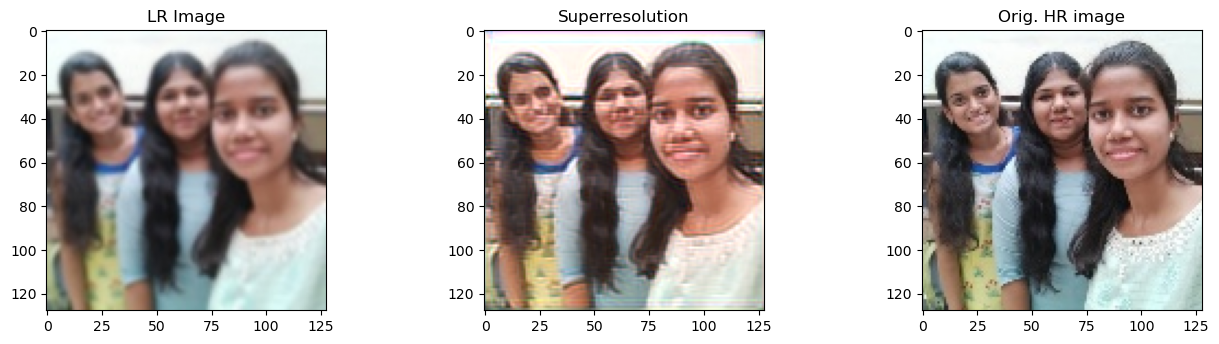

In [67]:
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('C:/Users/sneha/worksneha/datas/gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()